In [1]:
using DynamicalSystems
using OrdinaryDiffEq
using BenchmarkTools
using StaticArrays
# using SciPy
# using Statistics


using DifferentialEquations

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0

tspan = (0.0, 300000.0)
# condition = SA[ 0., 0.2, 0.3, 0., 0.5, 0.6]

p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, k];

In [4]:
start_k1, end_k1, step_k1 = -0.5, 0.5, 0.01
start_k2, end_k2, step_k2 = -0.5, 0.5, 0.01

k1_array = range( start_k1, end_k1, step = step_k1 )
k2_array = range( start_k2, end_k2, step = step_k2 )

-0.5:0.01:0.5

In [6]:
spectrum_matrix = zeros( ( length(k1_array), length(k2_array), 6 ) )

101×101 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [31]:
for (k1_index, k1) in enumerate( k1_array )

    for (k2_index, k2) in enumerate( k2_array )
        
        if k1_index == k2_index
            
            k1 = round(k1, digits = 2)
            k2 = round(k2, digits = 2)
            
            println("diagonal inheritance");  flush(stdout)
            println( " index k1: ", k1_index, "; k1: ", k1 );  flush(stdout)
            println( " index k2: ", k2_index, "; k2: ", k2 );  flush(stdout)
            
            if k1_index == 1
                global diagonalcondition = SA[0.1, 0.1, 0.1,
                                            -0.1, -0.1, -0.1]
            end
            println("initial condition:", diagonalcondition);  flush(stdout)
            
            p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, 0.0]
            println("p:", p); flush(stdout)
            ds_HR = ContinuousDynamicalSystem(HR, diagonalcondition, p )
            
            lyap = lyapunovspectrum(ds_HR, tspan[2], Ttr = 200.000; diffeq = (alg = AutoVern9(Rodas5()), maxiters = 10000000))
            
            spectrum_matrix[k1_index, k2_index, :] = lyap

            
            println("lyap:", lyap);  flush(stdout)
            
            prob = ODEProblem(HR, diagonalcondition, tspan, p)
            sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-9, reltol = 1e-9, maxiters = 10000000)
            
            
            diagonalcondition = sol[length(sol.u)]
            
            println("last value: ", diagonalcondition);  flush(stdout)
            println(" _______ ");  flush(stdout)
            println(" ");  flush(stdout)
            
            global rightcondition = diagonalcondition
            global upcondition = diagonalcondition
            
            k1_index_ = k1_index + 1
            k2_index_ = k2_index + 1
            
            if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
            end
            
            for k1_ in range((k1 + step_k1), end_k1, step = step_k1 )
                
                 
                k1_ = round(k1_, digits = 2)
                
                if k1_ > end_k1 || k2 > end_k2
                    println("condition on continue is done");  flush(stdout)
                    continue
                end
                
                println("Inheritance to the right");  flush(stdout)
                
                println( " index k1: ", k1_index_, "; k1: ", k1_ );  flush(stdout)
                println( " index k2: ", k2_index, "; k2: ", k2 );  flush(stdout)
                
                println("initial condition:", rightcondition);  flush(stdout)
                
                p = SA[a, b, c, d, s, xr, r, I, xv, k1_, k2, 0.0]
                println("p:", p); flush(stdout)
                ds_HR = ContinuousDynamicalSystem(HR, rightcondition, p )
            
                lyap = lyapunovspectrum(ds_HR, tspan[2], Ttr = 200.000; diffeq = (alg = AutoVern9(Rodas5()), maxiters = 10000000))
               
                spectrum_matrix[k1_index_, k2_index, :] = lyap
                
                println("lyap:", lyap);  flush(stdout)
            
                prob = ODEProblem(HR, rightcondition, tspan, p)
                sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-9, reltol = 1e-9, maxiters = 10000000)            
                
                rightcondition = sol[length(sol.u)]
                
                println("last value: ",  sol[length(sol.u)]);  flush(stdout)
                
                
                k1_index_+=1
                println(">>>>>>>>>");  flush(stdout)
                print("  ");  flush(stdout)
                
                if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
                end
            end
            
            for k2_ in range((k2 + step_k2), end_k2, step = step_k2 )
                
                k2_ = round(k2_, digits = 2)
                
                if k1 > end_k1 || k2_ > end_k2
                    println("condition on continue is done");  flush(stdout)
                    continue
                end
                
                println("Inheritance upwards");  flush(stdout)
                
                println( " index k1: ", k1_index, "; k1: ", k1 );  flush(stdout)
                println( " index k2: ", k2_index_, "; k2: ", k2_ );  flush(stdout)
                
                println("initial condition:", upcondition);  flush(stdout)
                
                p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2_, 0.0]
                println("p:", p); flush(stdout)
                ds_HR = ContinuousDynamicalSystem(HR, upcondition, p )
            
                lyap = lyapunovspectrum(ds_HR, tspan[2], Ttr = 200.000; diffeq = (alg = AutoVern9(Rodas5()), maxiters = 10000000))
                

                spectrum_matrix[k1_index, k2_index_, :] = lyap
                
                println("lyap:", lyap);  flush(stdout)
            
                prob = ODEProblem(HR, upcondition, tspan, p)
                sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-9, reltol = 1e-9, maxiters = 10000000)
            
                upcondition = sol[length(sol.u)]
                
                println("lyap:", lyap);  flush(stdout)
                println("last value: ", sol[length(sol.u)]);  flush(stdout)
                
                
                k2_index_+=1
                println("^^^^^^^^^^");  flush(stdout)
                print("  ");  flush(stdout)
                
                if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
                end

            end
        end
    end
    println("-------------");  flush(stdout)
    println(" ");  flush(stdout)
end

diagonal inheritance
 index k1: 1; k1: -0.5
 index k2: 1; k2: -0.5
initial condition:[0.1, 0.1, 0.1, -0.1, -0.1, -0.1]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.5, 0.0]
lyap:[1.076336792181203e-5, -0.00490910774886418, -0.01988620896747875, -0.02014191085343137, -5.735901730923611, -13.404660074819702]
last value: [-0.8287725590311618, -2.6667721122150003, 3.930540590591362, -1.104141906081785, -5.912820109649025, 3.007210750115944]
 _______ 
 
Inheritance to the right
 index k1: 2; k1: -0.49
 index k2: 1; k2: -0.5
initial condition:[-0.8287725590311618, -2.6667721122150003, 3.930540590591362, -1.104141906081785, -5.912820109649025, 3.007210750115944]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.5, 0.0]
lyap:[1.1499389661908467e-5, -0.004562709661708209, -0.01992809354119207, -0.022544592694312235, -5.7026566880491165, -13.464645274839892]
last value: [-1.1756082215076447, -4.377899487167218, 4.149119951015894, 0.032443147350675376, 0.03062435768566794, 

last value: [-1.2202851197305908, -6.1958354050996585, 3.9825815215680738, -0.8391408080100597, -4.9410183739972675, 3.314122869060691]
>>>>>>>>>
  Inheritance to the right
 index k1: 16; k1: -0.35
 index k2: 1; k2: -0.5
initial condition:[-1.2202851197305908, -6.1958354050996585, 3.9825815215680738, -0.8391408080100597, -4.9410183739972675, 3.314122869060691]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.5, 0.0]
lyap:[-4.263908147156139e-6, -0.003001332261889798, -0.0029962309630667226, -0.0527425994652477, -5.862606341639189, -13.03596543317105]
last value: [-1.384416585163728, -7.982921759300127, 3.279259527911665, 0.5714647665906081, 0.43791089342537154, 3.8944837010784825]
>>>>>>>>>
  Inheritance to the right
 index k1: 17; k1: -0.34
 index k2: 1; k2: -0.5
initial condition:[-1.384416585163728, -7.982921759300127, 3.279259527911665, 0.5714647665906081, 0.43791089342537154, 3.8944837010784825]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.5, 0.0]
lyap:[-

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.5, 0.0]
lyap:[3.84812811561263e-6, -0.007313558722481919, -0.007311827339764876, -0.04296203278236747, -5.706641668760226, -12.714326896228826]
last value: [-1.2785656156781529, -7.49160733780486, 3.415050265119597, -0.4725319089107086, -0.7387237956055974, 3.8838862638628986]
>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 1; k2: -0.5
initial condition:[-1.2785656156781529, -7.49160733780486, 3.415050265119597, -0.4725319089107086, -0.7387237956055974, 3.8838862638628986]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.5, 0.0]
lyap:[8.916701377086929e-5, -0.0006628964085976138, -0.005936603017007006, -0.03264141997067261, -5.798020587427844, -12.47151902233657]
last value: [-0.9327871375081508, -3.612725374568715, 4.0051831537894875, -1.5769606529132978, -12.021776796271618, 3.3197338142359145]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 1; k2: -0.5
initial condi

>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 1; k2: -0.5
initial condition:[-1.3084567421907956, -7.528069230495905, 3.6918426710024987, -0.37007747129123203, -4.476602523017797, 3.92059809324451]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.5, 0.0]
lyap:[0.0037574202972715715, -8.996511318544285e-6, -0.00788685292544337, -0.037690838529299525, -6.068080484281247, -11.560219740328213]
last value: [-0.9187936133076808, -3.415022980431859, 3.868953162137971, -1.3614191562776417, -8.195345146533633, 3.8897356968616945]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 1; k2: -0.5
initial condition:[-0.9187936133076808, -3.415022980431859, 3.868953162137971, -1.3614191562776417, -8.195345146533633, 3.8897356968616945]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.5, 0.0]
lyap:[0.002905580566750724, -1.545961491306307e-6, -0.014097459137958835, -0.03947969046086116, -5.982371151391814, -11.613944235490164]
last 

last value: [-0.9241761736238461, -3.1420133462720203, 4.226960316343911, -1.4148204273512182, -9.395669686110704, 3.411196896565481]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 1; k2: -0.5
initial condition:[-0.9241761736238461, -3.1420133462720203, 4.226960316343911, -1.4148204273512182, -9.395669686110704, 3.411196896565481]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.5, 0.0]
lyap:[1.5815922018200935e-5, -0.004128559619701331, -0.013333974112060167, -0.01333452319670656, -5.248887584826717, -9.810845161195596]
last value: [-0.8018647855741683, -2.812356445662857, 3.7948156512703273, 0.2676184047511358, 0.5268458131543741, 3.832689777760523]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 1; k2: -0.5
initial condition:[-0.8018647855741683, -2.812356445662857, 3.7948156512703273, 0.2676184047511358, 0.5268458131543741, 3.832689777760523]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.5, 0.0]
lyap:[1.136441225

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.5, 0.0]
lyap:[0.02020933546640315, 0.0018830133731250174, -0.0007613900302732242, -0.01375365960623204, -6.102169738496373, -9.98145408405822]
last value: [-1.1505718502430833, -5.321686921563994, 4.198566910116065, -1.351741335926604, -8.309766212379365, 3.627132957932475]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 1; k2: -0.5
initial condition:[-1.1505718502430833, -5.321686921563994, 4.198566910116065, -1.351741335926604, -8.309766212379365, 3.627132957932475]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.5, 0.0]
lyap:[0.020406403260888793, 0.0018825136429972778, -0.0008449402702441475, -0.014033956914695956, -6.13443830150962, -10.036689551584548]
last value: [-1.138740851886938, -5.195230701802063, 4.196865116911941, -1.234032893544348, -6.87024939484977, 3.554636407826471]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 1; k2: -0.5
initial condition:[-1.138

>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 1; k2: -0.5
initial condition:[-1.2410112026518523, -6.535187129544642, 4.013907260774932, -0.7799181200294232, -2.8434720748324023, 3.3389192954434]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.5, 0.0]
lyap:[0.020856089759904904, 0.0027885168654496082, -0.00033542473227405066, -0.016272421267816667, -6.20320279966668, -10.17385359377032]
last value: [-1.0248630954955784, -4.0702756463598595, 4.175359768344964, -1.3173795103701664, -7.848574910410864, 3.6288566323270435]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 1; k2: -0.5
initial condition:[-1.0248630954955784, -4.0702756463598595, 4.175359768344964, -1.3173795103701664, -7.848574910410864, 3.6288566323270435]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.5, 0.0]
lyap:[0.021161306886346903, 0.003345574577318333, -0.00023056366668159668, -0.016108568021057288, -6.193327381236441, -10.147126662834703]
last va

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.48, 0.0]
lyap:[-3.772894977227953e-6, -0.003992360795115325, -0.022016203774641224, -0.0220194956036985, -5.687106274033276, -13.470485407956492]
lyap:[-3.772894977227953e-6, -0.003992360795115325, -0.022016203774641224, -0.0220194956036985, -5.687106274033276, -13.470485407956492]
last value: [-0.20917026741754569, 0.11899950605447494, 3.962281755422343, -1.2548820136937895, -6.722941238480011, 3.1334938890754676]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 4; k2: -0.47
initial condition:[-0.20917026741754569, 0.11899950605447494, 3.962281755422343, -1.2548820136937895, -6.722941238480011, 3.1334938890754676]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.47, 0.0]
lyap:[0.00036491564255397796, -3.5145882573701035e-5, -0.00022639248006853742, -0.05347106454651814, -5.903596575585305, -13.172779807065899]
lyap:[0.00036491564255397796, -3.5145882573701035e-5, -0.00022639248006853742, -0.05347106

^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 15; k2: -0.36
initial condition:[-0.3464610833383427, -0.34208487871213966, 3.8245770122978744, -1.290074115576764, -7.520765186323443, 3.3033552127925088]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.36, 0.0]
lyap:[-9.34262345508549e-6, -0.002757459478920211, -0.002766260831907775, -0.054742828153699546, -5.866403923771184, -13.048766254236728]
lyap:[-9.34262345508549e-6, -0.002757459478920211, -0.002766260831907775, -0.054742828153699546, -5.866403923771184, -13.048766254236728]
last value: [-0.42274071147184417, -0.602904026556749, 3.817409321911357, -1.2862300444153627, -7.59084260686695, 3.313927167783519]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 16; k2: -0.35
initial condition:[-0.42274071147184417, -0.602904026556749, 3.817409321911357, -1.2862300444153627, -7.59084260686695, 3.313927167783519]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.35, 0.0]
lyap:[-1.641

last value: [-0.8657763886323003, -3.042207732491278, 3.8166795573357293, -1.411127917844351, -9.265780187662799, 3.493179944314632]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 27; k2: -0.24
initial condition:[-0.8657763886323003, -3.042207732491278, 3.8166795573357293, -1.411127917844351, -9.265780187662799, 3.493179944314632]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.24, 0.0]
lyap:[-1.5338784948772453e-6, -0.006043334722505509, -0.006050919205054693, -0.06423107388672833, -5.73506365613075, -12.856731356145572]
lyap:[-1.5338784948772453e-6, -0.006043334722505509, -0.006050919205054693, -0.06423107388672833, -5.73506365613075, -12.856731356145572]
last value: [-0.825772117744963, -2.7394582871026807, 3.823586377114172, -1.3880502345961325, -8.949256134770293, 3.4786583157639797]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 28; k2: -0.23
initial condition:[-0.825772117744963, -2.7394582871026807, 3.823586377114172, -1.388050

lyap:[0.014135525971649897, 0.0001880573139410682, -0.0028931881467176863, -0.034441570191734494, -6.018309073929648, -11.267895479020243]
last value: [-1.1949167215989616, -6.300178473233973, 3.6727344975651848, -0.9551951708352965, -3.5664878328748912, 4.040815723731328]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 39; k2: -0.12
initial condition:[-1.1949167215989616, -6.300178473233973, 3.6727344975651848, -0.9551951708352965, -3.5664878328748912, 4.040815723731328]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.12, 0.0]
lyap:[0.013883137946792343, 0.0001169686102996691, -0.003938335427049944, -0.032787164879705746, -6.021175633379799, -11.266126894717006]
lyap:[0.013883137946792343, 0.0001169686102996691, -0.003938335427049944, -0.032787164879705746, -6.021175633379799, -11.266126894717006]
last value: [-1.5787863261855406, -10.012090063675993, 3.6984506119171243, 0.7865274744233994, 0.190530670450985, 3.8369093215972594]
^^^^^^^^^^
  Inheritance u

lyap:[1.36548438868504e-6, -0.003921589162761219, -0.009958010712265729, -0.023175356194635018, -5.834840967704719, -11.420733994206742]
lyap:[1.36548438868504e-6, -0.003921589162761219, -0.009958010712265729, -0.023175356194635018, -5.834840967704719, -11.420733994206742]
last value: [-0.9692584393525893, -3.555534635646093, 4.137079125837006, -0.5677313198311125, -1.383754434470553, 3.6086241609928877]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 51; k2: 0.0
initial condition:[-0.9692584393525893, -3.555534635646093, 4.137079125837006, -0.5677313198311125, -1.383754434470553, 3.6086241609928877]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.0, 0.0]
lyap:[1.6832280627802918e-6, -0.006391892274426508, -0.0149961768115109, -0.06631340955728549, -6.662855079599867, -10.356094644473451]
lyap:[1.6832280627802918e-6, -0.006391892274426508, -0.0149961768115109, -0.06631340955728549, -6.662855079599867, -10.356094644473451]
last value: [-0.8538930819112404, -

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.11, 0.0]
lyap:[0.01708487175371193, 0.001610888799011185, -0.0005583287205212223, -0.01907228267316107, -5.746404417572413, -9.567833086219286]
lyap:[0.01708487175371193, 0.001610888799011185, -0.0005583287205212223, -0.01907228267316107, -5.746404417572413, -9.567833086219286]
last value: [-1.2635894952424411, -7.210862988727561, 3.572198267391368, -0.8333590939356358, -2.647450833677678, 3.990484490503714]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 63; k2: 0.12
initial condition:[-1.2635894952424411, -7.210862988727561, 3.572198267391368, -0.8333590939356358, -2.647450833677678, 3.990484490503714]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.12, 0.0]
lyap:[0.0191674792819311, 0.0020766202143678724, -0.00034099745770899083, -0.011646344339232317, -5.972544577295375, -9.784380356858916]
lyap:[0.0191674792819311, 0.0020766202143678724, -0.00034099745770899083, -0.011646344339232317, -5.9725445

 index k2: 74; k2: 0.23
initial condition:[0.9974025366795236, -0.2336439972564712, 3.3114663301467915, -0.8852335715557551, -3.467217395461551, 4.143008269226622]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.23, 0.0]
lyap:[0.020467652421831187, 0.0016264193912256923, -0.0006836654775834938, -0.013898982437465974, -6.102134743705959, -9.985535950066524]
lyap:[0.020467652421831187, 0.0016264193912256923, -0.0006836654775834938, -0.013898982437465974, -6.102134743705959, -9.985535950066524]
last value: [-0.654880541940255, -4.180891388880703, 3.9233558145449123, -0.5884348545054897, -1.5367012581608281, 3.8639593426024907]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 75; k2: 0.24
initial condition:[-0.654880541940255, -4.180891388880703, 3.9233558145449123, -0.5884348545054897, -1.5367012581608281, 3.8639593426024907]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.24, 0.0]
lyap:[0.02060158618750143, 0.0018760411143317773, -0.00070249616124486

^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 86; k2: 0.35
initial condition:[-0.948872811636925, -3.529718094511664, 4.029093460470922, -1.145209113911908, -5.456931056671864, 3.9884994535803124]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.35, 0.0]
lyap:[0.020508792353197924, 0.002573579449014666, -0.0002951155008077046, -0.01697005220616652, -6.199606718558663, -10.138940686976813]
lyap:[0.020508792353197924, 0.002573579449014666, -0.0002951155008077046, -0.01697005220616652, -6.199606718558663, -10.138940686976813]
last value: [-1.404913023644432, -8.9993900605522, 3.683802915413324, -1.1256492897576846, -5.134575845753463, 4.110448966359181]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 87; k2: 0.36
initial condition:[-1.404913023644432, -8.9993900605522, 3.683802915413324, -1.1256492897576846, -5.134575845753463, 4.110448966359181]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.36, 0.0]
lyap:[0.01993770744225326, 0

last value: [-1.3371459359264026, -8.118645548754236, 3.6205481448297796, -1.064684679056506, -4.375051954878095, 4.260819654384163]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 98; k2: 0.47
initial condition:[-1.3371459359264026, -8.118645548754236, 3.6205481448297796, -1.064684679056506, -4.375051954878095, 4.260819654384163]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.47, 0.0]
lyap:[0.026484387929432432, 0.00426077237481201, -0.0001773207405468092, -0.015488708292880328, -6.166486612883308, -10.090792742985437]
lyap:[0.026484387929432432, 0.00426077237481201, -0.0001773207405468092, -0.015488708292880328, -6.166486612883308, -10.090792742985437]
last value: [-0.47933256399282925, -1.2334858972155154, 3.310531878550934, -1.3764355572639353, -8.383125648255197, 4.039155723129523]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 99; k2: 0.48
initial condition:[-0.47933256399282925, -1.2334858972155154, 3.310531878550934, -1.37643555

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.49, 0.0]
lyap:[-1.7032108270353494e-5, -0.0020665395759021685, -0.002091216958037379, -0.0745115103456037, -5.861845306091381, -13.098940487827006]
last value: [-0.9297738523728168, -3.7372355252070393, 3.609988073209776, -1.445022701908392, -9.556963543572735, 3.713158185034476]
>>>>>>>>>
  Inheritance to the right
 index k1: 12; k1: -0.39
 index k2: 2; k2: -0.49
initial condition:[-0.9297738523728168, -3.7372355252070393, 3.609988073209776, -1.445022701908392, -9.556963543572735, 3.713158185034476]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.49, 0.0]
lyap:[-2.893035533572443e-7, -0.0022990425315853324, -0.0023024854726381746, -0.06663060906032303, -5.865316686870821, -13.081560671005745]
last value: [-0.3362222715287506, -0.43864107066390284, 3.659536213192762, -1.4157632105211486, -8.857490806381284, 3.5628096385057817]
>>>>>>>>>
  Inheritance to the right
 index k1: 13; k1: -0.38
 index k2: 2; k2: -0.49
init

>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 2; k2: -0.49
initial condition:[-1.4911702027508205, -10.375034553208483, 3.5879598143916787, -0.9344962789655051, -3.9567037443587902, 3.8333230149975956]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.49, 0.0]
lyap:[-4.548866914474965e-6, -0.0057266877055993015, -0.0057327054417816645, -0.0624881914416896, -5.749477673334674, -12.845575093061004]
last value: [-1.348358827813729, -7.774469804412346, 3.3164079851668498, 1.4135203347220502, -5.406899467958123, 4.038412512429557]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24
 index k2: 2; k2: -0.49
initial condition:[-1.348358827813729, -7.774469804412346, 3.3164079851668498, 1.4135203347220502, -5.406899467958123, 4.038412512429557]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.49, 0.0]
lyap:[8.280854818190345e-7, -0.006036558959145062, -0.006050403502990736, -0.07906244135730718, -5.712017830475083, -12.842333244742665]
l

lyap:[0.011969864171035799, 5.5171694334969515e-5, -0.005186328782711329, -0.03422190897436937, -6.025088346975594, -11.383442097659271]
last value: [-0.9360791396997726, -3.240864110254891, 4.223719048163738, -0.9603829314532789, -4.321758452119177, 3.248092862819855]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 2; k2: -0.49
initial condition:[-0.9360791396997726, -3.240864110254891, 4.223719048163738, -0.9603829314532789, -4.321758452119177, 3.248092862819855]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.49, 0.0]
lyap:[0.012289866004015505, 0.00011601638397612896, -0.006047843617166976, -0.03310387126938275, -6.023700779298856, -11.323474902147588]
last value: [-0.9195439851827378, -3.3815862677868744, 3.9133085247583477, -1.5483474402856023, -11.306096467215866, 3.574577091222532]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 2; k2: -0.49
initial condition:[-0.9195439851827378, -3.3815862677868744, 3.913308524758347

>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 2; k2: -0.49
initial condition:[-0.8715452532498161, -3.2106576664158584, 3.676627966346725, -0.9459481463686487, -3.467143917053588, 4.0610177218849195]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.49, 0.0]
lyap:[0.014363268942902657, 0.0015581475786677168, -0.0006176040907875643, -0.013332158111299598, -5.969903911988594, -9.903745670252476]
last value: [-0.9028237142270569, -3.188121319126901, 3.9785338326762645, -0.9322414490975329, -3.51634308642726, 3.877923429812134]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 2; k2: -0.49
initial condition:[-0.9028237142270569, -3.188121319126901, 3.9785338326762645, -0.9322414490975329, -3.51634308642726, 3.877923429812134]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.49, 0.0]
lyap:[0.013746790436703989, 0.0009205551814433268, -0.0012594541515348035, -0.014269809851783659, -5.962990286645147, -9.97995151202476]
last v

lyap:[0.01699586533076977, 0.001418573974177899, -0.000986520182007933, -0.014086847430463924, -6.1634139806208275, -10.09052319912419]
last value: [-0.5394121708951406, -1.0019265600093568, 3.90933746829714, -1.1401159852544527, -5.530121365978783, 3.7735389480511627]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 2; k2: -0.49
initial condition:[-0.5394121708951406, -1.0019265600093568, 3.90933746829714, -1.1401159852544527, -5.530121365978783, 3.7735389480511627]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.49, 0.0]
lyap:[0.01704940989704725, 0.0010081540478264466, -0.0012142528413959153, -0.01427668705777459, -6.182489752994979, -10.144167905905402]
last value: [-0.8712156571899445, -3.0136842497163645, 4.1518590347696085, -0.6208652999420387, -4.808963993199381, 3.593930683269526]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 2; k2: -0.49
initial condition:[-0.8712156571899445, -3.0136842497163645, 4.1518590347696085, 

 index k1: 84; k1: 0.33
 index k2: 2; k2: -0.49
initial condition:[-0.2997607467560076, -0.2389793332196735, 4.0408625688981825, -0.28001070854886917, -0.05472280866290762, 3.682716442184364]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.49, 0.0]
lyap:[0.021128591293321997, 0.002307600403560831, -0.00034915469345073847, -0.015844660513422364, -6.198592754567685, -10.129927763964549]
last value: [-0.9318847590085061, -3.479885084836749, 3.91750258234503, -1.2113357305242944, -6.372425048096259, 3.8007990342805944]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 2; k2: -0.49
initial condition:[-0.9318847590085061, -3.479885084836749, 3.91750258234503, -1.2113357305242944, -6.372425048096259, 3.8007990342805944]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.49, 0.0]
lyap:[0.019833164925516657, 0.0027083542310844767, -0.00034641376726747265, -0.01584302106380734, -6.2175772198557775, -10.165672192606133]
last value: [-0.9497956509726999, -3

last value: [-0.7639612667984444, -1.8913237048982787, 4.309556796399825, -1.1673131094002562, -5.914710614601565, 3.744261492933293]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 2; k2: -0.49
initial condition:[-0.7639612667984444, -1.8913237048982787, 4.309556796399825, -1.1673131094002562, -5.914710614601565, 3.744261492933293]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.49, 0.0]
lyap:[0.02780849939011937, 0.0036447468079174286, -0.00010183109403376086, -0.014668359791095183, -6.1491286530103375, -10.062826854249035]
last value: [-0.9490727835071093, -3.4279668454256553, 4.13711260180428, -1.4057855492480178, -9.23123300040678, 3.4480984592624386]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 2; k2: -0.49
initial condition:[-0.9490727835071093, -3.4279668454256553, 4.13711260180428, -1.4057855492480178, -9.23123300040678, 3.4480984592624386]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.49, 0.0]
lyap:[0

 index k1: 2; k1: -0.49
 index k2: 12; k2: -0.39
initial condition:[-0.8741775715982767, -2.9585973288199914, 3.980477783922451, -0.8451534196279211, -3.4898949681029827, 3.132791836281599]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.39, 0.0]
lyap:[8.542400226364372e-7, -0.002305615462608925, -0.0022972332346044536, -0.06663540694873953, -5.86530412785545, -13.08156655812783]
lyap:[8.542400226364372e-7, -0.002305615462608925, -0.0022972332346044536, -0.06663540694873953, -5.86530412785545, -13.08156655812783]
last value: [-1.1798625569268983, -5.893179103894143, 3.9271762146688163, -0.9834433654165143, -4.452245724708966, 3.3800311461768144]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 13; k2: -0.38
initial condition:[-1.1798625569268983, -5.893179103894143, 3.9271762146688163, -0.9834433654165143, -4.452245724708966, 3.3800311461768144]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.38, 0.0]
lyap:[-2.8237292245659746e-6, -0.002521984

last value: [-1.0774779574663564, -5.55754748956964, 3.099825583022748, -0.9467627689122007, -3.402352108654651, 4.143623837830414]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 24; k2: -0.27
initial condition:[-1.0774779574663564, -5.55754748956964, 3.099825583022748, -0.9467627689122007, -3.402352108654651, 4.143623837830414]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.27, 0.0]
lyap:[-8.801520691921973e-6, -0.005138975302817309, -0.005134742954672275, -0.052144226669612236, -5.789827058845792, -12.886696533701953]
lyap:[-8.801520691921973e-6, -0.005138975302817309, -0.005134742954672275, -0.052144226669612236, -5.789827058845792, -12.886696533701953]
last value: [-1.4417313631900683, -9.630504047615082, 3.571566374561926, -0.7328197126041257, -2.216466744928536, 3.704591879695312]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 25; k2: -0.26
initial condition:[-1.4417313631900683, -9.630504047615082, 3.571566374561926, -0.7328

lyap:[0.014851633566660371, 2.840560450031432e-5, -0.007983613851211982, -0.03653357633336462, -6.042935835797328, -11.52938155257924]
last value: [-0.960896095791382, -3.530239159928673, 4.135858580456516, -1.1939273151075884, -6.554887668219137, 3.38476209814211]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 36; k2: -0.15
initial condition:[-0.960896095791382, -3.530239159928673, 4.135858580456516, -1.1939273151075884, -6.554887668219137, 3.38476209814211]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.15, 0.0]
lyap:[0.015687318985526656, 0.00012960631222788026, -0.004705202880527517, -0.0370890094153678, -6.0572637654070824, -11.387259895611525]
lyap:[0.015687318985526656, 0.00012960631222788026, -0.004705202880527517, -0.0370890094153678, -6.0572637654070824, -11.387259895611525]
last value: [-0.34518879471630065, -5.34032784403801, 3.4889103017031293, -1.1284473901699754, -4.998361663544192, 3.9315798225616647]
^^^^^^^^^^
  Inheritance upwards
 i

lyap:[-3.2158780087076853e-6, -0.011248220187659306, -0.011317693084751841, -0.018728157980908943, -5.879240352841714, -11.73429692291192]
lyap:[-3.2158780087076853e-6, -0.011248220187659306, -0.011317693084751841, -0.018728157980908943, -5.879240352841714, -11.73429692291192]
last value: [-0.3018135967661436, -0.20510793766251742, 3.8328806763828784, -1.2871809190030108, -7.209374604630378, 3.8542502259903104]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 48; k2: -0.03
initial condition:[-0.3018135967661436, -0.20510793766251742, 3.8328806763828784, -1.2871809190030108, -7.209374604630378, 3.8542502259903104]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.03, 0.0]
lyap:[1.5251259176435383e-6, -0.00035890736825794275, -0.005727624172690737, -0.033504482096945544, -5.84830092085876, -11.816022916581224]
lyap:[1.5251259176435383e-6, -0.00035890736825794275, -0.005727624172690737, -0.033504482096945544, -5.84830092085876, -11.816022916581224]
last value:

initial condition:[-0.8801823687901918, -3.359214519674907, 3.584291922983785, -1.0666333455368198, -4.668159588526517, 3.9597204375470993]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.08, 0.0]
lyap:[6.157549134829435e-5, -0.0008606277786302766, -0.014550271120178074, -0.01462271704034273, -5.352095591237863, -9.993954422679112]
lyap:[6.157549134829435e-5, -0.0008606277786302766, -0.014550271120178074, -0.01462271704034273, -5.352095591237863, -9.993954422679112]
last value: [-0.2221701391128605, -0.029648460586282004, 3.7961335481188025, -0.8748235357443576, -3.2382970300868554, 3.785431440022691]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 60; k2: 0.09
initial condition:[-0.2221701391128605, -0.029648460586282004, 3.7961335481188025, -0.8748235357443576, -3.2382970300868554, 3.785431440022691]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.09, 0.0]
lyap:[5.977071765635007e-6, -0.004331634226924808, -0.014766131758638256, -0.0147633295

^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 71; k2: 0.2
initial condition:[1.7147027160757942, -2.3737094178039313, 3.434811516507995, -0.5469286460506335, -1.3724539668885138, 3.992184738688213]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.2, 0.0]
lyap:[0.018236567352300385, 0.001691658621437258, -0.0007366069783429259, -0.014034561757032308, -6.194282038649066, -10.116579789514146]
lyap:[0.018236567352300385, 0.001691658621437258, -0.0007366069783429259, -0.014034561757032308, -6.194282038649066, -10.116579789514146]
last value: [-0.3958059225539848, -0.712380649655662, 3.5594009765881878, -1.2258184988344927, -6.535171717127044, 3.9161313087778438]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 72; k2: 0.21
initial condition:[-0.3958059225539848, -0.712380649655662, 3.5594009765881878, -1.2258184988344927, -6.535171717127044, 3.9161313087778438]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.21, 0.0]
lyap:[0.0184

last value: [-0.7632195878798783, -2.6366857128785295, 3.4418636839931525, -0.7992924496337666, -2.458740441415064, 3.934883994245468]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 83; k2: 0.32
initial condition:[-0.7632195878798783, -2.6366857128785295, 3.4418636839931525, -0.7992924496337666, -2.458740441415064, 3.934883994245468]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.32, 0.0]
lyap:[0.021071878536469482, 0.0023964529483268275, -0.0003663187199117966, -0.015121228497250635, -6.201935729078076, -10.14349407914826]
lyap:[0.021071878536469482, 0.0023964529483268275, -0.0003663187199117966, -0.015121228497250635, -6.201935729078076, -10.14349407914826]
last value: [-1.435786600310217, -9.324506141208888, 3.815630306265987, -0.984770648669769, -3.5554535287007583, 4.34063723279317]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 84; k2: 0.33
initial condition:[-1.435786600310217, -9.324506141208888, 3.815630306265987, -0.984770

lyap:[0.023905729200270988, 0.003290908704642056, -0.00022143653241633808, -0.015369970333328837, -6.130919986599893, -10.042221009980787]
last value: [-1.4888354977845297, -10.039493864901662, 3.9108033556001165, -1.052419811308205, -4.080331319193198, 4.453822851688928]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 95; k2: 0.44
initial condition:[-1.4888354977845297, -10.039493864901662, 3.9108033556001165, -1.052419811308205, -4.080331319193198, 4.453822851688928]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.44, 0.0]
lyap:[0.024783119991090848, 0.003741848662358105, -0.00021073495370339107, -0.015094055709093038, -6.145263756588386, -10.011291984716294]
lyap:[0.024783119991090848, 0.003741848662358105, -0.00021073495370339107, -0.015094055709093038, -6.145263756588386, -10.011291984716294]
last value: [-1.1645279866393883, -6.201657240427543, 3.4071483063946464, -1.4473923624489902, -9.303794603640831, 4.022807639655686]
^^^^^^^^^^
  Inheritance u

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.48, 0.0]
lyap:[-6.455051666623117e-6, -0.0016354394349968953, -0.0016303520082381938, -0.06839370159950574, -5.876155202394036, -13.121822614731368]
last value: [1.3797805105031995, -5.473693302923627, 4.034428871979396, -1.496548681495001, -9.26980686981687, 3.182235818076247]
>>>>>>>>>
  Inheritance to the right
 index k1: 9; k1: -0.42
 index k2: 3; k2: -0.48
initial condition:[1.3797805105031995, -5.473693302923627, 4.034428871979396, -1.496548681495001, -9.26980686981687, 3.182235818076247]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.48, 0.0]
lyap:[7.695524358273292e-7, -0.00185926334638315, -0.0018620410947733676, -0.07624701763756261, -5.864573624219448, -13.10787282107578]
last value: [-0.9712360932202437, -4.106034384894753, 3.6003046735214435, -1.4491876208289705, -9.590575989350562, 3.7442834959055182]
>>>>>>>>>
  Inheritance to the right
 index k1: 10; k1: -0.41
 index k2: 3; k2: -0.48
initial condit

>>>>>>>>>
  Inheritance to the right
 index k1: 23; k1: -0.28
 index k2: 3; k2: -0.48
initial condition:[-1.2790802596699729, -7.560862395277119, 3.3547796021075427, -0.522142452633082, -0.9872283534869767, 3.8337459438910773]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.48, 0.0]
lyap:[-3.2553836801357865e-6, -0.0049332644605121845, -0.004921025600934867, -0.05445011744312402, -5.792369602261327, -12.87564474495598]
last value: [-0.5645473471150143, -1.2812604034754496, 3.7131722550576667, -1.414931387461317, -9.222505877658392, 3.537662508464847]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 3; k2: -0.48
initial condition:[-0.5645473471150143, -1.2812604034754496, 3.7131722550576667, -1.414931387461317, -9.222505877658392, 3.537662508464847]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.48, 0.0]
lyap:[-2.460641706739457e-7, -0.005178130650492161, -0.005185990436295745, -0.05720775624823681, -5.777915945342984, -12.869710432656708

lyap:[0.015451838222511567, 0.0004326400062825516, -0.002882020249532051, -0.035616323392947555, -6.0554437295105235, -11.246776208956922]
last value: [-0.9817949499110645, -3.789301131684459, 4.051262072777673, -1.27763703272228, -7.640145719739808, 3.3022683779839985]
>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 3; k2: -0.48
initial condition:[-0.9817949499110645, -3.789301131684459, 4.051262072777673, -1.27763703272228, -7.640145719739808, 3.3022683779839985]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.48, 0.0]
lyap:[0.014410195258108422, 0.0002826126596885018, -0.002268108501294477, -0.034044308742412, -6.05579099376292, -11.223233336271832]
last value: [-1.2814950894772459, -7.280788284373478, 3.742340047001111, -0.8537595753146564, -3.0326965783088893, 3.7246209668200896]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 3; k2: -0.48
initial condition:[-1.2814950894772459, -7.280788284373478, 3.742340047001111, -0

>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 3; k2: -0.48
initial condition:[-0.7393835575705648, -2.1421655264791757, 3.8382287142350546, -1.3300497681532177, -7.8636356936587894, 3.781878271015992]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.48, 0.0]
lyap:[0.012146502135527017, 0.0021914236075657144, -0.0003190684931238036, -0.014186970397082685, -6.102538579626679, -9.87644374991665]
last value: [-0.9130948884199801, -3.3059625103637043, 3.9390978002390806, -1.4678410680203537, -9.729250342568564, 3.895664490686239]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 3; k2: -0.48
initial condition:[-0.9130948884199801, -3.3059625103637043, 3.9390978002390806, -1.4678410680203537, -9.729250342568564, 3.895664490686239]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.48, 0.0]
lyap:[0.013336843242338964, 0.0020382201996398137, -0.00035396060200843107, -0.013928964523230638, -6.061954377306001, -9.93473362313665]
l

lyap:[0.018569225831319265, 0.0017049061923847515, -0.0006271069434863754, -0.011423086910867814, -6.115833810194831, -9.967272172953574]
last value: [-0.8513550997618685, -2.7784806295158515, 3.9920790196310967, -1.0747165870901925, -5.338595165398973, 3.3075160310075087]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 3; k2: -0.48
initial condition:[-0.8513550997618685, -2.7784806295158515, 3.9920790196310967, -1.0747165870901925, -5.338595165398973, 3.3075160310075087]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.48, 0.0]
lyap:[0.017931479634502683, 0.0014946946959990143, -0.0004513003559362763, -0.011247209938293213, -6.11497424534761, -9.985160731377707]
last value: [-0.9759500097797799, -4.033895220830198, 4.010665703231952, -0.15660609454458937, -0.2857879568137845, 3.252258337943443]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 3; k2: -0.48
initial condition:[-0.9759500097797799, -4.033895220830198, 4.010665703231

 index k1: 81; k1: 0.3
 index k2: 3; k2: -0.48
initial condition:[-0.7509583454623691, -2.090238413193567, 3.986283099693738, -0.7954155432277793, -2.9463495217670705, 3.3349360938392785]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.48, 0.0]
lyap:[0.020948550435067593, 0.002365504621142654, -0.0003991512628763594, -0.014742464730769548, -6.158567500957727, -10.065083858688816]
last value: [-0.9449137442698742, -3.4706728573142476, 4.050053118207061, -1.266461363267572, -7.000431173730457, 3.841073431172498]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 3; k2: -0.48
initial condition:[-0.9449137442698742, -3.4706728573142476, 4.050053118207061, -1.266461363267572, -7.000431173730457, 3.841073431172498]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.48, 0.0]
lyap:[0.021463212762114384, 0.002395218516526219, -0.00032608323854030157, -0.014618533044967193, -6.153680812025471, -10.07318918161491]
last value: [-0.6154745222447419, -1.2941111

last value: [-0.9375667964147483, -3.3076330690566538, 4.163988342172726, -0.9825847142438715, -4.095313227369011, 3.717618441291698]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 3; k2: -0.48
initial condition:[-0.9375667964147483, -3.3076330690566538, 4.163988342172726, -0.9825847142438715, -4.095313227369011, 3.717618441291698]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.48, 0.0]
lyap:[0.025795457433518014, 0.003900976848830373, -0.00015890682843326738, -0.01581128589311402, -6.131352892878632, -9.967212992695641]
last value: [-0.93702772658975, -3.4541916166120648, 3.994288279008871, -1.2498454432836985, -6.869457030376527, 3.7613311582890647]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 3; k2: -0.48
initial condition:[-0.93702772658975, -3.4541916166120648, 3.994288279008871, -1.2498454432836985, -6.869457030376527, 3.7613311582890647]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.48, 0.0]
lyap:[0.025

last value: [-0.9278071094568953, -3.367537091186314, 4.005127299575468, -1.1669978786696809, -6.47730218316974, 3.135734770903216]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 11; k2: -0.4
initial condition:[-0.9278071094568953, -3.367537091186314, 4.005127299575468, -1.1669978786696809, -6.47730218316974, 3.135734770903216]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.4, 0.0]
lyap:[-1.2114321188859893e-5, -0.002291598719422245, -0.002308237908271444, -0.07623552130377782, -5.856202698020396, -13.078661796802763]
lyap:[-1.2114321188859893e-5, -0.002291598719422245, -0.002308237908271444, -0.07623552130377782, -5.856202698020396, -13.078661796802763]
last value: [-1.462298024346849, -8.76627589722921, 3.1752234327442164, 1.6566887023178016, -4.329754139172238, 4.031006810537434]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 12; k2: -0.39
initial condition:[-1.462298024346849, -8.76627589722921, 3.1752234327442164, 1.6566887023

lyap:[-1.5679509378682803e-7, -0.004686191858251846, -0.0046758755215853135, -0.05309644131346383, -5.80421473669355, -12.901864790498994]
last value: [-1.299342212048899, -7.985847344567764, 3.2220308100800445, -0.7851711491593626, -2.3866105617301105, 3.9022575576189005]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 23; k2: -0.28
initial condition:[-1.299342212048899, -7.985847344567764, 3.2220308100800445, -0.7851711491593626, -2.3866105617301105, 3.9022575576189005]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.28, 0.0]
lyap:[-1.3049065806607373e-5, -0.004918914294701672, -0.004925414412283224, -0.054453577694473725, -5.792366485153594, -12.875254832780978]
lyap:[-1.3049065806607373e-5, -0.004918914294701672, -0.004925414412283224, -0.054453577694473725, -5.792366485153594, -12.875254832780978]
last value: [-0.4390397315731408, -0.8222648140137938, 3.619051266438261, -1.4069248999272503, -8.931426343401112, 3.6762485548398964]
^^^^^^^^^^
  Inheri

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.17, 0.0]
lyap:[0.01318519210529248, 1.7180224496814576e-5, -0.009534292315901723, -0.032847103342400055, -6.033908821791014, -11.589068161081785]
lyap:[0.01318519210529248, 1.7180224496814576e-5, -0.009534292315901723, -0.032847103342400055, -6.033908821791014, -11.589068161081785]
last value: [0.3377426563836922, 0.5375988764231718, 3.8598976916425873, -1.316524114415418, -7.2721291223305435, 3.678243482480912]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 35; k2: -0.16
initial condition:[0.3377426563836922, 0.5375988764231718, 3.8598976916425873, -1.316524114415418, -7.2721291223305435, 3.678243482480912]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.16, 0.0]
lyap:[0.015585709603448251, 3.7533620895680866e-5, -0.006738044863830398, -0.03688809833144872, -6.05178460802466, -11.454666922923408]
lyap:[0.015585709603448251, 3.7533620895680866e-5, -0.006738044863830398, -0.03688809833144872, -6

 index k1: 3; k1: -0.48
 index k2: 46; k2: -0.05
initial condition:[-1.2502598181846667, -7.205863247106459, 3.3547930636173735, -0.5839813127583177, -1.1770625182186234, 3.9504796774527975]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.05, 0.0]
lyap:[0.004451272284288914, -4.394647166963829e-6, -0.014600171626121606, -0.03158879152106451, -5.890778455795965, -11.664939944411744]
lyap:[0.004451272284288914, -4.394647166963829e-6, -0.014600171626121606, -0.03158879152106451, -5.890778455795965, -11.664939944411744]
last value: [-0.7737017480446999, -2.397944403960137, 3.8006542059494963, -1.1206989559273761, -5.523749524056403, 3.6267945602203713]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 47; k2: -0.04
initial condition:[-0.7737017480446999, -2.397944403960137, 3.8006542059494963, -1.1206989559273761, -5.523749524056403, 3.6267945602203713]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.04, 0.0]
lyap:[9.842384766506397e-7, -0.00696819

last value: [-1.2140948817657975, -6.836008364162296, 3.334184868936133, -1.0030302104666768, -3.8752287693106067, 4.167962450218169]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 58; k2: 0.07
initial condition:[-1.2140948817657975, -6.836008364162296, 3.334184868936133, -1.0030302104666768, -3.8752287693106067, 4.167962450218169]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.07, 0.0]
lyap:[0.012913247831727929, 0.0006674027581782839, -0.0031577217975930156, -0.014008663827784568, -5.770245893553976, -9.83120802790368]
lyap:[0.012913247831727929, 0.0006674027581782839, -0.0031577217975930156, -0.014008663827784568, -5.770245893553976, -9.83120802790368]
last value: [1.3434946975739737, -4.239727800209739, 3.942598867992142, 0.39794499781720444, 0.46977042091141563, 3.8854325297968653]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 59; k2: 0.08
initial condition:[1.3434946975739737, -4.239727800209739, 3.942598867992142, 0.39794499

lyap:[0.0171288181594285, 0.0012595911315953867, -0.0010731853984431042, -0.014070698347918196, -6.164648271550001, -10.057651248661035]
last value: [-0.9005958600180323, -3.2296285477787694, 3.909566745021998, -0.8922953948590414, -3.1750331778964753, 3.8997645197859994]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 70; k2: 0.19
initial condition:[-0.9005958600180323, -3.2296285477787694, 3.909566745021998, -0.8922953948590414, -3.1750331778964753, 3.8997645197859994]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.19, 0.0]
lyap:[0.017404922285994683, 0.001071841758091659, -0.001092427142698722, -0.013933065500350368, -6.168224065503846, -10.102265178455438]
lyap:[0.017404922285994683, 0.001071841758091659, -0.001092427142698722, -0.013933065500350368, -6.168224065503846, -10.102265178455438]
last value: [-0.8051105295673396, -3.197217087569476, 4.225944764621197, -0.8713804573667375, -3.40720622428905, 3.531119092271669]
^^^^^^^^^^
  Inheritance upwar

lyap:[0.020807696700093456, 0.0024477534333331107, -0.00048219739835709917, -0.014526913518377364, -6.166461313427682, -10.09276634790101]
lyap:[0.020807696700093456, 0.0024477534333331107, -0.00048219739835709917, -0.014526913518377364, -6.166461313427682, -10.09276634790101]
last value: [-0.6058362444384902, -1.4276551180709938, 3.5211467939658356, -0.36196969262881123, -0.13607998111509156, 4.170037791249871]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 82; k2: 0.31
initial condition:[-0.6058362444384902, -1.4276551180709938, 3.5211467939658356, -0.36196969262881123, -0.13607998111509156, 4.170037791249871]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.31, 0.0]
lyap:[0.021330320652418015, 0.0020732060411728114, -0.00024035391380604581, -0.014850589465921495, -6.183040409053819, -10.116768412299486]
lyap:[0.021330320652418015, 0.0020732060411728114, -0.00024035391380604581, -0.014850589465921495, -6.183040409053819, -10.116768412299486]
last value:

initial condition:[-0.995762576448159, -4.020806025762427, 3.9016584314686127, -0.2881073599542652, -0.0016138285329772464, 4.394768259326467]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.42, 0.0]
lyap:[0.023359009666095176, 0.003393018723450933, -0.0001959018513772357, -0.015062126864959691, -6.15074207126661, -10.024047039429234]
lyap:[0.023359009666095176, 0.003393018723450933, -0.0001959018513772357, -0.015062126864959691, -6.15074207126661, -10.024047039429234]
last value: [-1.0119568044944487, -4.446410458737389, 3.622599623598243, -0.9489559635116231, -3.564837938798646, 4.013216311723359]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 94; k2: 0.43
initial condition:[-1.0119568044944487, -4.446410458737389, 3.622599623598243, -0.9489559635116231, -3.564837938798646, 4.013216311723359]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.43, 0.0]
lyap:[0.02451963214337395, 0.003350303194250888, -0.00022956888196080645, -0.01519610288069741

last value: [-1.398581570326312, -8.926838143144014, 3.629068211555833, -0.6119343509662888, -1.6267306292739327, 3.583011913084851]
>>>>>>>>>
  Inheritance to the right
 index k1: 8; k1: -0.43
 index k2: 4; k2: -0.47
initial condition:[-1.398581570326312, -8.926838143144014, 3.629068211555833, -0.6119343509662888, -1.6267306292739327, 3.583011913084851]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.47, 0.0]
lyap:[-6.248663418016918e-6, -0.001861956977497902, -0.0018662634744062263, -0.07004053611391013, -5.8709728604531195, -13.119458168802392]
last value: [-1.564288955632273, -10.155738258589418, 3.545190680542222, 0.9274660223861677, -0.043891550618246705, 3.687459874228089]
>>>>>>>>>
  Inheritance to the right
 index k1: 9; k1: -0.42
 index k2: 4; k2: -0.47
initial condition:[-1.564288955632273, -10.155738258589418, 3.545190680542222, 0.9274660223861677, -0.043891550618246705, 3.687459874228089]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.47, 0.0]
lyap

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.47, 0.0]
lyap:[6.7526113635664035e-6, -0.004746080961835134, -0.004752166023874368, -0.057391910726649696, -5.793294747982856, -12.885257638569081]
last value: [-0.6125681845025364, -1.3479244026711872, 3.917480447602818, -1.1669375634670347, -6.397101377802961, 3.187634418481994]
>>>>>>>>>
  Inheritance to the right
 index k1: 23; k1: -0.28
 index k2: 4; k2: -0.47
initial condition:[-0.6125681845025364, -1.3479244026711872, 3.917480447602818, -1.1669375634670347, -6.397101377802961, 3.187634418481994]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.47, 0.0]
lyap:[6.942700338918429e-6, -0.0049818229039888355, -0.004980027573464404, -0.06004803308503172, -5.779936284460495, -12.860517118484653]
last value: [-1.4224622592563851, -9.44961782106438, 3.4727056223555315, -0.8846761079295783, -3.185715462535384, 3.819544287710327]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 4; k2: -0.47
initia

>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 4; k2: -0.47
initial condition:[-0.91974908350024, -3.397840556219258, 3.896980730804811, -1.5500827574158615, -11.104097273142969, 3.819076561516795]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.47, 0.0]
lyap:[0.015120373801723807, 0.00033433874976438767, -0.0027954687733922007, -0.03500961269223702, -6.065673783484924, -11.237232534370971]
last value: [-0.8920005000596808, -2.841985648411742, 3.9753846559038144, -0.08851505271179887, 0.016746855757610802, 3.492989488577791]
>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 4; k2: -0.47
initial condition:[-0.8920005000596808, -2.841985648411742, 3.9753846559038144, -0.08851505271179887, 0.016746855757610802, 3.492989488577791]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.47, 0.0]
lyap:[0.014735022486052735, 0.00047978974778516956, -0.0022146748725421, -0.032906305889392584, -6.0469376010023534, -11.136813966010

lyap:[-1.7370780936972827e-6, -0.00015928248909086038, -0.015001787057179224, -0.03658396830309153, -6.2384249006244135, -10.327827147371144]
last value: [-0.9324753041116938, -3.3878581811019033, 4.025888803158083, -1.4586550816325432, -10.05384102985527, 3.4018238621728765]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 4; k2: -0.47
initial condition:[-0.9324753041116938, -3.3878581811019033, 4.025888803158083, -1.4586550816325432, -10.05384102985527, 3.4018238621728765]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.47, 0.0]
lyap:[0.01173237643045009, 0.0016593002951307734, -0.00021498024112946105, -0.014241673668947156, -6.108884556682195, -9.902344470357345]
last value: [-1.0555016824739343, -4.3856818416012135, 4.150165485994355, -0.9371565387399683, -4.033446629694643, 3.348017963897872]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 4; k2: -0.47
initial condition:[-1.0555016824739343, -4.3856818416012135, 4.150165485

>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 4; k2: -0.47
initial condition:[-1.3891194890518508, -8.64620134106573, 3.8329363186089878, -0.6150597369577641, -1.3732761737874613, 3.902678139743523]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.47, 0.0]
lyap:[0.01866931389497521, 0.0010692282106639212, -0.0010529894653120977, -0.012388159673128393, -6.11117646848547, -9.967337041153352]
last value: [-1.3171755617390735, -7.734733179326178, 3.7749248404307605, -0.5276633840716132, -1.3079197424599271, 3.4749885329936565]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 4; k2: -0.47
initial condition:[-1.3171755617390735, -7.734733179326178, 3.7749248404307605, -0.5276633840716132, -1.3079197424599271, 3.4749885329936565]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.47, 0.0]
lyap:[0.0009087486804915423, -0.0023126425994031297, -0.01714260084437501, -0.018603941557439378, -6.405233207998089, -10.449141536960637]
l

lyap:[0.02095372481549577, 0.0025065995335480967, -0.0003329399708874832, -0.01379180152299908, -6.172216733854395, -10.057557446785154]
last value: [-0.9884932744820981, -3.7768018099862513, 4.13151806265854, -1.3952880758743174, -8.70465324616747, 3.8514386886743273]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 4; k2: -0.47
initial condition:[-0.9884932744820981, -3.7768018099862513, 4.13151806265854, -1.3952880758743174, -8.70465324616747, 3.8514386886743273]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.47, 0.0]
lyap:[0.02087456063731251, 0.0023063002190917815, -0.0004240111084532109, -0.0141097345148601, -6.170900381583046, -10.078305249475129]
last value: [-0.9800121489251491, -4.109849559492887, 3.6787685197043922, -0.9042038359439115, -3.178748353310382, 4.000471803438783]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 4; k2: -0.47
initial condition:[-0.9800121489251491, -4.109849559492887, 3.6787685197043922, -0.90

  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 4; k2: -0.47
initial condition:[-0.9598909443256419, -3.2893250129211604, 4.395073516786481, -1.2527201110828565, -7.058990553712754, 3.5948102691463495]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.47, 0.0]
lyap:[0.0006112080225823493, -0.0017814059373688778, -0.0019189213379754509, -0.035809786088653796, -5.576074169053162, -9.024039354455855]
last value: [-0.8686414351191916, -3.144022938399893, 3.735560422749416, -0.7341905619848921, -2.2338935949683223, 3.6919663385190558]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 4; k2: -0.47
initial condition:[-0.8686414351191916, -3.144022938399893, 3.735560422749416, -0.7341905619848921, -2.2338935949683223, 3.6919663385190558]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.47, 0.0]
lyap:[0.025557780567946796, 0.00381714222125108, -0.00011140414733251578, -0.014456701378855241, -6.118240313231964, -9.936065167626076]
last value

 index k2: 11; k2: -0.4
initial condition:[-1.3822530663795485, -9.161485377411212, 3.1583063649261347, -0.9165014532884188, -3.4723246128832317, 4.0769074145744115]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.4, 0.0]
lyap:[6.37686686707283e-6, -0.002514858415951626, -0.0025141294560234286, -0.07808987935248567, -5.85008638308958, -13.06910870751123]
lyap:[6.37686686707283e-6, -0.002514858415951626, -0.0025141294560234286, -0.07808987935248567, -5.85008638308958, -13.06910870751123]
last value: [-0.9186905646275422, -3.476491462756155, 3.799140624083585, -1.4764394702740813, -10.292980069507777, 3.436078773605158]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 12; k2: -0.39
initial condition:[-0.9186905646275422, -3.476491462756155, 3.799140624083585, -1.4764394702740813, -10.292980069507777, 3.436078773605158]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.39, 0.0]
lyap:[-6.010686423997726e-7, -0.0027138987833044024, -0.002714000862128

last value: [-0.24493209637935856, -0.03027784985002786, 3.869635568789448, -1.2691916418065388, -7.106381260952992, 3.328221617284685]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 23; k2: -0.28
initial condition:[-0.24493209637935856, -0.03027784985002786, 3.869635568789448, -1.2691916418065388, -7.106381260952992, 3.328221617284685]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.28, 0.0]
lyap:[7.35056258518934e-6, -0.004980324203468229, -0.004986355540647611, -0.06004945291822758, -5.779983655752298, -12.860670953509649]
lyap:[7.35056258518934e-6, -0.004980324203468229, -0.004986355540647611, -0.06004945291822758, -5.779983655752298, -12.860670953509649]
last value: [-1.5242404216367267, -11.11055706331944, 3.3666781746603784, -0.9485764778913586, -3.609449969756421, 3.9297961688711633]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 24; k2: -0.27
initial condition:[-1.5242404216367267, -11.11055706331944, 3.3666781746603784, -0

lyap:[0.01441903666643994, 5.4557689436533714e-5, -0.009243681025465527, -0.032672041917798704, -6.045252825126471, -11.512061859360141]
last value: [-1.5170800098151458, -10.851372870424994, 3.5196784704411934, -0.9313183652764779, -3.406679434960029, 3.9940579600414017]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 35; k2: -0.16
initial condition:[-1.5170800098151458, -10.851372870424994, 3.5196784704411934, -0.9313183652764779, -3.406679434960029, 3.9940579600414017]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.16, 0.0]
lyap:[0.015915971846412358, 0.0001253554486552837, -0.006064103364719708, -0.036975637697316925, -6.063012742065083, -11.409240185025416]
lyap:[0.015915971846412358, 0.0001253554486552837, -0.006064103364719708, -0.036975637697316925, -6.063012742065083, -11.409240185025416]
last value: [-1.3867095926557043, -9.196638586998157, 3.1947117957006164, -0.9474919893736463, -3.4651155176323494, 4.080621339642496]
^^^^^^^^^^
  Inheritanc

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.05, 0.0]
lyap:[0.003884072216916249, -1.5702514966387675e-5, -0.013947268301446795, -0.03328389046582162, -5.87045689503363, -11.67270890218263]
lyap:[0.003884072216916249, -1.5702514966387675e-5, -0.013947268301446795, -0.03328389046582162, -5.87045689503363, -11.67270890218263]
last value: [-0.7116456968504941, -4.933584527740865, 3.5751233175309087, -0.9823546566545541, -3.591143777264258, 4.227803733372677]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 47; k2: -0.04
initial condition:[-0.7116456968504941, -4.933584527740865, 3.5751233175309087, -0.9823546566545541, -3.591143777264258, 4.227803733372677]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.04, 0.0]
lyap:[3.271141429851073e-7, -0.0038857037328118246, -0.012902010695441331, -0.028314336703288066, -5.8754269436763895, -11.721301630826382]
lyap:[3.271141429851073e-7, -0.0038857037328118246, -0.012902010695441331, -0.0283143367032880

  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 58; k2: 0.07
initial condition:[-1.5608823224610875, -11.284366968717755, 3.8188013340866225, -1.058622615854065, -4.349624029747841, 4.223385539299299]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.07, 0.0]
lyap:[0.01381380347861837, 0.0007786227322307965, -0.0019177580933368097, -0.01478078869815121, -5.817915344110996, -9.807659741893081]
lyap:[0.01381380347861837, 0.0007786227322307965, -0.0019177580933368097, -0.01478078869815121, -5.817915344110996, -9.807659741893081]
last value: [-0.4047221479038744, -0.43220168662195513, 3.9383818386093994, -0.6679166252767286, -1.857225715260547, 3.6977688117798606]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 59; k2: 0.08
initial condition:[-0.4047221479038744, -0.43220168662195513, 3.9383818386093994, -0.6679166252767286, -1.857225715260547, 3.6977688117798606]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.08, 0.0]
lyap:[5.1434374408401

last value: [-1.2483151139167032, -5.300718974388742, 3.956290134453048, 0.16886894633364138, 0.713868451680773, 4.234030298241282]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 70; k2: 0.19
initial condition:[-1.2483151139167032, -5.300718974388742, 3.956290134453048, 0.16886894633364138, 0.713868451680773, 4.234030298241282]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.19, 0.0]
lyap:[0.017512239653144957, 0.0009439920577040527, -0.001168837487234802, -0.014396359334870002, -6.1973493072410095, -10.125393980790854]
lyap:[0.017512239653144957, 0.0009439920577040527, -0.001168837487234802, -0.014396359334870002, -6.1973493072410095, -10.125393980790854]
last value: [-1.4276902854296272, -9.561823592167103, 3.4309550219359406, -0.89753935868009, -3.089015944938383, 4.235769035368145]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 71; k2: 0.2
initial condition:[-1.4276902854296272, -9.561823592167103, 3.4309550219359406, -0.89753935

lyap:[0.021540486874898374, 0.0020678677176846467, -0.00035601177999556113, -0.014331812623048792, -6.154073676918072, -10.06315828997566]
last value: [-0.7075237318259355, -2.0822716209913965, 3.624503698624428, -0.5394502045499724, -1.2713821215743826, 3.5906962017128277]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 82; k2: 0.31
initial condition:[-0.7075237318259355, -2.0822716209913965, 3.624503698624428, -0.5394502045499724, -1.2713821215743826, 3.5906962017128277]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.31, 0.0]
lyap:[0.021479190241010446, 0.0024261186056728787, -0.0004157691780132256, -0.01462090110629056, -6.178921309694753, -10.07218871664586]
lyap:[0.021479190241010446, 0.0024261186056728787, -0.0004157691780132256, -0.01462090110629056, -6.178921309694753, -10.07218871664586]
last value: [0.3957985018533828, 0.6068732453555281, 4.054802789943532, -0.7588208774977253, -3.146507291958179, 3.6847523768257386]
^^^^^^^^^^
  Inheritance up

lyap:[0.02313494696640836, 0.0035837007755040854, -0.0001390674446604244, -0.015120613368251951, -6.154112983025721, -10.031707347083321]
lyap:[0.02313494696640836, 0.0035837007755040854, -0.0001390674446604244, -0.015120613368251951, -6.154112983025721, -10.031707347083321]
last value: [-0.8734187438588351, -3.3306892554533727, 3.5256345941766254, -0.6101470805151553, -1.4663428391813507, 3.7641110120298533]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 94; k2: 0.43
initial condition:[-0.8734187438588351, -3.3306892554533727, 3.5256345941766254, -0.6101470805151553, -1.4663428391813507, 3.7641110120298533]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.43, 0.0]
lyap:[0.024131317803606604, 0.0036216686494777274, -0.00025338817144903076, -0.014903510427813366, -6.1249878347873645, -9.958644111674955]
lyap:[0.024131317803606604, 0.0036216686494777274, -0.00025338817144903076, -0.014903510427813366, -6.1249878347873645, -9.958644111674955]
last value: [-0

>>>>>>>>>
  Inheritance to the right
 index k1: 9; k1: -0.42
 index k2: 5; k2: -0.46
initial condition:[-1.3246027026104745, -8.376615114540694, 3.16305184011932, -0.9456960870414344, -3.488812614539086, 4.037129951767141]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.46, 0.0]
lyap:[6.798350246876825e-7, -0.0023011548780882468, -0.002304115199886407, -0.0800566619143432, -5.852968330544658, -13.089902380779401]
last value: [-1.2002958309136884, -6.077291238420309, 3.9531147371797513, -0.9546272960016716, -4.697047151516704, 3.335551042004819]
>>>>>>>>>
  Inheritance to the right
 index k1: 10; k1: -0.41
 index k2: 5; k2: -0.46
initial condition:[-1.2002958309136884, -6.077291238420309, 3.9531147371797513, -0.9546272960016716, -4.697047151516704, 3.335551042004819]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.46, 0.0]
lyap:[2.019306147830146e-6, -0.0025099053405725396, -0.002505396351131218, -0.1983281432942192, -5.730205965461404, -13.049785181531746]
last 

lyap:[-3.3340148874270813e-6, -0.005033986856852806, -0.005026774775712019, -0.07076738174444257, -5.762159889580563, -12.836432724594752]
last value: [-0.9568835614714614, -3.496779543249629, 4.133954743202636, -0.9333411167235568, -4.206583943358991, 3.1181410958958087]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 5; k2: -0.46
initial condition:[-0.9568835614714614, -3.496779543249629, 4.133954743202636, -0.9333411167235568, -4.206583943358991, 3.1181410958958087]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.46, 0.0]
lyap:[3.77582835571762e-7, -0.00525794649439601, -0.0052531834518684825, -0.09204124996291621, -5.728631685106734, -12.825712748131082]
last value: [-0.7245588269488901, -2.3634050916971585, 3.4750524160941705, -1.2708581009818445, -7.015034323679276, 3.873972472537032]
>>>>>>>>>
  Inheritance to the right
 index k1: 25; k1: -0.26
 index k2: 5; k2: -0.46
initial condition:[-0.7245588269488901, -2.3634050916971585, 3.475052416094

>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 5; k2: -0.46
initial condition:[-0.3111662853208825, -0.12662670897627118, 3.970537880262866, -1.173290860066305, -5.936921690829726, 3.3442413820895642]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.46, 0.0]
lyap:[0.014519101480290387, 0.0003999905625534736, -0.0026382239448772913, -0.032865081838995926, -6.044522556230024, -11.14933994858897]
last value: [-0.9385586284828612, -4.006025851891771, 3.3921335354435422, -1.0222348565005166, -4.135437337911054, 4.074740042932432]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 5; k2: -0.46
initial condition:[-0.9385586284828612, -4.006025851891771, 3.3921335354435422, -1.0222348565005166, -4.135437337911054, 4.074740042932432]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.46, 0.0]
lyap:[0.01377975970782725, 0.00031982023500534283, -0.003387303549521682, -0.03167512633207497, -6.023627317960786, -11.160227909873068]


lyap:[0.011506150202693433, 0.0016973103584771551, -0.0004645504023044121, -0.014569753071159333, -6.108479954983815, -9.9030731209886]
last value: [-1.153508005017581, -5.670648052282433, 3.853040876989791, -0.8388846763805897, -2.695518656088745, 3.981477183698583]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 5; k2: -0.46
initial condition:[-1.153508005017581, -5.670648052282433, 3.853040876989791, -0.8388846763805897, -2.695518656088745, 3.981477183698583]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.46, 0.0]
lyap:[0.013368285460398832, 0.002023320046327991, -0.0005034694185000539, -0.014232545687443896, -6.0523458283143325, -9.901771671625497]
last value: [-0.9315533437579857, -3.2026174634657854, 4.224676981436544, -1.4403609419819405, -9.796973002532638, 3.3832776608588038]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 5; k2: -0.46
initial condition:[-0.9315533437579857, -3.2026174634657854, 4.224676981436544, -1.

 index k1: 67; k1: 0.16
 index k2: 5; k2: -0.46
initial condition:[-0.8610128813044104, -2.9547653665107636, 3.874596440865329, -1.3009242379185701, -7.499964704021811, 3.771066475246551]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.46, 0.0]
lyap:[0.017483192437723755, 0.0011216910019090631, -0.0010596521430722068, -0.01284309187537959, -6.147896243533286, -10.005925149836907]
last value: [-0.6824601297595124, -2.0393712530879147, 3.9811145650403548, 0.4368095340327883, 0.35833283783106445, 3.5221913778541576]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 5; k2: -0.46
initial condition:[-0.6824601297595124, -2.0393712530879147, 3.9811145650403548, 0.4368095340327883, 0.35833283783106445, 3.5221913778541576]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.46, 0.0]
lyap:[0.017411145744013267, 0.0010473397282408433, -0.0012810324684273077, -0.013586970735414199, -6.188661979961569, -10.04507177594168]
last value: [-1.1090859732193137, -4.

last value: [-0.9659027389839652, -3.5956539681642243, 4.111407266288459, -1.3701021224862757, -8.773388721534275, 3.399408291913659]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 5; k2: -0.46
initial condition:[-0.9659027389839652, -3.5956539681642243, 4.111407266288459, -1.3701021224862757, -8.773388721534275, 3.399408291913659]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.46, 0.0]
lyap:[0.021409018992556754, 0.002554176351430668, -0.00035784815480374043, -0.014688820811921448, -6.176938428959516, -10.057461736519501]
last value: [-0.955079101702476, -3.3517248360850664, 4.279372985588891, -1.442222206808583, -9.158555036619997, 4.094073957933572]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 5; k2: -0.46
initial condition:[-0.955079101702476, -3.3517248360850664, 4.279372985588891, -1.442222206808583, -9.158555036619997, 4.094073957933572]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.46, 0.0]
lyap:[0.020

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.46, 0.0]
lyap:[0.0253440639500351, 0.0038993228056947785, -0.0001699542387929465, -0.015011289567990164, -6.10434658304808, -9.911171446526032]
last value: [1.6949132629393393, -3.5075312122193405, 3.9815583609601304, -1.2815490999173673, -5.9624274335338825, 3.6616307081352]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 5; k2: -0.46
initial condition:[1.6949132629393393, -3.5075312122193405, 3.9815583609601304, -1.2815490999173673, -5.9624274335338825, 3.6616307081352]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.46, 0.0]
lyap:[0.025897406141847917, 0.003987841194403276, -0.00010421194987870324, -0.0148672616495252, -6.110642079896424, -9.911118196001587]
last value: [-1.455068201664634, -9.547476008601839, 3.895031100898786, -0.7572649863793323, -2.2678504438263385, 3.825753149803772]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 5; k2: -0.46
initial condition:

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.38, 0.0]
lyap:[-1.2770895362664064e-6, -0.003096963059564455, -0.0030872191948442184, -0.0679444156330282, -5.845021367631348, -13.024764505370284]
lyap:[-1.2770895362664064e-6, -0.003096963059564455, -0.0030872191948442184, -0.0679444156330282, -5.845021367631348, -13.024764505370284]
last value: [-1.4277831219920831, -9.65337299983897, 3.336735552673872, -0.8655233842862227, -3.013505335166369, 3.8469146059875743]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 14; k2: -0.37
initial condition:[-1.4277831219920831, -9.65337299983897, 3.336735552673872, -0.8655233842862227, -3.013505335166369, 3.8469146059875743]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.37, 0.0]
lyap:[-2.0250896559905823e-6, -0.003277298319889981, -0.003279429097896693, -0.0649284475032348, -5.842229241517435, -13.019412485491426]
lyap:[-2.0250896559905823e-6, -0.003277298319889981, -0.003279429097896693, -0.0649284475032

^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 25; k2: -0.26
initial condition:[-0.6790481319318981, -2.1710705450710526, 3.378971903131168, -1.2533852196482442, -6.697154912750837, 3.9852627173226733]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.26, 0.0]
lyap:[-5.790015327588924e-6, -0.005500104431486078, -0.005491391028462391, -0.06457416842014765, -5.741104890631954, -12.812462195900693]
lyap:[-5.790015327588924e-6, -0.005500104431486078, -0.005491391028462391, -0.06457416842014765, -5.741104890631954, -12.812462195900693]
last value: [-0.7156864256511117, -5.034959493281286, 3.373337431886068, -1.2115158201830138, -5.939812910555967, 4.077810046658717]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 26; k2: -0.25
initial condition:[-0.7156864256511117, -5.034959493281286, 3.373337431886068, -1.2115158201830138, -5.939812910555967, 4.077810046658717]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.25, 0.0]
lyap:[7.5

last value: [-0.7180543694644956, -1.8990187556249498, 3.9658911116766022, -1.129162612572264, -5.749968403830012, 3.4745876858247193]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 37; k2: -0.14
initial condition:[-0.7180543694644956, -1.8990187556249498, 3.9658911116766022, -1.129162612572264, -5.749968403830012, 3.4745876858247193]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.14, 0.0]
lyap:[0.015468047824720997, 0.0002471492185720087, -0.002661101614684794, -0.03407775216516781, -6.06718472824056, -11.183597940279224]
lyap:[0.015468047824720997, 0.0002471492185720087, -0.002661101614684794, -0.03407775216516781, -6.06718472824056, -11.183597940279224]
last value: [1.7096856577927948, -6.063351284146616, 3.5754090083759937, -1.186347657318463, -5.608729412076123, 3.873861320039027]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 38; k2: -0.13
initial condition:[1.7096856577927948, -6.063351284146616, 3.5754090083759937, -1.18634

lyap:[-2.8988655730640736e-6, -0.00046581162167553197, -0.00598645900965681, -0.030916188781387143, -5.843685951485417, -11.797168124185497]
last value: [-1.3654093805811047, -8.181477419479831, 3.9633047922923827, -0.9062589140611429, -3.380539269840799, 3.793359762393744]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 49; k2: -0.02
initial condition:[-1.3654093805811047, -8.181477419479831, 3.9633047922923827, -0.9062589140611429, -3.380539269840799, 3.793359762393744]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.02, 0.0]
lyap:[-1.1624422087088431e-5, -0.0025060160396008137, -0.006094692233265652, -0.027231665464639346, -5.8425526436966635, -11.649667070630628]
lyap:[-1.1624422087088431e-5, -0.0025060160396008137, -0.006094692233265652, -0.027231665464639346, -5.8425526436966635, -11.649667070630628]
last value: [-1.007226457818835, -4.5713061966219355, 3.2534261903890025, -0.42284134030873266, -0.43957686006158114, 4.023414792112985]
^^^^^^^^^^
  

lyap:[-4.636768642896245e-7, -0.006724421893527732, -0.008820264812983992, -0.0702625556931672, -5.311968889269081, -9.892033538627]
lyap:[-4.636768642896245e-7, -0.006724421893527732, -0.008820264812983992, -0.0702625556931672, -5.311968889269081, -9.892033538627]
last value: [-1.260343578985289, -7.129399320499605, 3.6116216146198235, -0.7491332232013965, -2.080903041137753, 3.980583633678416]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 61; k2: 0.1
initial condition:[-1.260343578985289, -7.129399320499605, 3.6116216146198235, -0.7491332232013965, -2.080903041137753, 3.980583633678416]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.1, 0.0]
lyap:[2.8497446885142065e-6, -0.01051127806523496, -0.010508218747897452, -0.03879514006676432, -5.253411977390647, -9.664573752237814]
lyap:[2.8497446885142065e-6, -0.01051127806523496, -0.010508218747897452, -0.03879514006676432, -5.253411977390647, -9.664573752237814]
last value: [-1.2987262541415332, -5.891909

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.21, 0.0]
lyap:[0.016115164302475858, 0.0011618431930351496, -0.0009962613976290755, -0.01352789122180795, -6.20275608758208, -10.138181478253646]
lyap:[0.016115164302475858, 0.0011618431930351496, -0.0009962613976290755, -0.01352789122180795, -6.20275608758208, -10.138181478253646]
last value: [-1.4181992240809822, -9.3597875974415, 3.5024518615800186, -0.9455009287894524, -3.459431478777687, 4.06813142950338]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 73; k2: 0.22
initial condition:[-1.4181992240809822, -9.3597875974415, 3.5024518615800186, -0.9455009287894524, -3.459431478777687, 4.06813142950338]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.22, 0.0]
lyap:[0.018599724256076578, 0.0014904640621873084, -0.0007692711125660863, -0.013413437397045421, -6.160679917646441, -10.055333667141243]
lyap:[0.018599724256076578, 0.0014904640621873084, -0.0007692711125660863, -0.013413437397045421, -6.1

 index k2: 84; k2: 0.33
initial condition:[-0.9616453578983589, -3.666109042277577, 3.942431846024796, -0.565068440448567, -1.2587891020062436, 3.7442922233465428]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.33, 0.0]
lyap:[0.020245664364378378, 0.002509509745166411, -0.0004816125563487474, -0.015143217907204073, -6.183709846020594, -10.072334368538467]
lyap:[0.020245664364378378, 0.002509509745166411, -0.0004816125563487474, -0.015143217907204073, -6.183709846020594, -10.072334368538467]
last value: [-0.4388093880532105, -4.76995428656143, 3.6009856829034614, 0.8759800283858006, -0.10965176651985277, 4.075803509238823]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 85; k2: 0.34
initial condition:[-0.4388093880532105, -4.76995428656143, 3.6009856829034614, 0.8759800283858006, -0.10965176651985277, 4.075803509238823]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.34, 0.0]
lyap:[0.020059617183897024, 0.0022058005042770445, -0.000405193924447

last value: [-1.1167168011268565, -5.570620675909002, 3.5288297356729186, -0.9336809243028167, -3.395982102978178, 4.028252753030374]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 96; k2: 0.45
initial condition:[-1.1167168011268565, -5.570620675909002, 3.5288297356729186, -0.9336809243028167, -3.395982102978178, 4.028252753030374]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.45, 0.0]
lyap:[0.025130355732712117, 0.004246773391715131, -0.00010806779113011985, -0.014988776286975787, -6.116596636555448, -9.927034269284968]
lyap:[0.025130355732712117, 0.004246773391715131, -0.00010806779113011985, -0.014988776286975787, -6.116596636555448, -9.927034269284968]
last value: [-1.1887544586727563, -6.132239102830834, 3.7725184260104503, -0.7791452045142016, -2.0743346237693707, 4.213971959201978]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 97; k2: 0.46
initial condition:[-1.1887544586727563, -6.132239102830834, 3.7725184260104503, -0.77

>>>>>>>>>
  Inheritance to the right
 index k1: 13; k1: -0.38
 index k2: 6; k2: -0.45
initial condition:[-0.876456533735635, -3.3028458510614986, 3.6154765909914564, -1.4408640661874368, -9.520713793462324, 3.684811719971303]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.45, 0.0]
lyap:[1.0203125325102486e-6, -0.003250687174239735, -0.0032538411679324825, -0.07081912336515256, -5.836969911655642, -13.021135811138178]
last value: [-0.12382457807465454, -0.2545093095504132, 3.203964466639069, -1.010773082753971, -3.299344123349888, 3.987426649448495]
>>>>>>>>>
  Inheritance to the right
 index k1: 14; k1: -0.37
 index k2: 6; k2: -0.45
initial condition:[-0.12382457807465454, -0.2545093095504132, 3.203964466639069, -1.010773082753971, -3.299344123349888, 3.987426649448495]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.45, 0.0]
lyap:[2.115215098007932e-6, -0.0034324099068924045, -0.003433740641867826, -0.06799224382433744, -5.833713736002659, -12.989779787606324]

lyap:[5.196507299322877e-6, -0.006026247793919507, -0.006036837644929231, -0.047017761896183514, -5.711473776897868, -12.733396077826551]
last value: [-1.4183058938861304, -9.084660957338166, 3.7961130048734875, -0.7948752831085817, -2.6900331869034364, 3.6314237817736394]
>>>>>>>>>
  Inheritance to the right
 index k1: 28; k1: -0.23
 index k2: 6; k2: -0.45
initial condition:[-1.4183058938861304, -9.084660957338166, 3.7961130048734875, -0.7948752831085817, -2.6900331869034364, 3.6314237817736394]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.45, 0.0]
lyap:[1.904149846236721e-6, -0.006350452029368572, -0.006354992379394053, -0.04327568445236315, -5.697266653554607, -12.705087150484347]
last value: [-1.485647036258346, -9.460290672152166, 3.6796344837304193, 0.3283839875128269, 0.47586493419968406, 3.732131851175929]
>>>>>>>>>
  Inheritance to the right
 index k1: 29; k1: -0.22
 index k2: 6; k2: -0.45
initial condition:[-1.485647036258346, -9.460290672152166, 3.679634483730

>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 6; k2: -0.45
initial condition:[-1.2947436604184355, -7.545722687131417, 3.6360643120200358, -0.7000558701770682, -1.899173086552655, 3.8397237554574297]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.45, 0.0]
lyap:[0.01172502162163378, 0.00011221979457408565, -0.0033773979491913387, -0.029727047430663463, -6.039743453710355, -11.171096919661338]
last value: [-0.8431286088057499, -2.7289131983300368, 3.9761190804808466, -0.6771607773029272, -2.24650629790681, 3.2752653389822823]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 6; k2: -0.45
initial condition:[-0.8431286088057499, -2.7289131983300368, 3.9761190804808466, -0.6771607773029272, -2.24650629790681, 3.2752653389822823]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.45, 0.0]
lyap:[0.010231711079959497, 0.0001543330539032598, -0.005451904128971134, -0.029953702323926867, -6.023712722654642, -11.2772044976770

lyap:[0.014061221514338357, 0.0014277599741172806, -0.0006620130971842168, -0.0151878016421142, -5.961525673923947, -9.86521060718536]
last value: [-0.9775254278674154, -3.7052449968326857, 4.102714773263958, -1.4167694053588678, -9.437847975397434, 3.397322285910123]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 6; k2: -0.45
initial condition:[-0.9775254278674154, -3.7052449968326857, 4.102714773263958, -1.4167694053588678, -9.437847975397434, 3.397322285910123]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.45, 0.0]
lyap:[0.015092692398377483, 0.0016379672148001483, -0.00042350287311118987, -0.015460157787161588, -5.876964936716071, -9.72274024903524]
last value: [-1.0346523548076385, -4.1977492838795385, 4.136458870408457, -1.135791431358757, -5.9589089962643405, 3.3277774840038923]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 6; k2: -0.45
initial condition:[-1.0346523548076385, -4.1977492838795385, 4.136458870408457, 

>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 6; k2: -0.45
initial condition:[-1.158999300232566, -6.135708511610246, 3.7776952227129454, -0.17074770421568963, -0.11396497542045246, 3.528415385132228]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.45, 0.0]
lyap:[0.017450278899306056, 0.0014080141409769337, -0.0009324113274012114, -0.014589324563791944, -6.215967289941307, -10.124477485015246]
last value: [-1.1668184461318427, -6.676862555444716, 3.5024594186209868, 0.05768332751757189, 0.27329326928893594, 3.589646601271294]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 6; k2: -0.45
initial condition:[-1.1668184461318427, -6.676862555444716, 3.5024594186209868, 0.05768332751757189, 0.27329326928893594, 3.589646601271294]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.45, 0.0]
lyap:[0.017168350368545603, 0.0015510686537825009, -0.0009053620900220613, -0.013466663989507126, -6.205860975214844, -10.103429637908949]


lyap:[0.01951554608075728, 0.0026699868592789575, -0.00035320147464882435, -0.015168561237466386, -6.171384815650424, -10.063752837387252]
last value: [0.869642315450948, -5.058245367120167, 4.1918480505209335, -1.4032577317519703, -7.740688393888972, 3.4767831941884815]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 6; k2: -0.45
initial condition:[0.869642315450948, -5.058245367120167, 4.1918480505209335, -1.4032577317519703, -7.740688393888972, 3.4767831941884815]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.45, 0.0]
lyap:[0.020571959163036932, 0.002983954729972609, -0.0001446781837972108, -0.015412465085228701, -6.13892674006681, -9.9902112267051]
last value: [-1.438297536485916, -9.154993920076954, 4.075774041238812, -0.580670827316376, -1.543694238426165, 3.4931267054019455]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 6; k2: -0.45
initial condition:[-1.438297536485916, -9.154993920076954, 4.075774041238812, -0.5806

 index k1: 100; k1: 0.49
 index k2: 6; k2: -0.45
initial condition:[1.615145340394251, -2.491460834968648, 3.9121346501351337, -0.4016547672446782, -3.4586124612043663, 3.9661500673885057]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.45, 0.0]
lyap:[0.02834440230429697, 0.004173028253045031, -0.00016553943505805626, -0.014120362393874125, -6.138754149861751, -9.944672910950155]
last value: [-1.474261528394192, -9.69100600451444, 4.043203966826415, -1.139826053404173, -5.891287512035628, 3.44970471966086]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 6; k2: -0.45
initial condition:[-1.474261528394192, -9.69100600451444, 4.043203966826415, -1.139826053404173, -5.891287512035628, 3.44970471966086]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.45, 0.0]
lyap:[0.028620702161947852, 0.004158990149045408, -0.00015770804806844644, -0.014492387815723597, -6.103037349095266, -9.900923846523964]
last value: [-0.008909541147167098, 0.54570739264630

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.34, 0.0]
lyap:[4.336772624067673e-6, -0.003960643650971365, -0.0039567336194159955, -0.06401803872301277, -5.817106597218561, -12.919675752960906]
lyap:[4.336772624067673e-6, -0.003960643650971365, -0.0039567336194159955, -0.06401803872301277, -5.817106597218561, -12.919675752960906]
last value: [-0.7339568092075549, -2.73321688726072, 3.116423567853226, -0.9633094641034279, -3.6092931609189467, 4.064315412471173]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 18; k2: -0.33
initial condition:[-0.7339568092075549, -2.73321688726072, 3.116423567853226, -0.9633094641034279, -3.6092931609189467, 4.064315412471173]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.33, 0.0]
lyap:[4.506156542398932e-6, -0.004133259172823489, -0.004131168845394068, -0.06389735362283999, -5.809536094389222, -12.911356205123404]
lyap:[4.506156542398932e-6, -0.004133259172823489, -0.004131168845394068, -0.06389735362283999,

^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 29; k2: -0.22
initial condition:[-1.4261885519639326, -9.367352515653533, 3.501845796088771, -0.4885106871965562, -0.9031101437269212, 3.7613884898364986]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.22, 0.0]
lyap:[7.935709620888245e-7, -0.006755327700601166, -0.006767706994636356, -0.03976596239453969, -5.690673446963366, -12.63864871379498]
lyap:[7.935709620888245e-7, -0.006755327700601166, -0.006767706994636356, -0.03976596239453969, -5.690673446963366, -12.63864871379498]
last value: [-1.2092103477190321, -6.924098258644311, 3.17187645682234, -0.8051093294205506, -2.4848251032519353, 3.9466877909488223]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 30; k2: -0.21
initial condition:[-1.2092103477190321, -6.924098258644311, 3.17187645682234, -0.8051093294205506, -2.4848251032519353, 3.9466877909488223]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.21, 0.0]
lyap:[1.791

last value: [-1.2127208904419216, -6.3294773583538975, 3.865386661179822, -0.9516670794874137, -3.6621154202304096, 3.900483794363328]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 41; k2: -0.1
initial condition:[-1.2127208904419216, -6.3294773583538975, 3.865386661179822, -0.9516670794874137, -3.6621154202304096, 3.900483794363328]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.1, 0.0]
lyap:[0.012983487134573344, 0.0002018901858332472, -0.0040094708597599735, -0.029647490811403516, -6.027482044658953, -11.12245286887839]
lyap:[0.012983487134573344, 0.0002018901858332472, -0.0040094708597599735, -0.029647490811403516, -6.027482044658953, -11.12245286887839]
last value: [-0.7034010905581645, -1.9677452468864964, 3.7830611322910563, -1.1137656970292986, -5.400827595851265, 3.679079316183275]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 42; k2: -0.09
initial condition:[-0.7034010905581645, -1.9677452468864964, 3.7830611322910563, -

lyap:[0.012194841695001185, 0.0015080082765442113, -0.00037244041108959247, -0.01467880624999007, -6.101258793620021, -9.884029271146527]
last value: [-1.4293372750760904, -8.961751820923613, 4.101095891999182, -0.9431242989705405, -3.3983472620466606, 4.113938375158807]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 53; k2: 0.02
initial condition:[-1.4293372750760904, -8.961751820923613, 4.101095891999182, -0.9431242989705405, -3.3983472620466606, 4.113938375158807]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.02, 0.0]
lyap:[0.013491032787456414, 0.0021078672797343588, -0.00025179670827609564, -0.014476697582769328, -6.056358678950512, -9.891817198490465]
lyap:[0.013491032787456414, 0.0021078672797343588, -0.00025179670827609564, -0.014476697582769328, -6.056358678950512, -9.891817198490465]
last value: [-1.151405348464418, -6.200730418635987, 3.24943907947736, -1.0284422655828442, -4.21765637698067, 4.0495785472220405]
^^^^^^^^^^
  Inheritance upwar

lyap:[0.018432362080316955, 0.0018208435836582645, -0.00038388245449059934, -0.010450539121503018, -6.084771193405427, -9.920688897314653]
lyap:[0.018432362080316955, 0.0018208435836582645, -0.00038388245449059934, -0.010450539121503018, -6.084771193405427, -9.920688897314653]
last value: [-0.8372946389392716, -2.7653256716018912, 3.8803184017173282, -0.7412106694450078, -2.005121078250728, 4.01079552711803]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 65; k2: 0.14
initial condition:[-0.8372946389392716, -2.7653256716018912, 3.8803184017173282, -0.7412106694450078, -2.005121078250728, 4.01079552711803]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.14, 0.0]
lyap:[0.01850809480111564, 0.0013847525708770938, -0.0007978624076653308, -0.011951328521571623, -6.141926258791262, -9.98894042147647]
lyap:[0.01850809480111564, 0.0013847525708770938, -0.0007978624076653308, -0.011951328521571623, -6.141926258791262, -9.98894042147647]
last value: [-0.88484555135

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.25, 0.0]
lyap:[0.003574445756381048, -0.00498905745862217, -0.005556514168235137, -0.04301391555642942, -6.032348245450035, -9.867650933000371]
lyap:[0.003574445756381048, -0.00498905745862217, -0.005556514168235137, -0.04301391555642942, -6.032348245450035, -9.867650933000371]
last value: [-0.9937973981407751, -4.41627740031165, 3.4749533062264306, -1.2110090855330355, -6.281617339300055, 3.8972923186701607]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 77; k2: 0.26
initial condition:[-0.9937973981407751, -4.41627740031165, 3.4749533062264306, -1.2110090855330355, -6.281617339300055, 3.8972923186701607]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.26, 0.0]
lyap:[-3.878965638480729e-6, -0.00022160569617075927, -0.00021459349643537172, -0.10420493361961812, -5.962287006319804, -9.860062854411648]
lyap:[-3.878965638480729e-6, -0.00022160569617075927, -0.00021459349643537172, -0.1042049336196181

  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 88; k2: 0.37
initial condition:[-1.4200352673999648, -9.652357811174143, 3.2188274959948053, -0.9626348821307403, -3.568969270868358, 4.109558015068248]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.37, 0.0]
lyap:[0.021503022744827557, 0.0032716653430579076, -0.0002866889684789249, -0.016595474627474974, -6.1376964883138685, -10.004358463834855]
lyap:[0.021503022744827557, 0.0032716653430579076, -0.0002866889684789249, -0.016595474627474974, -6.1376964883138685, -10.004358463834855]
last value: [-0.8859279323004519, -3.174774046638051, 3.7250754735522533, -0.46384915157068984, -0.7352398303947285, 3.8472987605220865]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 89; k2: 0.38
initial condition:[-0.8859279323004519, -3.174774046638051, 3.7250754735522533, -0.46384915157068984, -0.7352398303947285, 3.8472987605220865]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.38, 0.0]
lyap:[0.02232

last value: [-1.5519197741400141, -11.202302743287792, 3.746980507819432, -0.9171810451684183, -2.684436055876879, 4.674036913025598]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 100; k2: 0.49
initial condition:[-1.5519197741400141, -11.202302743287792, 3.746980507819432, -0.9171810451684183, -2.684436055876879, 4.674036913025598]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.49, 0.0]
lyap:[0.028200399223751057, 0.004241789718105664, -0.00013221749775249044, -0.014099251310710697, -6.118123260227512, -9.907872085672086]
lyap:[0.028200399223751057, 0.004241789718105664, -0.00013221749775249044, -0.014099251310710697, -6.118123260227512, -9.907872085672086]
last value: [-0.8985458807302953, -3.3663494593132053, 3.6503526329825444, -0.5010757628497309, -0.6638367726386368, 4.121153106980345]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 101; k2: 0.5
initial condition:[-0.8985458807302953, -3.3663494593132053, 3.6503526329825444, -0

last value: [-1.4536918713604725, -9.077695405729774, 3.607769219508613, -0.15498871558131433, 0.009488761607808082, 3.6550982256536217]
>>>>>>>>>
  Inheritance to the right
 index k1: 19; k1: -0.32
 index k2: 7; k2: -0.44
initial condition:[-1.4536918713604725, -9.077695405729774, 3.607769219508613, -0.15498871558131433, 0.009488761607808082, 3.6550982256536217]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.44, 0.0]
lyap:[-1.4648803171044949e-6, -0.004398261535627759, -0.004398009042181885, -0.07403518701881903, -5.7844196634247265, -12.865065325683101]
last value: [-1.4251120050738797, -9.257343978312386, 3.7167154995516976, -0.799835607189375, -2.75259185780717, 3.5993687991898247]
>>>>>>>>>
  Inheritance to the right
 index k1: 20; k1: -0.31
 index k2: 7; k2: -0.44
initial condition:[-1.4251120050738797, -9.257343978312386, 3.7167154995516976, -0.799835607189375, -2.75259185780717, 3.5993687991898247]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.44, 0.0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.44, 0.0]
lyap:[0.012099942030849358, -2.1314783707269685e-6, -0.008855316533969777, -0.028657433346030457, -6.027950844545597, -11.465337668491644]
last value: [-1.1735674443217576, -6.3456213590801696, 3.360216063488706, -0.9643852012593734, -3.6403093040743757, 4.046841195607529]
>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 7; k2: -0.44
initial condition:[-1.1735674443217576, -6.3456213590801696, 3.360216063488706, -0.9643852012593734, -3.6403093040743757, 4.046841195607529]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.44, 0.0]
lyap:[0.015888787393943258, 9.062468889200138e-5, -0.006420768699812538, -0.03208098427505686, -6.080079603110215, -11.335800438909288]
last value: [-1.0325007384486613, -4.33873699155037, 3.9576851648642735, -0.9383063962808366, -4.006845195237542, 3.3885268897613745]
>>>>>>>>>
  Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 7; k2: -0.44
initi

>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 7; k2: -0.44
initial condition:[-0.8225312781484672, -2.772835244318941, 3.759173272529319, -1.3776974152663422, -8.270257720936474, 4.04798963596423]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.44, 0.0]
lyap:[-7.089021967887986e-6, -0.0005445807510444052, -0.006226806251980795, -0.02933994528737989, -5.844102861161341, -11.77485072857432]
last value: [-1.1611080276751085, -5.962179815905157, 3.626283692209331, -0.8360627026496461, -2.7535792677974644, 3.8922026317093597]
>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.02
 index k2: 7; k2: -0.44
initial condition:[-1.1611080276751085, -5.962179815905157, 3.626283692209331, -0.8360627026496461, -2.7535792677974644, 3.8922026317093597]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, -0.44, 0.0]
lyap:[-3.794019788722336e-6, -0.0026452807325798473, -0.006259074169349169, -0.026220248741963968, -5.844517398177438, -11.642401733074433

last value: [-0.930076900341582, -3.55518435052263, 3.8207598263439024, -0.6692630563376205, -1.767428652586058, 3.7831870175455498]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 7; k2: -0.44
initial condition:[-0.930076900341582, -3.55518435052263, 3.8207598263439024, -0.6692630563376205, -1.767428652586058, 3.7831870175455498]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.44, 0.0]
lyap:[0.018047249051040215, 0.0022718106420137863, -0.0003055210716299118, -0.011293625504510567, -6.049230478028819, -9.86581457606316]
last value: [-0.9354590145755212, -3.551352304687367, 3.8710444796847363, -1.0435221572929159, -4.387321256252012, 4.019249168785286]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 7; k2: -0.44
initial condition:[-0.9354590145755212, -3.551352304687367, 3.8710444796847363, -1.0435221572929159, -4.387321256252012, 4.019249168785286]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.44, 0.0]
lyap:[0.017

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.44, 0.0]
lyap:[0.02113087565706488, 0.003527799706250734, -0.0002452743338563697, -0.013112684747174932, -6.135417292669737, -9.912434239026803]
last value: [-1.1790605664552178, -6.666383927318528, 3.906593816913728, 1.0638037361356412, -0.2917197127420301, 3.624915863327937]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 7; k2: -0.44
initial condition:[-1.1790605664552178, -6.666383927318528, 3.906593816913728, 1.0638037361356412, -0.2917197127420301, 3.624915863327937]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.44, 0.0]
lyap:[0.02175529656994731, 0.00331201473415315, -0.00018814260596036782, -0.012870939388380385, -6.141296920453488, -9.900123042393183]
last value: [-0.9843822093086299, -3.922770556194754, 3.9293611872257475, -0.9400841553246938, -3.5123006447719023, 3.957146733351822]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 7; k2: -0.44
initial conditi

>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 7; k2: -0.44
initial condition:[-0.7853532879192661, -2.332044581893427, 3.966285785805468, -1.1669713303301326, -5.972221614296792, 3.680194984130717]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.44, 0.0]
lyap:[0.022667549098760648, 0.003363144213966766, -0.00015400794701415316, -0.014080791244645638, -6.1317281553255345, -9.928339735852393]
last value: [0.32496485863000873, 0.5375366125113288, 4.263193801770858, -0.31117656087316375, 0.4905864186186116, 3.8631164896201233]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 7; k2: -0.44
initial condition:[0.32496485863000873, 0.5375366125113288, 4.263193801770858, -0.31117656087316375, 0.4905864186186116, 3.8631164896201233]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.44, 0.0]
lyap:[0.02301236382079542, 0.003600011437409254, -0.00017572996946344, -0.01484940894576986, -6.12183382045624, -9.928303567757016]
last val

last value: [-1.4308755851482264, -8.430794939249344, 3.186521216136119, 1.5318810462519288, -5.081182300864602, 4.044151025204171]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 12; k2: -0.39
initial condition:[-1.4308755851482264, -8.430794939249344, 3.186521216136119, 1.5318810462519288, -5.081182300864602, 4.044151025204171]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.39, 0.0]
lyap:[7.373578332822798e-7, -0.0032319018128050396, -0.003246343733842434, -0.07869100117220226, -5.829517708448711, -13.008632884085173]
lyap:[7.373578332822798e-7, -0.0032319018128050396, -0.003246343733842434, -0.07869100117220226, -5.829517708448711, -13.008632884085173]
last value: [-0.9236979002786687, -3.3244419935732723, 4.014494799293989, -0.9510267921853062, -4.3408961495206535, 3.136590961441998]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 13; k2: -0.38
initial condition:[-0.9236979002786687, -3.3244419935732723, 4.014494799293989, -0.951

lyap:[6.031879879316791e-7, -0.005112657903289444, -0.005111484965582647, -0.06310508211937653, -5.755160833460016, -12.778494202546108]
last value: [0.2823716107408958, 0.5777543457280436, 3.934743373525405, -1.3005192511359502, -7.081327276045236, 3.3061720446989247]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 24; k2: -0.27
initial condition:[0.2823716107408958, 0.5777543457280436, 3.934743373525405, -1.3005192511359502, -7.081327276045236, 3.3061720446989247]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.27, 0.0]
lyap:[-1.8727105809394672e-6, -0.005309942563007269, -0.005312180756804813, -0.057159527933261886, -5.747924535310729, -12.751115294891484]
lyap:[-1.8727105809394672e-6, -0.005309942563007269, -0.005312180756804813, -0.057159527933261886, -5.747924535310729, -12.751115294891484]
last value: [-0.6668016676788638, -1.6966152422088467, 3.851041653834279, -1.2982163670358917, -7.821976429062924, 3.377222370174061]
^^^^^^^^^^
  Inheritance u

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.16, 0.0]
lyap:[0.015966911688796787, 0.00015386364930823152, -0.004554670902617682, -0.03383427069336321, -6.094020368339038, -11.264965945863615]
lyap:[0.015966911688796787, 0.00015386364930823152, -0.004554670902617682, -0.03383427069336321, -6.094020368339038, -11.264965945863615]
last value: [-1.3592192768246074, -8.050183946932442, 4.011852976385416, -0.8560611262262338, -3.161136342099044, 3.599089955116602]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 36; k2: -0.15
initial condition:[-1.3592192768246074, -8.050183946932442, 4.011852976385416, -0.8560611262262338, -3.161136342099044, 3.599089955116602]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.15, 0.0]
lyap:[0.015299426481362807, 0.00021517818823085026, -0.002950664681956563, -0.0333781257013855, -6.089787257247254, -11.196272984107894]
lyap:[0.015299426481362807, 0.00021517818823085026, -0.002950664681956563, -0.0333781257013855,

 index k1: 7; k1: -0.44
 index k2: 47; k2: -0.04
initial condition:[-1.4152550379109106, -8.139237528681422, 3.262533726521062, 0.8194042790531303, -5.049540952498708, 4.18528977996529]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.04, 0.0]
lyap:[-4.804157479750868e-5, -0.0015590650968116122, -0.007192268275711047, -0.031138242594590478, -5.893698311068916, -11.658767462828598]
lyap:[-4.804157479750868e-5, -0.0015590650968116122, -0.007192268275711047, -0.031138242594590478, -5.893698311068916, -11.658767462828598]
last value: [-0.01869279021904028, 0.36465024165476145, 3.860102838899174, -1.2969310366005964, -7.304491793341183, 3.814480828584632]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 48; k2: -0.03
initial condition:[-0.01869279021904028, 0.36465024165476145, 3.860102838899174, -1.2969310366005964, -7.304491793341183, 3.814480828584632]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.03, 0.0]
lyap:[-5.674502600939682e-6, -0.000538

last value: [1.5870936117110548, -6.184853205659854, 3.671908563954694, -1.1875516618940651, -6.193303104221025, 3.9215800275460166]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 59; k2: 0.08
initial condition:[1.5870936117110548, -6.184853205659854, 3.671908563954694, -1.1875516618940651, -6.193303104221025, 3.9215800275460166]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.08, 0.0]
lyap:[0.00332352756223323, 0.00027064872767282316, -0.006313455219925122, -0.025211301795490578, -5.603889037210965, -9.973394163711022]
lyap:[0.00332352756223323, 0.00027064872767282316, -0.006313455219925122, -0.025211301795490578, -5.603889037210965, -9.973394163711022]
last value: [-1.070154771772839, -5.303921928883616, 3.2985620324111222, -1.07070890136196, -4.563223201861783, 4.119247142302896]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 60; k2: 0.09
initial condition:[-1.070154771772839, -5.303921928883616, 3.2985620324111222, -1.07070890136

lyap:[0.01762566576023527, 0.0014127528128646898, -0.0012099216760622818, -0.0149273492991556, -6.204249433012373, -10.060992705615046]
last value: [-1.229607793628243, -6.827327543188179, 3.5438552363758626, -1.3238252559802037, -7.512198936254781, 4.082482310402774]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 71; k2: 0.2
initial condition:[-1.229607793628243, -6.827327543188179, 3.5438552363758626, -1.3238252559802037, -7.512198936254781, 4.082482310402774]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.2, 0.0]
lyap:[0.018124413144743605, 0.002026185050327349, -0.0007993458679696607, -0.015573348090443228, -6.172341792326115, -10.046282592931306]
lyap:[0.018124413144743605, 0.002026185050327349, -0.0007993458679696607, -0.015573348090443228, -6.172341792326115, -10.046282592931306]
last value: [-1.270953243473976, -7.139096742549838, 3.7472121796987548, -0.7924675618540601, -2.481917639441845, 3.850196777434244]
^^^^^^^^^^
  Inheritance upwards
 in

lyap:[0.02069856362020196, 0.0028104725116184157, -0.00048579824981185665, -0.014640676715685917, -6.186631711795488, -10.027406135843764]
lyap:[0.02069856362020196, 0.0028104725116184157, -0.00048579824981185665, -0.014640676715685917, -6.186631711795488, -10.027406135843764]
last value: [-0.8578307446749086, -3.2870795829474497, 3.4717671925692755, -1.1123792022785544, -4.832564995116936, 4.2905159907712225]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 83; k2: 0.32
initial condition:[-0.8578307446749086, -3.2870795829474497, 3.4717671925692755, -1.1123792022785544, -4.832564995116936, 4.2905159907712225]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.32, 0.0]
lyap:[0.02090244451413695, 0.00246074283398627, -0.00031839498004680863, -0.01492667922097641, -6.16508036019686, -10.002935928095507]
lyap:[0.02090244451413695, 0.00246074283398627, -0.00031839498004680863, -0.01492667922097641, -6.16508036019686, -10.002935928095507]
last value: [-1.216370069

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.43, 0.0]
lyap:[0.005797748692688824, 0.0002807327109680932, -0.0007984405277508036, -0.03338042383522221, -5.480941181439961, -8.870067470140084]
lyap:[0.005797748692688824, 0.0002807327109680932, -0.0007984405277508036, -0.03338042383522221, -5.480941181439961, -8.870067470140084]
last value: [-0.5030325523953851, -0.9808552543918149, 3.7305780624763094, -0.6995724495142608, -2.0498104961897643, 3.732508663627222]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 95; k2: 0.44
initial condition:[-0.5030325523953851, -0.9808552543918149, 3.7305780624763094, -0.6995724495142608, -2.0498104961897643, 3.732508663627222]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.44, 0.0]
lyap:[0.02469076522360822, 0.0039108845764220255, -0.0001801966119478372, -0.014847051731781144, -6.1031602956240745, -9.879607799412828]
lyap:[0.02469076522360822, 0.0039108845764220255, -0.0001801966119478372, -0.0148470517317811

>>>>>>>>>
  Inheritance to the right
 index k1: 13; k1: -0.38
 index k2: 8; k2: -0.43
initial condition:[-1.4531060045158797, -9.96241429777023, 3.409860879287367, -0.9014820268911429, -3.3165987623693667, 3.822028549488697]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.43, 0.0]
lyap:[-1.7099952630844166e-6, -0.0035538641114547767, -0.0035556776549835597, -0.08081149677970884, -5.815663668133056, -12.974015593172261]
last value: [-1.248082047867662, -7.121218471843264, 3.2775044440388035, -0.4069935377836482, -0.5141102266501487, 3.8586611040903196]
>>>>>>>>>
  Inheritance to the right
 index k1: 14; k1: -0.37
 index k2: 8; k2: -0.43
initial condition:[-1.248082047867662, -7.121218471843264, 3.2775044440388035, -0.4069935377836482, -0.5141102266501487, 3.8586611040903196]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.43, 0.0]
lyap:[2.7906519190167327e-6, -0.003717866218478313, -0.0037081470342043826, -0.07907109410557811, -5.810980044043427, -12.949875970026

lyap:[1.1252227840055732e-6, -0.006036607024700961, -0.0060374085585255385, -0.043201304291395855, -5.699473794876879, -12.674022662181462]
last value: [-0.9356008548005587, -3.8903408193599076, 3.4935280212364437, -1.2888594581772366, -7.178328824666384, 3.952996475888593]
>>>>>>>>>
  Inheritance to the right
 index k1: 28; k1: -0.23
 index k2: 8; k2: -0.43
initial condition:[-0.9356008548005587, -3.8903408193599076, 3.4935280212364437, -1.2888594581772366, -7.178328824666384, 3.952996475888593]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.43, 0.0]
lyap:[1.0676987012626318e-5, -0.006354742375059025, -0.006358719100078663, -0.04042108304720618, -5.687003883387138, -12.64388031019176]
last value: [-1.4686171174528266, -9.256327444687546, 3.688611120833989, 0.02191431526198542, 0.3234401836867095, 3.7250456732764348]
>>>>>>>>>
  Inheritance to the right
 index k1: 29; k1: -0.22
 index k2: 8; k2: -0.43
initial condition:[-1.4686171174528266, -9.256327444687546, 3.6886111208

>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 8; k2: -0.43
initial condition:[-1.1338435989877216, -5.658121750871569, 3.6331248558638185, -0.8589168457224913, -2.988964370409843, 3.817848696301603]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.43, 0.0]
lyap:[0.012351304324875917, 0.00035575665554199914, -0.0028426344719174237, -0.027779188951809215, -6.0412307878823635, -11.088602116043353]
last value: [-0.4976033656491742, -1.1166806542242318, 3.527015874619657, -0.46398498976213587, -0.6337095739892605, 3.911171985690259]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 8; k2: -0.43
initial condition:[-0.4976033656491742, -1.1166806542242318, 3.527015874619657, -0.46398498976213587, -0.6337095739892605, 3.911171985690259]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.43, 0.0]
lyap:[0.009902895205047113, 5.266451043924812e-5, -0.00464808993641817, -0.02860292421751312, -6.006163253073789, -11.2415678605259

lyap:[0.014555245197575195, 0.0017044520245593506, -0.0005955766038134725, -0.014815359227706257, -5.964513304332699, -9.779996890557285]
last value: [-0.608786254027256, -1.4746711241512118, 3.7441120077194006, -0.9208068827503852, -3.2860548589310947, 4.0018580958493075]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 8; k2: -0.43
initial condition:[-0.608786254027256, -1.4746711241512118, 3.7441120077194006, -0.9208068827503852, -3.2860548589310947, 4.0018580958493075]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.43, 0.0]
lyap:[0.015417900695044721, 0.0018752039911430036, -0.00046454306414745686, -0.015284399879905984, -5.910868580420601, -9.707948464877322]
last value: [-0.9921147779755045, -3.837084900835862, 4.100646246144873, -1.2726705644959766, -7.510442832246522, 3.3749797175520873]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 8; k2: -0.43
initial condition:[-0.9921147779755045, -3.837084900835862, 4.10064624614

>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 8; k2: -0.43
initial condition:[-0.9415209809357182, -3.3875631218020166, 4.111714723961679, -0.8968484448372606, -3.4034217684003827, 3.681679774145461]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.43, 0.0]
lyap:[0.01928762999193893, 0.001893051381724996, -0.0008174966664649129, -0.014805573555651812, -6.191480813134075, -10.020108740144437]
last value: [-0.934284031277527, -3.4082947669645507, 4.019896817306036, -1.4559877578574287, -10.012218050168878, 3.4034248524095325]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 8; k2: -0.43
initial condition:[-0.934284031277527, -3.4082947669645507, 4.019896817306036, -1.4559877578574287, -10.012218050168878, 3.4034248524095325]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.43, 0.0]
lyap:[0.0183472251276913, 0.0019641382446597107, -0.0006633587012165798, -0.014486735804815085, -6.188450655117827, -10.033694165566866]
last 

lyap:[0.019991487329702066, 0.002671174614406194, -0.00017811153649392164, -0.01573121719442592, -6.163075936658008, -10.012094162276378]
last value: [-0.9191625917973278, -3.304010421699293, 3.9967706541422032, -1.2986087999874179, -7.758119462845232, 3.4625130008833764]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 8; k2: -0.43
initial condition:[-0.9191625917973278, -3.304010421699293, 3.9967706541422032, -1.2986087999874179, -7.758119462845232, 3.4625130008833764]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.43, 0.0]
lyap:[0.02058490420717939, 0.0031877803748719996, -0.00013332084804918505, -0.015489658293513441, -6.146266200776353, -9.96492195478164]
last value: [-1.209549609560752, -6.2064757241275945, 3.9598683378728925, -1.3952784959621287, -8.940564198117817, 3.5998389372440887]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 8; k2: -0.43
initial condition:[-1.209549609560752, -6.2064757241275945, 3.95986833787289

 index k1: 100; k1: 0.49
 index k2: 8; k2: -0.43
initial condition:[-1.0367678795037198, -4.431007441357343, 3.9130480535078194, -0.7203079150442327, -2.2473984481842963, 3.578121392603793]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.43, 0.0]
lyap:[0.028069649708850997, 0.004265386511234577, -7.757532918594047e-5, -0.013602511888832335, -6.087666083609501, -9.819163780504852]
last value: [0.6933171041257447, 0.2741641505403041, 3.7353391515297893, -1.0520397405039168, -3.6401242905206264, 3.629872474198998]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 8; k2: -0.43
initial condition:[0.6933171041257447, 0.2741641505403041, 3.7353391515297893, -1.0520397405039168, -3.6401242905206264, 3.629872474198998]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.43, 0.0]
lyap:[0.0282230999703332, 0.00450770211214168, -0.00011832082327999111, -0.0138263355787031, -6.087040768472344, -9.87390684854809]
last value: [-0.6354626081106904, -1.55642378416

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.32, 0.0]
lyap:[-7.889813054902391e-6, -0.004480429550739916, -0.0044773430850226685, -0.08824046164834122, -5.763323692534204, -12.835759350544608]
lyap:[-7.889813054902391e-6, -0.004480429550739916, -0.0044773430850226685, -0.08824046164834122, -5.763323692534204, -12.835759350544608]
last value: [-1.507371719520301, -10.811212246437005, 3.3987179231550857, -0.9470979219113738, -3.622140677223916, 3.9015830796040682]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 20; k2: -0.31
initial condition:[-1.507371719520301, -10.811212246437005, 3.3987179231550857, -0.9470979219113738, -3.622140677223916, 3.9015830796040682]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.31, 0.0]
lyap:[1.0169929510634246e-5, -0.004631424837684738, -0.004636426946552869, -0.07484625635413221, -5.76761143703366, -12.816299875302956]
lyap:[1.0169929510634246e-5, -0.004631424837684738, -0.004636426946552869, -0.07484625635

 index k1: 8; k1: -0.43
 index k2: 31; k2: -0.2
initial condition:[-1.626731132852421, -11.338620839753002, 3.395442179416518, 1.3257179408041155, -5.743500330656007, 3.9688012269228627]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.2, 0.0]
lyap:[0.011104424834054731, -1.3527726056616392e-5, -0.008677465625911854, -0.032006891670526456, -5.998477431424836, -11.599877694791438]
lyap:[0.011104424834054731, -1.3527726056616392e-5, -0.008677465625911854, -0.032006891670526456, -5.998477431424836, -11.599877694791438]
last value: [-0.9987019821428142, -4.020466897725092, 3.9614254569344243, -0.9056070607869625, -3.2044118252728526, 3.9848593488149984]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 32; k2: -0.19
initial condition:[-0.9987019821428142, -4.020466897725092, 3.9614254569344243, -0.9056070607869625, -3.2044118252728526, 3.9848593488149984]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.19, 0.0]
lyap:[5.3572403546226635e-5, -0.000881

last value: [-0.28860582376696114, 0.7208965112623374, 4.123152998375643, 1.5834879322794344, -1.7693164211707693, 3.603740382607762]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 43; k2: -0.08
initial condition:[-0.28860582376696114, 0.7208965112623374, 4.123152998375643, 1.5834879322794344, -1.7693164211707693, 3.603740382607762]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.08, 0.0]
lyap:[0.010031539897647433, 8.850244516008315e-5, -0.004751386259586929, -0.028647469821871194, -6.003905193035829, -11.236712150725086]
lyap:[0.010031539897647433, 8.850244516008315e-5, -0.004751386259586929, -0.028647469821871194, -6.003905193035829, -11.236712150725086]
last value: [-1.1236255971824585, -5.841039000966795, 3.3025467039892398, -0.7154429528587232, -1.8636755993948741, 3.9886002203025885]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 44; k2: -0.07
initial condition:[-1.1236255971824585, -5.841039000966795, 3.3025467039892398, -0.

lyap:[0.014491252632903287, 0.0030117066105741232, -7.463495385505256e-5, -0.013509654679539988, -5.973595492544458, -9.691572541331693]
last value: [-1.5141602219620054, -10.637119530973347, 3.6986777311339547, -0.9938530500206111, -3.90267634790978, 4.045210582821637]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 55; k2: 0.04
initial condition:[-1.5141602219620054, -10.637119530973347, 3.6986777311339547, -0.9938530500206111, -3.90267634790978, 4.045210582821637]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.04, 0.0]
lyap:[0.01448052182838371, 0.002499873433414677, -0.00015162156958963374, -0.013377659743947515, -6.003627801759732, -9.77313197589693]
lyap:[0.01448052182838371, 0.002499873433414677, -0.00015162156958963374, -0.013377659743947515, -6.003627801759732, -9.77313197589693]
last value: [-1.1255741243723114, -5.435910420728973, 3.777498023984409, -0.8721820513069172, -3.0167094629409603, 3.9008335435458927]
^^^^^^^^^^
  Inheritance upwards


lyap:[0.01736991662386212, 0.0007644205829483941, -0.0016125767295299988, -0.013590819069488868, -6.200121666276277, -10.076653071017667]
lyap:[0.01736991662386212, 0.0007644205829483941, -0.0016125767295299988, -0.013590819069488868, -6.200121666276277, -10.076653071017667]
last value: [-1.3161436680987026, -7.702401739250702, 3.76840553925261, -0.9830114841574974, -3.620189718707163, 4.251296408687383]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 67; k2: 0.16
initial condition:[-1.3161436680987026, -7.702401739250702, 3.76840553925261, -0.9830114841574974, -3.620189718707163, 4.251296408687383]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.16, 0.0]
lyap:[0.017698282349444042, 0.0008843644431893596, -0.001468363312666529, -0.013254329121331183, -6.218821719280647, -10.081067066507455]
lyap:[0.017698282349444042, 0.0008843644431893596, -0.001468363312666529, -0.013254329121331183, -6.218821719280647, -10.081067066507455]
last value: [-0.8838378000698

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.27, 0.0]
lyap:[0.021068426194683, 0.003221280537531268, -0.0001356157539252655, -0.013607461552597289, -6.147361041494768, -9.905970336424714]
lyap:[0.021068426194683, 0.003221280537531268, -0.0001356157539252655, -0.013607461552597289, -6.147361041494768, -9.905970336424714]
last value: [-0.7202028196119614, -2.082216347748295, 3.768849603780903, -1.1575271816782506, -5.813504920042117, 3.752614062259729]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 79; k2: 0.28
initial condition:[-0.7202028196119614, -2.082216347748295, 3.768849603780903, -1.1575271816782506, -5.813504920042117, 3.752614062259729]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.28, 0.0]
lyap:[0.021458047953958115, 0.0030049289398370095, -0.00037894767895903307, -0.013307608975489995, -6.134146346902157, -9.92511289421488]
lyap:[0.021458047953958115, 0.0030049289398370095, -0.00037894767895903307, -0.013307608975489995, -6.134

 index k1: 8; k1: -0.43
 index k2: 90; k2: 0.39
initial condition:[-1.0996881267484668, -5.371247532239701, 3.5536851691404636, -1.0387610856971083, -4.376086747565369, 3.9829412317976916]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.39, 0.0]
lyap:[0.02228371705094441, 0.003267778656834749, -0.00016609897304177193, -0.01564038699026567, -6.1228372398840945, -9.899489551333998]
lyap:[0.02228371705094441, 0.003267778656834749, -0.00016609897304177193, -0.01564038699026567, -6.1228372398840945, -9.899489551333998]
last value: [-1.3229286990873832, -7.8452671798567435, 3.709890767849267, -0.9211225387889652, -3.0256019350401386, 4.326908930399618]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 91; k2: 0.4
initial condition:[-1.3229286990873832, -7.8452671798567435, 3.709890767849267, -0.9211225387889652, -3.0256019350401386, 4.326908930399618]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.4, 0.0]
lyap:[0.022731059121067463, 0.0033925270853148

last value: [-1.3424518837623356, -8.105108193897275, 3.7116025714850194, -1.0521698847385774, -4.250741701435333, 4.263251487362877]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 9; k1: -0.42
 index k2: 9; k2: -0.42
initial condition:[-0.8128311729113294, -3.0577261781242844, 3.356394957177165, -1.212512255480567, -6.288902544688135, 3.9034440313115817]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.42, 0.0]
lyap:[-1.0166942400284178e-6, -0.0030615790818928454, -0.0030536278329437896, -0.10208063739571105, -5.812014746707351, -13.027173286223622]
last value: [-0.48546653180325133, -0.8157756961417885, 3.853252009396172, -1.257590515982963, -7.326046951408353, 3.2647107123983035]
 _______ 
 
Inheritance to the right
 index k1: 10; k1: -0.41
 index k2: 9; k2: -0.42
initial condition:[-0.48546653180325133, -0.8157756961417885, 3.853252009396172, -1.257590515982963, -7.326046951408353, 3.2647107123983035]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41,

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.42, 0.0]
lyap:[-1.1436049270850918e-6, -0.005183027049096748, -0.005169678314284233, -0.05307323070433153, -5.749518440318254, -12.712882866007416]
last value: [-1.2394104791907665, -7.0816071113058445, 3.33669135152104, -0.5054550345104707, -0.880128241367175, 3.8764917332247424]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 9; k2: -0.42
initial condition:[-1.2394104791907665, -7.0816071113058445, 3.33669135152104, -0.5054550345104707, -0.880128241367175, 3.8764917332247424]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.42, 0.0]
lyap:[-8.126251349159739e-6, -0.0053604413675435, -0.005355688285637572, -0.04995428018440472, -5.738556171935097, -12.701192287711965]
last value: [-1.2463900459048527, -7.172676072824321, 3.347307506044058, -0.5394429382221462, -1.0286561966087813, 3.8770164769584503]
>>>>>>>>>
  Inheritance to the right
 index k1: 25; k1: -0.26
 index k2: 9; k2: -0.42
initia

>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 9; k2: -0.42
initial condition:[-0.9417871985593388, -3.4589723202884968, 4.033564810868608, -1.2030083862403154, -6.862843728520081, 3.1638110403084454]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.42, 0.0]
lyap:[0.015353209024350518, 0.0008458725252866471, -0.00152560304784241, -0.029200064668794653, -6.0581910725422405, -10.935003367535828]
last value: [-1.215941713076488, -6.332126238328073, 3.904708739336208, -1.1084597548207415, -4.9414699455102715, 4.124432755809162]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 9; k2: -0.42
initial condition:[-1.215941713076488, -6.332126238328073, 3.904708739336208, -1.1084597548207415, -4.9414699455102715, 4.124432755809162]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.42, 0.0]
lyap:[0.014861835320174044, 0.0003264372080766965, -0.0022680946290161894, -0.028134629680639085, -6.009426257870716, -10.944943264532435]


lyap:[0.012502169453044542, 0.0016307991312947399, -0.00030749816297541134, -0.014672583647012506, -6.112788865658485, -9.87238001869721]
last value: [-1.0882674841846562, -4.791790315439363, 4.061549783810151, -0.9062581405604608, -3.704606458437911, 3.4296456165546787]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 9; k2: -0.42
initial condition:[-1.0882674841846562, -4.791790315439363, 4.061549783810151, -0.9062581405604608, -3.704606458437911, 3.4296456165546787]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.42, 0.0]
lyap:[0.013276221949221706, 0.0018207330930936304, -0.00033422119485303746, -0.014661732078976253, -6.039833219884979, -9.847047669153566]
last value: [-1.1545352122718404, -5.759407900111164, 3.768550196519377, -0.9325652867915538, -3.3945350438239514, 4.0191133179055685]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 9; k2: -0.42
initial condition:[-1.1545352122718404, -5.759407900111164, 3.76855019651937

 index k1: 67; k1: 0.16
 index k2: 9; k2: -0.42
initial condition:[-0.9455266387352301, -3.4708449741752316, 4.055625649495529, -1.4575926283052019, -9.873443620569509, 3.5772931438694564]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.42, 0.0]
lyap:[0.01778674735969159, 0.0007384943124914811, -0.0015224654225449617, -0.014235393420172758, -6.24195947720176, -10.09017987213838]
last value: [-1.0040284566900222, -4.342148707881908, 3.6614429966736965, -0.8870020605332474, -3.32490443572084, 3.6828496190163444]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 9; k2: -0.42
initial condition:[-1.0040284566900222, -4.342148707881908, 3.6614429966736965, -0.8870020605332474, -3.32490443572084, 3.6828496190163444]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.42, 0.0]
lyap:[0.017332542787260027, 0.0007211807884184541, -0.0016217832379743424, -0.015141683909053861, -6.24079827897051, -10.094694007796248]
last value: [-0.8498232485269503, -2.76861

last value: [-0.5541322180781397, -1.1385880207458638, 3.8261800646098383, -0.9855411274394541, -4.046866511327514, 3.751144029939698]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 9; k2: -0.42
initial condition:[-0.5541322180781397, -1.1385880207458638, 3.8261800646098383, -0.9855411274394541, -4.046866511327514, 3.751144029939698]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.42, 0.0]
lyap:[0.020418637914138654, 0.002862541487848042, -0.0002726893176601084, -0.014521203967582616, -6.1683692229165095, -9.977297599379904]
last value: [-1.3334738692373704, -8.104842996220217, 3.5831412144711368, -1.3719265420631324, -8.60289993687543, 3.6103412801497314]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 9; k2: -0.42
initial condition:[-1.3334738692373704, -8.104842996220217, 3.5831412144711368, -1.3719265420631324, -8.60289993687543, 3.6103412801497314]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.42, 0.0]
lyap:[

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.42, 0.0]
lyap:[0.02447609422739051, 0.0036349569673902403, -0.00016991165269385946, -0.014964211445874693, -6.103888746856412, -9.858372862099019]
last value: [-0.7755916277838631, -2.067429216090847, 4.194860026209581, -1.117614827852651, -5.458131865899962, 3.6569980219637337]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 9; k2: -0.42
initial condition:[-0.7755916277838631, -2.067429216090847, 4.194860026209581, -1.117614827852651, -5.458131865899962, 3.6569980219637337]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.42, 0.0]
lyap:[0.02514191395338392, 0.0037984613249409244, -0.00014849261990088213, -0.013974275284435459, -6.09590810624996, -9.875575123751885]
last value: [-0.9194846558996133, -3.3172275924654806, 3.9849365009036073, -1.2634875867189093, -7.206544158064169, 3.578495638178151]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 9; k2: -0.42
initial cond

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.34, 0.0]
lyap:[3.318170534069161e-6, -0.004273626737558163, -0.004268214587975757, -0.08134915140908833, -5.780084409254376, -12.857429396938544]
lyap:[3.318170534069161e-6, -0.004273626737558163, -0.004268214587975757, -0.08134915140908833, -5.780084409254376, -12.857429396938544]
last value: [-0.9453191060003425, -3.4629199957015957, 4.0624038176526405, -1.1800329287525126, -6.57269621657696, 3.192233913041998]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 18; k2: -0.33
initial condition:[-0.9453191060003425, -3.4629199957015957, 4.0624038176526405, -1.1800329287525126, -6.57269621657696, 3.192233913041998]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.33, 0.0]
lyap:[-3.4029031289171105e-6, -0.004411988733850962, -0.004406833579852357, -0.07440752420537097, -5.778740941353405, -12.830637836390927]
lyap:[-3.4029031289171105e-6, -0.004411988733850962, -0.004406833579852357, -0.07440752420537

  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 29; k2: -0.22
initial condition:[-0.3303554505407082, -0.7596223669458169, 3.2241452314204286, -0.9798818180051625, -3.513309920767842, 4.173085000035651]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.22, 0.0]
lyap:[4.65631071189915e-6, -0.006840888878362274, -0.00684416755834828, -0.03639025396323409, -5.680620911257125, -12.553863404787514]
lyap:[4.65631071189915e-6, -0.006840888878362274, -0.00684416755834828, -0.03639025396323409, -5.680620911257125, -12.553863404787514]
last value: [-0.9587415266976594, -4.354664983365278, 3.1652932809196512, -0.6059860264505177, -1.27423891548304, 3.964801817624979]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 30; k2: -0.21
initial condition:[-0.9587415266976594, -4.354664983365278, 3.1652932809196512, -0.6059860264505177, -1.27423891548304, 3.964801817624979]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.21, 0.0]
lyap:[1.1457664622136957e-

last value: [-0.9383369283197983, -3.662173729839198, 3.7739112052013493, -1.129540168706322, -5.5172432968575835, 3.737023551317117]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 41; k2: -0.1
initial condition:[-0.9383369283197983, -3.662173729839198, 3.7739112052013493, -1.129540168706322, -5.5172432968575835, 3.737023551317117]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.1, 0.0]
lyap:[0.01365577883257769, 0.0006283998048889549, -0.0021848800855093567, -0.0263763371435052, -6.034097488431381, -10.960518505836776]
lyap:[0.01365577883257769, 0.0006283998048889549, -0.0021848800855093567, -0.0263763371435052, -6.034097488431381, -10.960518505836776]
last value: [-0.30987822734774945, -0.11815035407480752, 3.976955427467777, -1.216315479581903, -6.466032694416128, 3.6620214013144268]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 42; k2: -0.09
initial condition:[-0.30987822734774945, -0.11815035407480752, 3.976955427467777, -1.21

lyap:[0.012254348374755211, 0.0017664332828761485, -0.00026477891500091663, -0.014299428410512328, -6.130057093982624, -9.895701243065007]
last value: [-0.8436685328654917, -3.0441681079077925, 3.618216254310751, -0.7423723666659188, -2.028549197700324, 3.991340017563242]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 53; k2: 0.02
initial condition:[-0.8436685328654917, -3.0441681079077925, 3.618216254310751, -0.7423723666659188, -2.028549197700324, 3.991340017563242]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.02, 0.0]
lyap:[0.013097695385711141, 0.0014931871101279857, -0.000413740796789721, -0.014719554975871848, -6.051840658911212, -9.86749001225129]
lyap:[0.013097695385711141, 0.0014931871101279857, -0.000413740796789721, -0.014719554975871848, -6.051840658911212, -9.86749001225129]
last value: [0.40979305817519485, 0.5399613945334663, 3.906594301035081, -1.1035069718251258, -5.41377100391489, 3.6126805613584025]
^^^^^^^^^^
  Inheritance upwards


lyap:[0.018070741646628655, 0.0018230299940976862, -0.0004926009574598215, -0.011161492367012549, -6.133412468922912, -9.927799360225768]
lyap:[0.018070741646628655, 0.0018230299940976862, -0.0004926009574598215, -0.011161492367012549, -6.133412468922912, -9.927799360225768]
last value: [-1.182262320452783, -5.977451849438061, 3.8668059627316578, -0.9685166069002389, -3.5305152780875177, 4.2093263708775215]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 65; k2: 0.14
initial condition:[-1.182262320452783, -5.977451849438061, 3.8668059627316578, -0.9685166069002389, -3.5305152780875177, 4.2093263708775215]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.14, 0.0]
lyap:[0.017828109145642826, 0.0015233797056909794, -0.000882024011094021, -0.011733717992205793, -6.161442250339469, -9.963545931410259]
lyap:[0.017828109145642826, 0.0015233797056909794, -0.000882024011094021, -0.011733717992205793, -6.161442250339469, -9.963545931410259]
last value: [-0.650502054

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.25, 0.0]
lyap:[0.020861778890946467, 0.0033010468665370493, -0.00015603868875864094, -0.01289927402472245, -6.161584850814613, -9.881122976039848]
lyap:[0.020861778890946467, 0.0033010468665370493, -0.00015603868875864094, -0.01289927402472245, -6.161584850814613, -9.881122976039848]
last value: [-1.319107112696681, -6.693091838187625, 3.6322736217758367, 0.017863351410575896, 0.5137384463127564, 4.033112958052355]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 77; k2: 0.26
initial condition:[-1.319107112696681, -6.693091838187625, 3.6322736217758367, 0.017863351410575896, 0.5137384463127564, 4.033112958052355]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.26, 0.0]
lyap:[0.020974543938887254, 0.004052525144095875, -0.00012915097601319918, -0.012655009823458425, -6.166905450758985, -9.880675185325698]
lyap:[0.020974543938887254, 0.004052525144095875, -0.00012915097601319918, -0.01265500982345842

 index k2: 88; k2: 0.37
initial condition:[-1.283785610857253, -7.379136864521051, 3.667614435206726, -0.9840512354827133, -3.602750090672736, 4.280971841373259]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.37, 0.0]
lyap:[0.022053944831915404, 0.0036371824628275043, -0.00016838276187315323, -0.015573179072104896, -6.133074053118035, -9.886049227869252]
lyap:[0.022053944831915404, 0.0036371824628275043, -0.00016838276187315323, -0.015573179072104896, -6.133074053118035, -9.886049227869252]
last value: [-0.7391334475681401, -2.440923735136141, 3.491897428255993, -1.2989520086936142, -7.430370069643336, 3.8303873078589397]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 89; k2: 0.38
initial condition:[-0.7391334475681401, -2.440923735136141, 3.491897428255993, -1.2989520086936142, -7.430370069643336, 3.8303873078589397]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.38, 0.0]
lyap:[0.02242736501457335, 0.0037805778431594258, -0.0001937829138774

^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 100; k2: 0.49
initial condition:[-1.220039686978744, -6.420655178035744, 3.85719406206919, -0.8302868725197987, -2.6468117477879254, 3.9659920197225254]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.49, 0.0]
lyap:[0.02748123746661227, 0.004544327214155613, -0.0001874530265280163, -0.013618155777640948, -6.091392751090146, -9.852847712017326]
lyap:[0.02748123746661227, 0.004544327214155613, -0.0001874530265280163, -0.013618155777640948, -6.091392751090146, -9.852847712017326]
last value: [-1.2305637882939844, -6.731159336200988, 3.659295850705002, -0.9662011488908502, -3.2861526680497892, 4.459313947112765]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 101; k2: 0.5
initial condition:[-1.2305637882939844, -6.731159336200988, 3.659295850705002, -0.9662011488908502, -3.2861526680497892, 4.459313947112765]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.5, 0.0]
lyap:[0.029273301

>>>>>>>>>
  Inheritance to the right
 index k1: 22; k1: -0.29
 index k2: 10; k2: -0.41
initial condition:[-1.4426424315355644, -9.440895228005502, 3.799987375400821, -0.9430534896958466, -3.834962660266246, 3.6257182353948547]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.41, 0.0]
lyap:[-2.9030898896289472e-6, -0.005046815778159628, -0.005047755106494527, -0.052967279509956215, -5.753772941451348, -12.70746142817355]
last value: [0.9323955132165281, -5.257214305064771, 4.139840735639024, -1.2517317506594874, -6.212021448293542, 3.1681312266366635]
>>>>>>>>>
  Inheritance to the right
 index k1: 23; k1: -0.28
 index k2: 10; k2: -0.41
initial condition:[0.9323955132165281, -5.257214305064771, 4.139840735639024, -1.2517317506594874, -6.212021448293542, 3.1681312266366635]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.41, 0.0]
lyap:[-1.846211438214897e-7, -0.005211422037729157, -0.0052054430757834235, -0.05024252589950284, -5.7441336986224885, -12.68146513517296

lyap:[0.015710867046184997, 0.0003132837890095557, -0.003061048495918524, -0.030459907224565413, -6.091374588174463, -11.127188831563577]
last value: [1.5098641236045163, -4.871486850664129, 4.109457311615874, -1.5884498813453707, -10.824975150511362, 3.326994242860378]
>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 10; k2: -0.41
initial condition:[1.5098641236045163, -4.871486850664129, 4.109457311615874, -1.5884498813453707, -10.824975150511362, 3.326994242860378]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.41, 0.0]
lyap:[0.015615467543423835, 0.0005703447203771556, -0.001767332755818331, -0.029570266291412163, -6.068032193500571, -10.962923673327502]
last value: [0.8557042867677513, 0.04094302748516319, 3.584197181710209, -1.2145472243113449, -4.8418823287101915, 4.192377914355432]
>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 10; k2: -0.41
initial condition:[0.8557042867677513, 0.04094302748516319, 3.5841971817102

>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 10; k2: -0.41
initial condition:[-0.9137364797432482, -3.249238165041286, 4.00856750048043, -1.4391816197157463, -9.711580812200003, 3.455590113750057]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.41, 0.0]
lyap:[-6.208087802217269e-6, -0.009979315850542726, -0.012716668265336151, -0.014991588538292655, -6.211795268465799, -10.470882053912991]
last value: [-0.8646738528699986, -3.217736001786195, 3.609081610879748, 0.013355661092418501, 0.5225471231517771, 4.052925285944531]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 10; k2: -0.41
initial condition:[-0.8646738528699986, -3.217736001786195, 3.609081610879748, 0.013355661092418501, 0.5225471231517771, 4.052925285944531]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.41, 0.0]
lyap:[0.01187733686087819, 0.0016487615966373768, -0.00032728812550858856, -0.014499653839900888, -6.132425036091384, -9.897492682365844]
last 

lyap:[0.015209504877755834, 0.0010181944278419691, -0.00348253417482515, -0.016125705247225695, -6.225008071934948, -10.092444704999707]
last value: [-0.22087508888057955, 0.20666017730252387, 4.119308635657939, -1.0637366190927309, -4.021043085638602, 3.991654851561201]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 10; k2: -0.41
initial condition:[-0.22087508888057955, 0.20666017730252387, 4.119308635657939, -1.0637366190927309, -4.021043085638602, 3.991654851561201]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.41, 0.0]
lyap:[0.016874392929272918, 0.0005816775690673048, -0.0017690689472454292, -0.014095065625277063, -6.240867708644142, -10.112910099176068]
last value: [-0.9223444077873605, -3.1390666330222543, 4.22140022928219, -0.9494264976541377, -4.129274608816449, 3.3560120794469315]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 10; k2: -0.41
initial condition:[-0.9223444077873605, -3.1390666330222543, 4.22140022928

 index k1: 80; k1: 0.29
 index k2: 10; k2: -0.41
initial condition:[-0.9536290815475905, -3.421653294808662, 4.188096901564259, -0.9711310123853116, -4.119930884178385, 3.5777976580397732]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.41, 0.0]
lyap:[0.02139679587595804, 0.0034213820449907483, -0.00021316780145214743, -0.013410794719882676, -6.148547233637236, -9.907836202081322]
last value: [-0.9271710126910668, -3.1752110040218997, 4.216904301730872, -0.8944540775815781, -3.5031551354497363, 3.5479810727305168]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 10; k2: -0.41
initial condition:[-0.9271710126910668, -3.1752110040218997, 4.216904301730872, -0.8944540775815781, -3.5031551354497363, 3.5479810727305168]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.41, 0.0]
lyap:[0.021191224813540525, 0.002771960489829286, -0.00030029708483956527, -0.014047460238090708, -6.156331029953552, -9.954113178613836]
last value: [-1.0460003610442898, -4.

last value: [-0.8365965931008834, -3.1018668016766875, 3.5184158328707156, -0.6670771231052189, -1.8700045752265575, 3.6470897140892404]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 10; k2: -0.41
initial condition:[-0.8365965931008834, -3.1018668016766875, 3.5184158328707156, -0.6670771231052189, -1.8700045752265575, 3.6470897140892404]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.41, 0.0]
lyap:[0.02405536066480443, 0.0032920374020040076, -0.00014566009277995062, -0.014395936093091057, -6.091006028177469, -9.81910501753852]
last value: [-1.2296068351519445, -7.768016554789807, 3.9491505452247013, 1.1397496831971343, -0.44706610638897204, 3.6079942719051235]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 10; k2: -0.41
initial condition:[-1.2296068351519445, -7.768016554789807, 3.9491505452247013, 1.1397496831971343, -0.44706610638897204, 3.6079942719051235]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.41, 0.

^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 17; k2: -0.34
initial condition:[-1.4477044434072144, -9.629072088169154, 3.6777656521078237, -0.860931033303477, -3.1575290306099606, 3.6448351682797586]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.34, 0.0]
lyap:[-1.0300973771220085e-6, -0.004350618454711721, -0.004353306847101461, -0.06926835555732529, -5.785155471487742, -12.835553422680718]
lyap:[-1.0300973771220085e-6, -0.004350618454711721, -0.004353306847101461, -0.06926835555732529, -5.785155471487742, -12.835553422680718]
last value: [-0.9311441650452446, -3.5376890890044606, 3.8458783571303807, -1.4661368194820972, -10.117883789113069, 3.455036660473298]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 18; k2: -0.33
initial condition:[-0.9311441650452446, -3.5376890890044606, 3.8458783571303807, -1.4661368194820972, -10.117883789113069, 3.455036660473298]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.33, 0.0]

last value: [-0.5662167604537997, -1.1306749023734963, 3.903531172598081, -1.2445605698360516, -7.137002195709186, 3.3759271108910736]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 29; k2: -0.22
initial condition:[-0.5662167604537997, -1.1306749023734963, 3.903531172598081, -1.2445605698360516, -7.137002195709186, 3.3759271108910736]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.22, 0.0]
lyap:[-1.5795697577705853e-7, -0.00689405954450681, -0.006896675790156754, -0.03537745477443839, -5.677309428925843, -12.51135750289657]
lyap:[-1.5795697577705853e-7, -0.00689405954450681, -0.006896675790156754, -0.03537745477443839, -5.677309428925843, -12.51135750289657]
last value: [-0.9922086724904214, -3.7963356668465975, 4.070524837439444, -0.4998379929787276, -1.3272739120593633, 3.302216088868845]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 30; k2: -0.21
initial condition:[-0.9922086724904214, -3.7963356668465975, 4.070524837439444, 

lyap:[0.0142510994547222, 0.00048357572728881547, -0.002097953900997249, -0.026093865011684307, -6.003292585859489, -10.912752487572762]
last value: [-1.1664811125616077, -6.101336079635272, 3.539087219066067, -0.9708273438382399, -3.5517984850917395, 4.2080028758414505]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 41; k2: -0.1
initial condition:[-1.1664811125616077, -6.101336079635272, 3.539087219066067, -0.9708273438382399, -3.5517984850917395, 4.2080028758414505]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.1, 0.0]
lyap:[0.013489270289637383, 0.0005565443565679372, -0.0020609194774322127, -0.025164591376857125, -6.02349470579007, -10.942136160028241]
lyap:[0.013489270289637383, 0.0005565443565679372, -0.0020609194774322127, -0.025164591376857125, -6.02349470579007, -10.942136160028241]
last value: [-0.30910890345470565, -0.1327495218229889, 3.9549066765039407, -1.2894977903282079, -7.374022768142916, 3.6465298359469918]
^^^^^^^^^^
  Inheritance

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.01, 0.0]
lyap:[0.01247863794241979, 0.0016821205090129033, -0.00034123660171847883, -0.014166819226925772, -6.13510670337828, -9.88506492557009]
lyap:[0.01247863794241979, 0.0016821205090129033, -0.00034123660171847883, -0.014166819226925772, -6.13510670337828, -9.88506492557009]
last value: [-0.9047757546816658, -3.83211070571759, 3.267746643107841, -0.778097835939984, -2.2679002753656894, 3.9837389725207397]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 53; k2: 0.02
initial condition:[-0.9047757546816658, -3.83211070571759, 3.267746643107841, -0.778097835939984, -2.2679002753656894, 3.9837389725207397]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.02, 0.0]
lyap:[0.013398726234007079, 0.001684135721151922, -0.0004758288396200445, -0.014649619439823031, -6.0549022015424585, -9.839873087603882]
lyap:[0.013398726234007079, 0.001684135721151922, -0.0004758288396200445, -0.014649619439823031, -6.

 index k2: 64; k2: 0.13
initial condition:[-1.1301111079060382, -5.702159220670784, 3.5409900850310585, -0.9632009534375124, -3.5382609950458126, 4.149286799530219]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.13, 0.0]
lyap:[0.01774083122764413, 0.001607161809678191, -0.0007701736664382112, -0.011444624056563154, -6.163916152880319, -9.961213435007425]
lyap:[0.01774083122764413, 0.001607161809678191, -0.0007701736664382112, -0.011444624056563154, -6.163916152880319, -9.961213435007425]
last value: [-0.7071849614435725, -1.8876549687844448, 3.9004623767167392, -0.8673027096800434, -2.7549129468711215, 4.157921488347714]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 65; k2: 0.14
initial condition:[-0.7071849614435725, -1.8876549687844448, 3.9004623767167392, -0.8673027096800434, -2.7549129468711215, 4.157921488347714]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.14, 0.0]
lyap:[0.0064835502533093755, 0.00043613862443916843, -0.01356198695

last value: [-1.1762629047045616, -6.093216043840588, 3.667605102025946, -1.0184900411025268, -3.8623342031732713, 4.339774310069404]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 76; k2: 0.25
initial condition:[-1.1762629047045616, -6.093216043840588, 3.667605102025946, -1.0184900411025268, -3.8623342031732713, 4.339774310069404]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.25, 0.0]
lyap:[0.02154696282918877, 0.0038653898648713055, -4.5031167501394004e-5, -0.012276643674044184, -6.1701501097234175, -9.854335509794423]
lyap:[0.02154696282918877, 0.0038653898648713055, -4.5031167501394004e-5, -0.012276643674044184, -6.1701501097234175, -9.854335509794423]
last value: [-1.2836708793653147, -7.371894748609818, 3.6744727252456637, -1.0952800319828484, -4.693412303830909, 4.2477928271664265]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 77; k2: 0.26
initial condition:[-1.2836708793653147, -7.371894748609818, 3.6744727252456637, -1.

lyap:[0.021492096176752802, 0.003249822953670383, -0.00014326265830529397, -0.014899196574570941, -6.137751245576837, -9.875551163628453]
last value: [-1.419190378007614, -9.19375978792356, 3.6965905735391718, -1.2402127493278003, -6.213153258855045, 4.346547195931364]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 88; k2: 0.37
initial condition:[-1.419190378007614, -9.19375978792356, 3.6965905735391718, -1.2402127493278003, -6.213153258855045, 4.346547195931364]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.37, 0.0]
lyap:[0.021790948840751237, 0.0031648991097933976, -0.00018263166942189668, -0.014832745970701345, -6.139616687390478, -9.865612099297625]
lyap:[0.021790948840751237, 0.0031648991097933976, -0.00018263166942189668, -0.014832745970701345, -6.139616687390478, -9.865612099297625]
last value: [0.5311608491468226, 0.4786111798619091, 3.9224310563483002, -0.9097987778590451, -4.393573699464948, 3.769612853433462]
^^^^^^^^^^
  Inheritance upward

lyap:[0.026645845171098425, 0.003736325584691103, -8.977216848502192e-5, -0.013275163947230427, -6.0792985969256526, -9.815237424233569]
lyap:[0.026645845171098425, 0.003736325584691103, -8.977216848502192e-5, -0.013275163947230427, -6.0792985969256526, -9.815237424233569]
last value: [-0.8151581649705529, -2.0190901752743438, 4.54970859976527, -0.8125521441247504, -2.1294052660884955, 4.441161734342722]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 100; k2: 0.49
initial condition:[-0.8151581649705529, -2.0190901752743438, 4.54970859976527, -0.8125521441247504, -2.1294052660884955, 4.441161734342722]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.49, 0.0]
lyap:[0.02700425661718627, 0.0038082154866221516, -0.00014540787707156556, -0.013340504327203536, -6.044592147740682, -9.785733940877249]
lyap:[0.02700425661718627, 0.0038082154866221516, -0.00014540787707156556, -0.013340504327203536, -6.044592147740682, -9.785733940877249]
last value: [-1.240002274

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.4, 0.0]
lyap:[-8.2409770813094e-6, -0.005083102738507049, -0.00508490635507642, -0.0503376020554923, -5.748288791569362, -12.665541286329798]
last value: [-1.4585400691702575, -9.969324591192642, 3.490719537475385, -0.9346226088433328, -3.5474969129025107, 3.8673921199848875]
>>>>>>>>>
  Inheritance to the right
 index k1: 23; k1: -0.28
 index k2: 11; k2: -0.4
initial condition:[-1.4585400691702575, -9.969324591192642, 3.490719537475385, -0.9346226088433328, -3.5474969129025107, 3.8673921199848875]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.4, 0.0]
lyap:[4.963380048877282e-6, -0.005231695937411668, -0.005240509708680417, -0.048013822672856706, -5.737913539187737, -12.63706395076994]
last value: [-1.2135778141457203, -6.15796969960021, 4.058134099562383, -0.9786434780143479, -4.5149784969954885, 3.4045014781239886]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 11; k2: -0.4
initial con

>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 11; k2: -0.4
initial condition:[-1.1209793931532268, -5.593996003063166, 3.5532396010524847, -0.8873441077297831, -3.1096075169661606, 3.9285882275239126]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.4, 0.0]
lyap:[0.01532485711176399, 0.000860478950779043, -0.0018136848065162402, -0.029020355045203942, -6.062885656788584, -10.946034612607807]
last value: [-0.8553956001057179, -2.983500637556142, 3.774018881470639, -0.52957223818863, -1.0017090588778095, 3.853847826915244]
>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 11; k2: -0.4
initial condition:[-0.8553956001057179, -2.983500637556142, 3.774018881470639, -0.52957223818863, -1.0017090588778095, 3.853847826915244]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.4, 0.0]
lyap:[0.015393697994011118, 0.0010403469002394675, -0.0011145884024626798, -0.027883073154714746, -6.051092024568748, -10.825495267286707]
last

last value: [-0.5485207769196133, -1.2730346112826456, 3.6323399219056083, -0.9206318501383767, -3.133144624563601, 4.222430875869036]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 11; k2: -0.4
initial condition:[-0.5485207769196133, -1.2730346112826456, 3.6323399219056083, -0.9206318501383767, -3.133144624563601, 4.222430875869036]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.4, 0.0]
lyap:[0.012275584281695817, 0.0014920587921901092, -0.0003453423390945898, -0.01476215713127633, -6.118717338339422, -9.869936480655264]
last value: [-0.16475450992706675, -0.028941151964346636, 3.651282297015835, 1.1906574909692222, -0.7234316626968507, 3.805436778930264]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 11; k2: -0.4
initial condition:[-0.16475450992706675, -0.028941151964346636, 3.651282297015835, 1.1906574909692222, -0.7234316626968507, 3.805436778930264]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.4, 0.0]
lya

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.4, 0.0]
lyap:[0.016910470749331406, 0.000761506989882859, -0.0016509922449744292, -0.014437290096379889, -6.229508075926366, -10.075782631347623]
last value: [-0.01795089716723508, 0.5052729512848708, 4.078610581285506, -1.055449603943557, -3.6422686409429956, 3.9123792317890747]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 11; k2: -0.4
initial condition:[-0.01795089716723508, 0.5052729512848708, 4.078610581285506, -1.055449603943557, -3.6422686409429956, 3.9123792317890747]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.4, 0.0]
lyap:[0.017291498200708917, 0.0009537745077676583, -0.0017643372543560713, -0.015251375462271403, -6.247270919431294, -10.065043170858903]
last value: [-0.9124579516348096, -3.5670296355050097, 4.106941055889465, 1.0702718601647283, -6.676447398962718, 3.600199478506903]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 11; k2: -0.4
initial co

>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 11; k2: -0.4
initial condition:[-1.4025999486025178, -8.85319262574728, 3.8186918968690446, -0.6678441648801281, -2.005371427719518, 3.496721254871392]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.4, 0.0]
lyap:[0.020968375299313124, 0.003235268092854114, -0.00016610190106694639, -0.013334059731318845, -6.187669286582614, -9.938354262130817]
last value: [-0.9779145425023699, -4.10085863065745, 4.063557623382442, -0.2456081976558519, -0.03365329152551655, 3.866783269925441]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 11; k2: -0.4
initial condition:[-0.9779145425023699, -4.10085863065745, 4.063557623382442, -0.2456081976558519, -0.03365329152551655, 3.866783269925441]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.4, 0.0]
lyap:[0.02088397266545306, 0.003296486534139958, -0.0001889462334994495, -0.013275270924515371, -6.1735005859926915, -9.921086493944857]
last value

last value: [1.425154782107259, -5.469718137166028, 4.014410731048872, -1.2172801448453, -5.334056195566898, 3.721613794132086]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 11; k2: -0.4
initial condition:[1.425154782107259, -5.469718137166028, 4.014410731048872, -1.2172801448453, -5.334056195566898, 3.721613794132086]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.4, 0.0]
lyap:[0.02442588347520642, 0.003463816442160953, -0.0001307176784626825, -0.01392119588098319, -6.096685688426403, -9.802658235661557]
last value: [-1.2022532449647907, -5.9564329253877455, 4.139375041164144, -1.185745996001663, -6.309083416997137, 3.5502699551703834]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 11; k2: -0.4
initial condition:[-1.2022532449647907, -5.9564329253877455, 4.139375041164144, -1.185745996001663, -6.309083416997137, 3.5502699551703834]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.4, 0.0]
lyap:[0.02579548782658584

last value: [1.0100227948951472, -0.17803617367314922, 3.9833891720287924, -1.3144761154759885, -7.145037994699144, 3.2534819025763864]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 19; k2: -0.32
initial condition:[1.0100227948951472, -0.17803617367314922, 3.9833891720287924, -1.3144761154759885, -7.145037994699144, 3.2534819025763864]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.32, 0.0]
lyap:[1.492052006121021e-6, -0.004688874400761566, -0.0046830462714973695, -0.05784398937177959, -5.771716645265554, -12.742694761525026]
lyap:[1.492052006121021e-6, -0.004688874400761566, -0.0046830462714973695, -0.05784398937177959, -5.771716645265554, -12.742694761525026]
last value: [-1.3554103917102418, -7.3900608039287965, 3.8434312798270396, -0.1722204160577517, -0.14506848533102537, 3.490082946112077]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 20; k2: -0.31
initial condition:[-1.3554103917102418, -7.3900608039287965, 3.84343127982703

lyap:[7.566062256906578e-6, -0.012623914868916201, -0.01262320980913397, -0.012630431744504204, -5.7202245287539935, -12.361516632921523]
last value: [-0.24155116204786678, 0.0453656954812558, 3.961360550981168, -1.2110131885560034, -6.479353044406173, 3.3654522095136272]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 31; k2: -0.2
initial condition:[-0.24155116204786678, 0.0453656954812558, 3.961360550981168, -1.2110131885560034, -6.479353044406173, 3.3654522095136272]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.2, 0.0]
lyap:[2.122523592553334e-5, -0.0011349961703247162, -0.015892318264994525, -0.021452471920525098, -6.09580995560603, -11.714000417897749]
lyap:[2.122523592553334e-5, -0.0011349961703247162, -0.015892318264994525, -0.021452471920525098, -6.09580995560603, -11.714000417897749]
last value: [-0.9459763662435154, -3.485481144869187, 4.0433669549921705, -1.1336071947825088, -5.941578494651894, 3.320970396343684]
^^^^^^^^^^
  Inheritance upw

lyap:[0.012442454249411646, 0.000570445168503202, -0.00224528950825166, -0.024459532940402054, -6.0359731790501465, -10.994793288469394]
lyap:[0.012442454249411646, 0.000570445168503202, -0.00224528950825166, -0.024459532940402054, -6.0359731790501465, -10.994793288469394]
last value: [-0.41707746612762325, -0.4232538835365262, 4.0131014180525275, -0.7546444787424537, -2.5431724648348166, 3.4558322801603736]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 43; k2: -0.08
initial condition:[-0.41707746612762325, -0.4232538835365262, 4.0131014180525275, -0.7546444787424537, -2.5431724648348166, 3.4558322801603736]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.08, 0.0]
lyap:[0.009919321610090655, 5.134178729784569e-5, -0.00549894464748709, -0.02463353849270445, -5.988876000136317, -11.205316515683949]
lyap:[0.009919321610090655, 5.134178729784569e-5, -0.00549894464748709, -0.02463353849270445, -5.988876000136317, -11.205316515683949]
last value: [-1.50343015

initial condition:[-0.900769675398748, -4.0474281530635245, 3.8126333110596224, -1.1167744991725244, -5.318845861658855, 3.8095725071599387]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.03, 0.0]
lyap:[0.013280047120341735, 0.0026186845296256047, -0.00015918478441617385, -0.01480941268356927, -6.001238365269062, -9.70489875284893]
lyap:[0.013280047120341735, 0.0026186845296256047, -0.00015918478441617385, -0.01480941268356927, -6.001238365269062, -9.70489875284893]
last value: [-0.33357497620782856, -0.44747495173222834, 3.637424181340488, -1.0485094236131955, -4.520159194026592, 3.9504287090492536]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 55; k2: 0.04
initial condition:[-0.33357497620782856, -0.44747495173222834, 3.637424181340488, -1.0485094236131955, -4.520159194026592, 3.9504287090492536]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.04, 0.0]
lyap:[0.015062730190762052, 0.0024338031665954826, -9.625270571041701e-5, -0.0137534028291

^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 66; k2: 0.15
initial condition:[-0.8209449732266921, -2.690721164971311, 3.8264954497805777, -0.6885890078273277, -1.6668820764974246, 4.033085165053805]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.15, 0.0]
lyap:[0.01664932608534884, 0.000969398630386742, -0.0014686004867518327, -0.014141292909955106, -6.245515285805739, -10.104458494474883]
lyap:[0.01664932608534884, 0.000969398630386742, -0.0014686004867518327, -0.014141292909955106, -6.245515285805739, -10.104458494474883]
last value: [1.1714159305174838, -0.5348052761150492, 3.8629511629985536, -0.7990430401861874, -3.1784546552922195, 3.5297977744076294]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 67; k2: 0.16
initial condition:[1.1714159305174838, -0.5348052761150492, 3.8629511629985536, -0.7990430401861874, -3.1784546552922195, 3.5297977744076294]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.16, 0.0]
lyap:[0.016

last value: [0.8004662142867276, 0.14383319679316436, 3.711213726074458, -1.0214384751091499, -5.1039441734111035, 3.7844551930488244]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 78; k2: 0.27
initial condition:[0.8004662142867276, 0.14383319679316436, 3.711213726074458, -1.0214384751091499, -5.1039441734111035, 3.7844551930488244]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.27, 0.0]
lyap:[0.02141310854600549, 0.0035543293636682858, -0.0002005295941162472, -0.013356718765796624, -6.1629452867606265, -9.881792412663899]
lyap:[0.02141310854600549, 0.0035543293636682858, -0.0002005295941162472, -0.013356718765796624, -6.1629452867606265, -9.881792412663899]
last value: [-1.3949638206086177, -8.839052627437091, 3.6696966325106333, -0.6109000720423734, -1.2896229270078943, 3.97670605241308]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 79; k2: 0.28
initial condition:[-1.3949638206086177, -8.839052627437091, 3.6696966325106333, -0.61

lyap:[0.02259378520146424, 0.003862125409081992, -0.0001134788587125692, -0.015339052282397469, -6.124383874978893, -9.801382774749143]
last value: [-1.1055709579395303, -4.251330235942962, 3.6238504306206676, 0.2887763300325499, 0.6537936614076352, 4.096914954758295]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 90; k2: 0.39
initial condition:[-1.1055709579395303, -4.251330235942962, 3.6238504306206676, 0.2887763300325499, 0.6537936614076352, 4.096914954758295]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.39, 0.0]
lyap:[0.022545181689353662, 0.0034574899958656796, -0.00013980317881230738, -0.015425830972614248, -6.112312298895705, -9.81399891072078]
lyap:[0.022545181689353662, 0.0034574899958656796, -0.00013980317881230738, -0.015425830972614248, -6.112312298895705, -9.81399891072078]
last value: [-0.9369045729139166, -3.5955247474381586, 3.833261668659721, -0.8902968596200573, -3.390343145159091, 3.640266576061793]
^^^^^^^^^^
  Inheritance upwards
 

lyap:[0.02779816417336103, 0.003807226440964216, -0.0001745522361462534, -0.01390018566846333, -6.047294955877391, -9.75611070042]
lyap:[0.02779816417336103, 0.003807226440964216, -0.0001745522361462534, -0.01390018566846333, -6.047294955877391, -9.75611070042]
last value: [-1.118209499330721, -5.8354882823106315, 3.2579745430051923, -1.3732455057210775, -8.304736607931515, 3.9496818626055146]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 12; k1: -0.39
 index k2: 12; k2: -0.39
initial condition:[-0.8607577505736523, -3.60737516490943, 3.134762064871251, -0.9389249555841086, -3.4325459350849714, 4.0338915639987265]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.39, 0.0]
lyap:[2.8126791448926837e-6, -0.003939332749017, -0.003934537646694391, -0.07639839871640526, -5.80137444115833, -12.900693244331023]
last value: [-1.507721511867962, -9.15566678203379, 3.800052481096183, 1.6695062074748974, -6.192626355347059, 3.5836467353569796]
 _______ 
 
Inheritance to th

last value: [-0.8764172233343819, -3.0241081422970733, 3.9292639647053877, -1.3584820888606104, -8.718242528026485, 3.2855582564908463]
>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 12; k2: -0.39
initial condition:[-0.8764172233343819, -3.0241081422970733, 3.9292639647053877, -1.3584820888606104, -8.718242528026485, 3.2855582564908463]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.39, 0.0]
lyap:[7.635786190341428e-6, -0.005823466280730877, -0.0058262781014429095, -0.040340424896548745, -5.686888806853988, -12.550229046940249]
last value: [-0.5574473117674947, -1.0471313568657117, 3.954333803164841, -1.0255592998343688, -4.9201029332460235, 3.1959166332757034]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24
 index k2: 12; k2: -0.39
initial condition:[-0.5574473117674947, -1.0471313568657117, 3.954333803164841, -1.0255592998343688, -4.9201029332460235, 3.1959166332757034]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.39

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.39, 0.0]
lyap:[0.014639643366719681, 0.0006492665471006646, -0.002131582666069773, -0.023767319147156928, -5.969498006070884, -10.779308006782939]
last value: [-0.5541616172711407, -1.076522629368423, 3.6811538692352523, -0.05145566640659362, 0.39533912805488125, 3.9409677193916575]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 12; k2: -0.39
initial condition:[-0.5541616172711407, -1.076522629368423, 3.6811538692352523, -0.05145566640659362, 0.39533912805488125, 3.9409677193916575]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.39, 0.0]
lyap:[0.013699799015617546, 0.0005322196338580228, -0.0028358407470727215, -0.022883054474354132, -5.963397182774692, -10.859284273511944]
last value: [-0.9740942126774914, -3.6680502035823035, 4.110478604316808, -1.3572786597885256, -8.690557055696008, 3.2990655954173804]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 12; k2: -0.3

>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 12; k2: -0.39
initial condition:[-0.8261904143396563, -2.8208350441771426, 3.735297965181672, -0.9470494850213274, -3.5411602885051923, 4.028540656282645]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.39, 0.0]
lyap:[0.014391256999255999, 0.003202263236709766, -4.551424998716736e-5, -0.013149229586144319, -6.016343331050208, -9.681544577466024]
last value: [-1.1659346364733343, -5.803539139293495, 3.85803332758723, -0.9112783340260956, -3.0806840242140954, 4.238879949953355]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 12; k2: -0.39
initial condition:[-1.1659346364733343, -5.803539139293495, 3.85803332758723, -0.9112783340260956, -3.0806840242140954, 4.238879949953355]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.39, 0.0]
lyap:[0.014821135036854153, 0.0024958870713007054, -0.0002185856077806483, -0.014772466406393871, -6.036516801356551, -9.736846463580434]
last 

lyap:[0.017859421157145762, 0.0012519586854959016, -0.0013147803077940572, -0.01606803430243411, -6.268279897139933, -10.054678142008953]
last value: [-1.0038771019104256, -3.8495920904861336, 4.204972013725255, -1.2163242700806738, -6.563985249565578, 3.6576396078484277]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 12; k2: -0.39
initial condition:[-1.0038771019104256, -3.8495920904861336, 4.204972013725255, -1.2163242700806738, -6.563985249565578, 3.6576396078484277]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.39, 0.0]
lyap:[0.018548807498037417, 0.0015034012186520651, -0.0009508949818219261, -0.015676447595996897, -6.220730033806123, -9.981228412692834]
last value: [-0.7405659527780417, -2.382718875179527, 3.573808695434935, -0.7229904367835938, -1.9322443323395613, 3.9557343457426892]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 12; k2: -0.39
initial condition:[-0.7405659527780417, -2.382718875179527, 3.573808695434

>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 12; k2: -0.39
initial condition:[-0.7134089096075011, -2.6940929381608187, 3.8223043088359048, 0.09951811953810857, 0.4298408064667564, 3.7797849947562505]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.39, 0.0]
lyap:[0.020871822177984282, 0.003253054433800364, -0.00013599897467578276, -0.013971490996778984, -6.1504432492633825, -9.853424368426555]
last value: [-0.9021759443870913, -2.952064098861267, 4.238103450465399, -1.106690184085349, -5.335540850194391, 3.6709621554532323]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 12; k2: -0.39
initial condition:[-0.9021759443870913, -2.952064098861267, 4.238103450465399, -1.106690184085349, -5.335540850194391, 3.6709621554532323]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.39, 0.0]
lyap:[0.021081662906026574, 0.003189029380193118, -0.00016598068261040736, -0.014982765107047965, -6.142239447045441, -9.85724108190419]
la

last value: [-0.6830305754817321, -1.7110590034923983, 3.9426531940718066, -1.4244416152469783, -9.072772732046364, 3.8909146295206187]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 12; k2: -0.39
initial condition:[-0.6830305754817321, -1.7110590034923983, 3.9426531940718066, -1.4244416152469783, -9.072772732046364, 3.8909146295206187]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.39, 0.0]
lyap:[0.02594053064330036, 0.0033764556749554726, -0.0002041285706180334, -0.01310965791819594, -6.044564229129934, -9.77273287313337]
last value: [-0.47445879830858284, -1.6013350072040908, 4.04799644994956, 1.3564840935990716, -1.0013151425396714, 3.5648708395020567]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 12; k2: -0.39
initial condition:[-0.47445879830858284, -1.6013350072040908, 4.04799644994956, 1.3564840935990716, -1.0013151425396714, 3.5648708395020567]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.39, 0.0]
ly

 index k2: 22; k2: -0.29
initial condition:[-1.2551301702008741, -6.744457719842258, 3.966876551312295, -0.9517348408987111, -4.067462180985468, 3.4493811599683624]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.29, 0.0]
lyap:[1.6175437854972055e-6, -0.005118437536816502, -0.0051181928301591885, -0.048216385162665, -5.7420308290524025, -12.623266656190218]
lyap:[1.6175437854972055e-6, -0.005118437536816502, -0.0051181928301591885, -0.048216385162665, -5.7420308290524025, -12.623266656190218]
last value: [-1.4847680967360242, -10.146334852815917, 3.729346727977986, -0.946427416246704, -3.8019850185092934, 3.6945400724721607]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 23; k2: -0.28
initial condition:[-1.4847680967360242, -10.146334852815917, 3.729346727977986, -0.946427416246704, -3.8019850185092934, 3.6945400724721607]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.28, 0.0]
lyap:[-1.0140332124589154e-5, -0.005260803695120374, -0.005265

last value: [-1.068633282146517, -3.9333712254207076, 4.0444101315583385, -0.16230378934951473, 0.04229763859795782, 3.720821920356599]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 34; k2: -0.17
initial condition:[-1.068633282146517, -3.9333712254207076, 4.0444101315583385, -0.16230378934951473, 0.04229763859795782, 3.720821920356599]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.17, 0.0]
lyap:[0.015445391095867095, 0.00017068266515197833, -0.00486715300803245, -0.03076512168424957, -6.081091112499781, -11.163990254085354]
lyap:[0.015445391095867095, 0.00017068266515197833, -0.00486715300803245, -0.03076512168424957, -6.081091112499781, -11.163990254085354]
last value: [-1.25624741104638, -6.783272266470053, 3.9395582822996653, -0.9364866008257764, -3.7858474077493143, 3.618537813666579]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 35; k2: -0.16
initial condition:[-1.25624741104638, -6.783272266470053, 3.9395582822996653, -0

lyap:[0.010371104920994275, 0.0001332069257792575, -0.0038069673434910464, -0.02223814810027809, -6.025791209446127, -11.003320444661595]
last value: [-1.3206730212939348, -7.505093473244418, 3.3348077767824242, -0.2107097761373672, 0.14765267742906807, 4.0066639278367475]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 46; k2: -0.05
initial condition:[-1.3206730212939348, -7.505093473244418, 3.3348077767824242, -0.2107097761373672, 0.14765267742906807, 4.0066639278367475]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.05, 0.0]
lyap:[0.008900126093606948, 7.778753352250282e-5, -0.004512488874797207, -0.0204248712325819, -6.028144358378384, -11.041342632123618]
lyap:[0.008900126093606948, 7.778753352250282e-5, -0.004512488874797207, -0.0204248712325819, -6.028144358378384, -11.041342632123618]
last value: [-1.3588622444139762, -8.127772432700748, 3.9230610612243866, -0.8347392372718739, -2.8727044895232816, 3.7462162979383167]
^^^^^^^^^^
  Inheritance u

lyap:[0.01560222834363665, 0.002780285039668564, -7.990708780089543e-5, -0.015704909194062398, -5.96467924098883, -9.638653055782866]
lyap:[0.01560222834363665, 0.002780285039668564, -7.990708780089543e-5, -0.015704909194062398, -5.96467924098883, -9.638653055782866]
last value: [0.8576064762418314, 0.020458243198317086, 3.5211906001133246, -1.020212861574912, -4.369417764551913, 3.9774632631965883]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 58; k2: 0.07
initial condition:[0.8576064762418314, 0.020458243198317086, 3.5211906001133246, -1.020212861574912, -4.369417764551913, 3.9774632631965883]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.07, 0.0]
lyap:[0.016726718562974495, 0.0024516086660908874, -0.00018266661447207243, -0.01382960899662402, -5.967407458564905, -9.628279249457975]
lyap:[0.016726718562974495, 0.0024516086660908874, -0.00018266661447207243, -0.01382960899662402, -5.967407458564905, -9.628279249457975]
last value: [-0.66037387679436

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.18, 0.0]
lyap:[0.018371105300143138, 0.0012689901051257772, -0.0010173600930746757, -0.015971225004563275, -6.256734806948784, -10.028935287999193]
lyap:[0.018371105300143138, 0.0012689901051257772, -0.0010173600930746757, -0.015971225004563275, -6.256734806948784, -10.028935287999193]
last value: [-1.2377541632464928, -6.719166809878311, 3.7479581959226262, -0.6622807398602407, -1.701825013168649, 3.8151636018570496]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 70; k2: 0.19
initial condition:[-1.2377541632464928, -6.719166809878311, 3.7479581959226262, -0.6622807398602407, -1.701825013168649, 3.8151636018570496]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.19, 0.0]
lyap:[0.018160873525894846, 0.0016224530426476615, -0.0011303180035457825, -0.015695192256053, -6.241278572652696, -10.014333613742043]
lyap:[0.018160873525894846, 0.0016224530426476615, -0.0011303180035457825, -0.01569519225605

 index k2: 81; k2: 0.3
initial condition:[-1.5604046048673672, -10.191400995351891, 3.582768274107126, 0.9773511101656478, -5.228643834965347, 4.154448479859046]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.3, 0.0]
lyap:[0.02122925016922033, 0.0037250381811365987, -9.614714616344902e-5, -0.013258934692565371, -6.192913448304875, -9.900516764486792]
lyap:[0.02122925016922033, 0.0037250381811365987, -9.614714616344902e-5, -0.013258934692565371, -6.192913448304875, -9.900516764486792]
last value: [-1.3219379856965754, -8.034541608792532, 3.492644203147843, -0.9252030136228179, -3.338825672407053, 4.013343841565924]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 82; k2: 0.31
initial condition:[-1.3219379856965754, -8.034541608792532, 3.492644203147843, -0.9252030136228179, -3.338825672407053, 4.013343841565924]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.31, 0.0]
lyap:[0.020764246499657656, 0.003325364429440801, -0.00015201401660831865, -0

^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 93; k2: 0.42
initial condition:[-0.9463412618957812, -3.7649507581507264, 3.734378172398859, -0.9931632271967273, -4.189758480324234, 3.720926571937172]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.42, 0.0]
lyap:[0.023304650594201202, 0.0030109506029804825, -0.00025056657250809315, -0.014779390691761781, -6.098911314417865, -9.807614318462415]
lyap:[0.023304650594201202, 0.0030109506029804825, -0.00025056657250809315, -0.014779390691761781, -6.098911314417865, -9.807614318462415]
last value: [-1.3279957660625108, -7.717305634903433, 3.91987466361424, -0.9380274478897788, -3.2695839918971177, 4.210061817003001]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 94; k2: 0.43
initial condition:[-1.3279957660625108, -7.717305634903433, 3.91987466361424, -0.9380274478897788, -3.2695839918971177, 4.210061817003001]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.43, 0.0]
lyap:[0.02

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.38, 0.0]
lyap:[3.8962841210723525e-6, -0.004485270463828464, -0.0044885750618394145, -0.05885034366652282, -5.7814157070083505, -12.780270615469597]
last value: [-0.9426652278956927, -3.600987531635653, 3.883227574338703, -1.4862094471378655, -10.453612791312302, 3.426215903252942]
>>>>>>>>>
  Inheritance to the right
 index k1: 17; k1: -0.34
 index k2: 13; k2: -0.38
initial condition:[-0.9426652278956927, -3.600987531635653, 3.883227574338703, -1.4862094471378655, -10.453612791312302, 3.426215903252942]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.38, 0.0]
lyap:[7.599614933427486e-7, -0.004586105264375783, -0.004594420288850065, -0.056512205294623905, -5.775332783244045, -12.745511096179328]
last value: [-0.8268365449019072, -2.7011440777609623, 3.875844465740795, -1.3529270669115299, -8.611391321272038, 3.317271121372584]
>>>>>>>>>
  Inheritance to the right
 index k1: 18; k1: -0.33
 index k2: 13; k2: -0.38
in

>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 13; k2: -0.38
initial condition:[-0.4613822006257733, -1.1443279318051696, 3.328924081901948, -0.9319167112728991, -3.320640879262534, 3.9996234110886055]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.38, 0.0]
lyap:[-3.6294604561169323e-6, -0.003356509202712347, -0.00648772761007585, -0.01889809728093598, -6.065766790769651, -11.652685434613726]
last value: [0.549224416112069, 0.45222857765801755, 3.8851532751145506, -1.4785768132171713, -9.070632459142116, 3.4555049939571]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 13; k2: -0.38
initial condition:[0.549224416112069, 0.45222857765801755, 3.8851532751145506, -1.4785768132171713, -9.070632459142116, 3.4555049939571]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.38, 0.0]
lyap:[0.011397930008269243, 0.00010711708628535676, -0.005531076576077278, -0.027126991448356588, -6.022514496941387, -11.295328873005404]
last

lyap:[0.011280508653494342, 3.1926644980483815e-5, -0.0034494705758254304, -0.020779128459828898, -6.045883733142701, -10.900498397934184]
last value: [0.8650372188354797, 0.09687301696851894, 4.093461525472411, -1.4740287423898706, -9.117169043985953, 3.332130494260626]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 13; k2: -0.38
initial condition:[0.8650372188354797, 0.09687301696851894, 4.093461525472411, -1.4740287423898706, -9.117169043985953, 3.332130494260626]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.38, 0.0]
lyap:[0.009545758652660998, 0.00016539015660818748, -0.0037137319853734322, -0.018961233408838978, -6.017483860880925, -10.953872020374108]
last value: [-1.1451904509327988, -5.8436386582451405, 3.564704481009731, -0.818191088825958, -2.5831704459357825, 3.9395050167588743]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 13; k2: -0.38
initial condition:[-1.1451904509327988, -5.8436386582451405, 3.56470448

>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 13; k2: -0.38
initial condition:[-0.49806301828498534, -1.0490749674877038, 3.8255160400954153, 0.22523988364439937, 0.5905839444068739, 3.9433069271510117]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.38, 0.0]
lyap:[0.019189059067586434, 0.003727869914611445, -0.00019190076778394442, -0.01214806092393635, -6.004182572637476, -9.588454419926677]
last value: [-0.965629612844954, -3.591955560230025, 4.112898545354484, -1.168224410565507, -6.019507435367183, 3.6493680263724375]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 13; k2: -0.38
initial condition:[-0.965629612844954, -3.591955560230025, 4.112898545354484, -1.168224410565507, -6.019507435367183, 3.6493680263724375]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.38, 0.0]
lyap:[0.017824134705104654, 0.003309365481457847, -0.00010070913284846381, -0.012902115704210786, -6.063056258425788, -9.714422238670094]
last v

lyap:[0.020425195617867084, 0.0037685415290523955, -8.511323835656735e-5, -0.011845254129585321, -6.190445011874366, -9.828622179566935]
last value: [-1.3886927899439545, -8.656508640957052, 3.804529694857724, -1.0010385262849748, -4.497531138447696, 3.4582103923077283]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 13; k2: -0.38
initial condition:[-1.3886927899439545, -8.656508640957052, 3.804529694857724, -1.0010385262849748, -4.497531138447696, 3.4582103923077283]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.38, 0.0]
lyap:[0.02100354125580529, 0.003783632896271369, -0.00018553017427250243, -0.012231086363304755, -6.166502574549875, -9.78978594522027]
last value: [-0.7737621254897737, -2.411922745611842, 3.9692233493756337, -0.8017191480141037, -4.016333307583007, 4.078145491522527]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 13; k2: -0.38
initial condition:[-0.7737621254897737, -2.411922745611842, 3.9692233493756337,

  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 13; k2: -0.38
initial condition:[-1.0623921480029757, -4.605466265046355, 3.995468877515829, -0.6821391444767009, -2.189719520257935, 3.3780889565393597]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.38, 0.0]
lyap:[0.02228787773931379, 0.0034881415745905576, -0.00011882470812460318, -0.014944004083842314, -6.114971271414073, -9.74202560654933]
last value: [-0.48718742432301176, -0.9467440511182679, 3.853046476277447, -0.9525515929980604, -3.8970843468736147, 3.882261720877983]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 13; k2: -0.38
initial condition:[-0.48718742432301176, -0.9467440511182679, 3.853046476277447, -0.9525515929980604, -3.8970843468736147, 3.882261720877983]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.38, 0.0]
lyap:[0.023395819433896365, 0.003799252160387078, -9.045014908404942e-5, -0.014675074982002372, -6.11319506634856, -9.721648799559423]
last value: 

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.36, 0.0]
lyap:[1.8094598931315625e-6, -0.004386943626365067, -0.004386902407285051, -0.06140290859253973, -5.787010588199439, -12.795271810297528]
lyap:[1.8094598931315625e-6, -0.004386943626365067, -0.004386902407285051, -0.06140290859253973, -5.787010588199439, -12.795271810297528]
last value: [0.9240700710154011, -0.009383582131078726, 3.9869075565043026, -1.3126771068344016, -7.050625225370398, 3.231442693621507]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 16; k2: -0.35
initial condition:[0.9240700710154011, -0.009383582131078726, 3.9869075565043026, -1.3126771068344016, -7.050625225370398, 3.231442693621507]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.35, 0.0]
lyap:[8.200051072210303e-6, -0.004486572305545798, -0.004489774582180881, -0.05885106097589264, -5.7814319324003485, -12.779923042229747]
lyap:[8.200051072210303e-6, -0.004486572305545798, -0.004489774582180881, -0.0588510609

  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 27; k2: -0.24
initial condition:[-1.0546403413281293, -4.192309409363716, 3.1957524001432636, 1.6223030711728081, -3.297351551789668, 4.124148614427065]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.24, 0.0]
lyap:[-1.1432056614140384e-6, -0.006125033104612789, -0.006122655441036815, -0.03755582161377306, -5.66719837748668, -12.485221604018154]
lyap:[-1.1432056614140384e-6, -0.006125033104612789, -0.006122655441036815, -0.03755582161377306, -5.66719837748668, -12.485221604018154]
last value: [-0.6923352815976558, -1.987726787424963, 3.6833727554152818, -1.4187840783664996, -9.12428950463247, 3.7553999779120795]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 28; k2: -0.23
initial condition:[-0.6923352815976558, -1.987726787424963, 3.6833727554152818, -1.4187840783664996, -9.12428950463247, 3.7553999779120795]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.23, 0.0]
lyap:[-4.085591460

last value: [-0.8471643200821868, -3.2602075658392917, 3.411137846652034, -1.041010865267798, -4.42774072280232, 3.9485345686703943]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 39; k2: -0.12
initial condition:[-0.8471643200821868, -3.2602075658392917, 3.411137846652034, -1.041010865267798, -4.42774072280232, 3.9485345686703943]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.12, 0.0]
lyap:[0.015066341984924786, 0.0007101220259045155, -0.0019047008855538137, -0.024336455855466402, -5.984063500724924, -10.741454644463499]
lyap:[0.015066341984924786, 0.0007101220259045155, -0.0019047008855538137, -0.024336455855466402, -5.984063500724924, -10.741454644463499]
last value: [-1.5144401611881184, -10.667170832768758, 3.6710414738001984, -0.9405557483879678, -3.3801651593213284, 4.111668190328506]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 40; k2: -0.11
initial condition:[-1.5144401611881184, -10.667170832768758, 3.6710414738001984

lyap:[1.916151639973675e-6, -0.004861370482455205, -0.01143656548559604, -0.01582664426034329, -5.899914254097328, -11.368638334256778]
last value: [-1.305009995055327, -7.25511633561902, 4.093633272939633, -0.9480655324784666, -3.6982082723211622, 3.825895113138158]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 51; k2: 0.0
initial condition:[-1.305009995055327, -7.25511633561902, 4.093633272939633, -0.9480655324784666, -3.6982082723211622, 3.825895113138158]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.0, 0.0]
lyap:[6.9518136357033115e-6, -0.007181576669107399, -0.008889505976187994, -0.014986175466585058, -6.30201481318229, -10.388290972422547]
lyap:[6.9518136357033115e-6, -0.007181576669107399, -0.008889505976187994, -0.014986175466585058, -6.30201481318229, -10.388290972422547]
last value: [-0.3672257998328227, -0.4136208291026331, 3.8166643359564274, -1.2293470206987598, -6.512982661691553, 3.880879733244258]
^^^^^^^^^^
  Inheritance upwards
 i

lyap:[0.018028885623779366, 0.003083272840962625, -0.00016074997789912516, -0.011870788918927755, -6.1112862576091045, -9.786824386927847]
lyap:[0.018028885623779366, 0.003083272840962625, -0.00016074997789912516, -0.011870788918927755, -6.1112862576091045, -9.786824386927847]
last value: [-0.649084253113002, -1.5243341295005102, 3.9377427441073682, -1.141216152105596, -5.616705697405453, 3.771676781122237]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 63; k2: 0.12
initial condition:[-0.649084253113002, -1.5243341295005102, 3.9377427441073682, -1.141216152105596, -5.616705697405453, 3.771676781122237]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.12, 0.0]
lyap:[0.018380302838566228, 0.002695926928160695, -0.0003359141674191985, -0.013089551756611202, -6.14539169494848, -9.8354192336622]
lyap:[0.018380302838566228, 0.002695926928160695, -0.0003359141674191985, -0.013089551756611202, -6.14539169494848, -9.8354192336622]
last value: [-1.127069617704094,

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.23, 0.0]
lyap:[0.019804335189224632, 0.0038942975123945835, -9.395679994526982e-5, -0.013296256011674803, -6.194972691024864, -9.856560179839667]
lyap:[0.019804335189224632, 0.0038942975123945835, -9.395679994526982e-5, -0.013296256011674803, -6.194972691024864, -9.856560179839667]
last value: [-1.0900667741282055, -5.0514197034545045, 3.741250424824004, -0.8161305514766142, -2.809598093073672, 4.345983476423235]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 75; k2: 0.24
initial condition:[-1.0900667741282055, -5.0514197034545045, 3.741250424824004, -0.8161305514766142, -2.809598093073672, 4.345983476423235]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.24, 0.0]
lyap:[0.01765960427480326, 0.003407547170012918, -0.000294124130609346, -0.009911224018269726, -6.182204866867185, -9.793353396964427]
lyap:[0.01765960427480326, 0.003407547170012918, -0.000294124130609346, -0.009911224018269726, -6.1

 index k2: 86; k2: 0.35
initial condition:[-0.6810320109808014, -1.8743995661754207, 3.734263051326858, -0.7921365092054052, -2.64020092744958, 3.6780611177858065]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.35, 0.0]
lyap:[0.021245367673935624, 0.003414712243623009, -0.000172796035260631, -0.015128784032101838, -6.130250572525885, -9.788345070421526]
lyap:[0.021245367673935624, 0.003414712243623009, -0.000172796035260631, -0.015128784032101838, -6.130250572525885, -9.788345070421526]
last value: [-0.26903803835905576, -0.37803883976256747, 3.487967563134448, -1.3223146655010933, -8.265517677518396, 3.710312630758708]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 87; k2: 0.36
initial condition:[-0.26903803835905576, -0.37803883976256747, 3.487967563134448, -1.3223146655010933, -8.265517677518396, 3.710312630758708]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.36, 0.0]
lyap:[0.021713830411010736, 0.003109878458620704, -0.000287316650607

^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 98; k2: 0.47
initial condition:[-0.6879727527422795, -1.838737828098762, 3.8262669653646855, -0.9644426478450943, -3.472095406680416, 4.250568223549212]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.47, 0.0]
lyap:[0.025344868455644907, 0.0036100972698103325, -0.00022713633267498195, -0.013385228750276248, -6.080712243876388, -9.783664256436666]
lyap:[0.025344868455644907, 0.0036100972698103325, -0.00022713633267498195, -0.013385228750276248, -6.080712243876388, -9.783664256436666]
last value: [-1.0817983841585053, -5.014293279525929, 3.740973250331831, -0.8069090613329748, -2.2859765839120865, 4.188365069448987]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 99; k2: 0.48
initial condition:[-1.0817983841585053, -5.014293279525929, 3.740973250331831, -0.8069090613329748, -2.2859765839120865, 4.188365069448987]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.48, 0.0]
lyap:[0.

lyap:[2.2526929554022873e-6, -0.005319196788750071, -0.005330960915818704, -0.04320248599441338, -5.7157100709942, -12.507154516938296]
last value: [-1.416796798145407, -9.018335738839019, 3.648569643951909, -0.36921798181678145, -0.511342781118268, 3.7001210333148125]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 14; k2: -0.37
initial condition:[-1.416796798145407, -9.018335738839019, 3.648569643951909, -0.36921798181678145, -0.511342781118268, 3.7001210333148125]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.37, 0.0]
lyap:[-1.5864950324672902e-6, -0.0054730379994493575, -0.005480107108476942, -0.041565409763817694, -5.701532601512749, -12.49938524355638]
last value: [0.7264347977614773, 0.19326760745654228, 3.585938999641497, -1.4868338864453468, -8.874586958814582, 3.83071889039529]
>>>>>>>>>
  Inheritance to the right
 index k1: 25; k1: -0.26
 index k2: 14; k2: -0.37
initial condition:[0.7264347977614773, 0.19326760745654228, 3.5859389996414

>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 14; k2: -0.37
initial condition:[-1.3106083575007659, -6.9375315831102675, 4.052096926796803, 1.3037741637444158, -6.0194025576797205, 3.878133214901058]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.37, 0.0]
lyap:[0.015380808270579584, 0.0011564162087331813, -0.0012121485842977139, -0.025464929913523678, -6.01804940387617, -10.712923109121656]
last value: [-0.9319637903327586, -3.4275943211430135, 3.976667004069393, -1.490860258591499, -10.339353992481383, 3.6245567263113148]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 14; k2: -0.37
initial condition:[-0.9319637903327586, -3.4275943211430135, 3.976667004069393, -1.490860258591499, -10.339353992481383, 3.6245567263113148]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.37, 0.0]
lyap:[0.014934438980823228, 0.0008755050359474598, -0.0019658336670921386, -0.023477290821114657, -5.977015717023145, -10.719236084498

lyap:[0.01251127630233889, 0.0017127247640164047, -0.000289460385738234, -0.01410293798597678, -6.156193230529397, -9.862838124115815]
last value: [-1.1739206031635554, -5.919773001942928, 3.828313833382796, -0.8875082221463387, -3.072988251740353, 3.9713467499554125]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 14; k2: -0.37
initial condition:[-1.1739206031635554, -5.919773001942928, 3.828313833382796, -0.8875082221463387, -3.072988251740353, 3.9713467499554125]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.37, 0.0]
lyap:[0.013472336137939583, 0.0029570879534175885, -9.311874595426159e-5, -0.013052027083187406, -6.097579866422656, -9.759785317404852]
last value: [-0.35431362166990843, -0.46430304042307835, 3.7002545423306863, -0.6033205221291851, -1.0618939244039611, 4.011888805256963]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 14; k2: -0.37
initial condition:[-0.35431362166990843, -0.46430304042307835, 3.70025454233

lyap:[0.020771923656498683, 0.0033425422829897484, -0.0002820219842416961, -0.012422220119041493, -6.186501211413989, -9.876276388034217]
last value: [0.19184849669360302, 0.49913727440974254, 3.816150396837924, -1.5134289376937295, -9.38683166378519, 3.744226443177207]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 14; k2: -0.37
initial condition:[0.19184849669360302, 0.49913727440974254, 3.816150396837924, -1.5134289376937295, -9.38683166378519, 3.744226443177207]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.37, 0.0]
lyap:[0.021417905784184746, 0.0036044444911018303, -0.00018335834105053238, -0.012711439024213789, -6.170508235389003, -9.812244607693613]
last value: [-0.46924632579237163, -0.4248827573637863, 4.258637438245145, -0.9307623519531328, -3.6120210722689574, 3.6580081512216522]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 14; k2: -0.37
initial condition:[-0.46924632579237163, -0.4248827573637863, 4.2586374382

  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 14; k2: -0.37
initial condition:[-1.2794084164467376, -7.304490611692248, 3.6930467470918678, -0.8418717775433855, -3.039114977108563, 3.617058166577305]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.37, 0.0]
lyap:[0.024935916257701845, 0.003341588039491296, -0.00019714166238585766, -0.01324568196358523, -6.13741908055123, -9.77279001790258]
last value: [-1.3250963600177348, -7.959926224821798, 3.8263286784046087, -0.4172128621702316, -0.7831936193917663, 3.566531800736122]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 14; k2: -0.37
initial condition:[-1.3250963600177348, -7.959926224821798, 3.8263286784046087, -0.4172128621702316, -0.7831936193917663, 3.566531800736122]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.37, 0.0]
lyap:[0.024290066114608492, 0.0029626689815055243, -0.00027660213052701653, -0.014149264154747994, -6.091293229467586, -9.793022617344871]
last value: 

^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 22; k2: -0.29
initial condition:[-1.0662408463310669, -5.3747555161841865, 3.177082806820434, -0.9404585165892887, -3.3477693134530297, 4.14516584785018]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.29, 0.0]
lyap:[-3.661198579690501e-6, -0.0051954412950135555, -0.005186214517921, -0.04487287808093046, -5.727872616779003, -12.529936733507736]
lyap:[-3.661198579690501e-6, -0.0051954412950135555, -0.005186214517921, -0.04487287808093046, -5.727872616779003, -12.529936733507736]
last value: [-1.086826722630928, -5.456567195565924, 3.2235531894617906, -0.4816158756028717, -0.7295786857100152, 3.9400574400264183]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 23; k2: -0.28
initial condition:[-1.086826722630928, -5.456567195565924, 3.2235531894617906, -0.4816158756028717, -0.7295786857100152, 3.9400574400264183]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.28, 0.0]
lyap:[8.

last value: [-1.3102071546170093, -7.981346869380064, 3.385094729266446, -0.9908213548150602, -3.8640072194703112, 4.057830138133837]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 34; k2: -0.17
initial condition:[-1.3102071546170093, -7.981346869380064, 3.385094729266446, -0.9908213548150602, -3.8640072194703112, 4.057830138133837]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.17, 0.0]
lyap:[0.01556557752519677, 0.000400505824039158, -0.003255879841897602, -0.029680561408629264, -6.101482615123204, -11.058616287220165]
lyap:[0.01556557752519677, 0.000400505824039158, -0.003255879841897602, -0.029680561408629264, -6.101482615123204, -11.058616287220165]
last value: [-1.289177905098702, -5.940409216830106, 4.080775144491818, 1.7273191364704379, -5.939264008303705, 3.5892781217879803]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 35; k2: -0.16
initial condition:[-1.289177905098702, -5.940409216830106, 4.080775144491818, 1.7273191

lyap:[0.011313417010883547, 0.0003262034475824755, -0.0024069631834884365, -0.01879666356240042, -6.052603473523059, -10.823327169176723]
last value: [-0.39390297933586615, -0.3706695997148547, 3.9826825736518536, -0.9106330692872839, -3.610029591471594, 3.5465958703524736]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 46; k2: -0.05
initial condition:[-0.39390297933586615, -0.3706695997148547, 3.9826825736518536, -0.9106330692872839, -3.610029591471594, 3.5465958703524736]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.05, 0.0]
lyap:[0.009852332347672401, 0.00023997154989225983, -0.0027473639689849466, -0.017948485098548985, -6.047832200712304, -10.894555907262829]
lyap:[0.009852332347672401, 0.00023997154989225983, -0.0027473639689849466, -0.017948485098548985, -6.047832200712304, -10.894555907262829]
last value: [-0.8999416991552774, -3.2119819533218568, 3.9238306941454617, -0.8769837173719683, -3.353906259069146, 3.5623856368211397]
^^^^^^^^^^
  I

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.06, 0.0]
lyap:[0.01574175901740329, 0.003016899666145167, -0.0001060008822530017, -0.015473831500004838, -5.9957486025544675, -9.625460280926388]
lyap:[0.01574175901740329, 0.003016899666145167, -0.0001060008822530017, -0.015473831500004838, -5.9957486025544675, -9.625460280926388]
last value: [-0.9182834098560798, -3.340687483166086, 3.947323127002759, -1.0847745576054235, -4.9884475611447385, 3.807020654567981]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 58; k2: 0.07
initial condition:[-0.9182834098560798, -3.340687483166086, 3.947323127002759, -1.0847745576054235, -4.9884475611447385, 3.807020654567981]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.07, 0.0]
lyap:[0.01612377982931146, 0.0030025591497471944, -0.00012957222188100706, -0.014511750477332023, -6.023537998872865, -9.659037642513079]
lyap:[0.01612377982931146, 0.0030025591497471944, -0.00012957222188100706, -0.014511750477332023

 index k1: 14; k1: -0.37
 index k2: 69; k2: 0.18
initial condition:[-1.232659387619204, -5.2873994785261775, 4.0686146115331026, 0.317663582046966, 0.6589091775136808, 4.119819870465003]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.18, 0.0]
lyap:[0.01787276916266272, 0.0014560613496694547, -0.0009448391371300433, -0.01580573545841482, -6.263948341316102, -10.01117485328527]
lyap:[0.01787276916266272, 0.0014560613496694547, -0.0009448391371300433, -0.01580573545841482, -6.263948341316102, -10.01117485328527]
last value: [-0.94079033949934, -3.0768706732653492, 3.9756414906589685, -0.2386777229311219, -0.2175779868386317, 3.5979058775882944]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 70; k2: 0.19
initial condition:[-0.94079033949934, -3.0768706732653492, 3.9756414906589685, -0.2386777229311219, -0.2175779868386317, 3.5979058775882944]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.19, 0.0]
lyap:[0.01785668087849508, 0.001955684909067515

^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 81; k2: 0.3
initial condition:[-0.929247350153501, -3.867385116640991, 3.4596222521056013, -1.5081369611386657, -10.196922507980583, 4.066777909595179]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.3, 0.0]
lyap:[0.020784375313718788, 0.0033468681972105745, -0.00022715464277464536, -0.01297163601678517, -6.184378372990777, -9.86503313088496]
lyap:[0.020784375313718788, 0.0033468681972105745, -0.00022715464277464536, -0.01297163601678517, -6.184378372990777, -9.86503313088496]
last value: [-0.9326629477382694, -3.329645461061407, 3.7077595890272415, -0.29437532362497093, 0.16492072683014325, 4.300625574898464]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 82; k2: 0.31
initial condition:[-0.9326629477382694, -3.329645461061407, 3.7077595890272415, -0.29437532362497093, 0.16492072683014325, 4.300625574898464]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.31, 0.0]
lyap:[0.02

last value: [-0.3516681372051633, -0.6339126080416473, 3.4712559688335696, -1.106514815841573, -5.6161139927992325, 3.6465834664785906]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 93; k2: 0.42
initial condition:[-0.3516681372051633, -0.6339126080416473, 3.4712559688335696, -1.106514815841573, -5.6161139927992325, 3.6465834664785906]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.42, 0.0]
lyap:[0.02362235691896515, 0.0031077180694592753, -0.00018900273569057258, -0.014555190505361104, -6.128581946940954, -9.781467304884732]
lyap:[0.02362235691896515, 0.0031077180694592753, -0.00018900273569057258, -0.014555190505361104, -6.128581946940954, -9.781467304884732]
last value: [-0.6520322244712382, -1.6059091461238773, 3.7199733722450277, -0.39870408504342436, -0.6272261666627157, 3.695488357033253]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 94; k2: 0.43
initial condition:[-0.6520322244712382, -1.6059091461238773, 3.71997337224502

 index k2: 15; k2: -0.36
initial condition:[-0.8767207173484182, -3.0697124773397784, 3.880489577084716, -1.397304133213407, -9.1916656832847, 3.359943597822725]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.36, 0.0]
lyap:[4.88424088599963e-6, -0.004821698334896084, -0.004825874742639717, -0.0500823876517571, -5.756308154780687, -12.642408573817688]
last value: [-1.3771090325686122, -8.89530522194735, 3.371881505926953, -0.8537241356281535, -2.902598537510175, 3.871501349389417]
>>>>>>>>>
  Inheritance to the right
 index k1: 19; k1: -0.32
 index k2: 15; k2: -0.36
initial condition:[-1.3771090325686122, -8.89530522194735, 3.371881505926953, -0.8537241356281535, -2.902598537510175, 3.871501349389417]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.36, 0.0]
lyap:[3.264603300291159e-6, -0.0049204475224222536, -0.004911950542860382, -0.04833751246346626, -5.748559103434181, -12.599540570675108]
last value: [-1.2737039820158755, -6.982326920596291, 3.93326109986128

last value: [-0.7569962323413831, -2.20554779859828, 3.895426068568668, -1.430808774877917, -9.497914599480797, 3.5459116926001895]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 15; k2: -0.36
initial condition:[-0.7569962323413831, -2.20554779859828, 3.895426068568668, -1.430808774877917, -9.497914599480797, 3.5459116926001895]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.36, 0.0]
lyap:[0.014625999540442818, 0.0005027882249383117, -0.0036534976930359076, -0.029085035535101646, -6.088884527902689, -11.072369071789566]
last value: [-1.2291321271754456, -6.573432330924247, 3.8121747016227627, -0.9615020047852297, -3.876945743187102, 3.7562028272216312]
>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 15; k2: -0.36
initial condition:[-1.2291321271754456, -6.573432330924247, 3.8121747016227627, -0.9615020047852297, -3.876945743187102, 3.7562028272216312]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.36, 0.0]
lya

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.36, 0.0]
lyap:[0.009116678913605446, 9.941376851372319e-5, -0.0015665787787965966, -0.01559609410787488, -6.05217335137409, -10.87439183352651]
last value: [1.0231841461301507, -0.2272759457962858, 4.117041252864352, -1.6077401370124265, -11.028785752156914, 3.633469029042593]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 15; k2: -0.36
initial condition:[1.0231841461301507, -0.2272759457962858, 4.117041252864352, -1.6077401370124265, -11.028785752156914, 3.633469029042593]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.36, 0.0]
lyap:[0.006575368462694174, 1.7351677138701874e-5, -0.0014770887819456763, -0.013677403205182844, -6.039532108463202, -11.027085961698722]
last value: [-1.2402619935476067, -6.4971586386650095, 3.942694742391827, 1.7744684428852846, -3.076204595439036, 3.6393637246816546]
>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.02
 index k2: 15; k2: -0.36
initia

>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 15; k2: -0.36
initial condition:[-0.9048344416996297, -3.4011347556090747, 3.7584815781494534, -0.7997725142263321, -2.5972542781956727, 3.774671398069317]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.36, 0.0]
lyap:[0.01847816246397599, 0.0028900874282142847, -0.0001348582233924827, -0.013031460758737328, -6.132264576425509, -9.755864671247428]
last value: [-0.928792442641893, -3.1839608421660537, 4.220246945551277, -0.9460861286729698, -3.8519794185061853, 3.6343104932503727]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 15; k2: -0.36
initial condition:[-0.928792442641893, -3.1839608421660537, 4.220246945551277, -0.9460861286729698, -3.8519794185061853, 3.6343104932503727]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.36, 0.0]
lyap:[0.01827490262999186, 0.002466276168616039, -0.00044995693638152614, -0.012409140030565403, -6.159286136950313, -9.817273989016163]


lyap:[0.021017409569686465, 0.004648804163940998, -6.928488357082563e-6, -0.011096970158645358, -6.190013987402963, -9.750608051257098]
last value: [-0.38526061557291286, -0.26177078189213854, 4.086832531095762, -0.9773851967238875, -3.728002474967873, 3.880256573162505]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 15; k2: -0.36
initial condition:[-0.38526061557291286, -0.26177078189213854, 4.086832531095762, -0.9773851967238875, -3.728002474967873, 3.880256573162505]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.36, 0.0]
lyap:[0.020957216382012173, 0.004659214110544428, -6.608159192369447e-5, -0.011539054653618942, -6.197177802084404, -9.774303510725202]
last value: [-1.3636857513890501, -8.033375257404547, 4.099340712813804, -0.9870303984245041, -4.254553328378917, 3.5865508678134748]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 15; k2: -0.36
initial condition:[-1.3636857513890501, -8.033375257404547, 4.09934071281380

>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 15; k2: -0.36
initial condition:[-0.9865840084552133, -3.6510876549091473, 4.252338576449659, -1.1971771747601225, -6.059179428690907, 3.9633489399555883]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.36, 0.0]
lyap:[0.022135676125245328, 0.0037450081334207096, -0.00010221122503263792, -0.015256760703191426, -6.151556002397773, -9.78346243474106]
last value: [-1.0530003621008468, -4.487307320023024, 4.012504084852177, -0.9389412257831475, -4.07387433472346, 3.319880740284977]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 15; k2: -0.36
initial condition:[-1.0530003621008468, -4.487307320023024, 4.012504084852177, -0.9389412257831475, -4.07387433472346, 3.319880740284977]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.36, 0.0]
lyap:[0.022742529010321894, 0.0036360799298379427, -0.00010281762012385406, -0.015339797058631761, -6.143172737720108, -9.785750469377865]
last v

^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 19; k2: -0.32
initial condition:[-1.3834775102904886, -9.00778096710881, 3.3471193696893042, -0.8678444663021415, -2.996375089829398, 3.886248225634439]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.32, 0.0]
lyap:[3.6603336184986188e-6, -0.004917331355402042, -0.004909808745653917, -0.04833833103163767, -5.748498811808569, -12.599963472118178]
lyap:[3.6603336184986188e-6, -0.004917331355402042, -0.004909808745653917, -0.04833833103163767, -5.748498811808569, -12.599963472118178]
last value: [-1.278330109406484, -7.0656996441964015, 3.908041806731772, -0.6257441982839669, -1.808184404930386, 3.454744681606021]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 20; k2: -0.31
initial condition:[-1.278330109406484, -7.0656996441964015, 3.908041806731772, -0.6257441982839669, -1.808184404930386, 3.454744681606021]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.31, 0.0]
lyap:[2.8

last value: [-1.3491842309002515, -8.31200979409768, 3.5438786984283754, -0.5695521780990258, -1.2451521689338265, 3.7851948591504856]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 31; k2: -0.2
initial condition:[-1.3491842309002515, -8.31200979409768, 3.5438786984283754, -0.5695521780990258, -1.2451521689338265, 3.7851948591504856]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.2, 0.0]
lyap:[1.9730297741754987e-6, -0.004104765765679254, -0.005174891346684334, -0.016197972668616722, -6.021626596956859, -11.557156335329074]
lyap:[1.9730297741754987e-6, -0.004104765765679254, -0.005174891346684334, -0.016197972668616722, -6.021626596956859, -11.557156335329074]
last value: [-0.9443762548207303, -3.9089045411976624, 3.4654312759996246, -0.4754654807192487, -0.6353509342097243, 4.025759774224729]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 32; k2: -0.19
initial condition:[-0.9443762548207303, -3.9089045411976624, 3.46543127599962

lyap:[0.013996039354019033, 0.0012739858262911957, -0.0009628435788069535, -0.020816275753137464, -6.020588584960885, -10.648865565768297]
last value: [-0.9201402481271531, -3.3715752262512564, 3.929934966746093, -1.2119781915640346, -6.581358327431737, 3.583742432693116]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 43; k2: -0.08
initial condition:[-0.9201402481271531, -3.3715752262512564, 3.929934966746093, -1.2119781915640346, -6.581358327431737, 3.583742432693116]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.08, 0.0]
lyap:[0.013170543980594375, 0.0006863345568321039, -0.0011933540254293394, -0.019975307500101673, -6.032495447754069, -10.709149511768555]
lyap:[0.013170543980594375, 0.0006863345568321039, -0.0011933540254293394, -0.019975307500101673, -6.032495447754069, -10.709149511768555]
last value: [-0.6074985877758113, -1.6967902681117506, 3.472762101617107, -1.2217841614433274, -6.338360430243133, 3.966448056389156]
^^^^^^^^^^
  Inheritanc

lyap:[0.013204416117552215, 0.0031421603321161074, -0.00011969268895426345, -0.015257432993723197, -6.060006529926139, -9.658116873685657]
lyap:[0.013204416117552215, 0.0031421603321161074, -0.00011969268895426345, -0.015257432993723197, -6.060006529926139, -9.658116873685657]
last value: [-1.1916600280203866, -6.504791806375965, 3.4106044981390946, -0.9962045400033954, -3.9032422820357846, 4.068156375612463]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 55; k2: 0.04
initial condition:[-1.1916600280203866, -6.504791806375965, 3.4106044981390946, -0.9962045400033954, -3.9032422820357846, 4.068156375612463]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.04, 0.0]
lyap:[0.01475072194973988, 0.0038037993081455083, -3.3414542253853814e-5, -0.013418437976955692, -6.040030687205326, -9.600787753820404]
lyap:[0.01475072194973988, 0.0038037993081455083, -3.3414542253853814e-5, -0.013418437976955692, -6.040030687205326, -9.600787753820404]
last value: [-1.181411

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.15, 0.0]
lyap:[0.016218894890118726, 0.0006680155697495857, -0.0016856015858618446, -0.014319421423340578, -6.279836702548558, -10.091406179037815]
lyap:[0.016218894890118726, 0.0006680155697495857, -0.0016856015858618446, -0.014319421423340578, -6.279836702548558, -10.091406179037815]
last value: [0.09537489724133386, 0.49172796592632234, 3.8872161798018277, -0.7252618896523121, -2.152353928238698, 4.103429150347698]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 67; k2: 0.16
initial condition:[0.09537489724133386, 0.49172796592632234, 3.8872161798018277, -0.7252618896523121, -2.152353928238698, 4.103429150347698]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.16, 0.0]
lyap:[0.01616109111805999, 0.0006016011981659013, -0.0018503539556599124, -0.015407940673806794, -6.301160441576705, -10.08318902966275]
lyap:[0.01616109111805999, 0.0006016011981659013, -0.0018503539556599124, -0.01540794067380

 index k2: 78; k2: 0.27
initial condition:[-1.1724706521966968, -5.8892852708801176, 3.842015374185653, -0.9433049831597973, -3.7775000406233277, 3.7213197333094]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.27, 0.0]
lyap:[0.021303875195558476, 0.003929755055813621, -0.00011481246698124053, -0.011813481487594351, -6.192518106906859, -9.814426875785534]
lyap:[0.021303875195558476, 0.003929755055813621, -0.00011481246698124053, -0.011813481487594351, -6.192518106906859, -9.814426875785534]
last value: [-1.1804487370899743, -6.347497490930463, 3.443157187607223, -1.4452721460710356, -9.173174456060755, 4.128324410568936]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 79; k2: 0.28
initial condition:[-1.1804487370899743, -6.347497490930463, 3.443157187607223, -1.4452721460710356, -9.173174456060755, 4.128324410568936]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.28, 0.0]
lyap:[0.02113790707218572, 0.0038852887584710062, -0.000102538108772509

^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 90; k2: 0.39
initial condition:[-0.4125594960226416, -0.7321061979617585, 3.6091016834151723, -1.0625293509426146, -4.639046720209503, 4.108870038983802]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.39, 0.0]
lyap:[0.0227698239386668, 0.003917749717513056, -8.222766539025663e-5, -0.014927784897108259, -6.137807685507538, -9.733469369806885]
lyap:[0.0227698239386668, 0.003917749717513056, -8.222766539025663e-5, -0.014927784897108259, -6.137807685507538, -9.733469369806885]
last value: [-0.10992386342774056, 0.07469621607773178, 3.6293198965386164, -1.0101484763576034, -4.945207669514353, 3.9062608674900066]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 91; k2: 0.4
initial condition:[-0.10992386342774056, 0.07469621607773178, 3.6293198965386164, -1.0101484763576034, -4.945207669514353, 3.9062608674900066]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.4, 0.0]
lyap:[0.02243

last value: [-0.3714467768479332, -0.5834317633736181, 3.6173954982316876, -1.0287986056816798, -4.583513537032889, 3.9403958547090934]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 16; k1: -0.35
 index k2: 16; k2: -0.35
initial condition:[-1.4353643169444235, -9.444101270493503, 3.677705258747768, -0.8009495644918503, -2.7199940485890344, 3.645394050411927]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.35, 0.0]
lyap:[1.1359044529861973e-6, -0.004725965557752671, -0.00472737629118515, -0.0518827646411608, -5.763863947832964, -12.689450333408303]
last value: [-1.2630708086223612, -7.4560331705916685, 3.2930922162161216, -0.6982925094918263, -1.8536539165333006, 3.880503640370682]
 _______ 
 
Inheritance to the right
 index k1: 17; k1: -0.34
 index k2: 16; k2: -0.35
initial condition:[-1.2630708086223612, -7.4560331705916685, 3.2930922162161216, -0.6982925094918263, -1.8536539165333006, 3.880503640370682]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.35, 0.0]
lyap:[5.072595140378934e-5, -0.00196722551403043, -0.015138229230835486, -0.015736924795095857, -6.073908060862297, -11.707492180825582]
last value: [-0.9589338452798861, -3.432037847778056, 4.226405957680711, -1.0389937919159165, -4.8821428074636515, 3.4260733296859502]
>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 16; k2: -0.35
initial condition:[-0.9589338452798861, -3.432037847778056, 4.226405957680711, -1.0389937919159165, -4.8821428074636515, 3.4260733296859502]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.35, 0.0]
lyap:[-1.4921451582514407e-6, -0.004575078899147592, -0.005386321459121204, -0.01496321246558691, -6.00254724105151, -11.511978934371673]
last value: [-0.5697739587185503, -1.0555183300606792, 4.01276579193498, -0.967573772531124, -4.15549554324061, 3.4676272872611076]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 16; k2: -0.35
initial

>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 16; k2: -0.35
initial condition:[-0.9840051291366395, -3.745114762755555, 4.122113711972957, -0.9991819195114865, -4.605082742750625, 3.3196098733457458]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.35, 0.0]
lyap:[0.013633224596417162, 0.0016402013261416033, -0.00012696731571375177, -0.019096322273483825, -6.08426297490213, -10.497598951182034]
last value: [-0.31936105024476547, -0.22008858047411706, 3.8782607165359932, -1.0167009570710326, -4.065700420273444, 3.7929005363083546]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 16; k2: -0.35
initial condition:[-0.31936105024476547, -0.22008858047411706, 3.8782607165359932, -1.0167009570710326, -4.065700420273444, 3.7929005363083546]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.35, 0.0]
lyap:[0.012716369705062769, 0.0009900200915249158, -0.00031625130303652695, -0.017638788744695218, -6.085222470271518, -10.5505

lyap:[0.016512296305525326, 0.00318750827122025, -0.0001792171234035278, -0.015584341185553102, -6.025094910067872, -9.622069132957789]
last value: [-1.0841790085845215, -4.736148819326463, 4.077350915549282, -0.9905775263220475, -4.486788557686775, 3.36427047153131]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 16; k2: -0.35
initial condition:[-1.0841790085845215, -4.736148819326463, 4.077350915549282, -0.9905775263220475, -4.486788557686775, 3.36427047153131]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.35, 0.0]
lyap:[0.017260891699511074, 0.003163597826354403, -0.00011794850541669331, -0.013762826532886492, -6.062840286932648, -9.64460242774006]
last value: [-0.7178268938730503, -2.1028161865068515, 3.734044097264457, -0.6068303521512312, -1.4416482861544535, 3.7637800662462007]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 16; k2: -0.35
initial condition:[-0.7178268938730503, -2.1028161865068515, 3.734044097264457, -0

 index k1: 74; k1: 0.23
 index k2: 16; k2: -0.35
initial condition:[-0.9392957430486897, -3.365341156169157, 4.114850114221882, -1.2858765768425222, -7.105129400917582, 3.9913367055582754]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.35, 0.0]
lyap:[0.020881685092553722, 0.004058580434435961, -0.00011908096431516054, -0.011302098250994312, -6.2304814744259716, -9.79303038499087]
last value: [1.7048771002042273, -2.9326646854426315, 3.8482163235538716, -1.2888820705435635, -6.192304531919799, 3.870072253890846]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 16; k2: -0.35
initial condition:[1.7048771002042273, -2.9326646854426315, 3.8482163235538716, -1.2888820705435635, -6.192304531919799, 3.870072253890846]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.35, 0.0]
lyap:[0.02031403573870848, 0.004297917327247684, -4.201564154589759e-5, -0.010130769446411085, -6.191053997907763, -9.742514774477362]
last value: [-0.9438824902262132, -3.27341

last value: [-0.7825950564455105, -2.6587488924056504, 3.5751102810907214, -0.7922064974120601, -2.6161458621571887, 3.6904813568125565]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 16; k2: -0.35
initial condition:[-0.7825950564455105, -2.6587488924056504, 3.5751102810907214, -0.7922064974120601, -2.6161458621571887, 3.6904813568125565]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.35, 0.0]
lyap:[0.022822013290553715, 0.00420430422784233, -0.00010432398562950414, -0.01519422443730806, -6.141665346967765, -9.680493406247942]
last value: [-1.1627109333466195, -6.005766761941124, 3.9241333107902814, -0.3327120220480018, -0.2055195958011503, 3.948056884969414]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 16; k2: -0.35
initial condition:[-1.1627109333466195, -6.005766761941124, 3.9241333107902814, -0.3327120220480018, -0.2055195958011503, 3.948056884969414]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.35, 0.0]


 index k1: 16; k1: -0.35
 index k2: 18; k2: -0.33
initial condition:[-0.34404264394389533, -0.8059092897956235, 3.220967574925341, -1.0037027223896091, -3.769348717473348, 4.066131994951146]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.33, 0.0]
lyap:[3.6158443600300563e-7, -0.004882506413141998, -0.004887022382114481, -0.048328237645771405, -5.749398282611289, -12.599547990124268]
lyap:[3.6158443600300563e-7, -0.004882506413141998, -0.004887022382114481, -0.048328237645771405, -5.749398282611289, -12.599547990124268]
last value: [-1.4861906758658274, -10.436447826751525, 3.4443264416818344, -0.948157884847025, -3.6290053803540006, 3.9039901383419164]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 19; k2: -0.32
initial condition:[-1.4861906758658274, -10.436447826751525, 3.4443264416818344, -0.948157884847025, -3.6290053803540006, 3.9039901383419164]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.32, 0.0]
lyap:[1.3720587016222451e-5, -0.

last value: [-0.6290969554852172, -1.5987392321541076, 3.7229398155438016, -1.4167345213323268, -9.076711925155683, 3.7681114088121084]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 30; k2: -0.21
initial condition:[-0.6290969554852172, -1.5987392321541076, 3.7229398155438016, -1.4167345213323268, -9.076711925155683, 3.7681114088121084]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.21, 0.0]
lyap:[7.051764180751072e-6, -0.00197287939909524, -0.015157750072700283, -0.015681904023820532, -6.0738134472063114, -11.707926167366614]
lyap:[7.051764180751072e-6, -0.00197287939909524, -0.015157750072700283, -0.015681904023820532, -6.0738134472063114, -11.707926167366614]
last value: [-0.9697801940292797, -3.6923115575563217, 4.039487301238601, -0.8703894007559112, -3.5380547330591754, 3.2971541934661914]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 31; k2: -0.2
initial condition:[-0.9697801940292797, -3.6923115575563217, 4.0394873012386

lyap:[0.015001102118753907, 0.0018278463907924502, -0.00042937169091867135, -0.021303572364680987, -6.0061333999490065, -10.547362032655252]
last value: [-1.175302115477009, -6.051234491286904, 3.701137878506547, -0.953435359721532, -3.4951606575995013, 4.103577105524655]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 42; k2: -0.09
initial condition:[-1.175302115477009, -6.051234491286904, 3.701137878506547, -0.953435359721532, -3.4951606575995013, 4.103577105524655]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.09, 0.0]
lyap:[0.014408785805302277, 0.0021842723683577333, -0.00014167299420291113, -0.02077390234884473, -6.025734959719955, -10.539304531966721]
lyap:[0.014408785805302277, 0.0021842723683577333, -0.00014167299420291113, -0.02077390234884473, -6.025734959719955, -10.539304531966721]
last value: [-0.4142950389637908, -0.5831947955592983, 3.8023428844186404, -0.8605824996794949, -3.0632109648124364, 3.7132553222974827]
^^^^^^^^^^
  Inheritan

lyap:[0.013660770542444703, 0.003231117351195002, -8.08963747718364e-5, -0.01310945498364941, -6.068547231823612, -9.665571332669407]
lyap:[0.013660770542444703, 0.003231117351195002, -8.08963747718364e-5, -0.01310945498364941, -6.068547231823612, -9.665571332669407]
last value: [-0.921780594390891, -3.3178633187517206, 4.00505213014721, -1.0987590869232988, -4.980570822868882, 3.9719471530441863]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 54; k2: 0.03
initial condition:[-0.921780594390891, -3.3178633187517206, 4.00505213014721, -1.0987590869232988, -4.980570822868882, 3.9719471530441863]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.03, 0.0]
lyap:[0.013895335633448243, 0.0035790531396758846, -8.224323651598353e-5, -0.013404846647672976, -6.086327215293944, -9.631736036498783]
lyap:[0.013895335633448243, 0.0035790531396758846, -8.224323651598353e-5, -0.013404846647672976, -6.086327215293944, -9.631736036498783]
last value: [-0.9455832039750308, -3

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.14, 0.0]
lyap:[0.016583983708353192, 0.0011059065202752068, -0.0011139429021845041, -0.013692138397170065, -6.245054713813176, -10.020024053284722]
lyap:[0.016583983708353192, 0.0011059065202752068, -0.0011139429021845041, -0.013692138397170065, -6.245054713813176, -10.020024053284722]
last value: [-0.9323923596914065, -3.745005903484198, 3.6257468600394853, -1.2965076690699646, -7.226715102410849, 4.007987276828147]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 66; k2: 0.15
initial condition:[-0.9323923596914065, -3.745005903484198, 3.6257468600394853, -1.2965076690699646, -7.226715102410849, 4.007987276828147]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.15, 0.0]
lyap:[0.01643628293313765, 0.000742584829054366, -0.001778689148538631, -0.01367741675195127, -6.289730457225475, -10.082420496460104]
lyap:[0.01643628293313765, 0.000742584829054366, -0.001778689148538631, -0.01367741675195127, -

 index k2: 77; k2: 0.26
initial condition:[-0.9411382532985697, -3.4883975154987787, 3.91746702380205, -0.493578021769883, -0.5403525771377514, 4.234473912051149]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.26, 0.0]
lyap:[0.02085155853856396, 0.0043006946232868, -5.556231176075183e-5, -0.011679979177816937, -6.18506288580067, -9.740153814479315]
lyap:[0.02085155853856396, 0.0043006946232868, -5.556231176075183e-5, -0.011679979177816937, -6.18506288580067, -9.740153814479315]
last value: [-1.3912526867112778, -7.38526123425845, 4.020376024616204, 0.35775541042254866, -3.9697666582611553, 4.375078203413033]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 78; k2: 0.27
initial condition:[-1.3912526867112778, -7.38526123425845, 4.020376024616204, 0.35775541042254866, -3.9697666582611553, 4.375078203413033]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.27, 0.0]
lyap:[0.021431057241650866, 0.004307026483751615, -8.857341400452888e-5, -0.0106275

^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 89; k2: 0.38
initial condition:[1.3641602786368052, -1.8479369271587203, 4.088524718595543, 0.09009616132597358, -0.11293790023468868, 3.7418582899112125]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.38, 0.0]
lyap:[0.022304489806382943, 0.003902395410324149, -5.210476579622305e-5, -0.014938118393359342, -6.152795641341854, -9.68035425538834]
lyap:[0.022304489806382943, 0.003902395410324149, -5.210476579622305e-5, -0.014938118393359342, -6.152795641341854, -9.68035425538834]
last value: [-1.2048423138328608, -5.7652990829384105, 3.6611547770730035, -0.16141388449817673, 0.08508543937274599, 3.778479786768281]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 90; k2: 0.39
initial condition:[-1.2048423138328608, -5.7652990829384105, 3.6611547770730035, -0.16141388449817673, 0.08508543937274599, 3.778479786768281]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.39, 0.0]
lyap:[0.

last value: [-1.0611447828809693, -4.934156568906817, 3.605903183541895, -0.9257187086989618, -3.50553389113256, 3.8318715663028446]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 101; k2: 0.5
initial condition:[-1.0611447828809693, -4.934156568906817, 3.605903183541895, -0.9257187086989618, -3.50553389113256, 3.8318715663028446]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.5, 0.0]
lyap:[0.025660505768615408, 0.0035582306283001588, -0.0005280552611448301, -0.011274858387443897, -6.055367074024159, -9.731644331589099]
lyap:[0.025660505768615408, 0.0035582306283001588, -0.0005280552611448301, -0.011274858387443897, -6.055367074024159, -9.731644331589099]
last value: [-0.9314158848240582, -2.8541480668957298, 3.741597415829249, -0.011494482501628945, 0.3307517467173977, 3.796752950733704]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 17; k1: -0.34
 index k2: 17; k2: -0.34
initial condition:[-1.2630708086223612, -7.4560331705916685, 3.2930

>>>>>>>>>
  Inheritance to the right
 index k1: 30; k1: -0.21
 index k2: 17; k2: -0.34
initial condition:[-0.9034948333300179, -3.2029108208636465, 3.967825257942623, -1.3595799096504095, -8.714788266940644, 3.306216429305575]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.34, 0.0]
lyap:[6.934420820062673e-5, -0.0030694966215060156, -0.01296888600776988, -0.01374995339390496, -6.064678607126209, -11.688062794694458]
last value: [-0.8359367342671307, -2.8644624625892785, 3.7654958958124385, -1.4027190310373892, -9.018901578730878, 3.6264309822777636]
>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 17; k2: -0.34
initial condition:[-0.8359367342671307, -2.8644624625892785, 3.7654958958124385, -1.4027190310373892, -9.018901578730878, 3.6264309822777636]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.34, 0.0]
lyap:[-7.5158469631924005e-6, -0.005238243582096773, -0.005708866274668212, -0.013684214916333553, -5.987844876054283, -11.473777248275

lyap:[0.014228487352003244, 0.0022352345139163158, -0.00014251801840276155, -0.019858963485054126, -6.068842746201218, -10.43878205152843]
last value: [-1.1429502265297644, -5.436254709908354, 3.9801255181390185, -0.6659851499726461, -1.8953953395032612, 3.612779901945162]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 17; k2: -0.34
initial condition:[-1.1429502265297644, -5.436254709908354, 3.9801255181390185, -0.6659851499726461, -1.8953953395032612, 3.612779901945162]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.34, 0.0]
lyap:[0.013956179539413015, 0.0019129631871743732, -8.221945701809904e-5, -0.018516148416852767, -6.073883848256004, -10.419730927495843]
last value: [-1.215593019527363, -6.4653393797783325, 3.7525965231798186, -0.6462543641003766, -1.7069840468606936, 3.704627700250784]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 17; k2: -0.34
initial condition:[-1.215593019527363, -6.4653393797783325, 3.7525965

  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 17; k2: -0.34
initial condition:[-0.49526184463869816, -0.9055463564030092, 3.8012410310532037, -0.5305292253052942, -0.9752843838945546, 3.838697576836471]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.34, 0.0]
lyap:[0.016448470887220804, 0.002991734272471112, -0.0001078169451667582, -0.015513372768203778, -6.021371760410166, -9.594321084266777]
last value: [-1.172497659734576, -5.9119604945637985, 3.8216690438084515, -0.716632303694724, -1.8741683833040645, 3.9847597303073905]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 17; k2: -0.34
initial condition:[-1.172497659734576, -5.9119604945637985, 3.8216690438084515, -0.716632303694724, -1.8741683833040645, 3.9847597303073905]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.34, 0.0]
lyap:[0.018261240375205125, 0.0037456603343944397, -6.0907981349897095e-5, -0.01368098085711979, -6.101674108122198, -9.635435990563874]
last valu

lyap:[0.01913307982038052, 0.004398243954274108, -8.526289316476663e-5, -0.012366912153338265, -6.247064774009328, -9.815131770498262]
last value: [-0.7881568404181399, -2.571989914148058, 3.7134843789327117, -1.3330023597044294, -8.075504802069162, 3.6029228745030344]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 17; k2: -0.34
initial condition:[-0.7881568404181399, -2.571989914148058, 3.7134843789327117, -1.3330023597044294, -8.075504802069162, 3.6029228745030344]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.34, 0.0]
lyap:[0.01992259579695418, 0.004494524308626539, -6.273173511035678e-5, -0.010888371825848078, -6.2293081177322085, -9.797264324795075]
last value: [-0.8860101696261123, -3.241057406414538, 3.771146078957554, -0.8218516210704002, -2.5693577462097057, 3.983470895940632]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 17; k2: -0.34
initial condition:[-0.8860101696261123, -3.241057406414538, 3.771146078957554, 

 index k1: 88; k1: 0.37
 index k2: 17; k2: -0.34
initial condition:[-1.3086381575972295, -7.67478073503065, 3.694872488006738, -0.9377301642968676, -3.804830894065318, 3.6090395503821844]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.34, 0.0]
lyap:[0.021785239104469018, 0.0036981665987592563, -0.00016505200885054815, -0.015351409326155628, -6.143367542955958, -9.660988042513697]
last value: [-0.8395264796444901, -2.51478285425555, 4.192272596125616, -1.13925362922475, -5.561553767775909, 3.7998976504953053]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 17; k2: -0.34
initial condition:[-0.8395264796444901, -2.51478285425555, 4.192272596125616, -1.13925362922475, -5.561553767775909, 3.7998976504953053]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.34, 0.0]
lyap:[0.0226624399270182, 0.0039573670070759065, -6.406422556568614e-5, -0.01477787266793052, -6.1818464704484954, -9.693363165572887]
last value: [-0.903265896427877, -3.289736151452

lyap:[-4.01665443396546e-7, -0.0049467808808625535, -0.004957965576842399, -0.04673359119671101, -5.741970875948497, -12.55740118058317]
last value: [-1.2582424925713076, -6.776331469455617, 3.9727653658359876, -0.871841174186539, -3.4276958520428034, 3.434509457677633]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 19; k2: -0.32
initial condition:[-1.2582424925713076, -6.776331469455617, 3.9727653658359876, -0.871841174186539, -3.4276958520428034, 3.434509457677633]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.32, 0.0]
lyap:[7.657145247718304e-8, -0.005028559735135299, -0.005033371444032596, -0.045230880661836496, -5.733648244386474, -12.516393437709125]
lyap:[7.657145247718304e-8, -0.005028559735135299, -0.005033371444032596, -0.045230880661836496, -5.733648244386474, -12.516393437709125]
last value: [-0.8511852246950385, -2.870503581567423, 3.8863385370881858, -1.3639224416686389, -8.718539389846924, 3.36527921162463]
^^^^^^^^^^
  Inheritance upw

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.21, 0.0]
lyap:[5.820496892273567e-5, -0.0030751409932084244, -0.013007408353729499, -0.013675290641193542, -6.064202680441891, -11.688082243361068]
lyap:[5.820496892273567e-5, -0.0030751409932084244, -0.013007408353729499, -0.013675290641193542, -6.064202680441891, -11.688082243361068]
last value: [-0.9286256025738554, -3.89015434506732, 3.4277286406971132, -0.9856037268194019, -3.679383145746921, 4.210433163449768]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 31; k2: -0.2
initial condition:[-0.9286256025738554, -3.89015434506732, 3.4277286406971132, -0.9856037268194019, -3.679383145746921, 4.210433163449768]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.2, 0.0]
lyap:[1.8662851418723006e-6, -0.0052347058540888605, -0.0057064530679623695, -0.013691891035055885, -5.987920182248683, -11.473629265145606]
lyap:[1.8662851418723006e-6, -0.0052347058540888605, -0.0057064530679623695, -0.0136918910

  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 42; k2: -0.09
initial condition:[-0.9272002276244342, -3.6243636839102606, 3.7122052685689373, -1.2653890845317501, -7.116986239176155, 3.701988604818205]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.09, 0.0]
lyap:[0.014586334858929212, 0.0027729356847521393, -3.515421602089831e-5, -0.020837413455033475, -6.04738678475863, -10.466604378197749]
lyap:[0.014586334858929212, 0.0027729356847521393, -3.515421602089831e-5, -0.020837413455033475, -6.04738678475863, -10.466604378197749]
last value: [-1.372172627866744, -8.273521616498947, 3.8537398743681512, -0.45913577176311693, -0.8213004083864495, 3.7163602847557855]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 43; k2: -0.08
initial condition:[-1.372172627866744, -8.273521616498947, 3.8537398743681512, -0.45913577176311693, -0.8213004083864495, 3.7163602847557855]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.08, 0.0]
lyap:[0.014326

last value: [-0.9645433414953434, -4.020680530321506, 3.6238115374454027, -0.923187122195032, -3.362774799893517, 3.9679464109074267]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 54; k2: 0.03
initial condition:[-0.9645433414953434, -4.020680530321506, 3.6238115374454027, -0.923187122195032, -3.362774799893517, 3.9679464109074267]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.03, 0.0]
lyap:[0.014042619054201025, 0.0038129927902828312, -0.0001053416502105149, -0.012483342011198648, -6.09946512822898, -9.613619958220712]
lyap:[0.014042619054201025, 0.0038129927902828312, -0.0001053416502105149, -0.012483342011198648, -6.09946512822898, -9.613619958220712]
last value: [-1.4266537808023187, -9.429029189275468, 3.5609277560193755, -0.9726845263658173, -3.6202225152300445, 4.149948254553599]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 55; k2: 0.04
initial condition:[-1.4266537808023187, -9.429029189275468, 3.5609277560193755, -0.97

lyap:[0.01602764547275616, 0.0011084456389417923, -0.0008893891892331222, -0.013490128694423936, -6.25744675737372, -10.024750618836995]
last value: [-1.2214227308942383, -6.218138113633685, 4.097816158897441, -1.0073007107284002, -3.8599470178465958, 4.228161221033421]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 66; k2: 0.15
initial condition:[-1.2214227308942383, -6.218138113633685, 4.097816158897441, -1.0073007107284002, -3.8599470178465958, 4.228161221033421]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.15, 0.0]
lyap:[0.015880793798364285, 0.0007288240024910307, -0.0016142336866647952, -0.014266657881336745, -6.313034440178778, -10.098931891444803]
lyap:[0.015880793798364285, 0.0007288240024910307, -0.0016142336866647952, -0.014266657881336745, -6.313034440178778, -10.098931891444803]
last value: [-1.2558814102274554, -5.732183072406921, 3.968800397495874, 1.6432458782810202, -5.618586381286889, 3.7944053413324714]
^^^^^^^^^^
  Inheritance upw

lyap:[0.02105410772429085, 0.004540806246970903, -2.3252516149982808e-5, -0.010716656128122152, -6.20857319886887, -9.758609907297691]
lyap:[0.02105410772429085, 0.004540806246970903, -2.3252516149982808e-5, -0.010716656128122152, -6.20857319886887, -9.758609907297691]
last value: [1.2699898254638757, -0.8190151705384714, 3.4087616821986666, -0.202766130246011, -0.40642295094803865, 3.8242252688218286]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 78; k2: 0.27
initial condition:[1.2699898254638757, -0.8190151705384714, 3.4087616821986666, -0.202766130246011, -0.40642295094803865, 3.8242252688218286]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.27, 0.0]
lyap:[0.021203644049397948, 0.004260711257338775, -8.643690851887059e-5, -0.011240709260884729, -6.209101903693821, -9.780893179209945]
lyap:[0.021203644049397948, 0.004260711257338775, -8.643690851887059e-5, -0.011240709260884729, -6.209101903693821, -9.780893179209945]
last value: [-0.99638006773114

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.38, 0.0]
lyap:[0.022650826104156703, 0.00385365115145055, -0.00012788694461680523, -0.015214214677519492, -6.1424643089470345, -9.660041389015902]
lyap:[0.022650826104156703, 0.00385365115145055, -0.00012788694461680523, -0.015214214677519492, -6.1424643089470345, -9.660041389015902]
last value: [-0.969013336571908, -4.135650522542483, 3.5406752703719433, -1.4206577666856735, -8.736705500388, 4.208588906271717]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 90; k2: 0.39
initial condition:[-0.969013336571908, -4.135650522542483, 3.5406752703719433, -1.4206577666856735, -8.736705500388, 4.208588906271717]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.39, 0.0]
lyap:[0.022722688756156226, 0.00389969993457148, -9.484347500841273e-5, -0.01533280517169366, -6.158642408502083, -9.708230622204036]
lyap:[0.022722688756156226, 0.00389969993457148, -9.484347500841273e-5, -0.01533280517169366, -6.158642408

 index k2: 101; k2: 0.5
initial condition:[-0.33611445539299395, -0.5576913442492835, 3.4846423268625184, -0.5746815914346776, -1.3245994431204298, 3.9974052257278863]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.5, 0.0]
lyap:[0.025021002824488894, 0.003608791477212609, -0.00037472400564347733, -0.010807981370253114, -6.110496865613331, -9.761913396026747]
lyap:[0.025021002824488894, 0.003608791477212609, -0.00037472400564347733, -0.010807981370253114, -6.110496865613331, -9.761913396026747]
last value: [-1.0301158692496748, -4.578680496404275, 3.6677678921468324, -1.0186827533318557, -3.7895567289028085, 4.422870335675817]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 18; k1: -0.33
 index k2: 18; k2: -0.33
initial condition:[-1.1281184261719377, -5.997653914351345, 3.1949748058636174, -0.9426053817086772, -3.386060283932019, 4.12263674606928]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.33, 0.0]
lyap:[4.85813804639256e-7, -0.0050248014084453

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.33, 0.0]
lyap:[-3.396478428446604e-6, -0.006096764021684276, -0.0062504523113198485, -0.01214323499187694, -5.976806628509042, -11.43697793015279]
last value: [-1.19119919103618, -6.563831320894053, 3.3409551898589083, -0.9756698960328487, -3.670109198715321, 4.123531752539484]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 18; k2: -0.33
initial condition:[-1.19119919103618, -6.563831320894053, 3.3409551898589083, -0.9756698960328487, -3.670109198715321, 4.123531752539484]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.33, 0.0]
lyap:[0.012613294715367108, 0.0005216429224532445, -0.003367996767232063, -0.02652799340329218, -6.055607153466781, -11.00391319026474]
last value: [-1.4712072637876732, -9.472725802229082, 3.5668109657014915, 0.9329869483500308, -5.857594239171349, 3.9272542098409913]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 18; k2: -0.33
initial con

>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 18; k2: -0.33
initial condition:[-0.8597819172723945, -2.9171551017246866, 3.9065331743034504, -1.0762734677701127, -4.635062497558509, 4.098877466153599]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.33, 0.0]
lyap:[0.012644552116066665, 0.0015000583120256719, -0.00012930246287120876, -0.018076649129959557, -6.103842277726552, -10.438243394522841]
last value: [-1.1315937625812815, -5.426673523157102, 3.7038323707126812, 1.656458268184165, -2.1714800718411085, 3.591331704354984]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 18; k2: -0.33
initial condition:[-1.1315937625812815, -5.426673523157102, 3.7038323707126812, 1.656458268184165, -2.1714800718411085, 3.591331704354984]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.33, 0.0]
lyap:[0.012446698067742738, 0.0005928173810675421, -0.0006862833281711724, -0.017272111405637672, -6.115257119836626, -10.3892764350232

lyap:[0.01788032129375105, 0.003775858317509856, -9.401185182621061e-5, -0.01454615554527407, -6.086994282158748, -9.60732964895472]
last value: [-0.9787708759948884, -3.7175888483509456, 4.1012239736190335, -1.33455348750515, -8.218266751324586, 3.4760460078897033]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 18; k2: -0.33
initial condition:[-0.9787708759948884, -3.7175888483509456, 4.1012239736190335, -1.33455348750515, -8.218266751324586, 3.4760460078897033]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.33, 0.0]
lyap:[0.01754845620017357, 0.0035518606584303575, -3.397906327042219e-5, -0.014024811001409771, -6.134699547332111, -9.68637809639135]
last value: [-0.40224533189395767, -0.3789174242092511, 4.014745160716708, -0.9955795874729695, -4.162719021498327, 3.6204024274559026]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 18; k2: -0.33
initial condition:[-0.40224533189395767, -0.3789174242092511, 4.014745160716708, -0.

  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 18; k2: -0.33
initial condition:[-0.9862795119563196, -3.796222127157087, 4.087967074892593, -1.3486978218695875, -8.04273427400026, 3.868838654881384]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.33, 0.0]
lyap:[0.020775227767743293, 0.004845351383227098, -6.745288308839386e-5, -0.010301287106230978, -6.219835178399743, -9.716113869735103]
last value: [-0.7682313645040133, -2.0522361868881074, 4.174063628282684, -0.9737871594939148, -4.149723928759318, 3.6631724483100667]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 18; k2: -0.33
initial condition:[-0.7682313645040133, -2.0522361868881074, 4.174063628282684, -0.9737871594939148, -4.149723928759318, 3.6631724483100667]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.33, 0.0]
lyap:[0.0206998525116662, 0.004862467030399693, -9.602244544120422e-5, -0.010067604419914881, -6.217056372214771, -9.715065284183911]
last value: [0.421

last value: [-1.1481882977292044, -5.323670478076338, 4.168113382998007, -1.31392474842134, -7.706050240383131, 3.7340582855696147]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 18; k2: -0.33
initial condition:[-1.1481882977292044, -5.323670478076338, 4.168113382998007, -1.31392474842134, -7.706050240383131, 3.7340582855696147]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.33, 0.0]
lyap:[0.02272088310787337, 0.0033830261805551857, -0.00018637554246736125, -0.015273931979231697, -6.154560740422813, -9.69124549991221]
last value: [-0.2836735672940259, 0.2692479737696706, 4.4059435118207855, -1.0405643519495777, -4.11113333676744, 3.905032183082944]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 18; k2: -0.33
initial condition:[-0.2836735672940259, 0.2692479737696706, 4.4059435118207855, -1.0405643519495777, -4.11113333676744, 3.905032183082944]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.33, 0.0]
lyap:[0.0227082

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 21; k2: -0.3
initial condition:[-1.1051420651876014, -5.742639905846518, 3.208165245699226, -0.9337427094749126, -3.29482239282677, 4.151261225463049]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.3, 0.0]
lyap:[1.4830464582942158e-6, -0.005273071971049919, -0.005275002170467644, -0.04123261204332343, -5.7057062290203815, -12.37113749975826]
lyap:[1.4830464582942158e-6, -0.005273071971049919, -0.005275002170467644, -0.04123261204332343, -5.7057062290203815, -12.37113749975826]
last value: [-0.9685114237113047, -4.433488741579016, 3.2038083129366743, -0.9465906399648786, -3.399124867495247, 4.145180297200428]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 22; k2: -0.29
initial condition:[-0.9685114237113047, -4.433488741579016, 3.2038083129366743, -0.9465906399648786, -3.399124867495247, 4.145180297200428]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.29, 0.0]
lyap:[3.92

last value: [1.871932234567472, -3.5117261796321855, 3.3811800411178425, -1.0960320321254011, -4.4139114829056, 3.976225610783454]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 33; k2: -0.18
initial condition:[1.871932234567472, -3.5117261796321855, 3.3811800411178425, -1.0960320321254011, -4.4139114829056, 3.976225610783454]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.18, 0.0]
lyap:[0.014847546150251658, 0.0006552284580350367, -0.0026115850141068637, -0.028244263077805015, -6.067580596333384, -10.829780472782566]
lyap:[0.014847546150251658, 0.0006552284580350367, -0.0026115850141068637, -0.028244263077805015, -6.067580596333384, -10.829780472782566]
last value: [-0.807347564219357, -2.7470554209560247, 3.66556781392668, -1.1666943649016843, -5.880549189114993, 3.7809743199682067]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 34; k2: -0.17
initial condition:[-0.807347564219357, -2.7470554209560247, 3.66556781392668, -1.16669

lyap:[0.013844835672984265, 0.0025180458219260507, -0.00012395614982722687, -0.01983503867826516, -6.063234516377912, -10.40602553968761]
last value: [-1.1703048461539638, -6.156278831657524, 3.5252839081061564, -0.9035579189990061, -3.1703108774682978, 4.005002979532921]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 45; k2: -0.06
initial condition:[-1.1703048461539638, -6.156278831657524, 3.5252839081061564, -0.9035579189990061, -3.1703108774682978, 4.005002979532921]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.06, 0.0]
lyap:[0.01408566103624635, 0.002344082492937357, -5.4917948281832056e-5, -0.018719106169414922, -6.085693916439019, -10.357078834558463]
lyap:[0.01408566103624635, 0.002344082492937357, -5.4917948281832056e-5, -0.018719106169414922, -6.085693916439019, -10.357078834558463]
last value: [-0.18315253724122021, -5.303856645147665, 3.6270276164043507, -1.042658461118471, -4.084563111607334, 4.176277267899549]
^^^^^^^^^^
  Inheritance u

lyap:[0.015031162478800954, 0.004035969573455026, -2.2093487553726538e-5, -0.013719239695603718, -6.10734281018438, -9.64940517731855]
lyap:[0.015031162478800954, 0.004035969573455026, -2.2093487553726538e-5, -0.013719239695603718, -6.10734281018438, -9.64940517731855]
last value: [-0.9562534407889256, -3.6609786874355064, 3.947433730183552, -0.8527656649435372, -2.7747270156524997, 4.0083863941810645]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 57; k2: 0.06
initial condition:[-0.9562534407889256, -3.6609786874355064, 3.947433730183552, -0.8527656649435372, -2.7747270156524997, 4.0083863941810645]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.06, 0.0]
lyap:[0.016000381931186372, 0.004080542617890507, 5.6409061707044585e-6, -0.01404601299578842, -6.117753847983431, -9.639860057105219]
lyap:[0.016000381931186372, 0.004080542617890507, 5.6409061707044585e-6, -0.01404601299578842, -6.117753847983431, -9.639860057105219]
last value: [-0.9236779659473217

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.17, 0.0]
lyap:[0.016622915938298552, 0.0014524686965270716, -0.0007508815005735873, -0.01577645182659174, -6.314677025825242, -10.017265719459978]
lyap:[0.016622915938298552, 0.0014524686965270716, -0.0007508815005735873, -0.01577645182659174, -6.314677025825242, -10.017265719459978]
last value: [-1.368542220731143, -7.100537785558702, 4.275050961462341, -0.08378997891325905, 0.5010337864603112, 4.19800616587383]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 69; k2: 0.18
initial condition:[-1.368542220731143, -7.100537785558702, 4.275050961462341, -0.08378997891325905, 0.5010337864603112, 4.19800616587383]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.18, 0.0]
lyap:[0.01787488073060874, 0.0018434555657968585, -0.0006570736828286574, -0.014980593873084027, -6.294504186843155, -9.961600942063022]
lyap:[0.01787488073060874, 0.0018434555657968585, -0.0006570736828286574, -0.014980593873084027, -6

 index k2: 80; k2: 0.29
initial condition:[-1.1325950841790304, -5.626908114397147, 3.6527857779770736, -1.0179560497227575, -4.019217067363427, 4.160671627790413]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.29, 0.0]
lyap:[0.020612706537761715, 0.003774672600363729, -0.0001971683709803342, -0.010859936619875811, -6.202970092840924, -9.765145333360225]
lyap:[0.020612706537761715, 0.003774672600363729, -0.0001971683709803342, -0.010859936619875811, -6.202970092840924, -9.765145333360225]
last value: [-1.2355030429498086, -6.773010963911415, 3.678227328856738, -0.946677112040453, -3.5241496927973457, 4.007032213299317]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 81; k2: 0.3
initial condition:[-1.2355030429498086, -6.773010963911415, 3.678227328856738, -0.946677112040453, -3.5241496927973457, 4.007032213299317]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.3, 0.0]
lyap:[0.02056687592540191, 0.0035111809745118896, -0.00017507987158681332,

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 92; k2: 0.41
initial condition:[-0.6963776604515435, -1.4390355096252783, 3.7741835777349713, -0.15235494374098418, 0.43162206498326944, 4.2629521124902645]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.41, 0.0]
lyap:[0.023621903834916594, 0.0031676028670073143, -0.00024346097828800868, -0.015782293002999322, -6.156958759531649, -9.721848382048679]
lyap:[0.023621903834916594, 0.0031676028670073143, -0.00024346097828800868, -0.015782293002999322, -6.156958759531649, -9.721848382048679]
last value: [-1.2856708591514059, -7.547335784747112, 3.5120943484942133, -0.9593042112869293, -3.470820225011377, 4.1869623027943135]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 93; k2: 0.42
initial condition:[-1.2856708591514059, -7.547335784747112, 3.5120943484942133, -0.9593042112869293, -3.470820225011377, 4.1869623027943135]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.42, 0.0]
ly

 index k2: 19; k2: -0.32
initial condition:[-1.4197901489478084, -9.467682149826022, 3.412026794562731, -0.909884356738338, -3.3070846149182755, 3.908636039944527]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.32, 0.0]
lyap:[8.856887085163889e-6, -0.005331025687682698, -0.005342112558606006, -0.04011866369985187, -5.696066112128557, -12.316352328687755]
last value: [-1.3372256058394358, -7.427070543057235, 3.92071264018223, -0.24711132736176714, -0.30853791984238715, 3.504246817908408]
>>>>>>>>>
  Inheritance to the right
 index k1: 22; k1: -0.29
 index k2: 19; k2: -0.32
initial condition:[-1.3372256058394358, -7.427070543057235, 3.92071264018223, -0.24711132736176714, -0.30853791984238715, 3.504246817908408]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.32, 0.0]
lyap:[-4.049014323688113e-6, -0.005444393531321905, -0.0054505746433550295, -0.03895245850801237, -5.683496205408235, -12.267871814318251]
last value: [-0.9487179830323693, -3.8096411606742824, 3.707

last value: [-1.0745257150652716, -4.773063776148028, 3.928175838442677, -0.7907948089983561, -2.713360675267226, 3.5724247698322515]
>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 19; k2: -0.32
initial condition:[-1.0745257150652716, -4.773063776148028, 3.928175838442677, -0.7907948089983561, -2.713360675267226, 3.5724247698322515]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.32, 0.0]
lyap:[0.015754956489946296, 0.002918069921947338, -0.0003064990203406326, -0.026285953961984927, -6.06692822685762, -10.58181653775455]
last value: [-0.9419720413512439, -3.3519234399592475, 4.154956145794675, -1.2737609656736641, -7.576361286703179, 3.318444652292874]
>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 19; k2: -0.32
initial condition:[-0.9419720413512439, -3.3519234399592475, 4.154956145794675, -1.2737609656736641, -7.576361286703179, 3.318444652292874]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.32, 0.0]
lyap

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.32, 0.0]
lyap:[0.011535101764756191, 0.00011311840194182009, -0.007008698894837664, -0.01679782022052508, -6.270405457527862, -9.963148270289656]
last value: [-1.2275433084534497, -6.616079390071365, 3.7459006520597233, -0.953290580357615, -3.5144950967349122, 4.080596299462781]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 19; k2: -0.32
initial condition:[-1.2275433084534497, -6.616079390071365, 3.7459006520597233, -0.953290580357615, -3.5144950967349122, 4.080596299462781]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.32, 0.0]
lyap:[0.010378358978925287, 1.97023394259422e-5, -0.01449288783535345, -0.015335484027429368, -6.561442528289788, -9.235356599225836]
last value: [-0.9288758675666676, -3.1689584008278926, 4.237588408202404, -1.388286468817717, -8.983493582485517, 3.4468436449700404]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 19; k2: -0.32
initial condit

>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 19; k2: -0.32
initial condition:[-0.9378973394634, -3.2961056482450197, 4.179296441022082, -1.038440232391491, -4.892202282855031, 3.409010719942177]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.32, 0.0]
lyap:[0.016633343953531932, 0.0014852779000621716, -0.0008192262972180178, -0.013153557195135536, -6.275443636074529, -9.985858207137564]
last value: [-1.09673542416189, -5.171250621495763, 3.742102457727727, -0.7795200965080089, -2.4092643234174496, 3.8324308207472875]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 19; k2: -0.32
initial condition:[-1.09673542416189, -5.171250621495763, 3.742102457727727, -0.7795200965080089, -2.4092643234174496, 3.8324308207472875]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.32, 0.0]
lyap:[0.01603531256672483, 0.0011897759522662662, -0.0011664415227431986, -0.013977269598721875, -6.312155495370629, -10.062265173835986]
last val

last value: [-1.2437181640436163, -6.461305827860439, 4.12382487101473, -1.2424299859015635, -6.828492806715319, 3.709637287886409]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 19; k2: -0.32
initial condition:[-1.2437181640436163, -6.461305827860439, 4.12382487101473, -1.2424299859015635, -6.828492806715319, 3.709637287886409]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.32, 0.0]
lyap:[0.020921635538240654, 0.004054843141742138, -0.00014050085081100333, -0.010479186814763045, -6.1998153291988185, -9.720917608197004]
last value: [-0.947591098932528, -3.29168971442879, 4.275476824193104, -1.088446196035472, -4.991315226504864, 3.8435675898770194]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 19; k2: -0.32
initial condition:[-0.947591098932528, -3.29168971442879, 4.275476824193104, -1.088446196035472, -4.991315226504864, 3.8435675898770194]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.32, 0.0]
lyap:[0.020332110

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.32, 0.0]
lyap:[0.024688362169011806, 0.0034138854586247686, -0.00025908377817386374, -0.013666239544829326, -6.195765260905188, -9.671098103650843]
last value: [-0.950727993013179, -3.582524971794287, 3.980534689450661, -1.246977844075834, -6.639100440573254, 3.9732984389757156]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 19; k2: -0.32
initial condition:[-0.950727993013179, -3.582524971794287, 3.980534689450661, -1.246977844075834, -6.639100440573254, 3.9732984389757156]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.32, 0.0]
lyap:[0.024982766646909675, 0.0034804072460039833, -0.0002661331648796916, -0.013266185212785591, -6.209235450080506, -9.69723228467784]
last value: [-0.7655176314293122, -2.693774153779207, 3.8812179031557013, -0.2622396836543011, -0.045537732438743664, 3.9033788538599037]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 19; k2: -0.32
initial 

lyap:[-3.993644990246915e-6, -0.005950607915814295, -0.005950109752342117, -0.03555322371311059, -5.641569249004765, -12.17951962988017]
last value: [-1.2272272297262938, -5.348559417019196, 4.08623454707964, 1.532406554662045, -1.5220829730572116, 3.3947400557789167]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 26; k2: -0.25
initial condition:[-1.2272272297262938, -5.348559417019196, 4.08623454707964, 1.532406554662045, -1.5220829730572116, 3.3947400557789167]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.25, 0.0]
lyap:[1.7253811114682746e-7, -0.006218619379120752, -0.006218327864627499, -0.034383721936160794, -5.630763015203232, -12.179032489003792]
lyap:[1.7253811114682746e-7, -0.006218619379120752, -0.006218327864627499, -0.034383721936160794, -5.630763015203232, -12.179032489003792]
last value: [-1.4939862141879776, -10.217757199085561, 3.806278494269268, -0.969122337938173, -3.963150065442646, 3.7438658926377677]
^^^^^^^^^^
  Inheritance upwa

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.14, 0.0]
lyap:[0.015557074572920175, 0.003259822298449586, -0.00011370586565892126, -0.02505258605927134, -6.062473256163895, -10.513913540159733]
lyap:[0.015557074572920175, 0.003259822298449586, -0.00011370586565892126, -0.02505258605927134, -6.062473256163895, -10.513913540159733]
last value: [-0.7633469248243102, -2.3393265448635243, 3.789321612150834, -1.2480971473727582, -6.896783246976891, 3.7077902272351775]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 38; k2: -0.13
initial condition:[-0.7633469248243102, -2.3393265448635243, 3.789321612150834, -1.2480971473727582, -6.896783246976891, 3.7077902272351775]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.13, 0.0]
lyap:[0.015328571025644664, 0.0035362366979795066, -7.653582292072368e-5, -0.02350583897507921, -6.052554865232657, -10.474621251299306]
lyap:[0.015328571025644664, 0.0035362366979795066, -7.653582292072368e-5, -0.0235058389750

 index k1: 19; k1: -0.32
 index k2: 49; k2: -0.02
initial condition:[-0.8718728705727089, -2.9451462906008237, 3.9778053942160816, -0.919983182303548, -3.491798013825199, 3.7937166670731446]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.02, 0.0]
lyap:[0.011775636733099717, 0.0001496969133528404, -0.002884211071356312, -0.015543036312486122, -6.156268794131775, -10.122562363269042]
lyap:[0.011775636733099717, 0.0001496969133528404, -0.002884211071356312, -0.015543036312486122, -6.156268794131775, -10.122562363269042]
last value: [-1.2229988190952825, -6.6673979477238605, 3.63054641022561, -0.9211729916239897, -3.3091065282652687, 4.009485526478313]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 50; k2: -0.01
initial condition:[-1.2229988190952825, -6.6673979477238605, 3.63054641022561, -0.9211729916239897, -3.3091065282652687, 4.009485526478313]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.01, 0.0]
lyap:[0.010915052088296535, 2.83703725

last value: [-1.0869410239898445, -4.297324166475617, 3.6148590858309846, 0.3277194329558682, 0.4952616434955338, 3.770937276091581]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 61; k2: 0.1
initial condition:[-1.0869410239898445, -4.297324166475617, 3.6148590858309846, 0.3277194329558682, 0.4952616434955338, 3.770937276091581]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.1, 0.0]
lyap:[0.01811224931666208, 0.0038823057831125158, -3.8920390056434424e-5, -0.013809879240692019, -6.146584170182195, -9.667941785744317]
lyap:[0.01811224931666208, 0.0038823057831125158, -3.8920390056434424e-5, -0.013809879240692019, -6.146584170182195, -9.667941785744317]
last value: [-0.9403208368299196, -3.2726814430095037, 4.225311332935129, -0.8273775910999335, -2.8414492689192694, 3.721210148490524]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 62; k2: 0.11
initial condition:[-0.9403208368299196, -3.2726814430095037, 4.225311332935129, -0.827377

lyap:[0.01870719536548295, 0.0038421083896456073, -8.900171188309903e-5, -0.01213030546972192, -6.256791437652075, -9.798029284092287]
last value: [-1.3370116256530284, -8.17493920583125, 3.5579249337649057, -0.9784927234398998, -3.715947005106726, 4.100322574252222]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 73; k2: 0.22
initial condition:[-1.3370116256530284, -8.17493920583125, 3.5579249337649057, -0.9784927234398998, -3.715947005106726, 4.100322574252222]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.22, 0.0]
lyap:[0.019549518460806888, 0.004071716832284001, -6.356313386264809e-5, -0.010772325406299275, -6.256036953953597, -9.773275899164885]
lyap:[0.019549518460806888, 0.004071716832284001, -6.356313386264809e-5, -0.010772325406299275, -6.256036953953597, -9.773275899164885]
last value: [-0.948189335277777, -3.58512744398238, 3.9523897645531627, -0.9485284110963471, -3.468260760604412, 4.087536897717404]
^^^^^^^^^^
  Inheritance upwards
 index

lyap:[0.02146679079874239, 0.003592834147477011, -0.0002964734040029887, -0.013150977261233288, -6.132019923056442, -9.612996221769496]
lyap:[0.02146679079874239, 0.003592834147477011, -0.0002964734040029887, -0.013150977261233288, -6.132019923056442, -9.612996221769496]
last value: [-0.1592307870924476, -4.174421093050115, 3.9051763905822185, -0.5529496598558193, -3.619602201558041, 4.188016225120523]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 85; k2: 0.34
initial condition:[-0.1592307870924476, -4.174421093050115, 3.9051763905822185, -0.5529496598558193, -3.619602201558041, 4.188016225120523]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.34, 0.0]
lyap:[0.021755656481776367, 0.003651775094416058, -0.00011713691513611944, -0.014317633960781928, -6.153660213347689, -9.604208332592085]
lyap:[0.021755656481776367, 0.003651775094416058, -0.00011713691513611944, -0.014317633960781928, -6.153660213347689, -9.604208332592085]
last value: [-1.235096055088

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.45, 0.0]
lyap:[0.024767675504727468, 0.0033632265004964685, -0.0002553948956391695, -0.01227625760972959, -6.204787398570355, -9.710313236169576]
lyap:[0.024767675504727468, 0.0033632265004964685, -0.0002553948956391695, -0.01227625760972959, -6.204787398570355, -9.710313236169576]
last value: [1.794059868851934, -3.4064175844328295, 3.6707465733586218, -0.6306408953002791, -2.2533587473620247, 4.158481220985878]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 97; k2: 0.46
initial condition:[1.794059868851934, -3.4064175844328295, 3.6707465733586218, -0.6306408953002791, -2.2533587473620247, 4.158481220985878]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.46, 0.0]
lyap:[0.02501569727584498, 0.003476524573631663, -0.0003288966242058262, -0.012049742929276068, -6.223211753173834, -9.71610453660892]
lyap:[0.02501569727584498, 0.003476524573631663, -0.0003288966242058262, -0.012049742929276068, -6.

lyap:[-8.914220064446705e-6, -0.006746313115155083, -0.006743292297081174, -0.03232924844740993, -5.616859246027051, -12.076269718410057]
last value: [-0.7860166444042738, -2.349979189826551, 3.9507303849943716, -1.1925376260190377, -6.6431265601830685, 3.267519065490666]
>>>>>>>>>
  Inheritance to the right
 index k1: 28; k1: -0.23
 index k2: 20; k2: -0.31
initial condition:[-0.7860166444042738, -2.349979189826551, 3.9507303849943716, -1.1925376260190377, -6.6431265601830685, 3.267519065490666]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.31, 0.0]
lyap:[-1.0981461200578162e-5, -0.0074008188618723625, -0.007403445996605171, -0.029815604060592086, -5.624865764379322, -12.02958677751488]
last value: [-1.100402593216087, -4.993802715985063, 3.3065167144104226, 0.07886577308360275, 0.5598859521379912, 4.026195765497275]
>>>>>>>>>
  Inheritance to the right
 index k1: 29; k1: -0.22
 index k2: 20; k2: -0.31
initial condition:[-1.100402593216087, -4.993802715985063, 3.306516714

>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 20; k2: -0.31
initial condition:[-1.2083062282572996, -6.506219395304807, 3.6186857080729062, -0.9567033878978872, -3.6854338235003983, 3.92463643908864]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.31, 0.0]
lyap:[0.014720838158411326, 0.0036376308747624615, -4.848351271442246e-5, -0.02050897748067089, -6.066808525813922, -10.309046324401315]
last value: [-1.204888616076956, -6.139287095500447, 3.906665804852022, -0.35268735588355327, -0.3352685336296576, 3.8582037701831693]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 20; k2: -0.31
initial condition:[-1.204888616076956, -6.139287095500447, 3.906665804852022, -0.35268735588355327, -0.3352685336296576, 3.8582037701831693]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.31, 0.0]
lyap:[0.013349275270170848, 0.00278327611820155, -3.993462535129897e-5, -0.0202120571733695, -6.073679301730363, -10.361369725265368]
l

lyap:[0.015597957479585624, 0.004281304889188909, 6.618400462705113e-6, -0.012395664891892002, -6.137642740406067, -9.597680663009868]
last value: [-0.9772175928562241, -3.827148178868135, 3.9698322603644742, -0.5544396601983609, -1.4833692520918518, 3.412655205999082]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 20; k2: -0.31
initial condition:[-0.9772175928562241, -3.827148178868135, 3.9698322603644742, -0.5544396601983609, -1.4833692520918518, 3.412655205999082]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.31, 0.0]
lyap:[0.015795667687195, 0.004632835513618067, -2.6214846576436452e-5, -0.013132946536292794, -6.131973575112391, -9.59938621757074]
last value: [-1.0740401805647537, -4.700512114374178, 4.005736676353537, -0.7522425430243973, -2.5908600840450107, 3.4166494984428644]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 20; k2: -0.31
initial condition:[-1.0740401805647537, -4.700512114374178, 4.005736676353537, -0

 index k1: 71; k1: 0.2
 index k2: 20; k2: -0.31
initial condition:[-1.0111036756465326, -4.035368427428998, 4.147395657625951, -0.41538989983485597, -0.9130135298819813, 3.3959161057620277]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.31, 0.0]
lyap:[0.018316216571571637, 0.003655569068579314, -0.00023088697018279779, -0.013564159538890935, -6.273460921473053, -9.807947106405685]
last value: [-0.6640890771456239, -1.4984121957261234, 4.0665041187083055, -0.9520846045967893, -3.5582677699659033, 4.006837201653979]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 20; k2: -0.31
initial condition:[-0.6640890771456239, -1.4984121957261234, 4.0665041187083055, -0.9520846045967893, -3.5582677699659033, 4.006837201653979]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.31, 0.0]
lyap:[0.01909604283820894, 0.004014365714727377, -0.00010272531018304275, -0.01092928564912408, -6.268082731619389, -9.750124939466748]
last value: [-0.9413595582182496, -3.

last value: [-0.9423444023651107, -3.3562900099081032, 4.154285467715181, -0.9755803333369191, -3.923200460090001, 3.8403245394443255]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 20; k2: -0.31
initial condition:[-0.9423444023651107, -3.3562900099081032, 4.154285467715181, -0.9755803333369191, -3.923200460090001, 3.8403245394443255]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.31, 0.0]
lyap:[0.02152932367876032, 0.0039285308255832775, -0.0001639294692569835, -0.01368593962419782, -6.154593733222842, -9.573892460055031]
last value: [-0.9453952307544591, -3.571008729714181, 3.970674107185808, -0.5905169474117621, -1.6603341963392375, 3.4122245122980033]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 20; k2: -0.31
initial condition:[-0.9453952307544591, -3.571008729714181, 3.970674107185808, -0.5905169474117621, -1.6603341963392375, 3.4122245122980033]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.31, 0.0]
lyap

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.31, 0.0]
lyap:[0.02674313391378335, 0.004367605951404446, -0.0002606237036470044, -0.00957440058917231, -6.256896652981128, -9.703019065533663]
last value: [-1.0317337680523397, -4.569779842577965, 3.705095356215355, -0.7426581292906121, -2.1974085717462954, 3.7981676060407694]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 20; k2: -0.31
initial condition:[-1.0317337680523397, -4.569779842577965, 3.705095356215355, -0.7426581292906121, -2.1974085717462954, 3.7981676060407694]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.31, 0.0]
lyap:[0.02479658894669896, 0.003964728162285087, -0.0007313126960095044, -0.00962886859712622, -6.2981898499696385, -9.733818535735427]
last value: [-0.9599828089483506, -3.3441397447837575, 4.340198235680043, -0.8072445775073707, -2.426284154326041, 4.029789066283591]
>>>>>>>>>
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 21; k2: -0.3
initial condition

lyap:[-1.7436037914743258e-6, -0.00677447198869481, -0.0088278972422381, -0.008833446526564056, -5.852690562181644, -11.223729444693063]
lyap:[-1.7436037914743258e-6, -0.00677447198869481, -0.0088278972422381, -0.008833446526564056, -5.852690562181644, -11.223729444693063]
last value: [-0.5281075773179803, -1.0882965980333188, 3.743101058528041, -1.3171083425491892, -7.4729264964316044, 3.9946053806143618]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 32; k2: -0.19
initial condition:[-0.5281075773179803, -1.0882965980333188, 3.743101058528041, -1.3171083425491892, -7.4729264964316044, 3.9946053806143618]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.19, 0.0]
lyap:[0.01362636238498493, 0.0009815127653967008, -0.0019246791120260604, -0.02615314327940138, -6.066283228953983, -10.864519289389929]
lyap:[0.01362636238498493, 0.0009815127653967008, -0.0019246791120260604, -0.02615314327940138, -6.066283228953983, -10.864519289389929]
last value: [-0.854675

initial condition:[-0.9298451374768999, -3.3683268444844106, 4.022922992714466, -1.0278130473137808, -4.746769570897186, 3.458294883686821]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.08, 0.0]
lyap:[0.013408651830918343, 0.0027568543702408896, -6.233126381137827e-5, -0.020170122625158445, -6.081431792981528, -10.381783446555838]
lyap:[0.013408651830918343, 0.0027568543702408896, -6.233126381137827e-5, -0.020170122625158445, -6.081431792981528, -10.381783446555838]
last value: [-0.9744992394498095, -3.0904342154827273, 3.839118148036011, 1.6655784707323658, -4.830005837437174, 3.9459519713433844]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 44; k2: -0.07
initial condition:[-0.9744992394498095, -3.0904342154827273, 3.839118148036011, 1.6655784707323658, -4.830005837437174, 3.9459519713433844]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.07, 0.0]
lyap:[0.013096700490336302, 0.0024586771110147046, -0.00012713428171851578, -0.0187717501

last value: [-0.7017463170535586, -1.5055546648387637, 3.8339458836751397, -0.1746296676094331, 0.12463572344371476, 3.8712267905320172]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 55; k2: 0.04
initial condition:[-0.7017463170535586, -1.5055546648387637, 3.8339458836751397, -0.1746296676094331, 0.12463572344371476, 3.8712267905320172]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.04, 0.0]
lyap:[0.014710532459986008, 0.004346546448537578, -3.750743108893464e-5, -0.012973630339677297, -6.11495978077565, -9.584913510127704]
lyap:[0.014710532459986008, 0.004346546448537578, -3.750743108893464e-5, -0.012973630339677297, -6.11495978077565, -9.584913510127704]
last value: [0.8689620723242033, -6.073570622856321, 3.8214023234837824, -1.1429197822488368, -5.7483401340007, 3.767946761180192]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 56; k2: 0.05
initial condition:[0.8689620723242033, -6.073570622856321, 3.8214023234837824, -1.14291

lyap:[0.016073554652034756, 0.0012434170468179284, -0.0012720410735606376, -0.013235613492693855, -6.318474402260495, -10.026637824634008]
last value: [-1.1931319520419437, -6.2364474254109235, 3.720867428352936, -1.1085426137809706, -4.912882964172715, 4.156814925678794]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 67; k2: 0.16
initial condition:[-1.1931319520419437, -6.2364474254109235, 3.720867428352936, -1.1085426137809706, -4.912882964172715, 4.156814925678794]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.16, 0.0]
lyap:[0.016093402395878635, 0.00132025498734167, -0.0009912430458123484, -0.01415708871104037, -6.331511394232292, -10.005298018171406]
lyap:[0.016093402395878635, 0.00132025498734167, -0.0009912430458123484, -0.01415708871104037, -6.331511394232292, -10.005298018171406]
last value: [-1.3785847275909808, -7.573830919439855, 3.7667326388802684, 0.9287480150379436, -5.7687521797523305, 3.9606319690081584]
^^^^^^^^^^
  Inheritance upwar

lyap:[0.020766707795655866, 0.004443501829403868, -4.870864042269278e-5, -0.009986469937161725, -6.186195587483501, -9.65849399316256]
lyap:[0.020766707795655866, 0.004443501829403868, -4.870864042269278e-5, -0.009986469937161725, -6.186195587483501, -9.65849399316256]
last value: [-0.9542339173351169, -3.7283052809390753, 3.8508653782990954, -1.0185380586376591, -4.287774177207819, 3.8701086597848113]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 79; k2: 0.28
initial condition:[-0.9542339173351169, -3.7283052809390753, 3.8508653782990954, -1.0185380586376591, -4.287774177207819, 3.8701086597848113]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.28, 0.0]
lyap:[0.021067154141853457, 0.004541939020682601, -0.00011797023427123403, -0.009822194267876113, -6.18402731394596, -9.662611338016257]
lyap:[0.021067154141853457, 0.004541939020682601, -0.00011797023427123403, -0.009822194267876113, -6.18402731394596, -9.662611338016257]
last value: [0.1570401922598

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.39, 0.0]
lyap:[0.022658685431461524, 0.0039036309856164127, -9.04592012334165e-6, -0.015156012166459093, -6.205788991416409, -9.680296102760144]
lyap:[0.022658685431461524, 0.0039036309856164127, -9.04592012334165e-6, -0.015156012166459093, -6.205788991416409, -9.680296102760144]
last value: [0.20171779096945283, -5.809894620489251, 3.6130398378955193, -0.7551543022812288, -3.057119981559558, 3.9842073902892237]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 91; k2: 0.4
initial condition:[0.20171779096945283, -5.809894620489251, 3.6130398378955193, -0.7551543022812288, -3.057119981559558, 3.9842073902892237]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.4, 0.0]
lyap:[0.02314175753204692, 0.003319738210572686, -0.00018378508934804982, -0.015162487446383465, -6.204151512789103, -9.689490053858663]
lyap:[0.02314175753204692, 0.003319738210572686, -0.00018378508934804982, -0.015162487446383465, -6

 index k1: 21; k1: -0.3
 index k2: 21; k2: -0.3
initial condition:[-0.9153449697616574, -3.7821655521653827, 3.936555225016731, -1.5079318212462631, -10.71656717240451, 3.502164865577544]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.3, 0.0]
lyap:[1.2699685639060135e-7, -0.005514363604933998, -0.005509898808844321, -0.038025448422285876, -5.673387543879673, -12.202537324288276]
last value: [-0.7796273641508985, -2.3365830195645394, 3.916691012183126, -1.2673737294219856, -7.494442376658898, 3.3168670550561976]
 _______ 
 
Inheritance to the right
 index k1: 22; k1: -0.29
 index k2: 21; k2: -0.3
initial condition:[-0.7796273641508985, -2.3365830195645394, 3.916691012183126, -1.2673737294219856, -7.494442376658898, 3.3168670550561976]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.3, 0.0]
lyap:[5.681129925012408e-6, -0.005625443325180954, -0.005634390903269725, -0.03702116882421407, -5.659926786572077, -12.147515186699207]
last value: [-1.153322649509152, -5.387

last value: [-1.2026048062379342, -6.540262711729562, 3.5097177045941024, -1.0078325383970557, -3.9119994239445086, 4.175779662920668]
>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 21; k2: -0.3
initial condition:[-1.2026048062379342, -6.540262711729562, 3.5097177045941024, -1.0078325383970557, -3.9119994239445086, 4.175779662920668]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.3, 0.0]
lyap:[0.01568386600829194, 0.003373422948380611, -0.00014680369440225782, -0.026344657866708778, -6.085972853461176, -10.507153817774585]
last value: [-0.8358271782686176, -2.7093628523326974, 3.9404331173284355, -1.05429398820869, -4.656970135794072, 3.8357672678573893]
>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 21; k2: -0.3
initial condition:[-0.8358271782686176, -2.7093628523326974, 3.9404331173284355, -1.05429398820869, -4.656970135794072, 3.8357672678573893]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.3, 0.0]
lyap

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.3, 0.0]
lyap:[0.010986443694408, 0.00020896435010425298, -0.006976543758935412, -0.017949103009785024, -6.3131350719128765, -9.884810191848402]
last value: [1.5896005988763866, -2.3083545430824453, 3.9896006878738537, -1.3987789026529114, -7.622573911934049, 4.045903167083599]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 21; k2: -0.3
initial condition:[1.5896005988763866, -2.3083545430824453, 3.9896006878738537, -1.3987789026529114, -7.622573911934049, 4.045903167083599]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.3, 0.0]
lyap:[0.00883319473916814, 4.098098581815877e-6, -0.013064063100862052, -0.01500003793464171, -6.61538956651672, -9.195548098179911]
last value: [-1.1604695145159019, -5.899658406378428, 3.6869464872257844, -0.9061368291728574, -3.1906664630317185, 4.005304116817919]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 21; k2: -0.3
initial condition:[

  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 21; k2: -0.3
initial condition:[-1.1020132775299962, -4.936569740522458, 4.0568248275228616, -1.423884235389247, -9.139848419056225, 3.827063733382308]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.3, 0.0]
lyap:[0.016183174987878485, 0.0020090663155204226, -0.0005146089473707168, -0.011987723884975548, -6.2869670303259975, -9.95461521187851]
last value: [-0.6415942305560247, -1.7116485900543883, 3.9833570723016005, 0.02329178599090392, 0.1965791902736352, 3.5200002361550564]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 21; k2: -0.3
initial condition:[-0.6415942305560247, -1.7116485900543883, 3.9833570723016005, 0.02329178599090392, 0.1965791902736352, 3.5200002361550564]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.3, 0.0]
lyap:[0.01554160800509891, 0.0012999054026735925, -0.0008669177296184099, -0.013378902465864026, -6.330910329363461, -10.043825911594594]
last value: [

last value: [-1.1011436954229665, -4.771588164105036, 4.228784911501724, -0.9365292899567614, -3.4934842412652367, 3.945449180295157]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 21; k2: -0.3
initial condition:[-1.1011436954229665, -4.771588164105036, 4.228784911501724, -0.9365292899567614, -3.4934842412652367, 3.945449180295157]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.3, 0.0]
lyap:[0.020464102095299624, 0.004404481035753046, -9.501833358205585e-5, -0.01046731300447862, -6.154914481129678, -9.616418769283758]
last value: [-0.8369958092323495, -2.5443166634673617, 4.139543440826197, -0.9726869946496958, -4.168271945260976, 3.5429884742560716]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 21; k2: -0.3
initial condition:[-0.8369958092323495, -2.5443166634673617, 4.139543440826197, -0.9726869946496958, -4.168271945260976, 3.5429884742560716]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.3, 0.0]
lyap:[0.02102

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.3, 0.0]
lyap:[0.02418170669218944, 0.0039365546184949645, -0.00027315967980434837, -0.014231711733477996, -6.222959305022028, -9.68133130147962]
last value: [-0.9734480092706181, -3.3817084783700593, 4.423177228783362, -1.1224828728477774, -5.568989240814016, 3.598071114681658]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 21; k2: -0.3
initial condition:[-0.9734480092706181, -3.3817084783700593, 4.423177228783362, -1.1224828728477774, -5.568989240814016, 3.598071114681658]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.3, 0.0]
lyap:[0.024968191130920844, 0.003932696662974159, -0.00015148998760969643, -0.01270735781378559, -6.2351967907663335, -9.659088221959005]
last value: [-1.0315484926726426, -4.110238838574581, 4.2008429732594985, -1.1361054450977555, -5.928902028677917, 3.3643957225127625]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 21; k2: -0.3
initial cond

lyap:[-1.6555369669288221e-6, -0.006950832012360185, -0.0069538953378463515, -0.03158902430481477, -5.608210410576809, -11.993378608141883]
last value: [-1.4344387391107714, -9.688487220217347, 3.406028575611573, -0.9323085130870211, -3.431672143645278, 3.9753133478130542]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 28; k2: -0.23
initial condition:[-1.4344387391107714, -9.688487220217347, 3.406028575611573, -0.9323085130870211, -3.431672143645278, 3.9753133478130542]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.23, 0.0]
lyap:[8.711381302877011e-7, -0.007738629131588061, -0.007734603306956263, -0.028537413664303134, -5.619818804989326, -11.941955467787373]
lyap:[8.711381302877011e-7, -0.007738629131588061, -0.007734603306956263, -0.028537413664303134, -5.619818804989326, -11.941955467787373]
last value: [-0.926860019174745, -3.8080373628532294, 3.503620171983607, -1.187853888180558, -5.798039979988056, 4.131118501252196]
^^^^^^^^^^
  Inheritance upw

lyap:[0.015047664362813467, 0.004035310266787862, -3.875739366572511e-5, -0.02386598313875404, -6.074355128215932, -10.419258470342168]
lyap:[0.015047664362813467, 0.004035310266787862, -3.875739366572511e-5, -0.02386598313875404, -6.074355128215932, -10.419258470342168]
last value: [-1.1807724056454503, -6.437571945328299, 3.3488895255533073, -1.0398367847825432, -4.261897053952774, 4.120057423556381]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 40; k2: -0.11
initial condition:[-1.1807724056454503, -6.437571945328299, 3.3488895255533073, -1.0398367847825432, -4.261897053952774, 4.120057423556381]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.11, 0.0]
lyap:[0.014422936427002982, 0.0036960318612573807, -3.5058249040023625e-5, -0.022671463580297344, -6.077558867049299, -10.385562969072716]
lyap:[0.014422936427002982, 0.0036960318612573807, -3.5058249040023625e-5, -0.022671463580297344, -6.077558867049299, -10.385562969072716]
last value: [-0.8784925550

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.0, 0.0]
lyap:[0.00909245973557096, -9.254703529175904e-7, -0.013192357345671415, -0.015024181590249827, -6.670710216112666, -9.118083834327205]
lyap:[0.00909245973557096, -9.254703529175904e-7, -0.013192357345671415, -0.015024181590249827, -6.670710216112666, -9.118083834327205]
last value: [-0.815504676269089, -2.525654078544798, 3.982128213699779, -0.8928201595080508, -3.234426979107733, 3.836874591160634]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 52; k2: 0.01
initial condition:[-0.815504676269089, -2.525654078544798, 3.982128213699779, -0.8928201595080508, -3.234426979107733, 3.836874591160634]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.01, 0.0]
lyap:[0.013069042283618212, 0.003786605709663463, -1.8554002810780175e-5, -0.011046064596637976, -6.132654100619706, -9.592268252944558]
lyap:[0.013069042283618212, 0.003786605709663463, -1.8554002810780175e-5, -0.011046064596637976, -6.1326541

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.12, 0.0]
lyap:[0.01714724749649042, 0.002514620370443946, -0.00018803761649271503, -0.012830599097865566, -6.233478991203592, -9.793015262848735]
lyap:[0.01714724749649042, 0.002514620370443946, -0.00018803761649271503, -0.012830599097865566, -6.233478991203592, -9.793015262848735]
last value: [-1.0337080738945026, -3.5825332097399647, 3.907148317455818, 0.3292772929412857, 0.6740947711810646, 4.163800634166416]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 64; k2: 0.13
initial condition:[-1.0337080738945026, -3.5825332097399647, 3.907148317455818, 0.3292772929412857, 0.6740947711810646, 4.163800634166416]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.13, 0.0]
lyap:[0.017110363602796042, 0.0026106284427262383, -0.0001980326032152038, -0.012366654454267871, -6.251650658681277, -9.82849965487304]
lyap:[0.017110363602796042, 0.0026106284427262383, -0.0001980326032152038, -0.012366654454267871, -6.2

initial condition:[-0.7128451298263438, -2.0564610747114718, 3.7453317978473697, -0.8957881487852771, -3.1624912724818763, 3.950116860459449]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.24, 0.0]
lyap:[0.020359603523557823, 0.004818801244064706, -3.755903386688296e-5, -0.009275734182812573, -6.202068963496961, -9.642458948926526]
lyap:[0.020359603523557823, 0.004818801244064706, -3.755903386688296e-5, -0.009275734182812573, -6.202068963496961, -9.642458948926526]
last value: [-0.9161766990021156, -3.392025611468195, 3.870407217127423, -0.9248320823047281, -2.9406236375496984, 4.4575293314529985]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 76; k2: 0.25
initial condition:[-0.9161766990021156, -3.392025611468195, 3.870407217127423, -0.9248320823047281, -2.9406236375496984, 4.4575293314529985]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.25, 0.0]
lyap:[0.020459200476686455, 0.004423580157824163, -2.677194010737769e-5, -0.009454045877797267,

^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 87; k2: 0.36
initial condition:[-1.1908312622597208, -6.355182629933046, 3.5623384352148086, -0.9272626208591799, -3.3612771781712882, 4.007311712058005]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.36, 0.0]
lyap:[0.02186725320979527, 0.003953545888222118, -0.00015215021411129384, -0.013295489966229255, -6.1604377403070405, -9.578017892846832]
lyap:[0.02186725320979527, 0.003953545888222118, -0.00015215021411129384, -0.013295489966229255, -6.1604377403070405, -9.578017892846832]
last value: [-1.0877404186749724, -5.094769243071825, 3.7204358762843217, -0.8319400918229027, -2.637268614024573, 3.990577151131059]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 88; k2: 0.37
initial condition:[-1.0877404186749724, -5.094769243071825, 3.7204358762843217, -0.8319400918229027, -2.637268614024573, 3.990577151131059]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.37, 0.0]
lyap:[0.02204

last value: [-0.9579229686761727, -3.77871678158063, 3.830759818975492, -1.2544877822675793, -6.406578934641213, 4.325962582291097]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 99; k2: 0.48
initial condition:[-0.9579229686761727, -3.77871678158063, 3.830759818975492, -1.2544877822675793, -6.406578934641213, 4.325962582291097]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.48, 0.0]
lyap:[0.026562030659128034, 0.00473714421730625, -9.393275421389992e-5, -0.010369975238184193, -6.271013060113008, -9.654976446366557]
lyap:[0.026562030659128034, 0.00473714421730625, -9.393275421389992e-5, -0.010369975238184193, -6.271013060113008, -9.654976446366557]
last value: [-0.6947419844955783, -1.780483921739975, 3.94110254080005, -1.0630044878548754, -4.636146895279259, 3.9713006472879906]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 100; k2: 0.49
initial condition:[-0.6947419844955783, -1.780483921739975, 3.94110254080005, -1.0630044878548754

lyap:[0.00046370134399366755, -0.0012321718177676806, -0.0020460027348428557, -0.028022589082100292, -5.929758437819202, -11.15185599580647]
last value: [-0.6529374886317421, -1.8443735799192584, 3.5866964417211205, -1.2950878686338876, -7.175378062287294, 4.027893066218196]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 22; k2: -0.29
initial condition:[-0.6529374886317421, -1.8443735799192584, 3.5866964417211205, -1.2950878686338876, -7.175378062287294, 4.027893066218196]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.29, 0.0]
lyap:[0.014815315895200758, 0.001916925896141863, -0.0007702311560582012, -0.026972118150749732, -6.089958376658558, -10.656269354887897]
last value: [-1.3748376200190828, -8.401184930649691, 3.7102521395857853, -0.33913261743006884, -0.2657358755042613, 3.894608177873172]
>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 22; k2: -0.29
initial condition:[-1.3748376200190828, -8.401184930649691, 3.7102

>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 22; k2: -0.29
initial condition:[-0.9442510695158635, -3.370768350973232, 4.155375520180937, -1.4342877600186663, -9.214155091295009, 3.909920539523962]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.29, 0.0]
lyap:[0.013504946410972732, 0.0008293468374989643, -0.0003408551015492501, -0.01708056839961236, -6.084136033488391, -10.088431023280993]
last value: [-0.9392090277591488, -3.85197157667486, 3.56999181514932, -0.8194202906857107, -2.56611301716557, 3.968232335155922]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 22; k2: -0.29
initial condition:[-0.9392090277591488, -3.85197157667486, 3.56999181514932, -0.8194202906857107, -2.56611301716557, 3.968232335155922]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.29, 0.0]
lyap:[0.012288300719008516, 0.00024041113793497285, -0.001337854335737029, -0.015688248818811774, -6.13249068726174, -10.094834304764014]
last va

lyap:[0.0174089345705336, 0.004062182364037959, -7.502911426910754e-5, -0.013759221865916669, -6.204855342962887, -9.669920025654339]
last value: [-1.102496351707485, -4.913792042751712, 4.094956254754051, -0.6053770909917172, -1.57093712584353, 3.608793134151489]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 22; k2: -0.29
initial condition:[-1.102496351707485, -4.913792042751712, 4.094956254754051, -0.6053770909917172, -1.57093712584353, 3.608793134151489]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.29, 0.0]
lyap:[0.01745842627436391, 0.003958979447066424, -9.082194034270818e-5, -0.01265513837751871, -6.2224766104505465, -9.6968722375248]
last value: [-1.176882648863554, -5.816029253554326, 3.9777482996906532, -0.9302635738405856, -3.377282524571678, 4.017066653923114]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 22; k2: -0.29
initial condition:[-1.176882648863554, -5.816029253554326, 3.9777482996906532, -0.9302635738

 index k2: 22; k2: -0.29
initial condition:[-0.876093301895061, -3.2968403731258915, 3.6194592734545754, -1.0001146301105928, -3.859483136051982, 4.154437451393185]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.29, 0.0]
lyap:[0.02050881214316853, 0.004813558556266672, -8.664089472791362e-6, -0.009236158994425462, -6.19137215049654, -9.571487767997137]
last value: [-0.8562146773975021, -2.5475115973251046, 4.2949433806818424, -1.0791416268204546, -4.811391682266119, 3.936775431637638]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 22; k2: -0.29
initial condition:[-0.8562146773975021, -2.5475115973251046, 4.2949433806818424, -1.0791416268204546, -4.811391682266119, 3.936775431637638]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.29, 0.0]
lyap:[0.020601957809343582, 0.005017480266426537, 2.1107245542455492e-6, -0.00866575689758942, -6.183471050613707, -9.558239421724227]
last value: [-1.0655889060944113, -4.542430463434143, 4.086793848499

last value: [-1.084489749085593, -4.788704882458066, 4.023214100202915, -1.0820783195068682, -5.387562710159801, 3.338612415392986]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 22; k2: -0.29
initial condition:[-1.084489749085593, -4.788704882458066, 4.023214100202915, -1.0820783195068682, -5.387562710159801, 3.338612415392986]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.29, 0.0]
lyap:[0.02391572907919195, 0.003955318125579543, -0.00023732877503901818, -0.014530510512300589, -6.211585603358353, -9.615133817412602]
last value: [-0.9467828978465823, -3.6073282546793206, 3.91520341376215, -1.2190446326879094, -6.311562463211354, 3.9658251855053672]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 22; k2: -0.29
initial condition:[-0.9467828978465823, -3.6073282546793206, 3.91520341376215, -1.2190446326879094, -6.311562463211354, 3.9658251855053672]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.29, 0.0]
lyap:[0.02348

last value: [-0.9303995889859555, -3.4353923249146057, 3.953380313636633, -1.4364434364885057, -9.65880020757803, 3.4694565958637935]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 26; k2: -0.25
initial condition:[-0.9303995889859555, -3.4353923249146057, 3.953380313636633, -1.4364434364885057, -9.65880020757803, 3.4694565958637935]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.25, 0.0]
lyap:[7.966494292883918e-7, -0.00672305906723717, -0.006711426239857887, -0.032229340124583186, -5.599653251807905, -11.923023142285986]
lyap:[7.966494292883918e-7, -0.00672305906723717, -0.006711426239857887, -0.032229340124583186, -5.599653251807905, -11.923023142285986]
last value: [-0.9060883362811885, -3.4665257224662573, 3.258829391068822, -0.2140157787180235, 0.14481930551328623, 4.011847742462411]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 27; k2: -0.24
initial condition:[-0.9060883362811885, -3.4665257224662573, 3.258829391068822, -0

lyap:[0.015768011851019628, 0.0038093259907282704, -9.9403638111709e-5, -0.02468007784108849, -6.0629913760963055, -10.39135488935121]
last value: [-0.9470808700268981, -3.476735080790831, 4.063690460817795, -1.1946891134541935, -6.519092902619249, 3.43315101944424]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 38; k2: -0.13
initial condition:[-0.9470808700268981, -3.476735080790831, 4.063690460817795, -1.1946891134541935, -6.519092902619249, 3.43315101944424]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.13, 0.0]
lyap:[0.014831999038569285, 0.004072395475018853, -0.00010174629833542883, -0.02351785622530689, -6.08375779119005, -10.402933590411983]
lyap:[0.014831999038569285, 0.004072395475018853, -0.00010174629833542883, -0.02351785622530689, -6.08375779119005, -10.402933590411983]
last value: [1.7232979800091217, -5.714191663554657, 3.660971988386806, -1.1989079160901828, -5.79558685922678, 3.8568515516930173]
^^^^^^^^^^
  Inheritance upwards
 ind

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.02, 0.0]
lyap:[0.011672396006694842, 0.0002249646076793634, -0.0021442030463446476, -0.01586909696770733, -6.230113888705193, -9.942056889074513]
lyap:[0.011672396006694842, 0.0002249646076793634, -0.0021442030463446476, -0.01586909696770733, -6.230113888705193, -9.942056889074513]
last value: [-0.8740773351936398, -3.127051908187474, 3.791795846395834, -0.9186123416562854, -3.2876306110989733, 4.009951272861185]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 50; k2: -0.01
initial condition:[-0.8740773351936398, -3.127051908187474, 3.791795846395834, -0.9186123416562854, -3.2876306110989733, 4.009951272861185]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.01, 0.0]
lyap:[0.010249125991221002, 8.037773450835447e-5, -0.0069011028386187665, -0.017594409222449946, -6.343538432566941, -9.833130462121899]
lyap:[0.010249125991221002, 8.037773450835447e-5, -0.0069011028386187665, -0.01759440922244994

 index k2: 61; k2: 0.1
initial condition:[-1.0188592261377634, -4.64414808426487, 3.4787190916730717, -1.2879902630242623, -7.3067086551470375, 3.8042603941325908]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.1, 0.0]
lyap:[0.01777461250204929, 0.00400537787667441, -3.1855623964079426e-5, -0.012583573573442473, -6.220517618516608, -9.67077029899731]
lyap:[0.01777461250204929, 0.00400537787667441, -3.1855623964079426e-5, -0.012583573573442473, -6.220517618516608, -9.67077029899731]
last value: [-1.1608384721403588, -5.7652478900562745, 3.822166033381621, -0.901890928140597, -3.4008609354673163, 4.113362643721644]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 62; k2: 0.11
initial condition:[-1.1608384721403588, -5.7652478900562745, 3.822166033381621, -0.901890928140597, -3.4008609354673163, 4.113362643721644]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.11, 0.0]
lyap:[0.01703519641436131, 0.003253557883280283, -0.00012767215085557527, -0.

^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 73; k2: 0.22
initial condition:[-1.2821867729209624, -7.343029312473352, 3.6856038155087356, -1.287119199762016, -7.023913454789832, 4.097080053664274]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.22, 0.0]
lyap:[0.01872984627124806, 0.004162971324187716, -8.293947545521109e-5, -0.010224281245744298, -6.2448313091506495, -9.671216186081145]
lyap:[0.01872984627124806, 0.004162971324187716, -8.293947545521109e-5, -0.010224281245744298, -6.2448313091506495, -9.671216186081145]
last value: [-0.9540077367936639, -3.5247182792202936, 4.043323878316815, -0.5375961883905039, -1.1810446590855224, 3.6893399568949885]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 74; k2: 0.23
initial condition:[-0.9540077367936639, -3.5247182792202936, 4.043323878316815, -0.5375961883905039, -1.1810446590855224, 3.6893399568949885]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.23, 0.0]
lyap:[0.019

last value: [-1.3479521490353248, -8.067814591161138, 3.831655757359866, -1.136083353670002, -5.1780006891459305, 4.184508450923336]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 85; k2: 0.34
initial condition:[-1.3479521490353248, -8.067814591161138, 3.831655757359866, -1.136083353670002, -5.1780006891459305, 4.184508450923336]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.34, 0.0]
lyap:[0.021614897043588134, 0.003703720691100571, -0.00015809710425181072, -0.011722363445716004, -6.162438559529686, -9.540522218377681]
lyap:[0.021614897043588134, 0.003703720691100571, -0.00015809710425181072, -0.011722363445716004, -6.162438559529686, -9.540522218377681]
last value: [-0.9455882243245041, -3.5993103064885967, 4.001931341815056, -1.132333053352946, -5.517252514894734, 3.774347144015899]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 86; k2: 0.35
initial condition:[-0.9455882243245041, -3.5993103064885967, 4.001931341815056, -1.1323

lyap:[0.025414285627745496, 0.00403400746033456, -0.0001934840608801056, -0.011305344656760207, -6.269621618713749, -9.648555212952125]
last value: [-1.0997091982994525, -4.773364813121946, 3.7522966233201327, -0.4699104540717213, -3.3816543128468877, 4.06378436272027]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 97; k2: 0.46
initial condition:[-1.0997091982994525, -4.773364813121946, 3.7522966233201327, -0.4699104540717213, -3.3816543128468877, 4.06378436272027]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.46, 0.0]
lyap:[0.025702455973649035, 0.004101871249275581, -0.00011613629471084105, -0.011384108461791883, -6.285414993090539, -9.663758192376967]
lyap:[0.025702455973649035, 0.004101871249275581, -0.00011613629471084105, -0.011384108461791883, -6.285414993090539, -9.663758192376967]
last value: [-1.0493317077653421, -4.193480087226583, 4.254990437042986, -0.5492759637690585, -0.6404049572723061, 4.402925978247821]
^^^^^^^^^^
  Inheritance upwar

>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 23; k2: -0.28
initial condition:[-0.6677775843202991, -2.1607996634829654, 3.3146308330270404, -1.0334446848890038, -4.235603778658215, 4.070794788742012]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.28, 0.0]
lyap:[1.1372351666038719e-5, -0.007418611701659458, -0.008590128430113758, -0.008589216374274225, -5.743569849017563, -10.937869599360747]
last value: [-1.4549108783092886, -9.62493344449608, 3.7997122225832736, -0.9375569835145916, -3.48021293364794, 3.970094980776932]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 23; k2: -0.28
initial condition:[-1.4549108783092886, -9.62493344449608, 3.7997122225832736, -0.9375569835145916, -3.48021293364794, 3.970094980776932]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.28, 0.0]
lyap:[0.014495597668225361, 0.0018143264768539322, -0.000990619384150294, -0.02679720490420578, -6.0902096832840895, -10.649133534681857]
la

lyap:[0.012906236240515193, 0.002635410901367438, -6.248077166616291e-6, -0.018546116558809955, -6.099354458951108, -10.171664388798964]
last value: [-0.9579554354640576, -3.5601959705088793, 4.07429826942352, -1.1999370678881358, -6.4387768554694, 3.5857883935096186]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 23; k2: -0.28
initial condition:[-0.9579554354640576, -3.5601959705088793, 4.07429826942352, -1.1999370678881358, -6.4387768554694, 3.5857883935096186]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.28, 0.0]
lyap:[0.012435462120036916, 0.0016604871575726854, -0.00015693176305812815, -0.01784974106050648, -6.112533487099466, -10.183357775855148]
last value: [-0.9071164947608095, -3.2250209876918157, 3.9756728847643252, -1.4635156900879038, -9.634767039972257, 3.927107871812316]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 23; k2: -0.28
initial condition:[-0.9071164947608095, -3.2250209876918157, 3.9756728847643

>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 23; k2: -0.28
initial condition:[-1.0637851021719213, -4.615362570865348, 3.9865225820644308, -1.3500180656307603, -8.046484517424851, 3.884437416717577]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.28, 0.0]
lyap:[0.0168469482988559, 0.003925636839523206, -2.225423955478071e-5, -0.012921035784020433, -6.198319832872, -9.629513958859576]
last value: [-0.9255889974697584, -3.364423149466777, 3.988412962429814, -0.9685863418972532, -4.210143439583267, 3.4527316151225858]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 23; k2: -0.28
initial condition:[-0.9255889974697584, -3.364423149466777, 3.988412962429814, -0.9685863418972532, -4.210143439583267, 3.4527316151225858]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.28, 0.0]
lyap:[0.017692872853130315, 0.004553498995656721, -6.502981964303268e-5, -0.012543543159016587, -6.213708045070251, -9.629635964388505]
last value: [

lyap:[0.019253018425538938, 0.004718403134748712, -4.652755877625061e-5, -0.009593198817048466, -6.223393544110977, -9.613995975710068]
last value: [-0.7096586737057098, -2.197413273762625, 3.561307913654547, -0.932241444600262, -3.718108153802712, 3.6470535047576633]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 23; k2: -0.28
initial condition:[-0.7096586737057098, -2.197413273762625, 3.561307913654547, -0.932241444600262, -3.718108153802712, 3.6470535047576633]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.28, 0.0]
lyap:[0.019778491397293253, 0.004687893812044424, -2.6691979646537434e-5, -0.008825768916957808, -6.213609345131334, -9.58201232122187]
last value: [-0.952690001804695, -3.4736194366554964, 4.120543439984828, -1.3904155631339954, -8.90605481109681, 3.5622754846474938]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 23; k2: -0.28
initial condition:[-0.952690001804695, -3.4736194366554964, 4.120543439984828, -1.3

 index k1: 89; k1: 0.38
 index k2: 23; k2: -0.28
initial condition:[-0.05729567082943429, 0.029391437194901553, 4.175761350947891, 0.09934056563971742, 0.6267751426083114, 3.8908813995411755]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.28, 0.0]
lyap:[0.02250171495112018, 0.004239735840134426, -0.0001532181024213872, -0.013171086141642621, -6.218843161621253, -9.620944813755212]
last value: [-0.7034105514339877, -1.8398889760242005, 3.9379958081679978, -0.7548576027752131, -2.323260362487009, 3.7363897228910052]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 23; k2: -0.28
initial condition:[-0.7034105514339877, -1.8398889760242005, 3.9379958081679978, -0.7548576027752131, -2.323260362487009, 3.7363897228910052]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.28, 0.0]
lyap:[0.022980870032702647, 0.004260893555903399, -0.0001875130011990156, -0.013505375387779997, -6.219195556972896, -9.629383308455173]
last value: [0.5776696381852838, -5

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.26, 0.0]
lyap:[5.011291080323921e-6, -0.006594469740410688, -0.006600370003024484, -0.03252298615648192, -5.577698080475295, -11.836277952565387]
lyap:[5.011291080323921e-6, -0.006594469740410688, -0.006600370003024484, -0.03252298615648192, -5.577698080475295, -11.836277952565387]
last value: [-0.420982270927903, -0.8206756007393031, 3.536991751119148, -1.3016618364601975, -7.202725392118778, 3.9904303083223898]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 26; k2: -0.25
initial condition:[-0.420982270927903, -0.8206756007393031, 3.536991751119148, -1.3016618364601975, -7.202725392118778, 3.9904303083223898]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.25, 0.0]
lyap:[1.555776630056352e-6, -0.0069921770987983025, -0.006997282033433377, -0.031471204180893525, -5.5896123322446964, -11.831846994141836]
lyap:[1.555776630056352e-6, -0.0069921770987983025, -0.006997282033433377, -0.0314712041808

^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 37; k2: -0.14
initial condition:[-0.21414539264526872, -0.10984906812051407, 3.663954808152982, -1.346123323900802, -7.750782495296725, 3.8807413121354917]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.14, 0.0]
lyap:[0.015544042609804739, 0.004084255716223452, -4.983426184159738e-5, -0.02493494382296478, -6.088745751797976, -10.394378416423189]
lyap:[0.015544042609804739, 0.004084255716223452, -4.983426184159738e-5, -0.02493494382296478, -6.088745751797976, -10.394378416423189]
last value: [-0.9369212447675375, -3.4674887451365537, 3.975863674504984, -0.8261486991731444, -2.6218934297964607, 3.9599093865571326]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 38; k2: -0.13
initial condition:[-0.9369212447675375, -3.4674887451365537, 3.975863674504984, -0.8261486991731444, -2.6218934297964607, 3.9599093865571326]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.13, 0.0]
lyap

last value: [-0.38916346664846196, -0.6901021422463025, 3.5584329608197565, -1.2201548987388184, -6.429344424104762, 3.8367132734497535]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 49; k2: -0.02
initial condition:[-0.38916346664846196, -0.6901021422463025, 3.5584329608197565, -1.2201548987388184, -6.429344424104762, 3.8367132734497535]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.02, 0.0]
lyap:[0.00917816218691199, 0.0001198183129016714, -0.0022133349598508715, -0.017058297645101632, -6.2720529598783035, -9.999338323675984]
lyap:[0.00917816218691199, 0.0001198183129016714, -0.0022133349598508715, -0.017058297645101632, -6.2720529598783035, -9.999338323675984]
last value: [-1.277833021876825, -7.140511920645601, 3.843082999150587, -0.8738516714162109, -3.1103556283781306, 3.8096852023303254]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 50; k2: -0.01
initial condition:[-1.277833021876825, -7.140511920645601, 3.84308299915058

lyap:[0.016541108904290634, 0.0043338595500393255, -8.868201049256758e-5, -0.012732918422115817, -6.219315268474898, -9.663246445559107]
last value: [-0.8950531642818944, -3.145554568384669, 4.232911584972612, -0.3396872848780408, -0.2328213628844023, 3.996759172164372]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 61; k2: 0.1
initial condition:[-0.8950531642818944, -3.145554568384669, 4.232911584972612, -0.3396872848780408, -0.2328213628844023, 3.996759172164372]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.1, 0.0]
lyap:[0.017286408365259406, 0.004372899344791318, -6.273883448494846e-7, -0.012377853268924887, -6.212840294465658, -9.628945704966577]
lyap:[0.017286408365259406, 0.004372899344791318, -6.273883448494846e-7, -0.012377853268924887, -6.212840294465658, -9.628945704966577]
last value: [-0.5999064361903914, -1.2898805400983404, 3.9098567203841794, -1.1011785996833359, -5.0172712009115905, 3.967347592598377]
^^^^^^^^^^
  Inheritance upwards


p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.21, 0.0]
lyap:[0.018298245060438225, 0.003588952213214801, -9.449052451577978e-5, -0.011088926306307577, -6.2584863510436834, -9.682930689959619]
lyap:[0.018298245060438225, 0.003588952213214801, -9.449052451577978e-5, -0.011088926306307577, -6.2584863510436834, -9.682930689959619]
last value: [-0.8308456041192281, -2.7529048876951556, 3.8101794051771627, -0.5350148322764595, -0.7952541297688522, 4.137983454613951]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 73; k2: 0.22
initial condition:[-0.8308456041192281, -2.7529048876951556, 3.8101794051771627, -0.5350148322764595, -0.7952541297688522, 4.137983454613951]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.22, 0.0]
lyap:[0.019173558522422418, 0.00405728415442447, -3.152585884470488e-5, -0.00967517276411082, -6.243899815507386, -9.642007626586496]
lyap:[0.019173558522422418, 0.00405728415442447, -3.152585884470488e-5, -0.00967517276411082, -6

initial condition:[-0.9428850943203053, -3.3466187501518436, 4.1541993578411285, -0.6366050715897182, -1.5824422237891143, 3.7904995652080333]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.33, 0.0]
lyap:[0.02046807239005608, 0.00462140960189033, -0.00011408577344806142, -0.010049516534166265, -6.160459211461547, -9.53684652450846]
lyap:[0.02046807239005608, 0.00462140960189033, -0.00011408577344806142, -0.010049516534166265, -6.160459211461547, -9.53684652450846]
last value: [0.6648258465726138, -4.98396625067375, 4.167464561568823, -0.6518346974615117, -1.9982257290418544, 4.279915026717167]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 85; k2: 0.34
initial condition:[0.6648258465726138, -4.98396625067375, 4.167464561568823, -0.6518346974615117, -1.9982257290418544, 4.279915026717167]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.34, 0.0]
lyap:[0.021089732417515206, 0.004334020866309451, -0.0001067997893582196, -0.011143324207851765, -6

^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 96; k2: 0.45
initial condition:[-1.132433461239417, -5.601033488647833, 3.6794385623896546, -1.092226577018328, -4.5579172486885575, 4.362562278564226]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.45, 0.0]
lyap:[0.025282466813477265, 0.004814664848664495, -0.00015847549160778802, -0.011223665685518696, -6.30226218865535, -9.619082337397803]
lyap:[0.025282466813477265, 0.004814664848664495, -0.00015847549160778802, -0.011223665685518696, -6.30226218865535, -9.619082337397803]
last value: [-0.9523237233541979, -3.719030796540636, 3.836827422819188, -0.7282375112588669, -2.051841271245262, 3.8628400849958022]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 97; k2: 0.46
initial condition:[-0.9523237233541979, -3.719030796540636, 3.836827422819188, -0.7282375112588669, -2.051841271245262, 3.8628400849958022]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.46, 0.0]
lyap:[0.02525

 index k1: 31; k1: -0.2
 index k2: 24; k2: -0.27
initial condition:[-0.9373036460488757, -3.4532348261399006, 3.997873193525902, -1.3442115620940915, -8.438400418551641, 3.378901936316156]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.27, 0.0]
lyap:[1.4293731175588747e-5, -0.007489135608780431, -0.00862456533057197, -0.008617740090713982, -5.773439786061684, -10.983143902348512]
last value: [-1.3033379033110943, -7.880921644528545, 3.3968821981299415, -0.922436136156174, -3.1728239295271283, 4.203113004588883]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 24; k2: -0.27
initial condition:[-1.3033379033110943, -7.880921644528545, 3.3968821981299415, -0.922436136156174, -3.1728239295271283, 4.203113004588883]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.27, 0.0]
lyap:[0.01427040304699088, 0.0018226716650508407, -0.0011380349204323337, -0.026739281248896244, -6.075896019310415, -10.627162848374478]
last value: [-1.4220426445636023, -9.

lyap:[0.01250482961815647, 0.0023655341324101374, -5.95571015999242e-5, -0.01818024460957746, -6.112349342917463, -10.159603428601622]
last value: [-0.7591230575423829, -2.171723958479385, 3.9501893447875625, -1.0104462797359484, -3.948288518383934, 4.1574691755002915]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 24; k2: -0.27
initial condition:[-0.7591230575423829, -2.171723958479385, 3.9501893447875625, -1.0104462797359484, -3.948288518383934, 4.1574691755002915]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.27, 0.0]
lyap:[0.011243780604752932, 0.0015808282811165426, -5.992477877759587e-5, -0.017949610514345345, -6.108746146165709, -10.182672753220773]
last value: [-1.257489113826137, -6.854370758835677, 3.8798808563366345, -0.803741548993713, -2.4532723204359743, 3.97183229051316]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 24; k2: -0.27
initial condition:[-1.257489113826137, -6.854370758835677, 3.879880856336634

 index k1: 60; k1: 0.09
 index k2: 24; k2: -0.27
initial condition:[-1.0667328515663768, -4.697702706595729, 3.9747567422922034, -0.370792709743945, -0.6834949745123139, 3.487843178111081]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.27, 0.0]
lyap:[0.01693164240098224, 0.0047391425167660605, 3.345234552200265e-6, -0.011814368032425004, -6.215685256699268, -9.608514767973478]
last value: [-1.1053693235796194, -5.006050559292109, 4.026826436109617, -0.591892768488271, -1.264211978247324, 3.89271475355954]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 24; k2: -0.27
initial condition:[-1.1053693235796194, -5.006050559292109, 4.026826436109617, -0.591892768488271, -1.264211978247324, 3.89271475355954]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.27, 0.0]
lyap:[0.01735141400545234, 0.00465704366425457, -3.0168167879974543e-5, -0.011826958741618236, -6.236368176665167, -9.61036847720824]
last value: [-1.188539208737838, -5.921714118132157, 4

last value: [-0.3338527390920375, -0.19615599209359824, 3.976184466238398, -0.9881726734516876, -3.7098477348351397, 3.9906594848635484]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 24; k2: -0.27
initial condition:[-0.3338527390920375, -0.19615599209359824, 3.976184466238398, -0.9881726734516876, -3.7098477348351397, 3.9906594848635484]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.27, 0.0]
lyap:[0.019849495396787317, 0.004866341473260455, -6.129033768694921e-5, -0.008330251685042233, -6.194238471708388, -9.539478671043652]
last value: [-0.9049693508465172, -3.190875774010034, 4.009299755041582, -0.6226620077482057, -1.5351190885056787, 3.756874933165074]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 24; k2: -0.27
initial condition:[-0.9049693508465172, -3.190875774010034, 4.009299755041582, -0.6226620077482057, -1.5351190885056787, 3.756874933165074]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.27, 0.0]
ly

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.27, 0.0]
lyap:[0.022946605084091982, 0.004192626853678952, -0.00012038320447217257, -0.01230875213584891, -6.213347560751777, -9.579075050582492]
last value: [-1.3049810613000865, -7.4494527616371355, 3.885770022155839, -1.0084654920271787, -4.460466883867265, 3.5748940860452283]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 24; k2: -0.27
initial condition:[-1.3049810613000865, -7.4494527616371355, 3.885770022155839, -1.0084654920271787, -4.460466883867265, 3.5748940860452283]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.27, 0.0]
lyap:[0.022880480191308984, 0.004257274615645185, -0.00014854646075242566, -0.012954976455475897, -6.207906550229187, -9.57692731529803]
last value: [-0.21791261372068677, 0.03774139629764884, 4.054061464365011, -0.3581472065407671, -0.2638965038239019, 3.706592565587424]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 24; k2: -0.27
initial

lyap:[-3.8451807795741925e-7, -0.0073511898903537804, -0.007355352648182054, -0.03065698818285388, -5.569559526000942, -11.741504235392373]
last value: [-0.9699619097636487, -4.34268700292181, 3.2713633044404267, -0.5136435866905087, -0.827718001971656, 3.9829204076175664]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 27; k2: -0.24
initial condition:[-0.9699619097636487, -4.34268700292181, 3.2713633044404267, -0.5136435866905087, -0.827718001971656, 3.9829204076175664]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.24, 0.0]
lyap:[9.57983421982806e-7, -0.008048270241449277, -0.008045545345379941, -0.028806356996388845, -5.578537130178072, -11.710042000639048]
lyap:[9.57983421982806e-7, -0.008048270241449277, -0.008045545345379941, -0.028806356996388845, -5.578537130178072, -11.710042000639048]
last value: [0.4285594800734911, 0.28425365012356735, 3.3751782059473423, -1.0963467953530313, -4.088122509250816, 4.188771810570244]
^^^^^^^^^^
  Inheritance u

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.13, 0.0]
lyap:[0.014636294794795548, 0.0037079975508035796, -2.0081987415907058e-5, -0.025196754766758703, -6.1011059082171, -10.386057088357378]
lyap:[0.014636294794795548, 0.0037079975508035796, -2.0081987415907058e-5, -0.025196754766758703, -6.1011059082171, -10.386057088357378]
last value: [-0.8709601843483217, -3.1709908319165576, 3.7161606090448527, -1.2620772726760032, -7.035184667146142, 3.745522334883854]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 39; k2: -0.12
initial condition:[-0.8709601843483217, -3.1709908319165576, 3.7161606090448527, -1.2620772726760032, -7.035184667146142, 3.745522334883854]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.12, 0.0]
lyap:[0.014341973298175544, 0.0036828568142327715, -6.266956848843262e-5, -0.023622230890610805, -6.103451817012264, -10.371005907793823]
lyap:[0.014341973298175544, 0.0036828568142327715, -6.266956848843262e-5, -0.02362223089061

^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 62; k2: 0.11
initial condition:[1.874611263648886, -4.926330420433571, 3.505027164195397, -0.9449453680183294, -3.85355961901831, 3.91757160223363]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.11, 0.0]
lyap:[0.017025077261294624, 0.0038759671700300618, -9.241170936568828e-6, -0.011961096573143756, -6.271105458191468, -9.690850113992798]
lyap:[0.017025077261294624, 0.0038759671700300618, -9.241170936568828e-6, -0.011961096573143756, -6.271105458191468, -9.690850113992798]
last value: [-0.7788438984985977, -2.288429999100543, 3.9642355680700385, -0.8613029676640808, -2.708176731460645, 4.157412241500908]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 63; k2: 0.12
initial condition:[-0.7788438984985977, -2.288429999100543, 3.9642355680700385, -0.8613029676640808, -2.708176731460645, 4.157412241500908]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.12, 0.0]
lyap:[0.016627561

last value: [-1.314225329620758, -7.725720523179195, 3.714445311013816, -0.9430734650906636, -3.656003409370918, 3.9772360321601794]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 74; k2: 0.23
initial condition:[-1.314225329620758, -7.725720523179195, 3.714445311013816, -0.9430734650906636, -3.656003409370918, 3.9772360321601794]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.23, 0.0]
lyap:[0.004499400882038569, 0.0005245577160798956, -0.0005032562562800281, -0.006599256870098881, -6.23956562647358, -9.68905493055083]
lyap:[0.004499400882038569, 0.0005245577160798956, -0.0005032562562800281, -0.006599256870098881, -6.23956562647358, -9.68905493055083]
last value: [-0.7221764438565252, -2.2203339741065538, 3.623238590392387, -1.275674085434699, -7.317166313413825, 3.631197094679907]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 75; k2: 0.24
initial condition:[-0.7221764438565252, -2.2203339741065538, 3.623238590392387, -1.27567408

lyap:[0.02073197797048025, 0.004326765006584378, -0.0001153884058298428, -0.010000919568008118, -6.162048951651369, -9.535870802009889]
last value: [-0.4328682795554789, -0.5064350942962097, 3.9512743148568994, -0.5253979173852996, -0.7518644013040385, 4.235360454235679]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 86; k2: 0.35
initial condition:[-0.4328682795554789, -0.5064350942962097, 3.9512743148568994, -0.5253979173852996, -0.7518644013040385, 4.235360454235679]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.35, 0.0]
lyap:[0.021210175008372727, 0.004351768785528522, -9.952931012405787e-5, -0.010915912794794431, -6.172470782738803, -9.566869815248712]
lyap:[0.021210175008372727, 0.004351768785528522, -9.952931012405787e-5, -0.010915912794794431, -6.172470782738803, -9.566869815248712]
last value: [-1.1466896644345679, -5.274220137434282, 4.20194094400357, -0.8385768737648462, -2.5009107256485867, 4.200154504560626]
^^^^^^^^^^
  Inheritance upward

lyap:[0.02544378385805438, 0.005082746154672489, -7.477271704054366e-5, -0.010480631257686186, -6.28797873483522, -9.591061358893874]
lyap:[0.02544378385805438, 0.005082746154672489, -7.477271704054366e-5, -0.010480631257686186, -6.28797873483522, -9.591061358893874]
last value: [-1.331923701654317, -8.00588097089071, 3.666760219905967, -1.0076571936715115, -3.9819067149992455, 4.096622291239323]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 98; k2: 0.47
initial condition:[-1.331923701654317, -8.00588097089071, 3.666760219905967, -1.0076571936715115, -3.9819067149992455, 4.096622291239323]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.47, 0.0]
lyap:[0.02411138036472123, 0.004298460722015623, -0.0009902640909349237, -0.010007801045227882, -6.373496172749936, -9.605033278044868]
lyap:[0.02411138036472123, 0.004298460722015623, -0.0009902640909349237, -0.010007801045227882, -6.373496172749936, -9.605033278044868]
last value: [0.35799869631751136, 0.4821

>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 25; k2: -0.26
initial condition:[-0.8234038877863381, -2.6555767056089796, 3.8970340668474335, -0.770912309996394, -2.39916649537648, 3.77591528415374]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.26, 0.0]
lyap:[0.015647712917937713, 0.0031251882189543916, -0.00012348638766534342, -0.027772681205696037, -6.130216850639374, -10.484374013078908]
last value: [-0.938810927964412, -3.480674449522061, 3.9808037339029796, -0.9232180464871937, -3.9526218009943204, 3.3074356647398755]
>>>>>>>>>
  Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 25; k2: -0.26
initial condition:[-0.938810927964412, -3.480674449522061, 3.9808037339029796, -0.9232180464871937, -3.9526218009943204, 3.3074356647398755]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.26, 0.0]
lyap:[0.015048207004956083, 0.003354128542305066, -0.00019636595912734294, -0.02793479298048541, -6.104960375314137, -10.4564890649891

lyap:[0.009461919867439387, 3.7385380851927444e-5, -0.0025844467152873153, -0.014960624982391696, -6.174177460590637, -10.098507274119527]
last value: [-1.0863982409169821, -4.703673660693235, 4.137320923541173, -0.8801888209787639, -3.2946844520031706, 3.6572144644121405]
>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.02
 index k2: 25; k2: -0.26
initial condition:[-1.0863982409169821, -4.703673660693235, 4.137320923541173, -0.8801888209787639, -3.2946844520031706, 3.6572144644121405]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, -0.26, 0.0]
lyap:[0.004843921969119653, -0.0013834331274028891, -0.004706727489407169, -0.012970610739065762, -6.323530420663646, -10.07944328761247]
last value: [-0.6584782658076533, -1.6830079632733383, 3.812261537279444, -1.148605025261074, -5.629599066938202, 3.826649651955996]
>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 25; k2: -0.26
initial condition:[-0.6584782658076533, -1.6830079632733383, 3.81226153

 index k1: 63; k1: 0.12
 index k2: 25; k2: -0.26
initial condition:[-0.945194952911301, -3.4794264474873926, 4.042905915304445, -1.345103274663177, -8.158280158659577, 3.6925503959570367]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.26, 0.0]
lyap:[0.016603950285510826, 0.004102810247144301, -9.526956909975286e-5, -0.011115332350891818, -6.284855104556909, -9.68412516611635]
last value: [-0.8637732382815082, -3.152174427244006, 3.675329874263627, -1.224402244050242, -6.325301145740024, 4.018736680117707]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 25; k2: -0.26
initial condition:[-0.8637732382815082, -3.152174427244006, 3.675329874263627, -1.224402244050242, -6.325301145740024, 4.018736680117707]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.26, 0.0]
lyap:[0.016697445879689604, 0.004347167429531296, -3.0844782050153475e-5, -0.011097355063904642, -6.274171221800473, -9.685944286049883]
last value: [-1.0989060103814459, -5.21381352690

last value: [-0.20972211592631165, -4.739040262032784, 3.8895152025352187, -0.786077045072993, -1.90448777427531, 3.789855008573827]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 25; k2: -0.26
initial condition:[-0.20972211592631165, -4.739040262032784, 3.8895152025352187, -0.786077045072993, -1.90448777427531, 3.789855008573827]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.26, 0.0]
lyap:[0.019869075670078326, 0.004628429814267862, -6.758839088284927e-7, -0.007918868783232317, -6.1506846913039235, -9.45557159830064]
last value: [-0.9542532603327908, -3.4671796382106286, 4.142778087550846, -1.109899920024336, -5.3380216413711254, 3.7059442658481063]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 25; k2: -0.26
initial condition:[-0.9542532603327908, -3.4671796382106286, 4.142778087550846, -1.109899920024336, -5.3380216413711254, 3.7059442658481063]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.26, 0.0]
lyap:[0.

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.26, 0.0]
lyap:[0.02343876735218998, 0.004529043681355093, -9.818933872411419e-5, -0.011805137531613339, -6.29125760769595, -9.623220308558315]
last value: [-0.9097995154735526, -3.2787346449471384, 3.94023321817837, -1.0148404654261134, -4.43748645047085, 3.664682212258787]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 25; k2: -0.26
initial condition:[-0.9097995154735526, -3.2787346449471384, 3.94023321817837, -1.0148404654261134, -4.43748645047085, 3.664682212258787]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.26, 0.0]
lyap:[0.024166639098268543, 0.0047247468198876735, -0.00017158572943760082, -0.011555760505186564, -6.275108068042343, -9.57371611938621]
last value: [-0.9529843409978161, -3.639341426973501, 3.9389441002338574, -1.0887791782318634, -5.108031576432565, 3.7194540919233123]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 25; k2: -0.26
initial conditi

^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 30; k2: -0.21
initial condition:[-1.4348851984184863, -9.374376600521243, 3.748546970877544, -0.9532359111226685, -3.793345657824768, 3.7691715833222483]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.21, 0.0]
lyap:[-1.34315823362493e-6, -0.006598266352778037, -0.006591812515676548, -0.010397207843107773, -5.972604083980482, -11.486680094849387]
lyap:[-1.34315823362493e-6, -0.006598266352778037, -0.006591812515676548, -0.010397207843107773, -5.972604083980482, -11.486680094849387]
last value: [-1.4066521986911429, -9.25574599739526, 3.4359263942379914, -0.9501566616703042, -3.555191652083674, 4.015266797433178]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 31; k2: -0.2
initial condition:[-1.4066521986911429, -9.25574599739526, 3.4359263942379914, -0.9501566616703042, -3.555191652083674, 4.015266797433178]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.2, 0.0]
lyap:[1.35

last value: [-0.9223355786319577, -3.4069367317238637, 3.910573774373645, -1.3169144946766433, -7.792517905614462, 3.6829092325866846]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 42; k2: -0.09
initial condition:[-0.9223355786319577, -3.4069367317238637, 3.910573774373645, -1.3169144946766433, -7.792517905614462, 3.6829092325866846]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.09, 0.0]
lyap:[0.012799266078916233, 0.0025006900174498643, -5.0126868416146686e-5, -0.021032497267326623, -6.101416785389864, -10.285139038885447]
lyap:[0.012799266078916233, 0.0025006900174498643, -5.0126868416146686e-5, -0.021032497267326623, -6.101416785389864, -10.285139038885447]
last value: [-0.7048476546150112, -1.1764973041799123, 4.016369362182651, 0.575930552610878, -6.036267952724817, 3.717713883884651]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 43; k2: -0.08
initial condition:[-0.7048476546150112, -1.1764973041799123, 4.016369362182651,

lyap:[0.014553223290165321, 0.005131847158659344, -1.4025155992030752e-6, -0.009744871395104823, -6.129026043233988, -9.429489885888207]
last value: [-0.35538105596013186, -0.2972846105452674, 3.918027354421832, -1.1953237687182552, -6.124659680618702, 3.8845173909857937]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 54; k2: 0.03
initial condition:[-0.35538105596013186, -0.2972846105452674, 3.918027354421832, -1.1953237687182552, -6.124659680618702, 3.8845173909857937]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.03, 0.0]
lyap:[0.014591674227569573, 0.005487614990520465, 8.129149844604984e-6, -0.009906114297045673, -6.160308533727117, -9.444093085408722]
lyap:[0.014591674227569573, 0.005487614990520465, 8.129149844604984e-6, -0.009906114297045673, -6.160308533727117, -9.444093085408722]
last value: [-0.5446388829706049, -1.2021806931818246, 3.693352334840388, -0.7936894488974885, -2.4529659815670097, 3.8964094625269468]
^^^^^^^^^^
  Inheritance upwa

lyap:[0.016035592173680512, 0.003953569297035402, 3.614565866514116e-6, -0.01045085879147335, -6.310537218069902, -9.765778660992098]
lyap:[0.016035592173680512, 0.003953569297035402, 3.614565866514116e-6, -0.01045085879147335, -6.310537218069902, -9.765778660992098]
last value: [-1.2317500562385066, -6.473348390381948, 3.84145277921615, -0.4217909327599731, -0.6125638627716701, 3.8010302430174505]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 66; k2: 0.15
initial condition:[-1.2317500562385066, -6.473348390381948, 3.84145277921615, -0.4217909327599731, -0.6125638627716701, 3.8010302430174505]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.15, 0.0]
lyap:[0.015964446800205416, 0.0034913025318735022, -5.864430219419144e-5, -0.011073310646591596, -6.30037098670634, -9.802318045701218]
lyap:[0.015964446800205416, 0.0034913025318735022, -5.864430219419144e-5, -0.011073310646591596, -6.30037098670634, -9.802318045701218]
last value: [-1.1746708489222537, -5

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.26, 0.0]
lyap:[0.019634193189395587, 0.004581153974104032, -2.47250284225188e-5, -0.008159471335004723, -6.152921699767139, -9.45719604039228]
lyap:[0.019634193189395587, 0.004581153974104032, -2.47250284225188e-5, -0.008159471335004723, -6.152921699767139, -9.45719604039228]
last value: [-1.1945705652607144, -6.101466502931518, 3.88550332901286, -1.1474976496635654, -5.2789389066915104, 4.208779537118861]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 78; k2: 0.27
initial condition:[-1.1945705652607144, -6.101466502931518, 3.88550332901286, -1.1474976496635654, -5.2789389066915104, 4.208779537118861]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.27, 0.0]
lyap:[0.019711091753899915, 0.0047886418117117305, -9.857920702894398e-5, -0.008364868997693268, -6.152405228773569, -9.465989840213123]
lyap:[0.019711091753899915, 0.0047886418117117305, -9.857920702894398e-5, -0.008364868997693268, -6.15240

initial condition:[-1.2041759585195373, -6.291846214593563, 3.798460016481327, -0.9340954291255534, -3.3988675823824153, 4.0287553386165245]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.38, 0.0]
lyap:[0.02205226335066884, 0.004111288756295345, -0.0002559963480101398, -0.011944185629988243, -6.208069531979705, -9.5876322694943]
lyap:[0.02205226335066884, 0.004111288756295345, -0.0002559963480101398, -0.011944185629988243, -6.208069531979705, -9.5876322694943]
last value: [-0.7378347938501919, -2.1048713140521667, 3.8637217811790503, -0.7148498622187079, -1.9328360925319323, 3.911380536345021]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 90; k2: 0.39
initial condition:[-0.7378347938501919, -2.1048713140521667, 3.8637217811790503, -0.7148498622187079, -1.9328360925319323, 3.911380536345021]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.39, 0.0]
lyap:[0.023024887674442582, 0.004205653400389795, -0.00015547655430736727, -0.01253110312803045

^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 101; k2: 0.5
initial condition:[-1.1253599536178778, -5.489397627378323, 3.7187766590226907, -1.0204688879834622, -4.094269943115563, 4.103602021615192]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.5, 0.0]
lyap:[9.795264281530374e-6, -0.008238764420187415, -0.015820809164064305, -0.01582356315274414, -6.811689246674478, -9.772554241670072]
lyap:[9.795264281530374e-6, -0.008238764420187415, -0.015820809164064305, -0.01582356315274414, -6.811689246674478, -9.772554241670072]
last value: [-1.1479728936544566, -4.846243110725502, 3.871068045271937, 0.6493976068636969, 0.40219512394407464, 4.042631949002141]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 26; k1: -0.25
 index k2: 26; k2: -0.25
initial condition:[-1.102015338424114, -5.624769059236279, 3.291094537265158, -0.6654152648280813, -1.593763528767202, 3.9624316547553633]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.25, 0.0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.25, 0.0]
lyap:[0.01408333733640017, 0.0034909916237314534, -7.673860999054012e-5, -0.02471740013915007, -6.107441749281278, -10.324982526557164]
last value: [-1.1375407421330583, -5.393957184940798, 3.958390042814664, -0.6322061559834707, -1.7040503397337436, 3.61824596679988]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 26; k2: -0.25
initial condition:[-1.1375407421330583, -5.393957184940798, 3.958390042814664, -0.6322061559834707, -1.7040503397337436, 3.61824596679988]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.25, 0.0]
lyap:[0.014047423133041364, 0.0030728388961786253, -2.264654963803798e-5, -0.022346965622417662, -6.107395145908071, -10.266294794890795]
last value: [-0.9349243945085861, -3.284451173050171, 4.165057135811269, -1.5089927485347865, -10.542567450793157, 3.7118803492511088]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 26; k2: -0.25
initial 

>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 26; k2: -0.25
initial condition:[-0.9469436619395661, -3.4989614529708333, 4.037679923561834, -1.3133314146965827, -7.391082761393034, 4.063945387880333]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.25, 0.0]
lyap:[0.014745170668132145, 0.005744523810389033, 3.4205789190442056e-6, -0.009138297576277701, -6.208782883289128, -9.46063300713801]
last value: [-0.9601433789454085, -3.515444514386502, 4.145225152351005, -1.4578901390971433, -9.826131499665436, 3.633157300703622]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 26; k2: -0.25
initial condition:[-0.9601433789454085, -3.515444514386502, 4.145225152351005, -1.4578901390971433, -9.826131499665436, 3.633157300703622]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.25, 0.0]
lyap:[0.015113734829095, 0.0060572517931680074, -2.3049907823248066e-5, -0.008744848284870873, -6.253188890983157, -9.534827731412253]
last value

lyap:[0.01703247193824079, 0.0037854585569684998, -0.00010216307937156687, -0.01109400838423714, -6.265618057747613, -9.630678196451864]
last value: [-0.5247737728283952, -1.2032356399942545, 3.586127866693463, -0.9937774348860503, -3.8512180782724323, 4.062948120396255]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 26; k2: -0.25
initial condition:[-0.5247737728283952, -1.2032356399942545, 3.586127866693463, -0.9937774348860503, -3.8512180782724323, 4.062948120396255]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.25, 0.0]
lyap:[0.017695840166304, 0.0033975032577439, -0.0001702627166819168, -0.009781402547867595, -6.24568636025771, -9.59523281226061]
last value: [-0.6531579038468853, -1.4963668770462673, 3.997119357046891, -1.2241427037152552, -6.380672297536396, 3.943747420980207]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 26; k2: -0.25
initial condition:[-0.6531579038468853, -1.4963668770462673, 3.997119357046891, -1.

 index k1: 83; k1: 0.32
 index k2: 26; k2: -0.25
initial condition:[-0.40824077951717364, -0.42876999913587205, 4.0455668211509215, -0.44246149885536795, -0.6971216879866391, 3.7098845046831337]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.25, 0.0]
lyap:[0.020835931015729958, 0.004911218840204321, 2.274949560842062e-5, -0.00803126362344193, -6.182024043448457, -9.502090018991513]
last value: [-1.2181672075428387, -6.772122047318834, 4.006160754640026, -0.47295928313463376, -4.365542064326019, 3.91491780151146]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 26; k2: -0.25
initial condition:[-1.2181672075428387, -6.772122047318834, 4.006160754640026, -0.47295928313463376, -4.365542064326019, 3.91491780151146]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.25, 0.0]
lyap:[0.021063002533134065, 0.004425629967374917, -7.494831357564343e-5, -0.008863682073585228, -6.179946604905188, -9.509120947611406]
last value: [-0.9362880187087262, -3.2965

last value: [-0.7701462503491663, -3.4419407856947637, 4.151765056282, -1.1589918815202023, -5.651252535103036, 3.8477599845112707]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 26; k2: -0.25
initial condition:[-0.7701462503491663, -3.4419407856947637, 4.151765056282, -1.1589918815202023, -5.651252535103036, 3.8477599845112707]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.25, 0.0]
lyap:[-1.0371286719734112e-6, -0.002341428690805264, -0.0023623779263637033, -0.015348264029538672, -6.677264027120458, -9.70782712864409]
last value: [-0.96824275550228, -3.578648269277855, 4.153155047502398, -1.174172145653141, -5.943568407855076, 3.804832882174747]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 26; k2: -0.25
initial condition:[-0.96824275550228, -3.578648269277855, 4.153155047502398, -1.174172145653141, -5.943568407855076, 3.804832882174747]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.25, 0.0]
lyap:[3.742327456

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.16, 0.0]
lyap:[0.015499802564632115, 0.002903630714105104, -0.0002984048493444912, -0.02788392010033805, -6.078017872309659, -10.383034633139332]
lyap:[0.015499802564632115, 0.002903630714105104, -0.0002984048493444912, -0.02788392010033805, -6.078017872309659, -10.383034633139332]
last value: [-1.3284891832906822, -8.158806877396131, 3.4535003383379754, -1.0310449626836156, -4.157743339363031, 4.142901797960226]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 36; k2: -0.15
initial condition:[-1.3284891832906822, -8.158806877396131, 3.4535003383379754, -1.0310449626836156, -4.157743339363031, 4.142901797960226]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.15, 0.0]
lyap:[0.015545553994636462, 0.003475328867982137, -0.00010804914279383894, -0.026794965514010616, -6.065417910475869, -10.2975064823948]
lyap:[0.015545553994636462, 0.003475328867982137, -0.00010804914279383894, -0.0267949655140106

  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 47; k2: -0.04
initial condition:[-1.3608164969265097, -8.528163762843407, 3.523058344732123, -0.8092895209415389, -2.4991192275425824, 3.9637732421425858]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.04, 0.0]
lyap:[0.010433096594268967, 0.00042937979809199703, -0.0011278473791587612, -0.016013811031107546, -6.135898706933533, -10.11920658803403]
lyap:[0.010433096594268967, 0.00042937979809199703, -0.0011278473791587612, -0.016013811031107546, -6.135898706933533, -10.11920658803403]
last value: [-1.050370675783546, -4.562645358615643, 3.8502012059147934, -0.5024480701666992, -0.9316978085663212, 3.797847967376267]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 48; k2: -0.03
initial condition:[-1.050370675783546, -4.562645358615643, 3.8502012059147934, -0.5024480701666992, -0.9316978085663212, 3.797847967376267]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.03, 0.0]
lyap:[0.010596

last value: [-0.46377113780166485, -0.7288179694735898, 3.8501702144529295, -0.7639802407551052, -2.4015858371497054, 3.739930453383082]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 59; k2: 0.08
initial condition:[-0.46377113780166485, -0.7288179694735898, 3.8501702144529295, -0.7639802407551052, -2.4015858371497054, 3.739930453383082]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.08, 0.0]
lyap:[0.015782621862395013, 0.004839543241735183, 6.3536801255299416e-6, -0.010235546598039685, -6.234474422260884, -9.579915792013011]
lyap:[0.015782621862395013, 0.004839543241735183, 6.3536801255299416e-6, -0.010235546598039685, -6.234474422260884, -9.579915792013011]
last value: [-1.0531840720236243, -3.7573504098044093, 4.0577286262351135, 1.2451424866246343, -0.8098639150627194, 4.062955259087623]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 60; k2: 0.09
initial condition:[-1.0531840720236243, -3.7573504098044093, 4.0577286262351135, 

lyap:[0.017592726091275806, 0.003563960073017669, -6.586087745862381e-5, -0.009963908434355687, -6.225031785776151, -9.594632493402994]
last value: [-0.8785401072366587, -2.872559674644077, 4.117269922629833, -0.8693049644966205, -2.9343982861867404, 3.969844552228818]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 71; k2: 0.2
initial condition:[-0.8785401072366587, -2.872559674644077, 4.117269922629833, -0.8693049644966205, -2.9343982861867404, 3.969844552228818]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.2, 0.0]
lyap:[0.01826975343022572, 0.0036142618387825444, -7.731175389678505e-5, -0.009208570076761664, -6.206360018578699, -9.55859665675406]
lyap:[0.01826975343022572, 0.0036142618387825444, -7.731175389678505e-5, -0.009208570076761664, -6.206360018578699, -9.55859665675406]
last value: [-1.2752424027202323, -7.321125066384369, 3.6136435287974176, -0.8994002924032884, -3.14266337012068, 3.998797084767931]
^^^^^^^^^^
  Inheritance upwards
 index

lyap:[0.020515611000461065, 0.0050182384425973, -5.714904475249556e-5, -0.008156797261824498, -6.146992070180945, -9.47663168238537]
lyap:[0.020515611000461065, 0.0050182384425973, -5.714904475249556e-5, -0.008156797261824498, -6.146992070180945, -9.47663168238537]
last value: [-0.7952944088636997, -2.5214458340366255, 3.8267455218763358, -0.980410868455325, -3.699308592325732, 4.141424558974399]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 83; k2: 0.32
initial condition:[-0.7952944088636997, -2.5214458340366255, 3.8267455218763358, -0.980410868455325, -3.699308592325732, 4.141424558974399]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.32, 0.0]
lyap:[0.02081000159328274, 0.004753359039231349, -3.212011479299133e-5, -0.008654476670283781, -6.167002959902688, -9.492199187804474]
lyap:[0.02081000159328274, 0.004753359039231349, -3.212011479299133e-5, -0.008654476670283781, -6.167002959902688, -9.492199187804474]
last value: [-1.0177286337375375, -3.901

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.43, 0.0]
lyap:[0.023665902110564057, 0.004884735955204869, -0.0001878125401486322, -0.010090795757612714, -6.332288645406396, -9.595278586899077]
lyap:[0.023665902110564057, 0.004884735955204869, -0.0001878125401486322, -0.010090795757612714, -6.332288645406396, -9.595278586899077]
last value: [-0.5183109752119802, -1.0927801852203827, 3.656734094825748, -0.5364523636713833, -0.9787000848446804, 3.9769318932859337]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 95; k2: 0.44
initial condition:[-0.5183109752119802, -1.0927801852203827, 3.656734094825748, -0.5364523636713833, -0.9787000848446804, 3.9769318932859337]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.44, 0.0]
lyap:[0.02460610374607009, 0.0047051755257218894, -7.980006399843259e-5, -0.009752876265517183, -6.31977374866075, -9.53317104502281]
lyap:[0.02460610374607009, 0.0047051755257218894, -7.980006399843259e-5, -0.009752876265517183, 

>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 27; k2: -0.24
initial condition:[-0.8743896375826039, -2.96117987940042, 3.982518221676329, -1.106105677364475, -5.67316380054152, 3.2950765313568167]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.24, 0.0]
lyap:[0.015034602724964412, 0.0024680351132379662, -0.0004085876190192008, -0.02819901663130493, -6.112225799459984, -10.51099405492699]
last value: [-1.2703218748513605, -7.08549675807193, 3.8023130597026613, -1.003925927482816, -4.034904542698096, 3.9999731098081375]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 27; k2: -0.24
initial condition:[-1.2703218748513605, -7.08549675807193, 3.8023130597026613, -1.003925927482816, -4.034904542698096, 3.9999731098081375]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.24, 0.0]
lyap:[0.01469373994918489, 0.0024382558583605028, -0.00029490250237480077, -0.02826281114906554, -6.135527564760977, -10.514931668634667]
last

lyap:[0.0007632262546362505, 1.5524344047995716e-5, -0.005670129336936609, -0.012895092389937192, -5.923696500627784, -10.430637116728695]
last value: [0.5511933489645232, -5.900450350270304, 3.7686132233207124, -1.2980698942432916, -6.407631591667605, 4.122215956100598]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 27; k2: -0.24
initial condition:[0.5511933489645232, -5.900450350270304, 3.7686132233207124, -1.2980698942432916, -6.407631591667605, 4.122215956100598]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.24, 0.0]
lyap:[0.010431876707051119, 0.0005760692108195542, -0.0007467423991843707, -0.017100833539084787, -6.116116885166274, -10.052651253047534]
last value: [-0.914301354366447, -3.2517978678307227, 4.010808244190806, -1.0591091035884035, -4.713877008845609, 3.826551329481569]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 27; k2: -0.24
initial condition:[-0.914301354366447, -3.2517978678307227, 4.010808244190

 index k1: 61; k1: 0.1
 index k2: 27; k2: -0.24
initial condition:[-1.028756949544382, -4.36423279215867, 3.8911330097796357, -0.9524703721038621, -3.6411107954588027, 3.9313806710024495]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.24, 0.0]
lyap:[0.01663366544952104, 0.00554307932460494, -1.3579093112932388e-5, -0.00885249383460252, -6.284979254034731, -9.53626313519275]
last value: [-1.1356559024923152, -5.322433122383729, 4.021715759426934, -1.1943350458096933, -6.281832975944866, 3.686662318982324]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 27; k2: -0.24
initial condition:[-1.1356559024923152, -5.322433122383729, 4.021715759426934, -1.1943350458096933, -6.281832975944866, 3.686662318982324]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.24, 0.0]
lyap:[0.016532750530065254, 0.004546945596988385, -1.8353606600880155e-5, -0.009133534301502289, -6.290763718306213, -9.569603145787442]
last value: [-0.7405334622895393, -2.038465016015

last value: [-1.1506561679134513, -5.473335227205335, 4.034673230273377, -0.9683751740989889, -3.988793457945882, 3.6976891955819347]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 27; k2: -0.24
initial condition:[-1.1506561679134513, -5.473335227205335, 4.034673230273377, -0.9683751740989889, -3.988793457945882, 3.6976891955819347]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.24, 0.0]
lyap:[0.01891722834605194, 0.004471614578315559, -6.852580954355305e-5, -0.008053059317616308, -6.167266788680745, -9.462870171571902]
last value: [-0.7379810614940665, -2.42517779065325, 3.6022655794587193, -0.4027288272377124, -0.5356864385587459, 3.80914750828938]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 27; k2: -0.24
initial condition:[-0.7379810614940665, -2.42517779065325, 3.6022655794587193, -0.4027288272377124, -0.5356864385587459, 3.80914750828938]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.24, 0.0]
lyap:[0.019

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.24, 0.0]
lyap:[0.022171374569485803, 0.004266158505439446, -0.00021212278300645145, -0.010583211449270671, -6.264435777431335, -9.539294476964335]
last value: [-0.947943545580808, -3.434144149392492, 4.119507725497929, -1.3713709003547772, -8.553144296508226, 3.6546582785968957]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 27; k2: -0.24
initial condition:[-0.947943545580808, -3.434144149392492, 4.119507725497929, -1.3713709003547772, -8.553144296508226, 3.6546582785968957]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.24, 0.0]
lyap:[0.02244459043661518, 0.004645592051174161, -0.00022922212327052533, -0.010191318694788017, -6.2780857173799225, -9.551459124488424]
last value: [-0.7105174040306828, -1.7734566208064284, 4.0589294096795, -1.2282821163423439, -6.284015044045204, 4.10770738822264]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 27; k2: -0.24
initial conditi

lyap:[1.7418971294513185e-6, -0.006477172677730592, -0.006488365831673939, -0.010652225028420004, -5.952743683652711, -11.421801103774564]
lyap:[1.7418971294513185e-6, -0.006477172677730592, -0.006488365831673939, -0.010652225028420004, -5.952743683652711, -11.421801103774564]
last value: [-1.2314880527447247, -7.035927210708188, 3.3413859749957378, -0.9047277859618286, -3.199738517770699, 3.9824706633144236]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 31; k2: -0.2
initial condition:[-1.2314880527447247, -7.035927210708188, 3.3413859749957378, -0.9047277859618286, -3.199738517770699, 3.9824706633144236]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.2, 0.0]
lyap:[4.4641762768406886e-7, -0.006266771506203803, -0.00965602092569325, -0.00965958081507917, -5.5211998350151665, -10.562939116672732]
lyap:[4.4641762768406886e-7, -0.006266771506203803, -0.00965602092569325, -0.00965958081507917, -5.5211998350151665, -10.562939116672732]
last value: [-1.4592

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.09, 0.0]
lyap:[0.013915350240518796, 0.0033474144900739133, -2.9526046982240528e-5, -0.021526486449189818, -6.118148146115496, -10.1426654082714]
lyap:[0.013915350240518796, 0.0033474144900739133, -2.9526046982240528e-5, -0.021526486449189818, -6.118148146115496, -10.1426654082714]
last value: [-0.908426548488331, -3.824530347398124, 3.3148816311736122, -0.9888384433322521, -3.813757909771703, 4.093550762123052]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 43; k2: -0.08
initial condition:[-0.908426548488331, -3.824530347398124, 3.3148816311736122, -0.9888384433322521, -3.813757909771703, 4.093550762123052]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.08, 0.0]
lyap:[0.012719602933744956, 0.003312998183729124, -9.398946997941592e-6, -0.020830906395097607, -6.130844765205866, -10.168316558397956]
lyap:[0.012719602933744956, 0.003312998183729124, -9.398946997941592e-6, -0.020830906395097607, 

^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 66; k2: 0.15
initial condition:[-0.9443776297752842, -3.514542564666035, 4.042485268258588, -1.0530146408008756, -4.54255425197546, 3.9520461535394866]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.15, 0.0]
lyap:[0.01586551421405003, 0.004463199132107187, 8.701168680204292e-6, -0.009222973658099324, -6.272761281242443, -9.656691033957443]
lyap:[0.01586551421405003, 0.004463199132107187, 8.701168680204292e-6, -0.009222973658099324, -6.272761281242443, -9.656691033957443]
last value: [-1.2429960733087457, -6.452463360436307, 4.123059201993748, -0.9308717848084167, -3.608750861810072, 3.763900606531581]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 67; k2: 0.16
initial condition:[-1.2429960733087457, -6.452463360436307, 4.123059201993748, -0.9308717848084167, -3.608750861810072, 3.763900606531581]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.16, 0.0]
lyap:[0.0166119137558

last value: [-1.1034840817310156, -5.314075361492595, 3.6592786358657783, -0.9712305849319277, -3.770842846136856, 3.968274511017814]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 78; k2: 0.27
initial condition:[-1.1034840817310156, -5.314075361492595, 3.6592786358657783, -0.9712305849319277, -3.770842846136856, 3.968274511017814]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.27, 0.0]
lyap:[0.019243789580173528, 0.004694815888082094, -7.599135799984685e-5, -0.008580829783998323, -6.171187237509404, -9.468155530968582]
lyap:[0.019243789580173528, 0.004694815888082094, -7.599135799984685e-5, -0.008580829783998323, -6.171187237509404, -9.468155530968582]
last value: [-0.6721905374780428, -1.9461297377209672, 3.5931426927697436, -0.830852768998466, -2.5672268429866762, 4.070719459595594]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 79; k2: 0.28
initial condition:[-0.6721905374780428, -1.9461297377209672, 3.5931426927697436, -0.830

lyap:[0.022413781085476973, 0.00427149946600103, -0.00014388638141781107, -0.010099359988249741, -6.233036995328542, -9.499070616087508]
last value: [1.3189796875481992, -1.0365396160120341, 4.022567645620015, -0.635575548736697, -2.6003643750402117, 3.6027268777658037]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 90; k2: 0.39
initial condition:[1.3189796875481992, -1.0365396160120341, 4.022567645620015, -0.635575548736697, -2.6003643750402117, 3.6027268777658037]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.39, 0.0]
lyap:[0.022830056331071897, 0.003989285592134299, -0.00031206590427480325, -0.010773860481276055, -6.253560018854856, -9.545451519566404]
lyap:[0.022830056331071897, 0.003989285592134299, -0.00031206590427480325, -0.010773860481276055, -6.253560018854856, -9.545451519566404]
last value: [-0.03318243053666078, 0.6473901803341932, 4.304123076808405, -0.42467377499842834, -1.1470658004038206, 3.954059320723448]
^^^^^^^^^^
  Inheritance up

lyap:[2.2455316299643962e-5, -0.008438635533100572, -0.00844083898926027, -0.06971876800918109, -6.639562435846511, -9.638892364647457]
lyap:[2.2455316299643962e-5, -0.008438635533100572, -0.00844083898926027, -0.06971876800918109, -6.639562435846511, -9.638892364647457]
last value: [-1.2249225006646554, -5.7621808696318135, 3.874065147261062, 0.04313419739316298, -4.293314745990874, 4.171188164554354]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 28; k1: -0.23
 index k2: 28; k2: -0.23
initial condition:[-1.4540309077672764, -9.599282652538369, 3.8115601297237744, -0.8450238538314319, -2.922008551861898, 3.776144889827869]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.23, 0.0]
lyap:[0.014050525485286305, 0.0014563253039787125, -0.0005570153101304612, -0.026676635903562333, -6.091502773733134, -10.716942160641564]
last value: [-0.9519894078237596, -3.4238027717868222, 4.169429276264321, -1.227334220927942, -7.011119070098123, 3.3148194401354343]
 _______ 
 


last value: [-0.4450304389793324, -0.5348151560818326, 3.9964807768596557, -0.5547353328402271, -1.1769299939840556, 3.721850801971081]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 28; k2: -0.23
initial condition:[-0.4450304389793324, -0.5348151560818326, 3.9964807768596557, -0.5547353328402271, -1.1769299939840556, 3.721850801971081]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.23, 0.0]
lyap:[0.014136421746174433, 0.003816991646463343, -5.682702223762583e-6, -0.021027031627397268, -6.1291031418996615, -10.104993189380885]
last value: [-0.7882629483152219, -2.6512554056178708, 3.6232691467582545, -0.8795722556565174, -2.996069400186431, 3.985631773055409]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 28; k2: -0.23
initial condition:[-0.7882629483152219, -2.6512554056178708, 3.6232691467582545, -0.8795722556565174, -2.996069400186431, 3.985631773055409]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.23, 0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.23, 0.0]
lyap:[0.013834468648885566, 0.005204092572176261, -2.152657494299462e-5, -0.009975666770183224, -6.288114988865608, -9.598433657414434]
last value: [-1.1285250220679408, -5.328462394035904, 3.947615971439712, -0.4555597586256432, -0.6990869605025504, 3.8505058903615366]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 28; k2: -0.23
initial condition:[-1.1285250220679408, -5.328462394035904, 3.947615971439712, -0.4555597586256432, -0.6990869605025504, 3.8505058903615366]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.23, 0.0]
lyap:[0.014063285438402403, 0.004885533911891011, -3.580274101111459e-5, -0.008824983214779272, -6.25646387672404, -9.551913078718478]
last value: [0.18187238541494846, -4.527701276087264, 4.137278615255807, -1.0805476887550822, -4.276694328720171, 3.8372339035567467]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 28; k2: -0.23
initial con

>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 28; k2: -0.23
initial condition:[0.8303274320464917, 0.10871207466569843, 3.732206621005126, -0.9249971906764336, -3.0261937739764484, 3.69107999331628]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.23, 0.0]
lyap:[0.01762643102977678, 0.0037581733516885516, -8.903311766956368e-5, -0.009367538276506932, -6.186319471514775, -9.43237996588063]
last value: [-0.5957623757911508, -1.2579759128528734, 3.923929826737987, -0.9179967814514377, -3.3276483394310663, 3.940896388676851]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 28; k2: -0.23
initial condition:[-0.5957623757911508, -1.2579759128528734, 3.923929826737987, -0.9179967814514377, -3.3276483394310663, 3.940896388676851]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.23, 0.0]
lyap:[0.01798457368319844, 0.003928353533366933, -0.00011645467464309442, -0.008447217772642904, -6.187555967909557, -9.411021808052014]
last va

last value: [-0.24713948077704817, 0.21300362016760324, 4.209636665103398, -0.9855481231061424, -3.8219916805602114, 3.7371882560094636]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 28; k2: -0.23
initial condition:[-0.24713948077704817, 0.21300362016760324, 4.209636665103398, -0.9855481231061424, -3.8219916805602114, 3.7371882560094636]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.23, 0.0]
lyap:[0.021383393049215507, 0.004263253131381812, -0.0001659311524739689, -0.008180975671803786, -6.2185562226984645, -9.499546762473662]
last value: [-1.1977145306228585, -5.875878495239759, 4.17042174557336, -1.0143796739298085, -4.463637266666842, 3.632013135605603]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 28; k2: -0.23
initial condition:[-1.1977145306228585, -5.875878495239759, 4.17042174557336, -1.0143796739298085, -4.463637266666842, 3.632013135605603]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.23, 0.0]
lyap

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.23, 0.0]
lyap:[-6.053347557472386e-6, -0.001223524191755204, -0.0012293464938841667, -0.10136330653112342, -6.520503320675834, -9.570055832184272]
last value: [-0.9690317934166418, -3.6055781103169413, 4.13087436647326, -1.1467012477335474, -5.644607673950883, 3.7997163746219873]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 28; k2: -0.23
initial condition:[-0.9690317934166418, -3.6055781103169413, 4.13087436647326, -1.1467012477335474, -5.644607673950883, 3.7997163746219873]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.23, 0.0]
lyap:[0.02629007528364002, 0.006417883049985483, 5.873599771367678e-5, -0.007669790117826897, -6.340295313346392, -9.460016321837838]
last value: [-0.7777592633907959, -2.2404159546197726, 4.013957048548111, -0.9433673942588298, -3.5750205366492662, 3.915537198435296]
>>>>>>>>>
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 29; k2: -0.22
initial conditio

lyap:[0.01445109958075607, 0.004398448985693143, -1.0675085527700726e-5, -0.024980673703956655, -6.123686176287951, -10.237492439610829]
lyap:[0.01445109958075607, 0.004398448985693143, -1.0675085527700726e-5, -0.024980673703956655, -6.123686176287951, -10.237492439610829]
last value: [-1.0025816512162737, -4.462611734325405, 3.512538584380893, -1.28129407914851, -7.155228804264376, 3.8757786191049877]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 40; k2: -0.11
initial condition:[-1.0025816512162737, -4.462611734325405, 3.512538584380893, -1.28129407914851, -7.155228804264376, 3.8757786191049877]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.11, 0.0]
lyap:[0.01433983584370797, 0.004223962209360975, -1.961995190356545e-5, -0.023052902499508574, -6.123016864881109, -10.169932336597876]
lyap:[0.01433983584370797, 0.004223962209360975, -1.961995190356545e-5, -0.023052902499508574, -6.123016864881109, -10.169932336597876]
last value: [-0.9398857708452752

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.0, 0.0]
lyap:[0.008873626746554385, 4.216585501353615e-6, -0.011951433679982908, -0.01499957027460187, -6.795070554474978, -9.034327397668312]
lyap:[0.008873626746554385, 4.216585501353615e-6, -0.011951433679982908, -0.01499957027460187, -6.795070554474978, -9.034327397668312]
last value: [-0.8958079866526666, -3.0745638686626893, 4.288534525281826, -0.9110265189087781, -3.3784422255508204, 3.838977261394756]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 52; k2: 0.01
initial condition:[-0.8958079866526666, -3.0745638686626893, 4.288534525281826, -0.9110265189087781, -3.3784422255508204, 3.838977261394756]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.01, 0.0]
lyap:[0.01293393988681205, 0.0050176315447081395, 1.5119416549249734e-5, -0.009036753836385693, -6.2109431063350025, -9.407418084964617]
lyap:[0.01293393988681205, 0.0050176315447081395, 1.5119416549249734e-5, -0.009036753836385693, -6.2

initial condition:[-0.8781816317390837, -2.6983774239004497, 3.9142534677140794, -0.17602675982185667, 0.25633897497220287, 4.0606679431054555]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.12, 0.0]
lyap:[0.016600929997686396, 0.00558528080282666, 9.361922952244092e-6, -0.009175305693612194, -6.292188498504797, -9.5008553534814]
lyap:[0.016600929997686396, 0.00558528080282666, 9.361922952244092e-6, -0.009175305693612194, -6.292188498504797, -9.5008553534814]
last value: [-0.9485650334160024, -3.76524883852443, 3.755223288445866, -0.9484908216423423, -3.4760701113189385, 4.078182519149971]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 64; k2: 0.13
initial condition:[-0.9485650334160024, -3.76524883852443, 3.755223288445866, -0.9484908216423423, -3.4760701113189385, 4.078182519149971]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.13, 0.0]
lyap:[0.016730100308397212, 0.005702526666533969, 3.1917585887040515e-5, -0.008961031012514836, -6.243

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 75; k2: 0.24
initial condition:[1.8180539121311674, -4.996702162289234, 3.639249915747335, -0.9281553267959864, -4.376117359120092, 3.557074291578221]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.24, 0.0]
lyap:[0.018102552795251966, 0.004533683499056442, -6.341674378723684e-5, -0.00814334066997881, -6.179417270562796, -9.43842468671337]
lyap:[0.018102552795251966, 0.004533683499056442, -6.341674378723684e-5, -0.00814334066997881, -6.179417270562796, -9.43842468671337]
last value: [-1.0777979461065808, -5.149700256008315, 3.5511675761639308, -0.9180279403046162, -3.099410769308277, 4.2353432686827075]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 76; k2: 0.25
initial condition:[-1.0777979461065808, -5.149700256008315, 3.5511675761639308, -0.9180279403046162, -3.099410769308277, 4.2353432686827075]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.25, 0.0]
lyap:[0.0191410252

last value: [-1.211265695938719, -6.266624620137612, 3.915674864350223, -0.9508004376477849, -3.272558877706104, 4.32712482865556]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 87; k2: 0.36
initial condition:[-1.211265695938719, -6.266624620137612, 3.915674864350223, -0.9508004376477849, -3.272558877706104, 4.32712482865556]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.36, 0.0]
lyap:[0.022384142953075437, 0.004758860429916331, -8.334482789362751e-5, -0.008858505836935884, -6.221848175541604, -9.480562242077829]
lyap:[0.022384142953075437, 0.004758860429916331, -8.334482789362751e-5, -0.008858505836935884, -6.221848175541604, -9.480562242077829]
last value: [-1.1414831668739513, -5.494669358039878, 3.901016746423836, -0.9014693020983543, -2.8527511380294355, 4.3454953303830015]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 88; k2: 0.37
initial condition:[-1.1414831668739513, -5.494669358039878, 3.901016746423836, -0.90146930209

lyap:[-3.7206461633761824e-6, -0.007572307542090064, -0.010968683535177572, -0.010967683665259105, -6.5820243437114785, -9.601481791824177]
last value: [-0.2791611852695045, -0.21588355757699887, 3.7371308530051035, -0.9675033765172674, -4.2239440022297625, 3.9344886852895473]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 99; k2: 0.48
initial condition:[-0.2791611852695045, -0.21588355757699887, 3.7371308530051035, -0.9675033765172674, -4.2239440022297625, 3.9344886852895473]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.48, 0.0]
lyap:[1.1407230094783677e-6, -0.010711249435728652, -0.010721254851779759, -0.03451397060442242, -6.584035703515871, -9.59018233377606]
lyap:[1.1407230094783677e-6, -0.010711249435728652, -0.010721254851779759, -0.03451397060442242, -6.584035703515871, -9.59018233377606]
last value: [-1.149314774445921, -5.667687359384668, 3.805600825771673, -0.9669303230927301, -3.585136552353239, 4.13324117778095]
^^^^^^^^^^
  Inheritance 

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.22, 0.0]
lyap:[0.01432839473054112, 0.004518244161735922, -4.093252002405121e-5, -0.02455911249411282, -6.115798364799606, -10.180067539450622]
last value: [-0.9239189265054597, -3.134005741054523, 4.232375682236553, -0.9007369285113938, -3.5052929243472932, 3.6026039759089077]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 29; k2: -0.22
initial condition:[-0.9239189265054597, -3.134005741054523, 4.232375682236553, -0.9007369285113938, -3.5052929243472932, 3.6026039759089077]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.22, 0.0]
lyap:[0.014343953910836064, 0.004520968083814523, -1.3439549285845878e-6, -0.022432158106933466, -6.118490038985684, -10.11528777797976]
last value: [-0.8551711147245694, -2.8689744685505363, 3.9218229320993636, -1.3625954847643973, -8.117401683015986, 3.9909633667677484]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 29; k2: -0.22
initi

>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 29; k2: -0.22
initial condition:[-0.9516985729788744, -3.528059420814794, 4.0526903493844655, -0.558704427910722, -1.0105762767726916, 4.005243537435328]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.22, 0.0]
lyap:[0.014476373651065324, 0.006517438962362008, 1.0703660453841056e-5, -0.007770483972093185, -6.198889486163351, -9.355993791678463]
last value: [-0.9210118978269461, -3.334563177205638, 3.979535872444067, -0.9866643625390271, -4.3954048975027264, 3.4258719006686618]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 29; k2: -0.22
initial condition:[-0.9210118978269461, -3.334563177205638, 3.979535872444067, -0.9866643625390271, -4.3954048975027264, 3.4258719006686618]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.22, 0.0]
lyap:[0.014710436126074023, 0.006583363890651225, 1.8787264426611532e-5, -0.007707316440913636, -6.245595502506701, -9.435098687230639]
last

last value: [-1.1441780022384622, -5.72043442489485, 3.6900250296744113, -0.786023955164532, -2.391475236590345, 3.9032534185869645]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 29; k2: -0.22
initial condition:[-1.1441780022384622, -5.72043442489485, 3.6900250296744113, -0.786023955164532, -2.391475236590345, 3.9032534185869645]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.22, 0.0]
lyap:[0.016287330705615194, 0.003780380536172496, -0.00010206519166125899, -0.009157393640907176, -6.210170188486785, -9.457377424311911]
last value: [-1.024412299644005, -4.21333236317158, 4.012537018543632, -1.155149994971341, -6.016541007314733, 3.49532073236056]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 29; k2: -0.22
initial condition:[-1.024412299644005, -4.21333236317158, 4.012537018543632, -1.155149994971341, -6.016541007314733, 3.49532073236056]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.22, 0.0]
lyap:[0.0165609021

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.22, 0.0]
lyap:[0.019748252357991755, 0.005299640998768313, -4.7440607510447973e-5, -0.007769088624707817, -6.225140181156089, -9.506635526099148]
last value: [-0.8961157918461048, -3.9031743229643343, 3.9024756058688643, -0.020460618150368957, 0.30596725840137573, 3.7732940060969207]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 29; k2: -0.22
initial condition:[-0.8961157918461048, -3.9031743229643343, 3.9024756058688643, -0.020460618150368957, 0.30596725840137573, 3.7732940060969207]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.22, 0.0]
lyap:[0.02061571028277963, 0.005366523483495038, -3.652911777393121e-5, -0.007471363558979738, -6.23031371229574, -9.449842421911596]
last value: [-1.4121442648556368, -8.262117996156311, 4.592240439969169, -0.7266612930778519, -2.190186860372981, 3.6903742725466464]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 29; k2: -0.22
ini

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 29; k2: -0.22
initial condition:[-1.0064380099113688, -3.984554969054107, 4.081570099655071, -1.0937113554694489, -5.128371774702092, 3.752701912244876]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.22, 0.0]
lyap:[9.533745933573366e-6, -0.00508848110822964, -0.005084042815704711, -0.08418348414298508, -6.43182401594753, -9.515331484166413]
last value: [-0.5588100900668619, -2.0875824550963094, 3.938216535944091, 1.1698572234546385, -0.5296602280093325, 3.8334230796218765]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 29; k2: -0.22
initial condition:[-0.5588100900668619, -2.0875824550963094, 3.938216535944091, 1.1698572234546385, -0.5296602280093325, 3.8334230796218765]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.22, 0.0]
lyap:[0.024604116825777882, 0.006368386745132089, -3.1898393963515373e-5, -0.0073778946433498945, -6.34691007257472, -9.412720278024027]
last v

lyap:[0.0141609135818979, 0.004707084498143854, -1.5076876831235829e-5, -0.026028962336609094, -6.116893755667161, -10.244784806931326]
last value: [-0.7142671784260518, -2.1132802507626782, 3.690733521802775, -1.208362583210399, -6.0699139261841415, 4.089301013246523]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 39; k2: -0.12
initial condition:[-0.7142671784260518, -2.1132802507626782, 3.690733521802775, -1.208362583210399, -6.0699139261841415, 4.089301013246523]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.12, 0.0]
lyap:[0.014292766897555915, 0.0044185393453190554, -3.1031525259824806e-5, -0.024390141955075453, -6.122418991130949, -10.194016695904343]
lyap:[0.014292766897555915, 0.0044185393453190554, -3.1031525259824806e-5, -0.024390141955075453, -6.122418991130949, -10.194016695904343]
last value: [-0.45042115503506874, -3.9494566514469023, 4.097638975246103, -0.8868093104978814, -2.868199715655925, 3.970616525140076]
^^^^^^^^^^
  Inheritance 

lyap:[0.006808275121917314, 8.30304849030458e-5, -0.005998228827753855, -0.017757323410069942, -6.499617477653751, -9.83407364238483]
lyap:[0.006808275121917314, 8.30304849030458e-5, -0.005998228827753855, -0.017757323410069942, -6.499617477653751, -9.83407364238483]
last value: [-0.2848203515095465, -4.059815593234181, 4.128167627230399, -1.2442773773929976, -6.769654881430333, 3.77156793745343]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 51; k2: 0.0
initial condition:[-0.2848203515095465, -4.059815593234181, 4.128167627230399, -1.2442773773929976, -6.769654881430333, 3.77156793745343]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.0, 0.0]
lyap:[0.009034171907711927, -2.199280507799092e-6, -0.011629825868096303, -0.01500161057898882, -6.831087139142323, -9.037101206717384]
lyap:[0.009034171907711927, -2.199280507799092e-6, -0.011629825868096303, -0.01500161057898882, -6.831087139142323, -9.037101206717384]
last value: [-1.0524547850560446, -4.37283

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.11, 0.0]
lyap:[0.016813498465812114, 0.006085659451710571, 2.6348310976039593e-5, -0.008067491065046246, -6.248350700689206, -9.393174651748609]
lyap:[0.016813498465812114, 0.006085659451710571, 2.6348310976039593e-5, -0.008067491065046246, -6.248350700689206, -9.393174651748609]
last value: [-0.7104354332455197, -2.0035801130856625, 3.7902993903985154, -0.9340946951189186, -3.4474688281937738, 3.9772688460038257]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 63; k2: 0.12
initial condition:[-0.7104354332455197, -2.0035801130856625, 3.7902993903985154, -0.9340946951189186, -3.4474688281937738, 3.9772688460038257]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.12, 0.0]
lyap:[0.016526912029346155, 0.006035123864243911, -2.0312602808670105e-6, -0.008232575911735759, -6.2497877040661685, -9.399501774618344]
lyap:[0.016526912029346155, 0.006035123864243911, -2.0312602808670105e-6, -0.008232575911735

initial condition:[-1.1419723461334754, -5.83018175337757, 3.541702866498428, -1.19131311960979, -5.995095583385777, 3.960713581942595]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.23, 0.0]
lyap:[0.018123119273439743, 0.004410082747182949, -6.56372296460675e-5, -0.0077207088482674395, -6.2013066842403, -9.408401677563738]
lyap:[0.018123119273439743, 0.004410082747182949, -6.56372296460675e-5, -0.0077207088482674395, -6.2013066842403, -9.408401677563738]
last value: [-0.536972468810571, -1.014119376863238, 3.880982985536163, -1.0499981928698057, -4.430423378398103, 4.075912543418732]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 75; k2: 0.24
initial condition:[-0.536972468810571, -1.014119376863238, 3.880982985536163, -1.0499981928698057, -4.430423378398103, 4.075912543418732]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.24, 0.0]
lyap:[0.018262431369801355, 0.004287346694230747, -4.657069295059441e-5, -0.00836894142184473, -6.1690577597

^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 86; k2: 0.35
initial condition:[-1.1310988612284076, -5.034049557886593, 3.596428882808145, 0.6731667017903764, 0.3814677229225223, 4.074975081541393]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.35, 0.0]
lyap:[0.02150538386641842, 0.0046912700710615, -0.00010330233079976386, -0.008090028018082018, -6.218041560177745, -9.449628581482834]
lyap:[0.02150538386641842, 0.0046912700710615, -0.00010330233079976386, -0.008090028018082018, -6.218041560177745, -9.449628581482834]
last value: [-0.7861035186688451, -2.31106891698058, 3.7249165379900275, -0.22980564293274405, -0.208359669277827, 3.5845825944829794]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 87; k2: 0.36
initial condition:[-0.7861035186688451, -2.31106891698058, 3.7249165379900275, -0.22980564293274405, -0.208359669277827, 3.5845825944829794]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.36, 0.0]
lyap:[0.02159222

last value: [-1.143701673798183, -5.595132652376831, 3.8181561037217753, -0.9668281493221484, -3.5867410320831685, 4.130466227706032]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 98; k2: 0.47
initial condition:[-1.143701673798183, -5.595132652376831, 3.8181561037217753, -0.9668281493221484, -3.5867410320831685, 4.130466227706032]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.47, 0.0]
lyap:[7.090930388752087e-8, -0.005086904453649707, -0.005085854371900123, -0.08418686629785312, -6.432088549476086, -9.515352120994715]
lyap:[7.090930388752087e-8, -0.005086904453649707, -0.005085854371900123, -0.08418686629785312, -6.432088549476086, -9.515352120994715]
last value: [-0.737861779452212, -2.2511664775680438, 3.7011072628658868, -1.0459302246001385, -4.467802606745579, 3.96746233598586]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 99; k2: 0.48
initial condition:[-0.737861779452212, -2.2511664775680438, 3.7011072628658868, -1.045930

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.21, 0.0]
lyap:[0.013925631274920117, 0.00474346158277385, -2.255058860450177e-5, -0.023740071662837134, -6.115437645006577, -10.143637951591362]
last value: [-1.143292793157646, -5.415286595839175, 3.6336018788262865, 0.6690906954434253, 0.37419155744526, 4.013390371081969]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 30; k2: -0.21
initial condition:[-1.143292793157646, -5.415286595839175, 3.6336018788262865, 0.6690906954434253, 0.37419155744526, 4.013390371081969]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.21, 0.0]
lyap:[0.014983361431829711, 0.004800510168156695, 4.450434500860388e-6, -0.022210208495522736, -6.097505704851917, -10.003652236559095]
last value: [-1.0330049520145685, -4.290056359069088, 3.8318948929149514, -0.20135148663338814, 0.17254212219038384, 4.0135056616190505]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 30; k2: -0.21
initial condit

>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 30; k2: -0.21
initial condition:[-1.0994649423587193, -5.032389648124365, 3.923074374519837, -0.9526330429079773, -3.4420336573458563, 4.155118893860329]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.21, 0.0]
lyap:[0.014305142727500147, 0.0067846737165866405, 3.2442581868590384e-5, -0.007319703341617447, -6.207052387311839, -9.324031314935807]
last value: [-1.0455752749238023, -4.381579763942408, 4.048744960723707, -1.1916227125644847, -6.186866781342661, 3.7558775315767545]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 30; k2: -0.21
initial condition:[-1.0455752749238023, -4.381579763942408, 4.048744960723707, -1.1916227125644847, -6.186866781342661, 3.7558775315767545]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.21, 0.0]
lyap:[0.014590343436873404, 0.006767332863731444, -5.216078531919933e-6, -0.007367126076961928, -6.261523908215124, -9.407530408419655]
last 

last value: [-0.33875976781648326, -0.33372000815237374, 3.805034457275417, -1.365317639282737, -8.129357870981018, 3.8357782556332145]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 30; k2: -0.21
initial condition:[-0.33875976781648326, -0.33372000815237374, 3.805034457275417, -1.365317639282737, -8.129357870981018, 3.8357782556332145]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.21, 0.0]
lyap:[0.01582479857914423, 0.003390578882733073, -3.989043953651353e-5, -0.009923987690256153, -6.199545917877693, -9.384301804104709]
last value: [-0.905367508518099, -3.1848518519076605, 4.005080193205699, -1.1140744539488816, -5.31632321024676, 3.7772673962596777]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 30; k2: -0.21
initial condition:[-0.905367508518099, -3.1848518519076605, 4.005080193205699, -1.1140744539488816, -5.31632321024676, 3.7772673962596777]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.21, 0.0]
lyap:[0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.21, 0.0]
lyap:[0.02033753796289474, 0.005454131070381582, -5.960865275984211e-6, -0.007797291252238493, -6.200907613935688, -9.417314959954082]
last value: [-0.27197079570696475, -0.05595906370926893, 3.925972207965664, -0.9687792577811295, -3.4006928838833463, 4.116731459426315]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 30; k2: -0.21
initial condition:[-0.27197079570696475, -0.05595906370926893, 3.925972207965664, -0.9687792577811295, -3.4006928838833463, 4.116731459426315]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.21, 0.0]
lyap:[0.020581362803265276, 0.005151048381531038, -1.3919601827357647e-5, -0.007514785397322363, -6.209005112292337, -9.427185628194652]
last value: [-0.9595534704701777, -3.5872627760283273, 4.062293526286574, -0.8297886007385333, -2.8020232344164886, 3.7850265283226103]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 30; k2: -0.21
init

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 30; k2: -0.21
initial condition:[-1.278981080048275, -7.010111360420448, 4.001119647429331, -1.2800514877907179, -7.3357828225203425, 3.6643360130123876]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.21, 0.0]
lyap:[0.02361905448890984, 0.006024603341058589, -2.552511762299518e-5, -0.0076551067854471536, -6.370160435433678, -9.431272445468881]
last value: [-1.0642029341723365, -4.64077854785037, 3.963300332715146, -1.1251430983253972, -5.632607161357895, 3.559918834583146]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 30; k2: -0.21
initial condition:[-1.0642029341723365, -4.64077854785037, 3.963300332715146, -1.1251430983253972, -5.632607161357895, 3.559918834583146]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.21, 0.0]
lyap:[0.02382080950324005, 0.006200722315491306, 2.6988701032747457e-5, -0.006880296315303483, -6.4009177508392066, -9.406701370220237]
last value

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.11, 0.0]
lyap:[0.014530513969016981, 0.004554655433402223, 1.2083563998644306e-5, -0.021657724900976418, -6.111872930662496, -10.048734887283272]
lyap:[0.014530513969016981, 0.004554655433402223, 1.2083563998644306e-5, -0.021657724900976418, -6.111872930662496, -10.048734887283272]
last value: [-0.4390529533102135, -0.6184254074991297, 3.871910291448244, -0.9365589181579637, -3.215848861493201, 4.219960327489029]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 41; k2: -0.1
initial condition:[-0.4390529533102135, -0.6184254074991297, 3.871910291448244, -0.9365589181579637, -3.215848861493201, 4.219960327489029]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.1, 0.0]
lyap:[0.014492833002188742, 0.004776744167173936, -8.744360090470316e-6, -0.02128411972948917, -6.1255387891951445, -10.021052790694137]
lyap:[0.014492833002188742, 0.004776744167173936, -8.744360090470316e-6, -0.02128411972948917, -

 index k2: 52; k2: 0.01
initial condition:[-0.45041682582219755, -0.6659447987868342, 3.8671284389220046, -1.0718165367027168, -5.014384742595187, 3.635276811866013]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.01, 0.0]
lyap:[0.012970468934996112, 0.005701090576328964, 4.559434635122043e-6, -0.007030551118371311, -6.227594946499311, -9.32532085546281]
lyap:[0.012970468934996112, 0.005701090576328964, 4.559434635122043e-6, -0.007030551118371311, -6.227594946499311, -9.32532085546281]
last value: [-0.9941923519487785, -4.002957587884301, 3.9367771876343727, -0.9575427619767607, -3.726873293667018, 3.8854126009457475]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 53; k2: 0.02
initial condition:[-0.9941923519487785, -4.002957587884301, 3.9367771876343727, -0.9575427619767607, -3.726873293667018, 3.8854126009457475]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.02, 0.0]
lyap:[0.0138958333176336, 0.006546798812292694, 1.495839204674765e-5, -0

^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 64; k2: 0.13
initial condition:[-0.48143744641804437, -1.0698705749683752, 3.5211705439624583, -1.3410430862365428, -8.144439110023596, 3.6813251609145508]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.13, 0.0]
lyap:[0.016716314196690896, 0.0062418685646424615, -2.8168697650843185e-5, -0.007664913277402624, -6.21499567240172, -9.323756188481987]
lyap:[0.016716314196690896, 0.0062418685646424615, -2.8168697650843185e-5, -0.007664913277402624, -6.21499567240172, -9.323756188481987]
last value: [-1.1987680483968803, -6.30304393760271, 3.7191578937766785, -1.2028553158160986, -6.038563945069841, 4.05767529683187]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 65; k2: 0.14
initial condition:[-1.1987680483968803, -6.30304393760271, 3.7191578937766785, -1.2028553158160986, -6.038563945069841, 4.05767529683187]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.14, 0.0]
lyap:[0.01640

^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 76; k2: 0.25
initial condition:[0.46247477922137004, -5.270283571938207, 3.973653169517257, -0.07871122383813764, -0.0855932981675755, 3.8580192457592064]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.25, 0.0]
lyap:[0.0182625263908746, 0.004150124654971654, -5.5640960478528846e-5, -0.00865019861589803, -6.17922354322839, -9.421457151988642]
lyap:[0.0182625263908746, 0.004150124654971654, -5.5640960478528846e-5, -0.00865019861589803, -6.17922354322839, -9.421457151988642]
last value: [-0.8472636369585981, -2.971086379140439, 3.73915894399688, -1.0278000312953504, -4.014628916577184, 4.269162679989152]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 77; k2: 0.26
initial condition:[-0.8472636369585981, -2.971086379140439, 3.73915894399688, -1.0278000312953504, -4.014628916577184, 4.269162679989152]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.26, 0.0]
lyap:[0.01859772331000

^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 88; k2: 0.37
initial condition:[-0.697791344466898, -1.7932910057533527, 3.933282324704653, -0.6049230207637084, -1.3013438781518487, 3.936218931034185]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.37, 0.0]
lyap:[0.02102481218101759, 0.004881133161004732, -8.837075359056768e-5, -0.009048471914885092, -6.263723545925601, -9.470398522597348]
lyap:[0.02102481218101759, 0.004881133161004732, -8.837075359056768e-5, -0.009048471914885092, -6.263723545925601, -9.470398522597348]
last value: [-0.8895092282521626, -2.943804778748542, 4.134228242229637, -0.9919240939540569, -3.8971374259242966, 4.033915158687401]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 89; k2: 0.38
initial condition:[-0.8895092282521626, -2.943804778748542, 4.134228242229637, -0.9919240939540569, -3.8971374259242966, 4.033915158687401]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.38, 0.0]
lyap:[0.02194001

last value: [-1.0370942235334224, -4.757883312341304, 3.543720830801404, -1.0693474016538296, -4.780540811971349, 3.8658575675517026]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 100; k2: 0.49
initial condition:[-1.0370942235334224, -4.757883312341304, 3.543720830801404, -1.0693474016538296, -4.780540811971349, 3.8658575675517026]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.49, 0.0]
lyap:[0.02517637053518034, 0.006510271193113407, -8.09190172865053e-6, -0.007503324275508357, -6.3364684409151835, -9.379498500975094]
lyap:[0.02517637053518034, 0.006510271193113407, -8.09190172865053e-6, -0.007503324275508357, -6.3364684409151835, -9.379498500975094]
last value: [-1.259601946739861, -6.7078476154623266, 4.065756677110988, -0.8896461204104059, -2.6951251639681404, 4.41641010131603]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 31; k1: -0.2
 index k2: 31; k2: -0.2
initial condition:[1.2340360248285531, -0.8361459754066851, 4.161284695718

 index k1: 44; k1: -0.07
 index k2: 31; k2: -0.2
initial condition:[1.5077915371645154, -1.9518151427411896, 4.080491123291343, -1.259065165785462, -6.097578912827865, 4.069086404245246]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.2, 0.0]
lyap:[0.013712073637928835, 0.003526914594695593, -2.8559389881149415e-5, -0.017233123324897424, -6.09408494000862, -9.803011704095612]
last value: [1.3349813921106428, -1.0069369227100051, 3.8723130567384394, -1.429510879307121, -8.581841660676943, 3.826030811425941]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 31; k2: -0.2
initial condition:[1.3349813921106428, -1.0069369227100051, 3.8723130567384394, -1.429510879307121, -8.581841660676943, 3.826030811425941]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.2, 0.0]
lyap:[0.013362916757051872, 0.0026006478497140194, -5.127341727011996e-5, -0.01588540281278663, -6.081676777872114, -9.760607931240171]
last value: [-1.0468373316610409, -4.8147767923

last value: [-1.0341501332975462, -4.533684641051634, 3.760571763603921, -0.895520639124331, -3.1235334991214048, 3.9854101508851585]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 31; k2: -0.2
initial condition:[-1.0341501332975462, -4.533684641051634, 3.760571763603921, -0.895520639124331, -3.1235334991214048, 3.9854101508851585]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.2, 0.0]
lyap:[0.016192376597745754, 0.006550445915704455, 2.9261672858996988e-5, -0.006546371521461205, -6.16450288074131, -9.218935708029635]
last value: [-0.8381727911373139, -2.8813132973038664, 3.7655026270590968, -0.8554742169788281, -2.8170555320978696, 3.981644237101915]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 31; k2: -0.2
initial condition:[-0.8381727911373139, -2.8813132973038664, 3.7655026270590968, -0.8554742169788281, -2.8170555320978696, 3.981644237101915]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.2, 0.0]
lyap:[0.0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, -0.2, 0.0]
lyap:[0.017128347685637393, 0.0040012954319054985, -8.21888603153652e-5, -0.007960455418808321, -6.1881526822444215, -9.343601148224913]
last value: [-0.22001111425841896, 0.1592767422406184, 4.051074934288803, -1.0061530087951485, -3.694626413309694, 4.09199448676198]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 31; k2: -0.2
initial condition:[-0.22001111425841896, 0.1592767422406184, 4.051074934288803, -1.0061530087951485, -3.694626413309694, 4.09199448676198]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.2, 0.0]
lyap:[0.01751490809867875, 0.0039370149261812055, -0.00010547363881960932, -0.008019325166667628, -6.174006641689601, -9.401954070235535]
last value: [-0.6143316203433011, -1.5359969298566467, 3.7054182035810848, -1.0641628049859655, -4.610145045185297, 3.9822594632504065]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 31; k2: -0.2
initial condi

>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 31; k2: -0.2
initial condition:[-0.8566387141248505, -2.8358965757402843, 3.972286535122418, -0.994607153623643, -4.275853096573031, 3.637490231660971]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.2, 0.0]
lyap:[0.020464104785722928, 0.0050394984464715315, -0.00010723269506034774, -0.009185160050803692, -6.274732134467726, -9.473054362379122]
last value: [-0.7131466378974037, -2.238795357304121, 3.609490803804146, -0.955556460623787, -4.1125950489772265, 3.725611580414869]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 31; k2: -0.2
initial condition:[-0.7131466378974037, -2.238795357304121, 3.609490803804146, -0.955556460623787, -4.1125950489772265, 3.725611580414869]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.2, 0.0]
lyap:[0.02086014439361965, 0.005421570852389571, -6.180203707297211e-5, -0.008763169640639414, -6.293769234888983, -9.491023612120317]
last value:

lyap:[0.015949110947618462, 0.004812670115576183, -1.879738275985022e-5, -0.030128132562972275, -6.1365006442491286, -10.298317239051944]
last value: [-1.1148065339087194, -5.28393112034572, 3.815441958929647, -0.9239312961166656, -3.4662681315140373, 4.075987574648849]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 33; k2: -0.18
initial condition:[-1.1148065339087194, -5.28393112034572, 3.815441958929647, -0.9239312961166656, -3.4662681315140373, 4.075987574648849]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.18, 0.0]
lyap:[0.01529396707607167, 0.004707961765274868, 1.1601317246381274e-5, -0.02840008015144424, -6.122033028841576, -10.244048412298431]
lyap:[0.01529396707607167, 0.004707961765274868, 1.1601317246381274e-5, -0.02840008015144424, -6.122033028841576, -10.244048412298431]
last value: [1.572419012926354, -3.1270456215861886, 4.18355688185955, -0.38391672670507565, -0.2390595075899079, 3.676265300202704]
^^^^^^^^^^
  Inheritance upwards
 ind

lyap:[0.013843664597684796, 0.003158575337143016, -2.9037573993202147e-5, -0.017342075122969227, -6.095905374398846, -9.80588021372063]
lyap:[0.013843664597684796, 0.003158575337143016, -2.9037573993202147e-5, -0.017342075122969227, -6.095905374398846, -9.80588021372063]
last value: [-1.1985326181866107, -6.242207958565643, 3.7816907689192596, -0.9439269909601683, -3.545088602518739, 3.9575634433206766]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 45; k2: -0.06
initial condition:[-1.1985326181866107, -6.242207958565643, 3.7816907689192596, -0.9439269909601683, -3.545088602518739, 3.9575634433206766]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.06, 0.0]
lyap:[0.013027004365318867, 0.0026389497025416297, -2.5630262022651047e-5, -0.015603087916191916, -6.074356971404261, -9.771386064464291]
lyap:[0.013027004365318867, 0.0026389497025416297, -2.5630262022651047e-5, -0.015603087916191916, -6.074356971404261, -9.771386064464291]
last value: [-1.2234734383

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.05, 0.0]
lyap:[0.014364990608841725, 0.0061373423150727115, 1.4105978370864421e-5, -0.006813582558057628, -6.243182131294898, -9.39511676050934]
lyap:[0.014364990608841725, 0.0061373423150727115, 1.4105978370864421e-5, -0.006813582558057628, -6.243182131294898, -9.39511676050934]
last value: [-0.2052070385046785, 0.10463637905871387, 3.9287825213131975, -0.935751783716886, -3.5493905192113284, 3.9544303695444847]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 57; k2: 0.06
initial condition:[-0.2052070385046785, 0.10463637905871387, 3.9287825213131975, -0.935751783716886, -3.5493905192113284, 3.9544303695444847]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.06, 0.0]
lyap:[0.014210705510578741, 0.005998256036708432, -1.9527206214500697e-5, -0.006831191755043551, -6.196609777039635, -9.317545483858988]
lyap:[0.014210705510578741, 0.005998256036708432, -1.9527206214500697e-5, -0.006831191755043551, -

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.17, 0.0]
lyap:[0.015290439931792013, 0.0035659115427974252, -8.326293149777067e-5, -0.010084405064588377, -6.17297453551187, -9.33993379764219]
lyap:[0.015290439931792013, 0.0035659115427974252, -8.326293149777067e-5, -0.010084405064588377, -6.17297453551187, -9.33993379764219]
last value: [-1.0636120796359352, -5.041794012350045, 3.515267149265483, -1.0278556355300907, -4.143714696693807, 4.125338406940342]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 69; k2: 0.18
initial condition:[-1.0636120796359352, -5.041794012350045, 3.515267149265483, -1.0278556355300907, -4.143714696693807, 4.125338406940342]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.18, 0.0]
lyap:[0.015254837104105287, 0.003055051125334869, -0.00015233169953391331, -0.009735536034328888, -6.163483620289309, -9.304656146808863]
lyap:[0.015254837104105287, 0.003055051125334869, -0.00015233169953391331, -0.009735536034328888, -6.1634

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.29, 0.0]
lyap:[0.019664905052177342, 0.005305781730611867, -1.786988403968744e-5, -0.00738929296399891, -6.181383818166777, -9.348372684852592]
lyap:[0.019664905052177342, 0.005305781730611867, -1.786988403968744e-5, -0.00738929296399891, -6.181383818166777, -9.348372684852592]
last value: [-0.823654134718354, -3.0369667545638768, 3.467880734713151, -0.9480718260137336, -3.7430271317418167, 3.778466583944423]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 81; k2: 0.3
initial condition:[-0.823654134718354, -3.0369667545638768, 3.467880734713151, -0.9480718260137336, -3.7430271317418167, 3.778466583944423]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.3, 0.0]
lyap:[0.019577029043691706, 0.005870775975439112, 5.7332923304303706e-5, -0.006960497994556245, -6.213295681853402, -9.35612900030665]
lyap:[0.019577029043691706, 0.005870775975439112, 5.7332923304303706e-5, -0.006960497994556245, -6.213295681

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.41, 0.0]
lyap:[2.162025986799794e-6, -0.00268859146164386, -0.0027296579867771356, -0.020547437517673035, -6.3159875236770215, -9.40152721537253]
lyap:[2.162025986799794e-6, -0.00268859146164386, -0.0027296579867771356, -0.020547437517673035, -6.3159875236770215, -9.40152721537253]
last value: [-0.19739547859923037, 0.007413075066715074, 3.772902068402059, -0.9352276391784693, -4.098290998340169, 3.9164015754767996]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 93; k2: 0.42
initial condition:[-0.19739547859923037, 0.007413075066715074, 3.772902068402059, -0.9352276391784693, -4.098290998340169, 3.9164015754767996]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.42, 0.0]
lyap:[-9.58902565694129e-6, -0.00110315969572471, -0.011703245414250963, -0.011699958477335315, -6.331730526393513, -9.408663371371466]
lyap:[-9.58902565694129e-6, -0.00110315969572471, -0.011703245414250963, -0.011699958477335315,

last value: [-1.2765898723835962, -7.174535933412638, 3.7830411656317495, -0.6643534605820003, -1.6694392333849923, 3.8667552278682287]
>>>>>>>>>
  Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 32; k2: -0.19
initial condition:[-1.2765898723835962, -7.174535933412638, 3.7830411656317495, -0.6643534605820003, -1.6694392333849923, 3.8667552278682287]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.19, 0.0]
lyap:[0.014678338052210946, 0.005207771868682763, 1.0209269823482046e-5, -0.027592105995226032, -6.0738338126560985, -10.08566968778835]
last value: [1.5637442440001568, -4.268703620156972, 4.162804637291365, -1.1797211669435284, -5.24678487773808, 4.028968035905987]
>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 32; k2: -0.19
initial condition:[1.5637442440001568, -4.268703620156972, 4.162804637291365, -1.1797211669435284, -5.24678487773808, 4.028968035905987]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.19, 0.0]
lyap:

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, -0.19, 0.0]
lyap:[0.002822315338504847, 0.00040082205533098123, -0.0002714090238124105, -0.008370542159607449, -6.499816350880469, -9.885766873628269]
last value: [-0.9469161128223259, -3.4897354179280655, 4.048378626520599, -1.2252031614828351, -6.667040974207426, 3.659975275797986]
>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 32; k2: -0.19
initial condition:[-0.9469161128223259, -3.4897354179280655, 4.048378626520599, -1.2252031614828351, -6.667040974207426, 3.659975275797986]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.19, 0.0]
lyap:[0.007157556597591603, 0.00012249502778803115, -0.005219047174804376, -0.01697907780188897, -6.388072198092587, -9.751812654514477]
last value: [-1.2419762321410222, -6.694376977744136, 3.8380375121971424, -0.3025994462263724, -0.13488924379853082, 3.9283214133180984]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 32; k2: -0.19
ini

>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 32; k2: -0.19
initial condition:[-0.9693140141203805, -3.5520823823450614, 4.1930130449743785, -1.4102280828612717, -9.102507413870564, 3.6550397272923427]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.19, 0.0]
lyap:[0.01577734424152556, 0.005746918537905447, 3.560829549571302e-6, -0.007381835822853379, -6.16691184439068, -9.21063985943532]
last value: [-1.3299401042139132, -7.871763957045228, 3.7846826556522966, -0.7967894742672341, -2.7482173376194354, 3.5801821769885773]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 32; k2: -0.19
initial condition:[-1.3299401042139132, -7.871763957045228, 3.7846826556522966, -0.7967894742672341, -2.7482173376194354, 3.5801821769885773]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.19, 0.0]
lyap:[0.01614716205127442, 0.005271476967889841, 1.4770696997216512e-5, -0.0079657856508269, -6.166082677507514, -9.218807526926671]
last va

last value: [-0.5421966122738913, -1.6676321712346136, 3.7789519346056353, 0.17284913776106633, 0.48128650707460624, 3.790627353671049]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 32; k2: -0.19
initial condition:[-0.5421966122738913, -1.6676321712346136, 3.7789519346056353, 0.17284913776106633, 0.48128650707460624, 3.790627353671049]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.19, 0.0]
lyap:[0.018834087735201926, 0.005228765312002392, 3.987627582405401e-5, -0.007797997684265464, -6.199388737976, -9.344286300711365]
last value: [-1.2361496243141206, -6.345473812720597, 4.150432732015914, -1.333471028777311, -7.88010136051846, 3.8244618893418214]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 32; k2: -0.19
initial condition:[-1.2361496243141206, -6.345473812720597, 4.150432732015914, -1.333471028777311, -7.88010136051846, 3.8244618893418214]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.19, 0.0]
lyap:[0.0193

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.19, 0.0]
lyap:[6.63602437516075e-6, -0.004895663645962992, -0.004892258768974023, -0.05256357586664567, -6.210389712095967, -9.30139060418997]
last value: [-0.6454270308286655, -2.464927528913907, 3.928821649079985, 0.5483490319546458, 0.43549013431717465, 3.835357735316627]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 32; k2: -0.19
initial condition:[-0.6454270308286655, -2.464927528913907, 3.928821649079985, 0.5483490319546458, 0.43549013431717465, 3.835357735316627]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.19, 0.0]
lyap:[0.021047034217575436, 0.006158522372147615, 5.912561237418693e-6, -0.0073669188567285285, -6.398206606848184, -9.452106314740243]
last value: [-1.3129812456281984, -7.635970875800117, 3.7966484267672813, -1.0897383087976475, -4.916985485666946, 3.940472760944457]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 32; k2: -0.19
initial conditio

last value: [-0.2222214075077915, 0.03895751665785311, 3.891463147176953, -0.9737637681308458, -3.5662725101264914, 4.014177596670616]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 38; k2: -0.13
initial condition:[-0.2222214075077915, 0.03895751665785311, 3.891463147176953, -0.9737637681308458, -3.5662725101264914, 4.014177596670616]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.13, 0.0]
lyap:[0.013293314614189745, 0.004335149269368227, -2.9232228167326737e-6, -0.02422936219869239, -6.079104018369637, -10.104848883230378]
lyap:[0.013293314614189745, 0.004335149269368227, -2.9232228167326737e-6, -0.02422936219869239, -6.079104018369637, -10.104848883230378]
last value: [-1.1003647851970975, -4.826494413349805, 4.043758195797091, -0.3690662815403343, -0.6344763072341321, 3.542816502017535]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 39; k2: -0.12
initial condition:[-1.1003647851970975, -4.826494413349805, 4.043758195797091, -0

lyap:[0.0028620970306068513, 0.0003690681520955008, -0.0003466621248588397, -0.00807426562587506, -6.510729512094144, -9.88388386387429]
last value: [-1.2754998598490335, -7.006589976899335, 3.952923818467424, -0.7314974635804256, -2.0955242199321806, 3.8347409631868636]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 50; k2: -0.01
initial condition:[-1.2754998598490335, -7.006589976899335, 3.952923818467424, -0.7314974635804256, -2.0955242199321806, 3.8347409631868636]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.01, 0.0]
lyap:[0.007422221442324005, 0.0003291365614987955, -0.005057205125207227, -0.017277450487482783, -6.393372200603307, -9.740042551468953]
lyap:[0.007422221442324005, 0.0003291365614987955, -0.005057205125207227, -0.017277450487482783, -6.393372200603307, -9.740042551468953]
last value: [-0.9075380870455889, -3.331583548025198, 3.8594758978306025, -0.9720317298281828, -3.7360238591784394, 4.014652158890034]
^^^^^^^^^^
  Inheritance u

lyap:[0.01606992480375592, 0.006388848133079112, 5.654109090474813e-5, -0.0065061156139641476, -6.190987327216413, -9.1878957045424]
lyap:[0.01606992480375592, 0.006388848133079112, 5.654109090474813e-5, -0.0065061156139641476, -6.190987327216413, -9.1878957045424]
last value: [-1.229135489216328, -6.4514247568498595, 3.944329971070098, -0.9667858020737535, -3.3660736690877053, 4.37579228520496]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 62; k2: 0.11
initial condition:[-1.229135489216328, -6.4514247568498595, 3.944329971070098, -0.9667858020737535, -3.3660736690877053, 4.37579228520496]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.11, 0.0]
lyap:[0.016302123036126333, 0.006295754562702931, 3.417194274906437e-6, -0.0070988135301554, -6.184747445070325, -9.181037757680366]
lyap:[0.016302123036126333, 0.006295754562702931, 3.417194274906437e-6, -0.0070988135301554, -6.184747445070325, -9.181037757680366]
last value: [-0.9269506822580887, -3.457538046

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.22, 0.0]
lyap:[0.016977562713392718, 0.003974308760510605, -5.3831616773933955e-5, -0.007843486944255844, -6.168633360991128, -9.300641184127135]
lyap:[0.016977562713392718, 0.003974308760510605, -5.3831616773933955e-5, -0.007843486944255844, -6.168633360991128, -9.300641184127135]
last value: [-1.2229413277921457, -6.274567255869476, 4.05578527816941, -0.8998080008723419, -3.212577175224491, 3.9238936270584497]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 74; k2: 0.23
initial condition:[-1.2229413277921457, -6.274567255869476, 4.05578527816941, -0.8998080008723419, -3.212577175224491, 3.9238936270584497]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.23, 0.0]
lyap:[0.017790866764424346, 0.00432838900636602, -8.091025580351418e-5, -0.00785127246574193, -6.169258278403509, -9.329156364227956]
lyap:[0.017790866764424346, 0.00432838900636602, -8.091025580351418e-5, -0.00785127246574193, -6.16925

initial condition:[-0.9695242221691887, -3.6936763730591875, 4.0373624555499115, -1.2551884899625632, -6.7847813427076105, 3.925960379570837]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.34, 0.0]
lyap:[0.0204207031958162, 0.005754865218187174, -3.424957007806071e-5, -0.0071207920807752545, -6.247407547798292, -9.361955645909406]
lyap:[0.0204207031958162, 0.005754865218187174, -3.424957007806071e-5, -0.0071207920807752545, -6.247407547798292, -9.361955645909406]
last value: [-0.9538332570394009, -3.6700112307441937, 3.9123544507064145, -1.4556945120642408, -9.27830977042638, 4.18344994455603]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 86; k2: 0.35
initial condition:[-0.9538332570394009, -3.6700112307441937, 3.9123544507064145, -1.4556945120642408, -9.27830977042638, 4.18344994455603]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.35, 0.0]
lyap:[0.02011487591481813, 0.005073774275108776, -3.9483664590362765e-5, -0.007508314141566587, -6

^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 97; k2: 0.46
initial condition:[-0.9597342370087438, -3.5583696749154132, 3.7587816628278117, -0.1714769586080875, 0.004131647087454127, 3.6944930780175316]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.46, 0.0]
lyap:[0.022464974890869783, 0.006457539083754679, -8.691780726104765e-6, -0.006763911161743933, -6.401260699640595, -9.37905614376487]
lyap:[0.022464974890869783, 0.006457539083754679, -8.691780726104765e-6, -0.006763911161743933, -6.401260699640595, -9.37905614376487]
last value: [-0.8105764273654911, -3.053160512064147, 3.3427408899269153, -0.9197394317631381, -3.296361329259118, 4.015024400259215]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 98; k2: 0.47
initial condition:[-0.8105764273654911, -3.053160512064147, 3.3427408899269153, -0.9197394317631381, -3.296361329259118, 4.015024400259215]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.47, 0.0]
lyap:[0.0234

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.18, 0.0]
lyap:[0.013682130957379617, 0.0044873265421404105, -1.4474613078297612e-5, -0.01875145050722825, -6.103537839941889, -9.90395266606153]
last value: [-1.2211666208597265, -6.426359933951697, 3.8687313093532927, -0.8600292185338646, -2.9815993029600234, 3.835817470918332]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 33; k2: -0.18
initial condition:[-1.2211666208597265, -6.426359933951697, 3.8687313093532927, -0.8600292185338646, -2.9815993029600234, 3.835817470918332]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.18, 0.0]
lyap:[0.013110348976589978, 0.004039096531355106, 6.63417271765856e-6, -0.01857258307934546, -6.117691684299927, -9.90449373002216]
last value: [-0.9356268214025407, -3.4274189287902104, 4.011046062852332, -1.329170829018445, -7.9285713838816205, 3.710314874515538]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 33; k2: -0.18
initial con

>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 33; k2: -0.18
initial condition:[-0.9981163201341726, -3.849580506312841, 4.146971638916217, -0.9756830772970088, -3.594284375232344, 4.207806365748416]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.18, 0.0]
lyap:[0.014224589472245615, 0.006488741388435889, 2.770474748724976e-5, -0.00565820305217236, -6.132076811087638, -9.155056489987606]
last value: [-0.9410894814105984, -3.5131519875594797, 3.9666731850686934, -0.9143141456939363, -3.3020097049899713, 3.9541286114478322]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 33; k2: -0.18
initial condition:[-0.9410894814105984, -3.5131519875594797, 3.9666731850686934, -0.9143141456939363, -3.3020097049899713, 3.9541286114478322]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.18, 0.0]
lyap:[0.014655375084589861, 0.006680946139830053, 6.958332824563848e-5, -0.005774851375430782, -6.110080218530524, -9.106001292391918]
last

lyap:[0.016273455682995205, 0.004109099253195439, -2.1225295308192648e-5, -0.00883177372885497, -6.108071373133636, -9.162878686566296]
last value: [-0.932452165185281, -3.593935362752645, 3.7961423716491494, -0.8852206823649598, -3.0695381304102884, 3.9546257492105776]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 33; k2: -0.18
initial condition:[-0.932452165185281, -3.593935362752645, 3.7961423716491494, -0.8852206823649598, -3.0695381304102884, 3.9546257492105776]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.18, 0.0]
lyap:[0.01733621735187967, 0.004291938461513218, -4.478858716557905e-5, -0.008241796133159495, -6.125231729510555, -9.182426011176135]
last value: [-1.354327118908, -8.166012514344882, 3.83874437800544, -0.5957519665987396, -1.1879869491731334, 4.006789693839009]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 33; k2: -0.18
initial condition:[-1.354327118908, -8.166012514344882, 3.83874437800544, -0.595751966

 index k2: 33; k2: -0.18
initial condition:[-0.9634861109898251, -3.574458181283634, 4.113339662339521, -0.8866125541569049, -2.84861627670022, 4.215915782066183]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.18, 0.0]
lyap:[0.019970984603947056, 0.005879093042699711, -1.4939314879521187e-5, -0.007188637263380177, -6.25497978467316, -9.337071886772481]
last value: [-1.024690578481958, -4.324140823907172, 3.8930691091827185, -1.1027689275742447, -5.414275566587064, 3.5417220862683862]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 33; k2: -0.18
initial condition:[-1.024690578481958, -4.324140823907172, 3.8930691091827185, -1.1027689275742447, -5.414275566587064, 3.5417220862683862]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.18, 0.0]
lyap:[0.004716693382780156, 0.0008608132046667471, -0.0005202581717267725, -0.005316759200103851, -6.7227732363566615, -9.567380072168092]
last value: [-1.3346104750752703, -7.6279798177878995, 4.111695108

last value: [-1.0940450288023953, -5.63496836534744, 4.215541495606445, -0.13846709019513767, 0.09612742057344918, 3.732491041160267]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 33; k2: -0.18
initial condition:[-1.0940450288023953, -5.63496836534744, 4.215541495606445, -0.13846709019513767, 0.09612742057344918, 3.732491041160267]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.18, 0.0]
lyap:[0.02365763765655435, 0.006919095708900332, 2.0966208705871465e-5, -0.006410998633245627, -6.375435190299028, -9.343397832156047]
last value: [-0.8725156149337158, -3.1627984743491373, 3.747414135751458, -0.7517142663356016, -2.3781286886446966, 3.65649707935056]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 33; k2: -0.18
initial condition:[-0.8725156149337158, -3.1627984743491373, 3.747414135751458, -0.7517142663356016, -2.3781286886446966, 3.65649707935056]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.18, 0.0]
lyap:[0.0

^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 44; k2: -0.07
initial condition:[-1.2698720338496594, -6.917435878843161, 3.9762044873591154, -0.8259817763157917, -2.7310285140901143, 3.834889460919845]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.07, 0.0]
lyap:[0.013042900424010065, 0.0035399223976512652, 2.1101188200095613e-6, -0.016010078077743867, -6.126599322625662, -9.79536375407099]
lyap:[0.013042900424010065, 0.0035399223976512652, 2.1101188200095613e-6, -0.016010078077743867, -6.126599322625662, -9.79536375407099]
last value: [-0.930941605687384, -3.3937814516073184, 4.004865106363238, -1.083604367796382, -5.2352932394225205, 3.522633598951099]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 45; k2: -0.06
initial condition:[-0.930941605687384, -3.3937814516073184, 4.004865106363238, -1.083604367796382, -5.2352932394225205, 3.522633598951099]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.06, 0.0]
lyap:[0.011

last value: [-0.9416839092357784, -3.4539767507814574, 4.0381242953486085, -1.1314030826391634, -5.438260982279256, 3.845527767408076]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 56; k2: 0.05
initial condition:[-0.9416839092357784, -3.4539767507814574, 4.0381242953486085, -1.1314030826391634, -5.438260982279256, 3.845527767408076]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.05, 0.0]
lyap:[0.014675251538799615, 0.006448635467178544, 3.486367801649822e-5, -0.005993792251671289, -6.134419248798998, -9.162188826994937]
lyap:[0.014675251538799615, 0.006448635467178544, 3.486367801649822e-5, -0.005993792251671289, -6.134419248798998, -9.162188826994937]
last value: [-0.9808947132233059, -3.678864979210302, 3.629428514455843, 1.5996160559388577, -4.013867295833569, 4.146084324648248]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 57; k2: 0.06
initial condition:[-0.9808947132233059, -3.678864979210302, 3.629428514455843, 1.599616055

lyap:[0.0154115669030585, 0.0035504862573369047, -3.721388480251568e-5, -0.009750487342986126, -6.130774919343891, -9.180382149450882]
last value: [-0.9534961175983456, -3.3011198827519745, 4.220271990290995, -0.3726014376442431, -0.5207669347519864, 3.702693726488046]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 68; k2: 0.17
initial condition:[-0.9534961175983456, -3.3011198827519745, 4.220271990290995, -0.3726014376442431, -0.5207669347519864, 3.702693726488046]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.17, 0.0]
lyap:[0.01533017922903677, 0.0031262049030227747, -7.482164725622958e-5, -0.00978435041630079, -6.113281378211867, -9.159465582236235]
lyap:[0.01533017922903677, 0.0031262049030227747, -7.482164725622958e-5, -0.00978435041630079, -6.113281378211867, -9.159465582236235]
last value: [-0.8866180740108855, -3.2427127586996325, 3.7723649951465767, -1.042804661413787, -4.84534376597318, 3.5088436865621633]
^^^^^^^^^^
  Inheritance upwards
 i

lyap:[0.018538664026498217, 0.0051900140984101634, -1.237665429109521e-5, -0.007967774028807172, -6.20034908797775, -9.317850965366201]
lyap:[0.018538664026498217, 0.0051900140984101634, -1.237665429109521e-5, -0.007967774028807172, -6.20034908797775, -9.317850965366201]
last value: [-1.3298430061084758, -7.894257725393204, 3.7572784146528484, -1.0958124408307628, -4.929595780796563, 3.994652018660785]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 80; k2: 0.29
initial condition:[-1.3298430061084758, -7.894257725393204, 3.7572784146528484, -1.0958124408307628, -4.929595780796563, 3.994652018660785]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.29, 0.0]
lyap:[0.019101032698577287, 0.005926539883400278, 1.0526705599401636e-5, -0.0075928263749879535, -6.202948113542864, -9.270670973339708]
lyap:[0.019101032698577287, 0.005926539883400278, 1.0526705599401636e-5, -0.0075928263749879535, -6.202948113542864, -9.270670973339708]
last value: [-0.72544335306904

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.4, 0.0]
lyap:[-1.2139891893572536e-5, -0.008757864727768697, -0.00875759340914021, -0.029021708180468238, -6.151685752245549, -9.226186587052187]
lyap:[-1.2139891893572536e-5, -0.008757864727768697, -0.00875759340914021, -0.029021708180468238, -6.151685752245549, -9.226186587052187]
last value: [-1.106540591723623, -5.189909828239106, 3.8301818573640474, -0.9840829143930815, -3.7685512917990396, 4.097170644678839]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 92; k2: 0.41
initial condition:[-1.106540591723623, -5.189909828239106, 3.8301818573640474, -0.9840829143930815, -3.7685512917990396, 4.097170644678839]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.41, 0.0]
lyap:[0.019645858225612548, 0.004596502528999452, -3.402228665541679e-5, -0.007064806039535004, -6.444073428810587, -9.454385166449002]
lyap:[0.019645858225612548, 0.004596502528999452, -3.402228665541679e-5, -0.007064806039535004, -

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.17, 0.0]
lyap:[0.01493517855570276, 0.0057925777114157554, 3.0919333385800685e-6, -0.02624272805169248, -6.101905850624464, -10.056281721609997]
last value: [-1.063945020682792, -4.521886214557495, 3.60155914975038, 0.766021169663192, -5.339431755187378, 4.077325283718856]
>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 34; k2: -0.17
initial condition:[-1.063945020682792, -4.521886214557495, 3.60155914975038, 0.766021169663192, -5.339431755187378, 4.077325283718856]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.17, 0.0]
lyap:[0.014205673211860594, 0.005163566789166328, -1.8818677470372802e-5, -0.025895415749553955, -6.110536563208691, -10.082035551965625]
last value: [-0.9672030615963452, -4.071255757939517, 3.594556589793179, -1.1337725456315753, -5.4617501914998865, 3.847054989718826]
>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 34; k2: -0.17
initial conditio

>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 34; k2: -0.17
initial condition:[0.12412235490441419, -4.205268670460649, 4.237981647629225, -1.094146816374181, -4.627078811689437, 3.785343168926783]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.17, 0.0]
lyap:[0.001061858100614245, 4.876343001038211e-6, -0.001747050759151133, -0.01935736350055017, -6.204660268104787, -9.755110060075383]
last value: [-1.217057766179271, -6.29973741430493, 3.954032698179255, -0.9395001896782804, -3.523843577045882, 4.041701046990541]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 34; k2: -0.17
initial condition:[-1.217057766179271, -6.29973741430493, 3.954032698179255, -0.9395001896782804, -3.523843577045882, 4.041701046990541]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.17, 0.0]
lyap:[0.009512871315387535, -3.0801450001596476e-6, -0.006818797873114726, -0.014999147931002852, -6.665118017215205, -8.802148590131647]
last value: [

last value: [-1.1801686003839038, -6.15352910394084, 3.6519737126192267, -0.8169947580643434, -2.598111403208798, 3.9129080991276357]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 34; k2: -0.17
initial condition:[-1.1801686003839038, -6.15352910394084, 3.6519737126192267, -0.8169947580643434, -2.598111403208798, 3.9129080991276357]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.17, 0.0]
lyap:[0.015185280421653152, 0.004546842624627407, 1.533054068563888e-5, -0.008302859701787756, -6.1393994836840164, -9.12689695679869]
last value: [-0.9830512625501411, -3.7762827414400237, 4.080158585823411, -0.7789272801817456, -2.3351545021532014, 3.912656839557178]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 34; k2: -0.17
initial condition:[-0.9830512625501411, -3.7762827414400237, 4.080158585823411, -0.7789272801817456, -2.3351545021532014, 3.912656839557178]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.17, 0.0]
lyap:[0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.17, 0.0]
lyap:[0.01862172063910215, 0.005951644088188831, 1.9210021994383857e-5, -0.007817526493166617, -6.20466058911052, -9.232694331111064]
last value: [-0.8683031032408445, -2.7119295477485443, 4.212336997719569, -1.0244399869429406, -4.134162253514577, 4.099229489208741]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 34; k2: -0.17
initial condition:[-0.8683031032408445, -2.7119295477485443, 4.212336997719569, -1.0244399869429406, -4.134162253514577, 4.099229489208741]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.17, 0.0]
lyap:[0.018991060106891326, 0.005619822823161124, -3.0621564541373844e-5, -0.007963996994855177, -6.207204369976388, -9.241646407850022]
last value: [-0.9521297941319269, -3.5276501929434123, 4.054913603047195, -1.3530472769911748, -8.09009369283303, 3.881544399714337]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 34; k2: -0.17
initial conditi

>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 34; k2: -0.17
initial condition:[-1.5285051732967185, -10.665941477632362, 3.9132079172021728, -1.1502125972038286, -5.905676309610337, 3.5573563579753276]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.17, 0.0]
lyap:[0.020257474198315965, 0.005518548033494314, 1.2282226627940498e-5, -0.007079438482366469, -6.424851616415701, -9.40332053794318]
last value: [-0.8212250496383233, -2.637405279180271, 3.9205649401402702, -0.6592838542680352, -1.6830907044736751, 3.8160310480218738]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 34; k2: -0.17
initial condition:[-0.8212250496383233, -2.637405279180271, 3.9205649401402702, -0.6592838542680352, -1.6830907044736751, 3.8160310480218738]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.17, 0.0]
lyap:[0.02075546828716631, 0.0057052076569596025, -3.279019147885206e-6, -0.007261296687633896, -6.378621962878097, -9.391665316781992]
l

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.11, 0.0]
lyap:[0.013587984001870015, 0.004608988487573172, 1.6443968202017015e-5, -0.019541487788989585, -6.103122034374578, -9.902955842243811]
lyap:[0.013587984001870015, 0.004608988487573172, 1.6443968202017015e-5, -0.019541487788989585, -6.103122034374578, -9.902955842243811]
last value: [-1.0500716170626128, -4.371308523368079, 4.107842647671536, -1.1482278144144034, -5.959285622706456, 3.4751224770929583]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 41; k2: -0.1
initial condition:[-1.0500716170626128, -4.371308523368079, 4.107842647671536, -1.1482278144144034, -5.959285622706456, 3.4751224770929583]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.1, 0.0]
lyap:[0.012969299157706171, 0.004224623022957172, -2.269697347720741e-5, -0.01868860170506698, -6.130879740551422, -9.923683144160277]
lyap:[0.012969299157706171, 0.004224623022957172, -2.269697347720741e-5, -0.01868860170506698, -6.13

 index k1: 34; k1: -0.17
 index k2: 52; k2: 0.01
initial condition:[-0.630720796469248, -1.4691476744660328, 3.4403203075540145, 0.4917820169814491, 0.568896207317528, 4.109413548005714]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.01, 0.0]
lyap:[0.01246541710863589, 0.006187538079699491, 5.3383919134751206e-5, -0.004190955270440878, -6.197209509888782, -9.13466095858536]
lyap:[0.01246541710863589, 0.006187538079699491, 5.3383919134751206e-5, -0.004190955270440878, -6.197209509888782, -9.13466095858536]
last value: [-1.1722097813094645, -5.099042395741765, 4.163239050266572, 1.597516075183437, -2.1572856782154166, 3.874367627353812]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 53; k2: 0.02
initial condition:[-1.1722097813094645, -5.099042395741765, 4.163239050266572, 1.597516075183437, -2.1572856782154166, 3.874367627353812]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.02, 0.0]
lyap:[0.012946267712401767, 0.006496741096298111, 3.13496

^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 64; k2: 0.13
initial condition:[-0.8829810356122431, -2.9434196101797827, 3.9816943529419326, -0.37387924448306326, -0.2539765080294978, 4.049635803918716]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.13, 0.0]
lyap:[0.01581766435633216, 0.004943811526040833, -5.381147761293714e-6, -0.008314277503817193, -6.151491749288867, -9.11250210346696]
lyap:[0.01581766435633216, 0.004943811526040833, -5.381147761293714e-6, -0.008314277503817193, -6.151491749288867, -9.11250210346696]
last value: [-0.9846130769877776, -3.839319104009822, 4.021143948810912, -0.7834795185240492, -2.122378106357035, 4.192245257473255]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 65; k2: 0.14
initial condition:[-0.9846130769877776, -3.839319104009822, 4.021143948810912, -0.7834795185240492, -2.122378106357035, 4.192245257473255]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.14, 0.0]
lyap:[0.015685462

last value: [-0.9958606605445806, -3.782670766448591, 4.198226326716483, -0.9953525179185752, -4.4510154592634, 3.452638877683382]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 76; k2: 0.25
initial condition:[-0.9958606605445806, -3.782670766448591, 4.198226326716483, -0.9953525179185752, -4.4510154592634, 3.452638877683382]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.25, 0.0]
lyap:[0.017215005453562766, 0.0050534967867058855, -8.114433769495248e-5, -0.008147981693804613, -6.137051087225809, -9.23011701645499]
lyap:[0.017215005453562766, 0.0050534967867058855, -8.114433769495248e-5, -0.008147981693804613, -6.137051087225809, -9.23011701645499]
last value: [-1.3477907641551172, -7.969865967635687, 3.934021001057979, -0.9451599538590976, -3.4613728249749105, 4.0664276276388165]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 77; k2: 0.26
initial condition:[-1.3477907641551172, -7.969865967635687, 3.934021001057979, -0.94515995385

lyap:[0.007025995541092919, 0.00046512196304784626, -0.010247488110591473, -0.024174772921955086, -6.1236605550189855, -9.1919834115103]
last value: [-1.1173095523172172, -5.204219078515808, 3.9374607503241355, -0.9375845009808377, -3.3155326602176904, 4.154752512374318]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 88; k2: 0.37
initial condition:[-1.1173095523172172, -5.204219078515808, 3.9374607503241355, -0.9375845009808377, -3.3155326602176904, 4.154752512374318]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.37, 0.0]
lyap:[4.279223021918365e-6, -0.00035190575126877355, -0.010611119203906194, -0.06230394465659126, -6.058269197205803, -9.157043357588998]
lyap:[4.279223021918365e-6, -0.00035190575126877355, -0.010611119203906194, -0.06230394465659126, -6.058269197205803, -9.157043357588998]
last value: [0.11197221274273558, -4.877446210182508, 3.9942589322999518, -0.20153896590477918, -0.4953439356261949, 3.957787764851774]
^^^^^^^^^^
  Inheritance 

lyap:[0.02328286984720163, 0.0067260993171714845, 6.89050413820641e-5, -0.005802513191910289, -6.38105873433682, -9.323203134122725]
lyap:[0.02328286984720163, 0.0067260993171714845, 6.89050413820641e-5, -0.005802513191910289, -6.38105873433682, -9.323203134122725]
last value: [-1.097143759960895, -4.971767242690908, 3.9590541037754163, -0.7293148454957583, -1.7128805604469937, 4.262482400111304]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 100; k2: 0.49
initial condition:[-1.097143759960895, -4.971767242690908, 3.9590541037754163, -0.7293148454957583, -1.7128805604469937, 4.262482400111304]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.49, 0.0]
lyap:[0.023661123601641253, 0.0071567058020823695, 3.4805816754378495e-5, -0.0061526373882681675, -6.3643030684117745, -9.320045785909674]
lyap:[0.023661123601641253, 0.0071567058020823695, 3.4805816754378495e-5, -0.0061526373882681675, -6.3643030684117745, -9.320045785909674]
last value: [-1.112146320876135

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.16, 0.0]
lyap:[0.010742124262600045, 0.00164633582860543, -0.00017090635104160192, -0.012908178565028156, -6.019904964708537, -9.657299205574908]
last value: [-0.705561015733276, -1.8250246716151977, 3.964247090851564, -1.0834173380964354, -5.226727642788788, 3.5252948183479975]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 35; k2: -0.16
initial condition:[-0.705561015733276, -1.8250246716151977, 3.964247090851564, -1.0834173380964354, -5.226727642788788, 3.5252948183479975]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.16, 0.0]
lyap:[0.010708507018803232, 0.0019812836249777023, -0.00011081709339115536, -0.010501007067420411, -6.018833792217449, -9.5365224691394]
last value: [-1.2114402821227077, -6.061100337773642, 4.013238100637881, 1.7077092966484466, -2.425050387414545, 3.548326591033441]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 35; k2: -0.16
initial 

>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 35; k2: -0.16
initial condition:[1.0904134647064352, -0.3353988036755583, 3.780598959051997, -0.2804431271892952, 0.16342069093107517, 3.8836651801242126]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.16, 0.0]
lyap:[0.014993398294776125, 0.005773826655458805, -2.723194757697246e-5, -0.00651509768092155, -6.124955448358837, -9.041545617205173]
last value: [-1.015647147241259, -4.292382951484055, 4.134847997736207, 0.5114706312994223, 0.34247391625911683, 3.5527731496944597]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 35; k2: -0.16
initial condition:[-1.015647147241259, -4.292382951484055, 4.134847997736207, 0.5114706312994223, 0.34247391625911683, 3.5527731496944597]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.16, 0.0]
lyap:[0.01510122250692648, 0.005242647835757442, 6.05541395528539e-6, -0.007620364972671082, -6.141273935134417, -9.056253358887036]
last value: [

lyap:[0.01691520812559837, 0.005132718123961462, -7.009165464575895e-5, -0.009211871682345833, -6.1791077206481555, -9.201707615597035]
last value: [1.6970421367325013, -2.749591962375492, 3.8946461435988344, 0.12396223896592244, 0.7916853084044706, 4.106149774697998]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 35; k2: -0.16
initial condition:[1.6970421367325013, -2.749591962375492, 3.8946461435988344, 0.12396223896592244, 0.7916853084044706, 4.106149774697998]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.16, 0.0]
lyap:[0.01751010598228869, 0.00550104438276489, -2.0562671890849148e-5, -0.008887976109185593, -6.180665734377177, -9.188329508900603]
last value: [-0.9055890111191182, -2.8657571724635345, 4.3657855823362395, -1.0749568757816548, -4.8820018399596465, 3.8145094353245175]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 35; k2: -0.16
initial condition:[-0.9055890111191182, -2.8657571724635345, 4.3657855823362395,

 index k1: 90; k1: 0.39
 index k2: 35; k2: -0.16
initial condition:[-1.1526485814423746, -5.508603086735374, 4.019519258853377, -1.1641937503928679, -5.8736526976507015, 3.760180440989936]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.16, 0.0]
lyap:[2.0024576453418298e-5, -0.003251179973519419, -0.007732382269753485, -0.03221147587911023, -6.828450108815061, -9.56873452210065]
last value: [-0.9042510727987494, -3.4215278838233, 3.7334395402289147, -0.8020293991471551, -2.66010979134528, 3.721658253367322]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 35; k2: -0.16
initial condition:[-0.9042510727987494, -3.4215278838233, 3.7334395402289147, -0.8020293991471551, -2.66010979134528, 3.721658253367322]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.16, 0.0]
lyap:[-4.465436201055429e-6, -0.0015479375344742206, -0.015217813309051467, -0.033642864437473566, -6.767302405996893, -9.61391170776831]
last value: [-1.2323377042107315, -6.989702186697

initial condition:[-0.7371988932578375, -2.2264994219934824, 3.724896548811064, -1.202039781963739, -5.998532738026965, 4.087657583996979]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.13, 0.0]
lyap:[0.013314315840441446, 0.004771381659182181, 1.3574941134370181e-5, -0.021712995102186213, -6.1128689768067055, -10.025003128174095]
lyap:[0.013314315840441446, 0.004771381659182181, 1.3574941134370181e-5, -0.021712995102186213, -6.1128689768067055, -10.025003128174095]
last value: [-1.1238973607668812, -5.244173435656245, 3.9690299138037566, -0.8426965151889623, -2.9854992180191875, 3.684661396430214]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 39; k2: -0.12
initial condition:[-1.1238973607668812, -5.244173435656245, 3.9690299138037566, -0.8426965151889623, -2.9854992180191875, 3.684661396430214]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.12, 0.0]
lyap:[0.0131154259936743, 0.004666977612787868, 7.699806420123743e-6, -0.019785032564350

^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 50; k2: -0.01
initial condition:[-1.1304733823897957, -5.363206071989905, 3.916075173552189, -0.940063706867041, -3.6555671582420395, 3.7977248760538855]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.01, 0.0]
lyap:[7.60074791406714e-5, -0.0007004945995756905, -0.0007512957778428458, -0.018790336782448656, -6.095562042929723, -9.719274849123881]
lyap:[7.60074791406714e-5, -0.0007004945995756905, -0.0007512957778428458, -0.018790336782448656, -6.095562042929723, -9.719274849123881]
last value: [-0.9530952110667729, -3.5820986876335494, 3.910729508994029, -0.37468419518860235, -0.2688315575218569, 4.0332979219084875]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 51; k2: 0.0
initial condition:[-0.9530952110667729, -3.5820986876335494, 3.910729508994029, -0.37468419518860235, -0.2688315575218569, 4.0332979219084875]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.0, 0.0]
lyap

last value: [-0.8967349758023694, -3.2193501723117355, 3.8872635572676217, -0.8195940458825516, -2.7089372072959406, 3.8083295627466818]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 62; k2: 0.11
initial condition:[-0.8967349758023694, -3.2193501723117355, 3.8872635572676217, -0.8195940458825516, -2.7089372072959406, 3.8083295627466818]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.11, 0.0]
lyap:[0.015349063481186457, 0.00585064792660978, 1.3904284529284009e-5, -0.006632486537743603, -6.148285600278992, -9.053765218719967]
lyap:[0.015349063481186457, 0.00585064792660978, 1.3904284529284009e-5, -0.006632486537743603, -6.148285600278992, -9.053765218719967]
last value: [-1.2887307839941633, -7.127405317735372, 4.007262101958253, -1.0027876311625692, -3.853090100132437, 4.1900610572823185]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 63; k2: 0.12
initial condition:[-1.2887307839941633, -7.127405317735372, 4.007262101958253, -1.00

lyap:[0.017023318734789572, 0.004986851687743934, -7.996365183884861e-5, -0.008505365240654414, -6.173186589763076, -9.194293339387979]
last value: [-1.3183611224673422, -7.5756020889873765, 3.936757473519353, -1.0215885511867382, -4.142254666463487, 4.061864313203311]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 74; k2: 0.23
initial condition:[-1.3183611224673422, -7.5756020889873765, 3.936757473519353, -1.0215885511867382, -4.142254666463487, 4.061864313203311]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.23, 0.0]
lyap:[0.017253107244137984, 0.0050506160636776595, -4.697100443727187e-5, -0.00895101266363301, -6.162999438237577, -9.18163595588698]
lyap:[0.017253107244137984, 0.0050506160636776595, -4.697100443727187e-5, -0.00895101266363301, -6.162999438237577, -9.18163595588698]
last value: [-0.9608106907459153, -3.9122542491336105, 3.7048505938162366, -0.7021005634462787, -1.5720814309377007, 4.2359147515022375]
^^^^^^^^^^
  Inheritance upwards


lyap:[0.0093874862306918, -0.0037022730061282566, -0.0062657045442273, -0.014960955442187045, -6.5412957910959, -9.491713883720564]
lyap:[0.0093874862306918, -0.0037022730061282566, -0.0062657045442273, -0.014960955442187045, -6.5412957910959, -9.491713883720564]
last value: [-1.2682290603634918, -7.198607304244838, 3.6523829555354452, -1.4048095333149744, -8.76944730303568, 3.9283575325316926]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 86; k2: 0.35
initial condition:[-1.2682290603634918, -7.198607304244838, 3.6523829555354452, -1.4048095333149744, -8.76944730303568, 3.9283575325316926]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.35, 0.0]
lyap:[0.010824961343425876, 0.00198202770799183, -0.0009000813696490591, -0.018064520541986446, -6.174486779342635, -9.21656767681993]
lyap:[0.010824961343425876, 0.00198202770799183, -0.0009000813696490591, -0.018064520541986446, -6.174486779342635, -9.21656767681993]
last value: [-0.8228779424328678, -2.77040

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.46, 0.0]
lyap:[0.021976970621829083, 0.007002966852841883, -3.330640820376055e-5, -0.006835648420137311, -6.3256672369094, -9.291429510301569]
lyap:[0.021976970621829083, 0.007002966852841883, -3.330640820376055e-5, -0.006835648420137311, -6.3256672369094, -9.291429510301569]
last value: [-0.7277157181967461, -1.5884250368108899, 3.9597322785408653, 1.4539356841572812, -4.997108020690409, 4.123059676525965]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 98; k2: 0.47
initial condition:[-0.7277157181967461, -1.5884250368108899, 3.9597322785408653, 1.4539356841572812, -4.997108020690409, 4.123059676525965]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.47, 0.0]
lyap:[0.022798030465036156, 0.006869905106046304, 1.8497834624235775e-5, -0.006427431671851381, -6.346547332438754, -9.290777466743549]
lyap:[0.022798030465036156, 0.006869905106046304, 1.8497834624235775e-5, -0.006427431671851381, -6.34654

last value: [-1.3106782583530598, -7.584154476001894, 3.8193669144369573, -0.8828206501375021, -3.13454340439444, 3.8608360341060006]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 36; k2: -0.15
initial condition:[-1.3106782583530598, -7.584154476001894, 3.8193669144369573, -0.8828206501375021, -3.13454340439444, 3.8608360341060006]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.15, 0.0]
lyap:[0.01015977961320443, 0.0021053854188542625, -0.00013900208963034668, -0.013127438349382068, -6.019315153706014, -9.701849068098152]
last value: [-1.0535678942976634, -4.382910468369266, 4.132258773250514, -0.9243118503656602, -3.4202966923609512, 3.913717817585672]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 36; k2: -0.15
initial condition:[-1.0535678942976634, -4.382910468369266, 4.132258773250514, -0.9243118503656602, -3.4202966923609512, 3.913717817585672]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.15, 0.0]
ly

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.15, 0.0]
lyap:[0.014600876186837435, 0.006064983897055632, 8.133765230491981e-5, -0.006056584335510615, -6.068876368761886, -8.930914727538743]
last value: [-0.5149651332792994, -0.77555414633753, 4.054272777037493, -0.9405974132787225, -3.432772419460524, 4.025207018321266]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 36; k2: -0.15
initial condition:[-0.5149651332792994, -0.77555414633753, 4.054272777037493, -0.9405974132787225, -3.432772419460524, 4.025207018321266]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.15, 0.0]
lyap:[0.0151300071728088, 0.005741043390136163, -2.7527345176020443e-5, -0.006782979163796486, -6.078967959474093, -8.939132446605171]
last value: [-0.6104782015212928, -1.306408670287738, 3.9541727950460848, -1.3120793854592687, -7.798286867420554, 3.5966148893158474]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 36; k2: -0.15
initial condition:

>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 36; k2: -0.15
initial condition:[-0.7040280934216955, -1.8294419553696266, 3.949350753388757, -0.8990396555770255, -3.1934614818159783, 3.9341321893964283]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.15, 0.0]
lyap:[0.017110689745918083, 0.005480766075357651, -2.4952963875158326e-5, -0.009203919495802052, -6.16262768797379, -9.128113856903093]
last value: [-0.960552656879125, -3.6104980547599514, 4.0438442579087335, -0.941382809476839, -3.8037957522317147, 3.6443290837123343]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 36; k2: -0.15
initial condition:[-0.960552656879125, -3.6104980547599514, 4.0438442579087335, -0.941382809476839, -3.8037957522317147, 3.6443290837123343]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.15, 0.0]
lyap:[0.016745889423167265, 0.005217094880127609, -1.27830060892754e-5, -0.008921497429955526, -6.171433172219741, -9.155157550337696]
las

last value: [-1.1438692219091557, -5.561312949360545, 3.859332548344028, -0.895683627561413, -3.3946416178671184, 3.682297524867826]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 36; k2: -0.15
initial condition:[-1.1438692219091557, -5.561312949360545, 3.859332548344028, -0.895683627561413, -3.3946416178671184, 3.682297524867826]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.15, 0.0]
lyap:[0.0003499998958699473, -0.0034853609236536894, -0.006229372893840001, -0.0075687386602154285, -6.854283390870898, -9.548358739240417]
last value: [-1.3405627609339583, -8.17236478248125, 3.613460658932371, -0.9756532943702255, -4.223008254868147, 3.5087653935880154]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 36; k2: -0.15
initial condition:[-1.3405627609339583, -8.17236478248125, 3.613460658932371, -0.9756532943702255, -4.223008254868147, 3.5087653935880154]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.15, 0.0]
lyap:[1.

 index k1: 36; k1: -0.15
 index k2: 38; k2: -0.13
initial condition:[-0.9171346294309292, -3.273681385164286, 4.012157171493767, -1.2827898436895648, -7.483522935990794, 3.5418157132860846]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.13, 0.0]
lyap:[0.012377583756109459, 0.004488997569116896, -2.1946868591362084e-5, -0.020920257115644172, -6.09712297737153, -10.004674286899965]
lyap:[0.012377583756109459, 0.004488997569116896, -2.1946868591362084e-5, -0.020920257115644172, -6.09712297737153, -10.004674286899965]
last value: [-1.1100503771526147, -4.907747658824266, 4.17906869421645, -0.9327834294095813, -3.6297185013081923, 3.7582128364035037]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 39; k2: -0.12
initial condition:[-1.1100503771526147, -4.907747658824266, 4.17906869421645, -0.9327834294095813, -3.6297185013081923, 3.7582128364035037]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.12, 0.0]
lyap:[0.012614423460208994, 0.00409254920

last value: [-1.0111680519487745, -4.089203636889029, 4.011774532689465, -0.7976182639029076, -2.767766533218189, 3.564441076835571]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 50; k2: -0.01
initial condition:[-1.0111680519487745, -4.089203636889029, 4.011774532689465, -0.7976182639029076, -2.767766533218189, 3.564441076835571]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.01, 0.0]
lyap:[0.00012679181691674897, -0.001573990231721743, -0.0016048696617316507, -0.018320235931507018, -6.105752371420385, -9.709887280353355]
lyap:[0.00012679181691674897, -0.001573990231721743, -0.0016048696617316507, -0.018320235931507018, -6.105752371420385, -9.709887280353355]
last value: [-0.9433589708564353, -3.7749023460105895, 3.91899234738559, -1.1682681823916214, -5.644398251674272, 4.058965528880401]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 51; k2: 0.0
initial condition:[-0.9433589708564353, -3.7749023460105895, 3.91899234738559, -1.

lyap:[0.014841484858453054, 0.005312292566600341, -4.831793909238207e-6, -0.007287329499236192, -6.127578183766465, -9.006124000323863]
last value: [-0.8431047195600692, -2.823158533732666, 3.8716381037940892, -0.9369972630323621, -3.7829922667402776, 3.6272982636301445]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 62; k2: 0.11
initial condition:[-0.8431047195600692, -2.823158533732666, 3.8716381037940892, -0.9369972630323621, -3.7829922667402776, 3.6272982636301445]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.11, 0.0]
lyap:[0.015229812776568421, 0.005612446939398799, -9.312773617717663e-6, -0.007505397405017488, -6.128134301248951, -9.007287958822277]
lyap:[0.015229812776568421, 0.005612446939398799, -9.312773617717663e-6, -0.007505397405017488, -6.128134301248951, -9.007287958822277]
last value: [-0.9501210816969418, -3.6618239746441774, 3.885855143377011, -1.0137447638787838, -4.285296760998067, 3.823130534565924]
^^^^^^^^^^
  Inheritance upwar

lyap:[0.017444633779005233, 0.005424753512843472, -3.032272025698413e-6, -0.0096283355727393, -6.15193622757345, -9.087759894629253]
lyap:[0.017444633779005233, 0.005424753512843472, -3.032272025698413e-6, -0.0096283355727393, -6.15193622757345, -9.087759894629253]
last value: [-0.8792444999824519, -2.9864322514536257, 3.996384294146002, -1.1965456546868682, -5.8419225753877395, 4.193477310425973]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 74; k2: 0.23
initial condition:[-0.8792444999824519, -2.9864322514536257, 3.996384294146002, -1.1965456546868682, -5.8419225753877395, 4.193477310425973]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.23, 0.0]
lyap:[0.017252234825311158, 0.00572529934184599, 1.0106275152163533e-5, -0.009096336797177437, -6.174107095875265, -9.123608028134328]
lyap:[0.017252234825311158, 0.00572529934184599, 1.0106275152163533e-5, -0.009096336797177437, -6.174107095875265, -9.123608028134328]
last value: [-1.3124026651118101, -7.4

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.34, 0.0]
lyap:[0.0011347344035422873, -6.227151336660243e-5, -0.003444621358631715, -0.0043084371828606555, -6.7844249720266445, -9.647123709525312]
lyap:[0.0011347344035422873, -6.227151336660243e-5, -0.003444621358631715, -0.0043084371828606555, -6.7844249720266445, -9.647123709525312]
last value: [-1.328914972367544, -7.8131091561973305, 3.831349226722152, -1.309919944692124, -7.2758183299361505, 4.1410054160824865]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 86; k2: 0.35
initial condition:[-1.328914972367544, -7.8131091561973305, 3.831349226722152, -1.309919944692124, -7.2758183299361505, 4.1410054160824865]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.35, 0.0]
lyap:[0.019211883509754484, 0.005416707890191362, -7.259301067975453e-5, -0.00796227282494823, -6.2804772746210125, -9.295102638300115]
lyap:[0.019211883509754484, 0.005416707890191362, -7.259301067975453e-5, -0.0079622728249482

 index k2: 97; k2: 0.46
initial condition:[-0.8311194993085571, -3.1504778960622364, 3.4012439007071715, -1.1845357738112106, -5.8740619416130295, 4.012252834996136]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.46, 0.0]
lyap:[0.021224881916577256, 0.006824169572492524, 2.6377202548290614e-5, -0.006547975020556663, -6.351830654948447, -9.303636586673363]
lyap:[0.021224881916577256, 0.006824169572492524, 2.6377202548290614e-5, -0.006547975020556663, -6.351830654948447, -9.303636586673363]
last value: [-0.6496954691320632, -1.6560098166994461, 3.7868376523540364, -1.293021084891455, -7.255723717414877, 3.953738680705219]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 98; k2: 0.47
initial condition:[-0.6496954691320632, -1.6560098166994461, 3.7868376523540364, -1.293021084891455, -7.255723717414877, 3.953738680705219]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.47, 0.0]
lyap:[0.022417290686549095, 0.006844465694463757, -1.129070649007266e-

lyap:[0.009375827705847299, 0.0019222524300836748, -0.0002618617952332165, -0.012876704420318194, -5.964768478583805, -9.676750513737261]
last value: [-0.7135729243388927, -2.2762799346008182, 3.4969910799717376, -1.0059088148794304, -4.035384489202341, 4.015944407468942]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 37; k2: -0.14
initial condition:[-0.7135729243388927, -2.2762799346008182, 3.4969910799717376, -1.0059088148794304, -4.035384489202341, 4.015944407468942]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.14, 0.0]
lyap:[0.010014215632663226, 0.0022461163347934974, -0.000158134506522467, -0.011960089384297238, -5.922603135773082, -9.535516717743421]
last value: [-1.1311061194314322, -5.642537801409518, 3.6130692773040294, -0.570211550363372, -1.0607596764631742, 4.010423661208511]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 37; k2: -0.14
initial condition:[-1.1311061194314322, -5.642537801409518, 3.6130692773

 index k1: 60; k1: 0.09
 index k2: 37; k2: -0.14
initial condition:[-0.4105755643890639, -0.41282629692404804, 4.002797028877539, -0.9770784761815829, -3.599819754834521, 4.154216733624154]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.14, 0.0]
lyap:[0.014940935581992833, 0.00601879534215274, -1.9327564559139394e-5, -0.00758746979174921, -6.088299414139654, -8.926347705257378]
last value: [-0.9283325521757628, -3.3751927748232298, 4.002103587650538, -0.864004276194392, -3.0958872965960214, 3.7403878082991135]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 37; k2: -0.14
initial condition:[-0.9283325521757628, -3.3751927748232298, 4.002103587650538, -0.864004276194392, -3.0958872965960214, 3.7403878082991135]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.14, 0.0]
lyap:[0.014887430425737078, 0.005458244924034402, -4.900227470474534e-5, -0.007221590239920632, -6.108172978274787, -8.958810904020018]
last value: [-0.9909539775397418, -3.763899

last value: [-0.9728860623877903, -3.6537183506084556, 4.1146632012602895, -1.2477674215378203, -6.6032023816288605, 4.0231089813736185]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 37; k2: -0.14
initial condition:[-0.9728860623877903, -3.6537183506084556, 4.1146632012602895, -1.2477674215378203, -6.6032023816288605, 4.0231089813736185]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.14, 0.0]
lyap:[0.017112772969501915, 0.005402957743684218, -3.325937520671797e-5, -0.00943972803630339, -6.194020624806621, -9.106460331910277]
last value: [-0.4319309348257496, -0.4759658279357416, 4.0188456463476205, -1.1885244525241736, -6.320715083569823, 3.5155205261217075]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 37; k2: -0.14
initial condition:[-0.4319309348257496, -0.4759658279357416, 4.0188456463476205, -1.1885244525241736, -6.320715083569823, 3.5155205261217075]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.14, 0.0]

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.14, 0.0]
lyap:[0.00024606748929018225, -0.002572127827196582, -0.012316553445371976, -0.012367011683287766, -6.793465161943993, -9.56535976653941]
last value: [-1.3605118018255435, -8.032055218971394, 4.053583476305788, -1.3176251850115352, -7.714824289593031, 3.7768749329273423]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 37; k2: -0.14
initial condition:[-1.3605118018255435, -8.032055218971394, 4.053583476305788, -1.3176251850115352, -7.714824289593031, 3.7768749329273423]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.14, 0.0]
lyap:[-1.7540935984387057e-5, -0.0022683647984511343, -0.0049236570383681955, -0.004922450765951989, -6.775991929820692, -9.603467896609068]
last value: [-1.020251555432035, -5.636924152833398, 3.4979911907450645, 0.08414050296457418, 0.299815328050407, 3.5928312733861407]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 37; k2: -0.14
initial

lyap:[0.012245008370485082, 0.004110063797070481, -1.505434826868923e-5, -0.017600020775980548, -6.045117254772788, -9.853888590513801]
last value: [-1.1440348329593104, -5.432577740640372, 3.9995683540794302, -0.9330176166936753, -3.4408080464067594, 3.9716628778259384]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 40; k2: -0.11
initial condition:[-1.1440348329593104, -5.432577740640372, 3.9995683540794302, -0.9330176166936753, -3.4408080464067594, 3.9716628778259384]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.11, 0.0]
lyap:[0.011670094220819344, 0.003979730112991016, -1.61706503954455e-5, -0.01648169528087859, -6.042882779450203, -9.829369926897213]
lyap:[0.011670094220819344, 0.003979730112991016, -1.61706503954455e-5, -0.01648169528087859, -6.042882779450203, -9.829369926897213]
last value: [-0.28232494164712235, -0.44966657007286226, 3.4415308296442957, -1.1464832799126992, -5.356523347271402, 3.9899309715726434]
^^^^^^^^^^
  Inheritance upw

lyap:[0.01010726573793651, 2.543685353784861e-6, -0.0038324774520063437, -0.01500110473305722, -6.770371623622663, -8.64132145817413]
lyap:[0.01010726573793651, 2.543685353784861e-6, -0.0038324774520063437, -0.01500110473305722, -6.770371623622663, -8.64132145817413]
last value: [0.021321063827030827, 0.47549823685686937, 3.9658481781898245, -1.0096000661117956, -4.431056503877535, 3.6190670109024783]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 52; k2: 0.01
initial condition:[0.021321063827030827, 0.47549823685686937, 3.9658481781898245, -1.0096000661117956, -4.431056503877535, 3.6190670109024783]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.01, 0.0]
lyap:[0.012051801077141292, 0.005974695933187921, 1.77647755050858e-5, -0.0044704574626634255, -6.201943328431899, -9.050394326894759]
lyap:[0.012051801077141292, 0.005974695933187921, 1.77647755050858e-5, -0.0044704574626634255, -6.201943328431899, -9.050394326894759]
last value: [-1.1993745095190451

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.12, 0.0]
lyap:[0.015138260895928395, 0.005741163476152958, 1.7175140346830302e-5, -0.008223335341598137, -6.142544158975196, -8.983563139108945]
lyap:[0.015138260895928395, 0.005741163476152958, 1.7175140346830302e-5, -0.008223335341598137, -6.142544158975196, -8.983563139108945]
last value: [-1.2970188682179578, -7.41324447576977, 3.813247767325203, -0.957944357632561, -3.613099411506213, 4.015228236541084]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 64; k2: 0.13
initial condition:[-1.2970188682179578, -7.41324447576977, 3.813247767325203, -0.957944357632561, -3.613099411506213, 4.015228236541084]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.13, 0.0]
lyap:[0.01512767327354962, 0.005137044341713859, 4.3906961510288445e-5, -0.009184586401034403, -6.134966506226766, -8.983480526607229]
lyap:[0.01512767327354962, 0.005137044341713859, 4.3906961510288445e-5, -0.009184586401034403, -6.134966506

 index k2: 75; k2: 0.24
initial condition:[-1.1204830445092118, -5.240882202763433, 3.9341655019200896, -0.9873933307601374, -3.7242327784307285, 4.17910172264732]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.24, 0.0]
lyap:[0.01743253919719957, 0.005603841251397982, -5.372630056850212e-6, -0.009197952800100911, -6.182807187454352, -9.103654186540098]
lyap:[0.01743253919719957, 0.005603841251397982, -5.372630056850212e-6, -0.009197952800100911, -6.182807187454352, -9.103654186540098]
last value: [-0.9260741867911555, -3.3406313703864337, 4.018507490287371, -0.8642138288424972, -3.0196516646317564, 3.829510839780718]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 76; k2: 0.25
initial condition:[-0.9260741867911555, -3.3406313703864337, 4.018507490287371, -0.8642138288424972, -3.0196516646317564, 3.829510839780718]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.25, 0.0]
lyap:[0.017417176906705894, 0.00552115762742758, -2.4191060697074154e-6,

^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 87; k2: 0.36
initial condition:[0.17566486431935177, 0.6985513499374294, 4.097236779883355, 0.016644832850846916, -0.09980357459770989, 3.805761273285706]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.36, 0.0]
lyap:[0.01739370008231857, 0.004926583733550323, -8.571007831679229e-5, -0.007399484166234806, -6.370456361047022, -9.338794773524024]
lyap:[0.01739370008231857, 0.004926583733550323, -8.571007831679229e-5, -0.007399484166234806, -6.370456361047022, -9.338794773524024]
last value: [-0.36633616814913234, -0.08948105365445795, 4.043915820244598, -0.12704011080063032, 0.03819419171996923, 3.7802595486444246]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 88; k2: 0.37
initial condition:[-0.36633616814913234, -0.08948105365445795, 4.043915820244598, -0.12704011080063032, 0.03819419171996923, 3.7802595486444246]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.37, 0.0]
lyap

last value: [-1.02130655028158, -4.100948792809702, 4.10449720207602, -1.0588129321460014, -4.563647562817708, 3.990350996608595]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 99; k2: 0.48
initial condition:[-1.02130655028158, -4.100948792809702, 4.10449720207602, -1.0588129321460014, -4.563647562817708, 3.990350996608595]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.48, 0.0]
lyap:[0.02225031813615515, 0.006994334145859014, -2.1799368022069345e-7, -0.006575090497484125, -6.337861064705182, -9.233754489548346]
lyap:[0.02225031813615515, 0.006994334145859014, -2.1799368022069345e-7, -0.006575090497484125, -6.337861064705182, -9.233754489548346]
last value: [-0.908120612738477, -3.3240673567293384, 3.8734601160702726, -1.055881058088817, -4.433442985623995, 4.10356289815308]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 100; k2: 0.49
initial condition:[-0.908120612738477, -3.3240673567293384, 3.8734601160702726, -1.05588105808881

lyap:[0.0001396286095405188, -0.0026811498517333643, -0.002717129394034143, -0.004020798255190651, -6.507292423939957, -9.832104194856113]
last value: [-0.9446883527087012, -3.480492148165117, 4.036912143922945, -1.1672520245140523, -6.004799490476222, 3.654114122140168]
>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.02
 index k2: 38; k2: -0.13
initial condition:[-0.9446883527087012, -3.480492148165117, 4.036912143922945, -1.1672520245140523, -6.004799490476222, 3.654114122140168]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, -0.13, 0.0]
lyap:[-4.45632240503639e-5, -0.000454914519356875, -0.005138105566725872, -0.008583684150818428, -6.291262790420628, -9.72335651135045]
last value: [-0.9127653112530834, -3.2413796425529235, 4.008539575012308, -1.2330125812006028, -6.867346294640239, 3.544188867413825]
>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 38; k2: -0.13
initial condition:[-0.9127653112530834, -3.2413796425529235, 4.0085395750123

 index k2: 38; k2: -0.13
initial condition:[-0.6209099807102338, -1.566736626067169, 3.7098369707532814, -0.944952936983183, -3.690478147014969, 3.796785801211292]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.13, 0.0]
lyap:[0.014972932100401173, 0.005540001599107348, 4.056727822195323e-5, -0.00861820058203791, -6.118290455208225, -8.923771477012496]
last value: [-0.99521103494477, -4.314173394673897, 3.6055507085160805, -0.9639736828471916, -3.9551036009369525, 3.7963803274128476]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 38; k2: -0.13
initial condition:[-0.99521103494477, -4.314173394673897, 3.6055507085160805, -0.9639736828471916, -3.9551036009369525, 3.7963803274128476]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.13, 0.0]
lyap:[0.014659900850861267, 0.005195761498517383, 6.405906707864865e-6, -0.009420861493805485, -6.136915556839446, -8.956906786260502]
last value: [-0.7542489761537561, -2.3656762326020124, 4.04956029075042

last value: [1.5214867966911048, -1.942309485128999, 4.028255099588103, -1.3771758802516123, -8.08399449631701, 3.805900753640221]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 38; k2: -0.13
initial condition:[1.5214867966911048, -1.942309485128999, 4.028255099588103, -1.3771758802516123, -8.08399449631701, 3.805900753640221]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.13, 0.0]
lyap:[0.01842563332996693, 0.005961962411702115, -7.70529913677582e-5, -0.007995431356103798, -6.231959087849704, -9.10102559162049]
last value: [-1.1229498045870185, -5.560628724987435, 4.017184758426306, -0.23606485291337984, 0.048672541238726344, 3.9484094123023312]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 38; k2: -0.13
initial condition:[-1.1229498045870185, -5.560628724987435, 4.017184758426306, -0.23606485291337984, 0.048672541238726344, 3.9484094123023312]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.13, 0.0]
lyap:[0.018

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.13, 0.0]
lyap:[0.004671202125477309, 0.0009887862824760967, -1.7754300109181718e-6, -0.0034810421472370435, -6.776935269012746, -9.576613075005076]
last value: [-0.2526469517050063, -0.5091595960535825, 4.215495606840297, 1.5515855625210828, -3.6978409497747045, 4.210470927649462]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 38; k2: -0.13
initial condition:[-0.2526469517050063, -0.5091595960535825, 4.215495606840297, 1.5515855625210828, -3.6978409497747045, 4.210470927649462]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.13, 0.0]
lyap:[0.016171741121858395, 0.004513963029063024, 1.1390061749585604e-5, -0.00610528441846236, -6.494535569376706, -9.361162888512231]
last value: [-0.9035847806326331, -3.246838849025586, 3.922627693185178, -0.8377403788596902, -2.680639791341462, 3.988499490038562]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 38; k2: -0.13
initial con

  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 43; k2: -0.08
initial condition:[-0.9183321780119913, -3.7332325466832503, 3.506275610781944, -0.7650301219105852, -2.175657735048452, 3.9898736213021]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.08, 0.0]
lyap:[0.009984320220549679, 0.0028048041001514927, -2.373069498993737e-5, -0.014028556439813164, -5.971426284786009, -9.718156299567614]
lyap:[0.009984320220549679, 0.0028048041001514927, -2.373069498993737e-5, -0.014028556439813164, -5.971426284786009, -9.718156299567614]
last value: [-1.1049999481427508, -4.773829270230219, 3.86781838793792, 0.43051577063797725, 0.4962748449467556, 3.823407393377215]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 44; k2: -0.07
initial condition:[-1.1049999481427508, -4.773829270230219, 3.86781838793792, 0.43051577063797725, 0.4962748449467556, 3.823407393377215]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.07, 0.0]
lyap:[0.00875025090237817

last value: [-0.6443929160252095, -1.4604310976068478, 3.982792451544347, -0.9417459942103311, -3.450845356198174, 4.043851164760055]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 55; k2: 0.04
initial condition:[-0.6443929160252095, -1.4604310976068478, 3.982792451544347, -0.9417459942103311, -3.450845356198174, 4.043851164760055]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.04, 0.0]
lyap:[0.01372630689709251, 0.00651567170840734, 2.0200805133922426e-5, -0.00490631235516362, -6.086998300360007, -8.906087311205852]
lyap:[0.01372630689709251, 0.00651567170840734, 2.0200805133922426e-5, -0.00490631235516362, -6.086998300360007, -8.906087311205852]
last value: [1.6547986953647225, -3.024397206405493, 4.1113317342298625, -0.9205289138001526, -3.3635219396703757, 4.0595358807851145]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 56; k2: 0.05
initial condition:[1.6547986953647225, -3.024397206405493, 4.1113317342298625, -0.92052891380

last value: [-0.9954398196601071, -3.673101671316631, 4.0230040924531485, -0.09628054005442588, 0.27192175271191654, 3.8821022692166802]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 67; k2: 0.16
initial condition:[-0.9954398196601071, -3.673101671316631, 4.0230040924531485, -0.09628054005442588, 0.27192175271191654, 3.8821022692166802]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.16, 0.0]
lyap:[0.01593865566505744, 0.005016245850011322, -3.3573319300958136e-5, -0.008380633639718067, -6.101999832402977, -8.928692355429762]
lyap:[0.01593865566505744, 0.005016245850011322, -3.3573319300958136e-5, -0.008380633639718067, -6.101999832402977, -8.928692355429762]
last value: [-0.9449640904134117, -3.8681706895955372, 3.606618168829734, -1.0157059304867, -4.462427686508428, 3.6475015885597815]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 68; k2: 0.17
initial condition:[-0.9449640904134117, -3.8681706895955372, 3.606618168829734, -1.0

lyap:[0.018447646097130614, 0.005932489526698356, -6.216899892677591e-5, -0.008242493162158743, -6.19392084983523, -9.098407755359634]
last value: [-1.275854813121041, -7.171831989009448, 3.6656641352132726, -0.33175452694250496, -0.1321031734361125, 4.040501217552191]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 79; k2: 0.28
initial condition:[-1.275854813121041, -7.171831989009448, 3.6656641352132726, -0.33175452694250496, -0.1321031734361125, 4.040501217552191]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.28, 0.0]
lyap:[0.01860694758167184, 0.00605722825520627, -1.4536223973977297e-5, -0.007951756366271679, -6.220732734916256, -9.103890978120372]
lyap:[0.01860694758167184, 0.00605722825520627, -1.4536223973977297e-5, -0.007951756366271679, -6.220732734916256, -9.103890978120372]
last value: [0.20500801046550554, 0.5883981215359707, 3.973168217965227, -1.043662301347428, -5.200162147306508, 3.960507411081798]
^^^^^^^^^^
  Inheritance upwards
 ind

lyap:[1.0552190765312502e-6, -0.0014894985791340984, -0.0014972449383818531, -0.0025184035881308697, -6.753565410744572, -9.607139385801617]
lyap:[1.0552190765312502e-6, -0.0014894985791340984, -0.0014972449383818531, -0.0025184035881308697, -6.753565410744572, -9.607139385801617]
last value: [-1.3134207612252344, -7.623704636758817, 3.815688594511753, -1.3319240631238194, -7.612853174729374, 4.089532354783343]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 91; k2: 0.4
initial condition:[-1.3134207612252344, -7.623704636758817, 3.815688594511753, -1.3319240631238194, -7.612853174729374, 4.089532354783343]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.4, 0.0]
lyap:[-2.031844622223124e-6, -0.00029068181210268246, -0.0003040905170925011, -0.003928985797158622, -6.7575483931024545, -9.602540990111736]
lyap:[-2.031844622223124e-6, -0.00029068181210268246, -0.0003040905170925011, -0.003928985797158622, -6.7575483931024545, -9.602540990111736]
last value: [0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.12, 0.0]
lyap:[0.011859638569226722, 0.0038415897054838006, -1.306302780402589e-5, -0.016339484877460914, -6.011909035825186, -9.761705967686366]
last value: [0.04191217384801951, 0.40512902222988556, 3.8214753964921417, -0.978031994707916, -3.6720884490170227, 3.821275468565191]
 _______ 
 
Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 39; k2: -0.12
initial condition:[0.04191217384801951, 0.40512902222988556, 3.8214753964921417, -0.978031994707916, -3.6720884490170227, 3.821275468565191]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.12, 0.0]
lyap:[0.010987814904959476, 0.0038570310799728672, -9.250544800816025e-7, -0.015272000729163805, -5.995519519082131, -9.738669640485233]
last value: [-0.9456868827815872, -3.4626905292034547, 4.066190735854813, -1.1200918237025295, -5.228049508333626, 3.9436134970071772]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 39; k2: -0.12
init

>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 39; k2: -0.12
initial condition:[-0.9141280912221298, -3.360099429990759, 3.9460032872589075, 0.6556615248399402, 0.3794863225690614, 3.970421874198654]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.12, 0.0]
lyap:[0.013286483586450633, 0.005913969661753885, 3.260110073369617e-7, -0.004957604887729357, -6.09210112396593, -8.897793388595504]
last value: [-0.8226207732417247, -2.7611447191911243, 3.8556297064996254, 0.20281928822796502, 0.6459213427998218, 4.08467121577409]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 39; k2: -0.12
initial condition:[-0.8226207732417247, -2.7611447191911243, 3.8556297064996254, 0.20281928822796502, 0.6459213427998218, 4.08467121577409]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.12, 0.0]
lyap:[0.01359005659576108, 0.0062738498826176775, 2.991515380191456e-5, -0.004493878474510352, -6.10131305723861, -8.895514713675212]
last value:

last value: [-1.1812566660049342, -5.775035321983737, 4.075632718560912, -1.2356161461670752, -6.633174862170009, 3.832006606491463]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 39; k2: -0.12
initial condition:[-1.1812566660049342, -5.775035321983737, 4.075632718560912, -1.2356161461670752, -6.633174862170009, 3.832006606491463]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.12, 0.0]
lyap:[0.017017007138394505, 0.0057422379023322374, 2.0330672090026516e-5, -0.00857781573237382, -6.128116571423145, -8.91483252532119]
last value: [-1.1536015729392577, -5.664056775716819, 3.8726483835606715, -0.9035943802109044, -3.4634049327253735, 4.086708921315167]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 39; k2: -0.12
initial condition:[-1.1536015729392577, -5.664056775716819, 3.8726483835606715, -0.9035943802109044, -3.4634049327253735, 4.086708921315167]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.12, 0.0]
lyap:[0.0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.12, 0.0]
lyap:[0.0024700834938574186, -0.0022294549131377105, -0.0030362478850334694, -0.007027104286097943, -6.631832812960047, -9.60719157788431]
last value: [-1.2614056485885259, -6.624174081633905, 4.181379740687868, -1.2996541642406028, -7.377764416892668, 3.888311344540627]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 39; k2: -0.12
initial condition:[-1.2614056485885259, -6.624174081633905, 4.181379740687868, -1.2996541642406028, -7.377764416892668, 3.888311344540627]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.12, 0.0]
lyap:[5.450795200826427e-6, -6.370955315617735e-6, -0.00034636035375781654, -0.007018611224285759, -6.782621702122131, -9.589670808100308]
last value: [-1.3691240735466947, -8.17199999714588, 4.030529031312438, -1.3009608973447224, -7.511756617231806, 3.762157831925855]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 39; k2: -0.12
initial co

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 39; k2: -0.12
initial condition:[-0.9638200838141578, -3.353645489828672, 4.361108616668988, -1.2142632889967915, -6.192516177936864, 4.034495089397857]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.12, 0.0]
lyap:[0.020833632044614546, 0.006897956003567265, 6.146840144497855e-6, -0.007998005637148121, -6.297010352476382, -9.194689443083908]
last value: [-1.1233765512393046, -4.617364989489661, 4.65028907177624, -1.1611998292384504, -5.734142465097721, 3.876000401793914]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 39; k2: -0.12
initial condition:[-1.1233765512393046, -4.617364989489661, 4.65028907177624, -1.1611998292384504, -5.734142465097721, 3.876000401793914]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.12, 0.0]
lyap:[0.021579240719104636, 0.007217756958756243, 4.254212876880767e-5, -0.008209490968555746, -6.314479032297371, -9.196814670951698]
last value: [

lyap:[5.7737943146176534e-5, -0.0007122749177112206, -0.0007495994092114813, -0.004330376944442048, -6.495810576037179, -9.817118975678804]
last value: [-0.4349614015727323, -0.6987069767758338, 3.753654390393955, -1.0344840831620583, -4.162871962285051, 4.162539285917549]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 49; k2: -0.02
initial condition:[-0.4349614015727323, -0.6987069767758338, 3.753654390393955, -1.0344840831620583, -4.162871962285051, 4.162539285917549]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.02, 0.0]
lyap:[0.001854770669556385, -3.5168250570949017e-7, -0.0028849395324599147, -0.00800671896869371, -6.342497744918417, -9.744888467600644]
lyap:[0.001854770669556385, -3.5168250570949017e-7, -0.0028849395324599147, -0.00800671896869371, -6.342497744918417, -9.744888467600644]
last value: [-1.2983214704156838, -7.63597958801511, 3.591281500536078, -0.9150196804946269, -3.257532724347929, 4.010959814271117]
^^^^^^^^^^
  Inheritance u

lyap:[0.014180963492278662, 0.005249737023512218, -1.2603601496329955e-5, -0.006744636830320709, -6.131949440563416, -8.953818165274859]
lyap:[0.014180963492278662, 0.005249737023512218, -1.2603601496329955e-5, -0.006744636830320709, -6.131949440563416, -8.953818165274859]
last value: [-1.2845899146263402, -7.3508012655089905, 3.709737273465509, -0.9595101341504677, -3.6768164561875207, 3.959255066117991]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 61; k2: 0.1
initial condition:[-1.2845899146263402, -7.3508012655089905, 3.709737273465509, -0.9595101341504677, -3.6768164561875207, 3.959255066117991]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.1, 0.0]
lyap:[0.01454791020717155, 0.005582789091578039, 8.490357627125579e-7, -0.007475093250041434, -6.130520393477463, -8.932773583443561]
lyap:[0.01454791020717155, 0.005582789091578039, 8.490357627125579e-7, -0.007475093250041434, -6.130520393477463, -8.932773583443561]
last value: [-1.2478610612155774, 

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.21, 0.0]
lyap:[0.017453022109198642, 0.005846569353501788, 6.405191418036746e-5, -0.007769460497124746, -6.165294070908275, -8.97054887292383]
lyap:[0.017453022109198642, 0.005846569353501788, 6.405191418036746e-5, -0.007769460497124746, -6.165294070908275, -8.97054887292383]
last value: [-0.8039897241235766, -2.5782430727035925, 3.831166224781845, -1.0913052548376974, -4.900670104665568, 3.9783172912197937]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 73; k2: 0.22
initial condition:[-0.8039897241235766, -2.5782430727035925, 3.831166224781845, -1.0913052548376974, -4.900670104665568, 3.9783172912197937]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.22, 0.0]
lyap:[0.01752056198345137, 0.006291695602410188, -5.818233379645598e-5, -0.00821205154884693, -6.181803981759898, -8.984317114290263]
lyap:[0.01752056198345137, 0.006291695602410188, -5.818233379645598e-5, -0.00821205154884693, -6.1818039

 index k2: 84; k2: 0.33
initial condition:[-1.2143045721899224, -6.571379923772183, 3.624528806942574, -1.4040043753041067, -8.844875384040824, 3.8354138403115776]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.33, 0.0]
lyap:[3.158779523031076e-6, -1.5731113583253065e-5, -0.00033844831466843116, -0.007026681469494054, -6.782583877787524, -9.589651457260379]
lyap:[3.158779523031076e-6, -1.5731113583253065e-5, -0.00033844831466843116, -0.007026681469494054, -6.782583877787524, -9.589651457260379]
last value: [-1.0850054776540008, -5.227328068339286, 3.5471942884365535, -1.3724002403039832, -8.542036028994827, 3.682870577264771]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 85; k2: 0.34
initial condition:[-1.0850054776540008, -5.227328068339286, 3.5471942884365535, -1.3724002403039832, -8.542036028994827, 3.682870577264771]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.34, 0.0]
lyap:[0.016358975685091672, 0.004943601870503515, -4.01595618247

last value: [-0.4031945014139332, -0.4139628708204482, 3.968534093138464, -0.9253788980008862, -3.3054650304457907, 4.251516676185956]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 96; k2: 0.45
initial condition:[-0.4031945014139332, -0.4139628708204482, 3.968534093138464, -0.9253788980008862, -3.3054650304457907, 4.251516676185956]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.45, 0.0]
lyap:[0.019432584365556515, 0.005671991416164579, -1.0019974307951421e-5, -0.00791426505847095, -6.261177417479613, -9.22898866111217]
lyap:[0.019432584365556515, 0.005671991416164579, -1.0019974307951421e-5, -0.00791426505847095, -6.261177417479613, -9.22898866111217]
last value: [-1.2339415594140049, -6.1727408669091535, 3.921366579173692, 1.26792461477642, -4.961865894116817, 4.21164164231942]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 97; k2: 0.46
initial condition:[-1.2339415594140049, -6.1727408669091535, 3.921366579173692, 1.2679246147

>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 40; k2: -0.11
initial condition:[-0.6690588630775748, -1.5933716221443393, 3.9870140062531982, -1.0313769924998184, -4.694296925002798, 3.5491490513072153]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.11, 0.0]
lyap:[0.004981404293323167, -1.4018412381661613e-6, -0.002196599576775124, -0.008995169477272911, -5.594915942099861, -9.483148011170712]
last value: [-0.8816075260137898, -3.1651700741091524, 3.815593346677861, -0.954794711606552, -3.3954824638143735, 4.227249408206498]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 40; k2: -0.11
initial condition:[-0.8816075260137898, -3.1651700741091524, 3.815593346677861, -0.954794711606552, -3.3954824638143735, 4.227249408206498]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.11, 0.0]
lyap:[1.9041975374651797e-5, -0.0016718234846064023, -0.001685582648261445, -0.004037728525368928, -6.4878732159667365, -9.79542791189

lyap:[0.014315454697562622, 0.005657608611638549, -3.0705859505457513e-6, -0.006733026397878348, -6.164079681536103, -8.909694084967109]
last value: [-0.944084023679794, -3.4384633302044945, 4.078336257024638, -1.0199731159251793, -4.296457953133927, 3.874295717374764]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 40; k2: -0.11
initial condition:[-0.944084023679794, -3.4384633302044945, 4.078336257024638, -1.0199731159251793, -4.296457953133927, 3.874295717374764]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.11, 0.0]
lyap:[0.014541188243325584, 0.005247055746158776, 8.677512551724182e-6, -0.006797882206076746, -6.170490000641893, -8.919912342852113]
last value: [1.0043637975186972, -0.16654615945494117, 4.0933676384548825, -0.325084522807172, -0.10017528094663138, 3.798422930267215]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 40; k2: -0.11
initial condition:[1.0043637975186972, -0.16654615945494117, 4.0933676384548825,

 index k1: 76; k1: 0.25
 index k2: 40; k2: -0.11
initial condition:[1.540680479766474, -4.017902279149403, 4.219320333809589, -1.1658624335757195, -5.254295706314903, 4.107640320184497]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.11, 0.0]
lyap:[0.017991337257718485, 0.006552862619773927, -4.755250604862335e-5, -0.007157311730078959, -6.214847558920851, -9.04815354938284]
last value: [-1.313801810367909, -7.286587650756428, 4.184430492539925, -0.9621565751838501, -3.6084010227495864, 4.060983302249744]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 40; k2: -0.11
initial condition:[-1.313801810367909, -7.286587650756428, 4.184430492539925, -0.9621565751838501, -3.6084010227495864, 4.060983302249744]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.11, 0.0]
lyap:[0.017638220619275762, 0.006022758550618443, -0.00016827963758418016, -0.007806231443895388, -6.213321045957319, -9.04692649409295]
last value: [-0.9227479787260414, -3.64684571463

last value: [-1.2895172738322611, -7.036855096843651, 4.115974711252271, -1.2943994710723434, -7.3497656508693066, 3.8458347783346163]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 40; k2: -0.11
initial condition:[-1.2895172738322611, -7.036855096843651, 4.115974711252271, -1.2943994710723434, -7.3497656508693066, 3.8458347783346163]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.11, 0.0]
lyap:[0.00014263148798915562, -0.00021351214269258053, -0.0020326591982623267, -0.002208875622296668, -6.72814038149544, -9.574884174455763]
last value: [-1.1362118081347716, -5.060340984859709, 4.314607553233747, -1.2726704979357752, -6.898249334487771, 4.0363444750562865]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 40; k2: -0.11
initial condition:[-1.1362118081347716, -5.060340984859709, 4.314607553233747, -1.2726704979357752, -6.898249334487771, 4.0363444750562865]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.11, 0.0]
lya

last value: [-0.9098302559922237, -3.4440939521678446, 3.754422232333771, -1.1338493215921766, -5.322006617130875, 4.000678888548667]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 44; k2: -0.07
initial condition:[-0.9098302559922237, -3.4440939521678446, 3.754422232333771, -1.1338493215921766, -5.322006617130875, 4.000678888548667]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.07, 0.0]
lyap:[0.006551606795286741, 0.0017149288138629771, -0.00023739156450617828, -0.014030485226793621, -5.802066394022068, -9.618853663557145]
lyap:[0.006551606795286741, 0.0017149288138629771, -0.00023739156450617828, -0.014030485226793621, -5.802066394022068, -9.618853663557145]
last value: [-1.3422877836103269, -7.928130925596863, 3.899335503072584, -0.9389105682940827, -3.432769137394908, 4.035829497733945]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 45; k2: -0.06
initial condition:[-1.3422877836103269, -7.928130925596863, 3.899335503072584, -

lyap:[0.013333395450157971, 0.006504690308780274, 8.71823496500612e-6, -0.004341708821030833, -6.134603970490308, -8.89354969463999]
last value: [1.3084270158478652, -1.0576231959341889, 4.107871581601074, -0.936635067331543, -3.923513834542281, 3.583842634580987]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 56; k2: 0.05
initial condition:[1.3084270158478652, -1.0576231959341889, 4.107871581601074, -0.936635067331543, -3.923513834542281, 3.583842634580987]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.05, 0.0]
lyap:[0.013619868720513371, 0.006454151984697994, 7.575943270999249e-5, -0.0043231923577497205, -6.126509169702582, -8.892584825057941]
lyap:[0.013619868720513371, 0.006454151984697994, 7.575943270999249e-5, -0.0043231923577497205, -6.126509169702582, -8.892584825057941]
last value: [0.30602956182760305, 0.5972934877930193, 3.977851665572911, -0.8948170407816408, -3.2243327527032095, 4.008901343443085]
^^^^^^^^^^
  Inheritance upwards
 index k

lyap:[0.016399393351790536, 0.0059724860573650874, 2.9361759220177895e-5, -0.007863855018310799, -6.124420504053164, -8.881992965289]
lyap:[0.016399393351790536, 0.0059724860573650874, 2.9361759220177895e-5, -0.007863855018310799, -6.124420504053164, -8.881992965289]
last value: [-1.3089864582818496, -7.550680270653147, 3.784710109985787, -0.4298260512861786, -0.48006369865048737, 4.004048510000709]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 68; k2: 0.17
initial condition:[-1.3089864582818496, -7.550680270653147, 3.784710109985787, -0.4298260512861786, -0.48006369865048737, 4.004048510000709]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.17, 0.0]
lyap:[0.01674931025610799, 0.006432867963267856, -1.256044972547659e-5, -0.007478288907630496, -6.137369329280965, -8.885474927955311]
lyap:[0.01674931025610799, 0.006432867963267856, -1.256044972547659e-5, -0.007478288907630496, -6.137369329280965, -8.885474927955311]
last value: [-0.4857594646799336, -0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.28, 0.0]
lyap:[0.018197194125020133, 0.00677663850647318, 6.529297913188198e-5, -0.007371784568629369, -6.242602781225566, -9.046808166006597]
lyap:[0.018197194125020133, 0.00677663850647318, 6.529297913188198e-5, -0.007371784568629369, -6.242602781225566, -9.046808166006597]
last value: [-0.561198029592649, -1.2617154330872453, 3.6840867184682367, -0.4293492739387263, -0.4547480371295028, 4.056847269807408]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 80; k2: 0.29
initial condition:[-0.561198029592649, -1.2617154330872453, 3.6840867184682367, -0.4293492739387263, -0.4547480371295028, 4.056847269807408]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.29, 0.0]
lyap:[0.018193770660319842, 0.006611892717610339, 5.735190694758839e-5, -0.006592998152074498, -6.249101993549932, -9.082265642200099]
lyap:[0.018193770660319842, 0.006611892717610339, 5.735190694758839e-5, -0.006592998152074498, -6.24910

 index k2: 91; k2: 0.4
initial condition:[-0.9059462445473783, -3.1960470280083983, 3.997087010026686, -0.8839106249364325, -3.0750404314167987, 3.939018305248809]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.4, 0.0]
lyap:[3.0333370372719567e-5, -0.0002346108317590556, -0.002029756421540571, -0.0021025181786657465, -6.728061557024041, -9.575366419183448]
lyap:[3.0333370372719567e-5, -0.0002346108317590556, -0.002029756421540571, -0.0021025181786657465, -6.728061557024041, -9.575366419183448]
last value: [-0.8889961385585287, -3.090537053839347, 3.963868182784923, -0.8248068106590414, -2.6656423549865034, 3.901462523623314]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 92; k2: 0.41
initial condition:[-0.8889961385585287, -3.090537053839347, 3.963868182784923, -0.8248068106590414, -2.6656423549865034, 3.901462523623314]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.41, 0.0]
lyap:[0.005325949522616047, 0.0025594038168454823, -1.48021494255

 _______ 
 
Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 41; k2: -0.1
initial condition:[-1.1904887810548745, -6.320946830031591, 3.595964405778957, -0.920686735769087, -3.3042893876337724, 4.010395739486732]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.1, 0.0]
lyap:[0.006936592211465832, 0.002339795797564803, -2.301234172193244e-5, -0.014446801121153558, -5.865590976855702, -9.699005531414745]
last value: [0.10307675293879329, 0.5955062038511862, 4.0613286264352535, -1.1015165999563532, -5.1794254419978865, 3.4900729250234854]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 41; k2: -0.1
initial condition:[0.10307675293879329, 0.5955062038511862, 4.0613286264352535, -1.1015165999563532, -5.1794254419978865, 3.4900729250234854]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.1, 0.0]
lyap:[0.006490183445553136, 0.002107470330076623, -2.9106665131723294e-5, -0.014062388413745238, -5.8173483042833665, -9.636999374578227]
l

last value: [-0.019463176308055104, 0.1932144383506525, 3.602154644761114, -0.9540373044669811, -3.402860372748321, 3.9646977742537852]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 41; k2: -0.1
initial condition:[-0.019463176308055104, 0.1932144383506525, 3.602154644761114, -0.9540373044669811, -3.402860372748321, 3.9646977742537852]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.1, 0.0]
lyap:[0.014178737154126505, 0.005875788146197332, -2.86637663348506e-5, -0.004751315381062453, -6.186630599318041, -8.936537490719818]
last value: [-1.1943393422286972, -6.477314942218273, 3.665788752337316, 0.5091261679986842, 0.4167236390702406, 3.7231321735921434]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 41; k2: -0.1
initial condition:[-1.1943393422286972, -6.477314942218273, 3.665788752337316, 0.5091261679986842, 0.4167236390702406, 3.7231321735921434]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.1, 0.0]
lyap:[0.014

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.1, 0.0]
lyap:[0.017412819640747562, 0.007182780202206773, 1.55071182436414e-5, -0.005664376594457259, -6.190468368274875, -8.93179857519554]
last value: [0.39255201767737474, -4.69933167450886, 4.1750594437214685, -0.9982313127343964, -4.000516434285408, 3.681153699452008]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 41; k2: -0.1
initial condition:[0.39255201767737474, -4.69933167450886, 4.1750594437214685, -0.9982313127343964, -4.000516434285408, 3.681153699452008]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.1, 0.0]
lyap:[0.017272531098146884, 0.0069572660197674534, 4.0083987886316034e-5, -0.006522644725855442, -6.236918794610736, -8.968257993594243]
last value: [-0.8953520556280936, -3.186261022084989, 4.014614311720997, -0.3890772706539432, -0.548446067605519, 3.7367834681584498]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 41; k2: -0.1
initial condition:[-0

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 41; k2: -0.1
initial condition:[-0.6202539386635999, -1.9544919393097202, 4.144490878019806, 0.6576919332184196, 0.4083238884920945, 4.111767483834161]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.1, 0.0]
lyap:[-4.748724947329369e-6, -0.0030854760853657485, -0.006275717848696539, -0.027799464244601925, -6.745683995421829, -9.509695627213503]
last value: [-0.6092782033107327, -1.3329916271191418, 3.920706401710164, -0.7557671540308398, -2.1244040171822016, 3.97304877702463]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 41; k2: -0.1
initial condition:[-0.6092782033107327, -1.3329916271191418, 3.920706401710164, -0.7557671540308398, -2.1244040171822016, 3.97304877702463]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.1, 0.0]
lyap:[2.740999462056074e-5, -0.0027957528529272647, -0.006694179259731974, -0.00669555837763059, -6.728865768354807, -9.535032494583708]
last va

last value: [-1.0508788863620115, -4.277984682509116, 4.220928379985428, -0.9374689955730943, -3.5345785597656834, 3.908407832743597]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 41; k2: -0.1
initial condition:[-1.0508788863620115, -4.277984682509116, 4.220928379985428, -0.9374689955730943, -3.5345785597656834, 3.908407832743597]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.1, 0.0]
lyap:[0.022352798290352575, 0.00684964235594725, 0.00010058075918164751, -0.007203916831037625, -6.348890553632004, -9.148542786846129]
last value: [-1.0187190896916367, -3.82707823111515, 4.398814236291068, -0.6839956663832424, -1.9305860699578468, 3.692764437376054]
>>>>>>>>>
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 42; k2: -0.09
initial condition:[-1.1904887810548745, -6.320946830031591, 3.595964405778957, -0.920686735769087, -3.3042893876337724, 4.010395739486732]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.09, 0.0]
lyap:[0.0067189139

last value: [-0.8842446872204892, -2.969524372193945, 3.9601739341421602, -0.2909149899368162, -0.0530501319060271, 3.995091566624024]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 53; k2: 0.02
initial condition:[-0.8842446872204892, -2.969524372193945, 3.9601739341421602, -0.2909149899368162, -0.0530501319060271, 3.995091566624024]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.02, 0.0]
lyap:[0.012590536828823048, 0.005856011996606384, 2.3984539635574828e-5, -0.004302620386776839, -6.148153921772384, -8.912319622615518]
lyap:[0.012590536828823048, 0.005856011996606384, 2.3984539635574828e-5, -0.004302620386776839, -6.148153921772384, -8.912319622615518]
last value: [1.6018026830375567, -2.0325165314355047, 3.7334353709928587, 1.5673513583842857, -2.6459083409109128, 4.173905283017548]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 54; k2: 0.03
initial condition:[1.6018026830375567, -2.0325165314355047, 3.7334353709928587, 1.5673513

last value: [-0.9116527089564294, -3.5047763098082063, 3.6992207964122907, -0.675576833839106, -1.6630289494055428, 3.949200140669628]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 65; k2: 0.14
initial condition:[-0.9116527089564294, -3.5047763098082063, 3.6992207964122907, -0.675576833839106, -1.6630289494055428, 3.949200140669628]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.14, 0.0]
lyap:[0.015529317137704859, 0.005773103762014793, 2.1700253850611795e-5, -0.007556410359759637, -6.163222004854198, -8.92303020091605]
lyap:[0.015529317137704859, 0.005773103762014793, 2.1700253850611795e-5, -0.007556410359759637, -6.163222004854198, -8.92303020091605]
last value: [-1.060995984629964, -4.179705070353343, 4.130747851926829, 1.2457854656380396, -0.8316446040000963, 4.096780024044087]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 66; k2: 0.15
initial condition:[-1.060995984629964, -4.179705070353343, 4.130747851926829, 1.2457854656380

last value: [-1.0287138571040568, -4.390279592429641, 3.8614966287152295, -0.9970881046654874, -3.9494505509186317, 4.026064438097584]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 77; k2: 0.26
initial condition:[-1.0287138571040568, -4.390279592429641, 3.8614966287152295, -0.9970881046654874, -3.9494505509186317, 4.026064438097584]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.26, 0.0]
lyap:[0.017664282887465087, 0.006416427908772392, 3.7657178781478204e-5, -0.006204084640424906, -6.2601068414560705, -9.037828314411612]
lyap:[0.017664282887465087, 0.006416427908772392, 3.7657178781478204e-5, -0.006204084640424906, -6.2601068414560705, -9.037828314411612]
last value: [-0.6171796364348084, -1.4842766634202205, 3.764167144945375, -0.48145414335876263, -0.7056753837511535, 3.9824120246583448]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 78; k2: 0.27
initial condition:[-0.6171796364348084, -1.4842766634202205, 3.764167144945375, -0.4

lyap:[5.594570364074085e-6, -0.0027429925794597047, -0.002967694253862345, -0.00296654858983762, -6.710905702771422, -9.55591690056939]
last value: [-0.6446936244740974, -1.6464519476122033, 3.764698689818716, -0.7834323533340333, -2.545508039596949, 3.724329531746957]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 89; k2: 0.38
initial condition:[-0.6446936244740974, -1.6464519476122033, 3.764698689818716, -0.7834323533340333, -2.545508039596949, 3.724329531746957]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.38, 0.0]
lyap:[-4.593398835999181e-6, -0.00041662767840409926, -0.0004217582945511482, -0.002724971423754846, -6.697485392100133, -9.573333160399082]
lyap:[-4.593398835999181e-6, -0.00041662767840409926, -0.0004217582945511482, -0.002724971423754846, -6.697485392100133, -9.573333160399082]
last value: [-1.2871806672430581, -7.186726406065909, 3.9223569148218558, -1.2500731806869605, -6.489953570900045, 4.176309025281696]
^^^^^^^^^^
  Inheritance u

lyap:[0.02210677956022521, 0.007317022655551977, -2.2516296906053257e-5, -0.0071521594546742565, -6.348535372998586, -9.123908422296688]
lyap:[0.02210677956022521, 0.007317022655551977, -2.2516296906053257e-5, -0.0071521594546742565, -6.348535372998586, -9.123908422296688]
last value: [-0.8971932399110691, -3.2346885129888365, 3.8746949021514037, -0.824397391226949, -2.5902944678997946, 3.9840232071576707]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 101; k2: 0.5
initial condition:[-0.8971932399110691, -3.2346885129888365, 3.8746949021514037, -0.824397391226949, -2.5902944678997946, 3.9840232071576707]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.5, 0.0]
lyap:[0.022563687554169428, 0.006765316159673978, 6.96570749480375e-5, -0.007849989019304478, -6.325252805145906, -9.131900247466744]
lyap:[0.022563687554169428, 0.006765316159673978, 6.96570749480375e-5, -0.007849989019304478, -6.325252805145906, -9.131900247466744]
last value: [0.3363578316279167, 

lyap:[0.013504141951876606, 0.006426069530118152, 4.7073256584137565e-5, -0.003991272737911853, -6.182118950284618, -8.864808665276474]
last value: [-0.9625253982570231, -3.4897302874396385, 4.196853935315741, -1.0249906399161404, -4.679905733477829, 3.5027253481794047]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 42; k2: -0.09
initial condition:[-0.9625253982570231, -3.4897302874396385, 4.196853935315741, -1.0249906399161404, -4.679905733477829, 3.5027253481794047]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.09, 0.0]
lyap:[0.013549029535134037, 0.00662404475293594, 7.324749766546111e-5, -0.004112266487575924, -6.22297372401247, -8.918011926308534]
last value: [-1.1195016144119279, -5.303105175382803, 3.8551220316354065, -1.010103349779853, -4.014497053663732, 4.0853453284082315]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 42; k2: -0.09
initial condition:[-1.1195016144119279, -5.303105175382803, 3.8551220316354065, -

 index k2: 42; k2: -0.09
initial condition:[-1.1225607401249815, -5.23105571164506, 3.969678640188322, -0.9470736036235173, -3.4886697546062764, 4.050316302148558]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.09, 0.0]
lyap:[0.016903259529407678, 0.007480613941386872, 4.167269290332574e-5, -0.005527770351635235, -6.2039662836870475, -8.907837684297984]
last value: [-0.7973496106539766, -2.37905658356856, 4.006823677798777, -0.9034108111636996, -3.164851658569879, 4.008774465252969]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 42; k2: -0.09
initial condition:[-0.7973496106539766, -2.37905658356856, 4.006823677798777, -0.9034108111636996, -3.164851658569879, 4.008774465252969]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.09, 0.0]
lyap:[0.01691172560228458, 0.007402181496336694, 0.00011441959334151765, -0.005174938078773169, -6.2263251684327505, -8.945401473237062]
last value: [-1.021482558405441, -3.9975011645825536, 4.221274431747618

last value: [-1.0989658025942495, -4.687392361176062, 4.295777324796786, -1.2315189481747193, -6.388225808322655, 4.044013851450812]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 42; k2: -0.09
initial condition:[-1.0989658025942495, -4.687392361176062, 4.295777324796786, -1.2315189481747193, -6.388225808322655, 4.044013851450812]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.09, 0.0]
lyap:[2.160022162002648e-6, -0.006410173418457538, -0.006402147789851426, -0.020738208168742132, -6.77216683084578, -9.480867431452262]
last value: [-1.1454618931591494, -5.201872317199093, 4.268793580583202, -1.2517873758274103, -6.66065624092108, 4.014271473240962]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 42; k2: -0.09
initial condition:[-1.1454618931591494, -5.201872317199093, 4.268793580583202, -1.2517873758274103, -6.66065624092108, 4.014271473240962]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.09, 0.0]
lyap:[-1.07094

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.09, 0.0]
lyap:[0.019360642941320408, 0.006418070510382744, 3.731090521901539e-5, -0.006847947525658709, -6.311861307718428, -9.121246874010637]
last value: [-0.6975400175528911, -1.052832474316292, 4.812115525610242, -1.1850648278204396, -5.835818180685544, 4.0529890097127454]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 42; k2: -0.09
initial condition:[-0.6975400175528911, -1.052832474316292, 4.812115525610242, -1.1850648278204396, -5.835818180685544, 4.0529890097127454]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.09, 0.0]
lyap:[0.02050666934832626, 0.0067122064747664354, 5.702514488176627e-5, -0.006600803662689295, -6.314112221931116, -9.098754411176625]
last value: [-0.8532493168869186, -2.855921134267834, 3.9230507298192294, -0.8693044492408247, -2.905337799297946, 4.001045308888303]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 42; k2: -0.09
initial condi

^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 52; k2: 0.01
initial condition:[-0.7084367995301044, -1.7548516320898446, 3.912152680860214, -0.1547809630484174, 0.2955700088649682, 4.059559246770309]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.01, 0.0]
lyap:[0.011419180049559777, 0.00518733077014178, 3.9500461845593523e-7, -0.0046733644269059136, -6.2455478122864045, -8.968649237729963]
lyap:[0.011419180049559777, 0.00518733077014178, 3.9500461845593523e-7, -0.0046733644269059136, -6.2455478122864045, -8.968649237729963]
last value: [-1.0589817788611038, -4.9395834502661815, 3.5764405851843466, -0.7829383550518685, -2.34750679551704, 3.929768838111636]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 53; k2: 0.02
initial condition:[-1.0589817788611038, -4.9395834502661815, 3.5764405851843466, -0.7829383550518685, -2.34750679551704, 3.929768838111636]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.02, 0.0]
lyap:[0.0127

last value: [-1.0195097725053681, -4.143468360073207, 4.038768265789682, -0.9359454080452715, -3.368241968967099, 4.08037293282027]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 64; k2: 0.13
initial condition:[-1.0195097725053681, -4.143468360073207, 4.038768265789682, -0.9359454080452715, -3.368241968967099, 4.08037293282027]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.13, 0.0]
lyap:[0.01557730363443372, 0.006832189634588437, 1.1361199065958464e-5, -0.006395718776979608, -6.182001029209278, -8.8880526398486]
lyap:[0.01557730363443372, 0.006832189634588437, 1.1361199065958464e-5, -0.006395718776979608, -6.182001029209278, -8.8880526398486]
last value: [-1.1578364827283616, -5.76422911150036, 3.8027963546059014, -1.1960352117914639, -6.013921025687652, 3.9990282408119966]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 65; k2: 0.14
initial condition:[-1.1578364827283616, -5.76422911150036, 3.8027963546059014, -1.1960352117914639

last value: [-1.2913854327179775, -7.37863969436907, 3.7732230040342705, -1.3768974156646516, -8.199100639561987, 4.116965250993809]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 76; k2: 0.25
initial condition:[-1.2913854327179775, -7.37863969436907, 3.7732230040342705, -1.3768974156646516, -8.199100639561987, 4.116965250993809]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.25, 0.0]
lyap:[0.017621728061137657, 0.007105773283984655, 8.120227004583358e-5, -0.004803335454232341, -6.288603495115377, -9.000427272048976]
lyap:[0.017621728061137657, 0.007105773283984655, 8.120227004583358e-5, -0.004803335454232341, -6.288603495115377, -9.000427272048976]
last value: [-1.0786689015400173, -4.737216820782908, 4.0150658076810535, -1.042791425538559, -4.444446157383321, 3.95006732555635]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 77; k2: 0.26
initial condition:[-1.0786689015400173, -4.737216820782908, 4.0150658076810535, -1.04279142553

lyap:[3.3928488672584065e-5, -0.0028169789227134702, -0.004385420981188862, -0.0043870614350998436, -6.698872451471301, -9.530984480582793]
last value: [-1.2056908077462194, -6.05235630486899, 4.078266083629416, -1.0601177065007146, -4.285603883497716, 4.310083100308522]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 88; k2: 0.37
initial condition:[-1.2056908077462194, -6.05235630486899, 4.078266083629416, -1.0601177065007146, -4.285603883497716, 4.310083100308522]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.37, 0.0]
lyap:[-6.547760520739802e-6, -0.001773586373132832, -0.001766112777090271, -0.0027293169714529618, -6.684537244492472, -9.546665275472]
lyap:[-6.547760520739802e-6, -0.001773586373132832, -0.001766112777090271, -0.0027293169714529618, -6.684537244492472, -9.546665275472]
last value: [-1.0130197371675695, -3.6774949876809537, 4.21984521698426, 0.3434680624115653, 0.6864707381589898, 4.232551616027755]
^^^^^^^^^^
  Inheritance upwards
 in

lyap:[0.020846250143050943, 0.00668943652014682, 1.4841177752852728e-5, -0.007308424248853109, -6.311348851169294, -9.127173258865053]
lyap:[0.020846250143050943, 0.00668943652014682, 1.4841177752852728e-5, -0.007308424248853109, -6.311348851169294, -9.127173258865053]
last value: [-1.2723510794616988, -6.958973324140755, 3.9661697613264053, -0.9171308293490127, -2.9859272842804168, 4.335000834061712]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 100; k2: 0.49
initial condition:[-1.2723510794616988, -6.958973324140755, 3.9661697613264053, -0.9171308293490127, -2.9859272842804168, 4.335000834061712]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.49, 0.0]
lyap:[0.021236654573594183, 0.0071520644633030215, 5.863725438120683e-5, -0.006608992072850872, -6.347933673563442, -9.115377483916063]
lyap:[0.021236654573594183, 0.0071520644633030215, 5.863725438120683e-5, -0.006608992072850872, -6.347933673563442, -9.115377483916063]
last value: [-1.277776919734561

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.08, 0.0]
lyap:[0.01328700589330589, 0.006358339731018959, 0.00010369215635015211, -0.004019980129251334, -6.18427625499385, -8.86025949233915]
last value: [-0.9782576891167905, -3.797748118384283, 4.007052265060395, -1.1077825621041462, -5.2107253933947515, 3.82171255641028]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 43; k2: -0.08
initial condition:[-0.9782576891167905, -3.797748118384283, 4.007052265060395, -1.1077825621041462, -5.2107253933947515, 3.82171255641028]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.08, 0.0]
lyap:[0.013705779772911915, 0.007006407564174494, 7.775452575419665e-5, -0.004044349265015169, -6.243578730017241, -8.89863186477185]
last value: [-0.9414785884216155, -3.4513304590858924, 4.039237186316706, -1.1811853409623574, -5.905040549624518, 3.9330718967467995]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 43; k2: -0.08
initial condition

>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 43; k2: -0.08
initial condition:[-1.0240621722840069, -4.0111221144165485, 4.232614754034309, -1.0652401491046466, -4.878036748341293, 3.7132209198205706]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.08, 0.0]
lyap:[0.016973188364935998, 0.008041294300077651, 6.258678496147829e-5, -0.0048575533062853, -6.23724712604623, -8.905587061284946]
last value: [-1.3527674165352408, -8.320790354948347, 3.6305517475799314, -1.1687299742172965, -5.9459135088123345, 3.7365621764568075]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 43; k2: -0.08
initial condition:[-1.3527674165352408, -8.320790354948347, 3.6305517475799314, -1.1687299742172965, -5.9459135088123345, 3.7365621764568075]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.08, 0.0]
lyap:[0.017418833073572886, 0.007937913236125355, 0.00012102303077671535, -0.004969639497622131, -6.230257755629683, -8.90071151335094]
last 

last value: [-0.8680241274990643, -3.154971254778171, 3.7184364756928665, -0.6958664970157507, -1.9315269274698066, 3.7727142603678923]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 43; k2: -0.08
initial condition:[-0.8680241274990643, -3.154971254778171, 3.7184364756928665, -0.6958664970157507, -1.9315269274698066, 3.7727142603678923]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.08, 0.0]
lyap:[8.82599257757233e-6, -0.0039908227834928945, -0.0039932820010688645, -0.024238083877488784, -6.719599040840846, -9.476383840472817]
last value: [-1.322259709470319, -7.478562756664427, 4.096474420849218, -1.2926468096226387, -7.312194347412341, 3.8621731367061214]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 43; k2: -0.08
initial condition:[-1.322259709470319, -7.478562756664427, 4.096474420849218, -1.2926468096226387, -7.312194347412341, 3.8621731367061214]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.08, 0.0]
lyap

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.08, 0.0]
lyap:[9.641474879397958e-7, -0.001889503978353756, -0.0018882501308108168, -0.006019290192983376, -5.07835802837281, -9.331465984847974]
last value: [-1.3682008362672333, -7.918056711602258, 4.37639661401703, -0.5256369389406728, -0.9665697823073331, 3.877597670095396]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 43; k2: -0.08
initial condition:[-1.3682008362672333, -7.918056711602258, 4.37639661401703, -0.5256369389406728, -0.9665697823073331, 3.877597670095396]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.08, 0.0]
lyap:[-5.850669610533241e-6, -0.00045771736256139254, -0.0004548500764122905, -0.007307560807292654, -5.082905956841658, -9.301082571519384]
last value: [-0.8009440957328596, -1.875663760118166, 4.613692721443895, -0.9975475856122406, -4.073497361567183, 3.8917676031737627]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 43; k2: -0.08
initial

^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 53; k2: 0.02
initial condition:[-0.9469418290922338, -3.4693672130272093, 4.063234718852409, -0.582902697325741, -1.181961566609865, 3.9383406231882088]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.02, 0.0]
lyap:[0.012319844169662518, 0.006082474833283871, 2.8721067962620594e-6, -0.004758969158151364, -6.2008383679028, -8.906276418032126]
lyap:[0.012319844169662518, 0.006082474833283871, 2.8721067962620594e-6, -0.004758969158151364, -6.2008383679028, -8.906276418032126]
last value: [-1.0338324725500148, -4.725442191538225, 3.5450686443361223, -0.9495168926490498, -3.4216918901940145, 4.148343321409608]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 54; k2: 0.03
initial condition:[-1.0338324725500148, -4.725442191538225, 3.5450686443361223, -0.9495168926490498, -3.4216918901940145, 4.148343321409608]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.03, 0.0]
lyap:[0.01357865

last value: [-0.5080112493799113, -0.9053884884455874, 3.8584462612365553, -0.8387332867279896, -2.8251759307626565, 3.8558860827727686]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 65; k2: 0.14
initial condition:[-0.5080112493799113, -0.9053884884455874, 3.8584462612365553, -0.8387332867279896, -2.8251759307626565, 3.8558860827727686]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.14, 0.0]
lyap:[0.01651090287405573, 0.007459293834674671, 6.713298911960451e-5, -0.005707981693389186, -6.20053650552694, -8.846911480097354]
lyap:[0.01651090287405573, 0.007459293834674671, 6.713298911960451e-5, -0.005707981693389186, -6.20053650552694, -8.846911480097354]
last value: [-0.43208706656811546, -0.8739795990463128, 3.5221451586440633, -1.1886019320267018, -5.981045303740073, 3.9955302619627147]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 66; k2: 0.15
initial condition:[-0.43208706656811546, -0.8739795990463128, 3.5221451586440633, -1.

lyap:[0.01778470114242316, 0.007338406474901047, 0.00017111075964178977, -0.00417620947794571, -6.282280582597688, -9.01702332262939]
last value: [-1.3053070288928774, -7.540973385868757, 3.7911697672846616, -1.3660351593904085, -8.0788636439561, 4.08469334564551]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 77; k2: 0.26
initial condition:[-1.3053070288928774, -7.540973385868757, 3.7911697672846616, -1.3660351593904085, -8.0788636439561, 4.08469334564551]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.26, 0.0]
lyap:[0.017122660052615833, 0.0075004990640729205, 0.00017495948002502882, -0.004207989876135784, -6.307709071776582, -9.067079145383092]
lyap:[0.017122660052615833, 0.0075004990640729205, 0.00017495948002502882, -0.004207989876135784, -6.307709071776582, -9.067079145383092]
last value: [-0.9329413513808301, -3.5919959861369897, 3.801891191479351, -1.1151938823116376, -5.542962017904172, 3.5439339772737966]
^^^^^^^^^^
  Inheritance upwards
 ind

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.37, 0.0]
lyap:[-3.1132431453269046e-5, -0.0009437271115915416, -0.0009460793869966356, -0.002681489661884437, -6.661182515946529, -9.53203109813889]
lyap:[-3.1132431453269046e-5, -0.0009437271115915416, -0.0009460793869966356, -0.002681489661884437, -6.661182515946529, -9.53203109813889]
last value: [-0.38938292172562056, -0.3235518661390816, 4.024442358060961, -0.9309162616041731, -3.445655864813472, 4.135933437659142]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 89; k2: 0.38
initial condition:[-0.38938292172562056, -0.3235518661390816, 4.024442358060961, -0.9309162616041731, -3.445655864813472, 4.135933437659142]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.38, 0.0]
lyap:[4.967059587680107e-5, -0.0030429980274199013, -0.004737708497027404, -0.01795847028089012, -6.686335390243614, -9.487338343757875]
lyap:[4.967059587680107e-5, -0.0030429980274199013, -0.004737708497027404, -0.01795847028

>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 44; k2: -0.07
initial condition:[-1.0739398647713563, -4.970191104552628, 3.707177788758856, -1.0767150553676812, -4.756351138028594, 3.97257804518006]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.07, 0.0]
lyap:[0.013583019602585771, 0.006991440762236964, 2.1527594631582857e-5, -0.004186258243133373, -6.280045309590293, -8.934690034265865]
last value: [-0.8549561414205589, -3.1397814994975866, 3.6915343585010976, -0.1977667189323144, 0.09717286976943715, 3.898025239142212]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 44; k2: -0.07
initial condition:[-0.8549561414205589, -3.1397814994975866, 3.6915343585010976, -0.1977667189323144, 0.09717286976943715, 3.898025239142212]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.07, 0.0]
lyap:[0.013707463840269326, 0.006660185291021154, 7.864366565803515e-5, -0.0038171099791789957, -6.3029668435255966, -8.986757555856338]
las

last value: [-1.0587373677718341, -4.46442405769125, 4.098895077838153, -0.9166612828596861, -3.255991811150938, 4.027614958576165]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 44; k2: -0.07
initial condition:[-1.0587373677718341, -4.46442405769125, 4.098895077838153, -0.9166612828596861, -3.255991811150938, 4.027614958576165]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.07, 0.0]
lyap:[0.01771721350844869, 0.008035765650468957, 0.00012290330857687396, -0.003963175773440202, -6.269273993296064, -8.962342942700928]
last value: [-0.8834421347888065, -2.9281124533836653, 4.2952337051221035, -0.7174983171557925, -1.8806904304451095, 3.9745338727813744]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 44; k2: -0.07
initial condition:[-0.8834421347888065, -2.9281124533836653, 4.2952337051221035, -0.7174983171557925, -1.8806904304451095, 3.9745338727813744]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.07, 0.0]
lyap:[0.

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.07, 0.0]
lyap:[1.2607047461265374e-5, -0.003387908924885646, -0.006739292832434959, -0.0067389355163404345, -6.666110788001967, -9.479997940645307]
last value: [-0.9529419485915849, -3.268599974665856, 4.351985116428085, -1.1220129075202885, -5.05869012829133, 4.15121076962939]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 44; k2: -0.07
initial condition:[-0.9529419485915849, -3.268599974665856, 4.351985116428085, -1.1220129075202885, -5.05869012829133, 4.15121076962939]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.07, 0.0]
lyap:[3.1326624523708067e-6, -0.0029283101548040038, -0.004111768200111657, -0.004107913855261372, -6.655026577057309, -9.490753676710046]
last value: [-1.3909324124527054, -8.65031651609821, 3.8446359026349173, -1.2393244437133288, -6.813486540943464, 3.685273807543006]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 44; k2: -0.07
initial condi

>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 44; k2: -0.07
initial condition:[-0.9236783169659265, -3.15632879941924, 4.204531707327973, -0.9978607502722125, -3.996757047683144, 3.9808033670771743]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.07, 0.0]
lyap:[0.020732637219642178, 0.007932058596658612, 0.00010609908144554412, -0.0045010477153300575, -6.334935531467611, -9.027385169279743]
last value: [-1.304257851498286, -7.159524633540184, 4.187292077789999, -1.2980099175908977, -7.45063638404608, 3.787066460447107]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 44; k2: -0.07
initial condition:[-1.304257851498286, -7.159524633540184, 4.187292077789999, -1.2980099175908977, -7.45063638404608, 3.787066460447107]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.07, 0.0]
lyap:[0.021985898636365516, 0.008031900016333002, 9.949651526498793e-5, -0.004786091849966752, -6.32174436651569, -9.004195395681426]
last value: [

initial condition:[-0.9106070888090148, -3.260197382597847, 3.9676990143932165, -0.9941506495541259, -4.243364076573595, 3.670396715685391]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.04, 0.0]
lyap:[0.013597829951257448, 0.006816168407104388, 7.196709045970002e-5, -0.00415473707288526, -6.258845985227695, -8.89785039868119]
lyap:[0.013597829951257448, 0.006816168407104388, 7.196709045970002e-5, -0.00415473707288526, -6.258845985227695, -8.89785039868119]
last value: [-0.983091039213922, -3.883192171843712, 3.9595706655817273, -0.961815974245697, -3.4508883797321395, 4.23336858032844]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 56; k2: 0.05
initial condition:[-0.983091039213922, -3.883192171843712, 3.9595706655817273, -0.961815974245697, -3.4508883797321395, 4.23336858032844]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.05, 0.0]
lyap:[0.013649901089274063, 0.007019908011859913, -3.496709128371517e-5, -0.004385247962981854, -6.2993132

^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 67; k2: 0.16
initial condition:[-0.9318698032457765, -3.424502253554428, 3.9713002822091488, -0.5628480846133357, -0.9762149998970753, 4.070952564369943]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.16, 0.0]
lyap:[0.016675090175132093, 0.007700815207821586, 0.00019964831112163496, -0.00390795142337932, -6.228530673701997, -8.869947805484019]
lyap:[0.016675090175132093, 0.007700815207821586, 0.00019964831112163496, -0.00390795142337932, -6.228530673701997, -8.869947805484019]
last value: [-0.2454746638076315, 0.030765098996999654, 3.9539844465204728, -0.9053059661921066, -3.4110142687889584, 3.956896033584634]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 68; k2: 0.17
initial condition:[-0.2454746638076315, 0.030765098996999654, 3.9539844465204728, -0.9053059661921066, -3.4110142687889584, 3.956896033584634]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.17, 0.0]
lyap:[0

last value: [-1.2941155940170874, -7.501011100265439, 3.678994446722063, -1.5163136834003368, -10.352521681139685, 4.0383131677547945]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 79; k2: 0.28
initial condition:[-1.2941155940170874, -7.501011100265439, 3.678994446722063, -1.5163136834003368, -10.352521681139685, 4.0383131677547945]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.28, 0.0]
lyap:[0.015829567313307074, 0.00690008045736477, 0.00025067736116505266, -0.0037569626309673855, -6.366497257357816, -9.097803724561219]
lyap:[0.015829567313307074, 0.00690008045736477, 0.00025067736116505266, -0.0037569626309673855, -6.366497257357816, -9.097803724561219]
last value: [-1.2274778073425143, -6.6411083836354505, 3.717974689861234, -1.377037757636322, -8.333207708386613, 3.9754349513782805]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 80; k2: 0.29
initial condition:[-1.2274778073425143, -6.6411083836354505, 3.717974689861234, -1.3

lyap:[0.0004034599856182603, 3.991131066649729e-5, -0.00022752848992437975, -0.006518289750399462, -6.714586207169728, -9.428164468851962]
last value: [-1.0983737882769975, -4.833827853707419, 4.128222864307043, -0.9384861456967016, -3.1864250013572724, 4.307601647011503]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 91; k2: 0.4
initial condition:[-1.0983737882769975, -4.833827853707419, 4.128222864307043, -0.9384861456967016, -3.1864250013572724, 4.307601647011503]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.4, 0.0]
lyap:[0.0025936681287101818, 0.0015013584154798072, -3.2917671399854546e-5, -0.0039664349982884315, -6.670239550797314, -9.496789444215546]
lyap:[0.0025936681287101818, 0.0015013584154798072, -3.2917671399854546e-5, -0.0039664349982884315, -6.670239550797314, -9.496789444215546]
last value: [-1.1620473899683348, -5.957380456776306, 3.643109446819648, -1.3527175834863203, -8.191102033784297, 3.7690260958752813]
^^^^^^^^^^
  Inheritance 

lyap:[2.1979582760879108e-5, 4.729257051816577e-6, -0.006865792414530645, -0.012303166189766847, -5.479301228810103, -9.341804722166275]
last value: [-1.2036346817675851, -6.0025072787893725, 3.9253795036777275, 0.08824138741194716, 0.4603295627215396, 3.8476856205588743]
 _______ 
 
Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 45; k2: -0.06
initial condition:[-1.2036346817675851, -6.0025072787893725, 3.9253795036777275, 0.08824138741194716, 0.4603295627215396, 3.8476856205588743]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.06, 0.0]
lyap:[-1.0902010572145847e-6, -6.23451527009006e-6, -0.007410103286796382, -0.011135480045019082, -5.27449502721244, -9.140845558057562]
last value: [-0.2572451247595086, 0.040771396076188085, 4.006105891193791, -0.9919033648403108, -4.227396137060761, 3.5891144766272447]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 45; k2: -0.06
initial condition:[-0.2572451247595086, 0.040771396076188085, 4.00610

>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 45; k2: -0.06
initial condition:[-0.7582482805802496, -2.1558888932531874, 3.9622381032032985, -0.9063719677647849, -3.581048956079613, 3.5684450108921597]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.06, 0.0]
lyap:[0.015094650685676003, 0.007131000179184655, 4.568663394824046e-5, -0.004757566458910065, -6.274038923769063, -8.849650705726615]
last value: [-0.39125908312991775, -0.3418231892311823, 4.009277843174417, -1.2770229828402817, -7.100688218278529, 3.8417721496344286]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 45; k2: -0.06
initial condition:[-0.39125908312991775, -0.3418231892311823, 4.009277843174417, -1.2770229828402817, -7.100688218278529, 3.8417721496344286]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.06, 0.0]
lyap:[0.015062641725227553, 0.007439936081277412, 8.371424756296552e-5, -0.005048463206160824, -6.279807209216009, -8.859493119552994]
last

last value: [1.4790522884490171, -1.7455606707791873, 4.053675610861273, -0.7540600122554307, -1.9962022855716877, 3.9495263990940517]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 45; k2: -0.06
initial condition:[1.4790522884490171, -1.7455606707791873, 4.053675610861273, -0.7540600122554307, -1.9962022855716877, 3.9495263990940517]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.06, 0.0]
lyap:[0.016991467503782935, 0.00728000357597139, 0.0003132562704967926, -0.0035997014675387493, -6.310169331725214, -9.040344680905681]
last value: [0.2629677292289783, 0.4214292891669091, 3.6388190535485605, -1.1440087827454395, -5.48508870510847, 3.756992026432169]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 45; k2: -0.06
initial condition:[0.2629677292289783, 0.4214292891669091, 3.6388190535485605, -1.1440087827454395, -5.48508870510847, 3.756992026432169]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.06, 0.0]
lyap:[0.01

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.06, 0.0]
lyap:[3.0212596255449628e-5, -6.605466458113822e-6, -0.002596114671233949, -0.0032455291778042566, -6.630738225778311, -9.480149883326614]
last value: [-1.3728408376510353, -8.44648393833683, 3.7916399598257513, -1.1844729046876101, -6.20389016496323, 3.6489325110330437]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 45; k2: -0.06
initial condition:[-1.3728408376510353, -8.44648393833683, 3.7916399598257513, -1.1844729046876101, -6.20389016496323, 3.6489325110330437]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.06, 0.0]
lyap:[9.778778331072697e-5, -0.000996655421545434, -0.0010300126652452053, -0.00911620899436003, -6.681098553230276, -9.404807107796369]
last value: [-0.5746734196839671, -1.4744003282625917, 3.546264374458679, -0.9639440664170289, -3.8386189897863536, 3.818856656158969]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 45; k2: -0.06
initial co

lyap:[1.3056992223023204e-5, -0.0015457922560988453, -0.0024068021117598184, -0.010095448729120863, -5.0237530210554295, -8.941165949336074]
last value: [-0.9662410538835493, -3.4940095555490953, 4.215792001547641, -0.49376846678512226, -1.043918268546925, 3.615824970363832]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 48; k2: -0.03
initial condition:[-0.9662410538835493, -3.4940095555490953, 4.215792001547641, -0.49376846678512226, -1.043918268546925, 3.615824970363832]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.03, 0.0]
lyap:[9.068745780467088e-7, -0.002436137106447262, -0.0024337540839954323, -0.010799856787130201, -5.137714920517393, -8.947120303749383]
lyap:[9.068745780467088e-7, -0.002436137106447262, -0.0024337540839954323, -0.010799856787130201, -5.137714920517393, -8.947120303749383]
last value: [-1.141919837214356, -5.731481270196718, 3.648393491062018, -0.8546824786646744, -2.8160616042348723, 3.977548439569148]
^^^^^^^^^^
  Inheritan

lyap:[0.014366033362676339, 0.006493151993150255, 6.997816312185416e-6, -0.004707748672721037, -6.283750758328507, -8.893690503541144]
lyap:[0.014366033362676339, 0.006493151993150255, 6.997816312185416e-6, -0.004707748672721037, -6.283750758328507, -8.893690503541144]
last value: [-0.8114818851154312, -2.671649618851479, 3.78461311347799, -0.9622731525234604, -3.5676749282033113, 4.108318981459794]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 60; k2: 0.09
initial condition:[-0.8114818851154312, -2.671649618851479, 3.78461311347799, -0.9622731525234604, -3.5676749282033113, 4.108318981459794]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.09, 0.0]
lyap:[0.014884204544465903, 0.0070460099838648566, 5.817971276073299e-5, -0.005054336731190067, -6.2823368226763625, -8.876931262026714]
lyap:[0.014884204544465903, 0.0070460099838648566, 5.817971276073299e-5, -0.005054336731190067, -6.2823368226763625, -8.876931262026714]
last value: [-1.064046138441744, -

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.2, 0.0]
lyap:[0.017282057842954574, 0.007885392254306239, 0.0002501442110482567, -0.003632379790909273, -6.281788078190824, -8.969515420830934]
lyap:[0.017282057842954574, 0.007885392254306239, 0.0002501442110482567, -0.003632379790909273, -6.281788078190824, -8.969515420830934]
last value: [-0.7238784408088941, -1.8935764430871111, 3.922655872850173, -0.187788264230731, 0.18155131194504912, 3.9908292153494425]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 72; k2: 0.21
initial condition:[-0.7238784408088941, -1.8935764430871111, 3.922655872850173, -0.187788264230731, 0.18155131194504912, 3.9908292153494425]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.21, 0.0]
lyap:[0.01749396271460527, 0.007726302922709488, 0.00025218125530168786, -0.0035561315415282594, -6.298767902555107, -8.982406221602346]
lyap:[0.01749396271460527, 0.007726302922709488, 0.00025218125530168786, -0.0035561315415282594, -

 index k1: 45; k1: -0.06
 index k2: 83; k2: 0.32
initial condition:[-1.2622334550330037, -7.043239499788152, 3.739729224529197, -1.387354403689025, -8.531263523427652, 3.9180251875583036]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.32, 0.0]
lyap:[8.449436063119246e-6, -0.004277226362508046, -0.004275568013664596, -0.02094240477665356, -6.651917665288952, -9.450502691279944]
lyap:[8.449436063119246e-6, -0.004277226362508046, -0.004275568013664596, -0.02094240477665356, -6.651917665288952, -9.450502691279944]
last value: [-1.1176605349126385, -5.524547530514964, 3.5916228833963086, -1.355344022107415, -8.3141351486038, 3.6754702181789782]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 84; k2: 0.33
initial condition:[-1.1176605349126385, -5.524547530514964, 3.5916228833963086, -1.355344022107415, -8.3141351486038, 3.6754702181789782]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.33, 0.0]
lyap:[5.968870618764866e-6, -0.004066815656017648, -

last value: [-1.0252186995598123, -4.070407222434401, 4.071123841581062, -0.18471118033941478, 0.225299115780119, 4.040642794046119]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 95; k2: 0.44
initial condition:[-1.0252186995598123, -4.070407222434401, 4.071123841581062, -0.18471118033941478, 0.225299115780119, 4.040642794046119]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.44, 0.0]
lyap:[0.017003737638193676, 0.006406014305245836, 0.00013252680655360672, -0.005187961560468552, -6.352627787871831, -9.027595871111947]
lyap:[0.017003737638193676, 0.006406014305245836, 0.00013252680655360672, -0.005187961560468552, -6.352627787871831, -9.027595871111947]
last value: [0.43798371242316103, -5.2881958041081845, 3.9707949565962846, 0.036852689063542325, -0.03456691340890435, 4.106397940987056]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 96; k2: 0.45
initial condition:[0.43798371242316103, -5.2881958041081845, 3.9707949565962846, 0.0

last value: [-0.8645686299551876, -3.2169308058368187, 3.6090827497150353, -1.1751949759112137, -5.87575530950163, 3.891407639117466]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 46; k2: -0.05
initial condition:[-0.8645686299551876, -3.2169308058368187, 3.6090827497150353, -1.1751949759112137, -5.87575530950163, 3.891407639117466]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.05, 0.0]
lyap:[0.010939803599747281, 0.003584158869007101, -6.563319538734911e-5, -0.0069290559428802, -6.250350889932536, -8.884170920147362]
last value: [-1.1377119978891084, -5.646256711788392, 3.6922383969941692, -0.9427843561087557, -3.476846729686595, 4.022999055842781]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 46; k2: -0.05
initial condition:[-1.1377119978891084, -5.646256711788392, 3.6922383969941692, -0.9427843561087557, -3.476846729686595, 4.022999055842781]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.05, 0.0]
lyap:[0.01

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.05, 0.0]
lyap:[0.016397415051994546, 0.00817422608957582, 0.00023841359705322038, -0.0033696518354124033, -6.228994610141755, -8.807078708050568]
last value: [-0.5328610561124499, -0.7112776824770636, 4.255701893745976, -0.4823218776152666, -0.677488750018283, 4.001824378176017]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 46; k2: -0.05
initial condition:[-0.5328610561124499, -0.7112776824770636, 4.255701893745976, -0.4823218776152666, -0.677488750018283, 4.001824378176017]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.05, 0.0]
lyap:[0.016885571232920532, 0.00801411960776581, 0.00024656961985930747, -0.003714055152352176, -6.21492049347426, -8.821520109503568]
last value: [-0.21636480704529626, 0.15481573905843346, 4.033676278699563, -1.0604303522661376, -4.349136572239188, 4.163247757361504]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 46; k2: -0.05
initial con

>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 46; k2: -0.05
initial condition:[-1.1371682547755253, -6.005149637787714, 3.4933487337319136, -0.3564147036345542, -0.5417418254012397, 3.608407121965896]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.05, 0.0]
lyap:[-1.5902569341121375e-5, -0.003364716769888135, -0.0033528779257340196, -0.04128130480725307, -6.620041411191686, -9.434251741344674]
last value: [-0.5979022058740215, -1.7569896719679634, 4.128679180709262, 0.9706062524215762, -0.11403483285668524, 4.133255915798591]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 46; k2: -0.05
initial condition:[-0.5979022058740215, -1.7569896719679634, 4.128679180709262, 0.9706062524215762, -0.11403483285668524, 4.133255915798591]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.05, 0.0]
lyap:[1.3549953270979498e-5, -0.003942110924301818, -0.003948246189826737, -0.023644804984661323, -6.624844830311517, -9.43268088446553]
l

lyap:[0.016341822257118062, 0.006248612845091592, 8.56470546798206e-5, -0.005011845365956586, -6.395024855398177, -9.021564291047053]
last value: [-0.9471410635618256, -3.4534397867358577, 4.095745301498745, -0.7942693161732135, -2.3720712616004302, 3.9897583687013696]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 46; k2: -0.05
initial condition:[-0.9471410635618256, -3.4534397867358577, 4.095745301498745, -0.7942693161732135, -2.3720712616004302, 3.9897583687013696]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.05, 0.0]
lyap:[0.017520387420360595, 0.006338378416521569, 0.0001333437890438982, -0.005098182325110888, -6.365953289315763, -9.01526450776139]
last value: [-1.323643067184317, -7.393304929273898, 4.207943787838064, -1.124820862774717, -5.31358195485167, 3.905091035610342]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 46; k2: -0.05
initial condition:[-1.323643067184317, -7.393304929273898, 4.207943787838064, -1.12

lyap:[0.011874664141034774, 0.005362996443097512, -1.3676318662635115e-5, -0.005461075302707584, -6.2665856551953585, -8.881712085317456]
last value: [-1.1948047397335673, -6.295709208376172, 3.6715585850639276, -0.5669955580787432, -1.0644977548033825, 3.987638273567227]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 54; k2: 0.03
initial condition:[-1.1948047397335673, -6.295709208376172, 3.6715585850639276, -0.5669955580787432, -1.0644977548033825, 3.987638273567227]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.03, 0.0]
lyap:[0.012654710326857973, 0.005731665572491914, 5.6482471100559274e-6, -0.0055670203920780235, -6.236982223163678, -8.832430810747645]
lyap:[0.012654710326857973, 0.005731665572491914, 5.6482471100559274e-6, -0.0055670203920780235, -6.236982223163678, -8.832430810747645]
last value: [-1.0366876796770101, -4.429996501021753, 3.9011545865089867, -0.9029159411620922, -3.16928756532071, 4.000431572424289]
^^^^^^^^^^
  Inheritance upwa

lyap:[0.015957688271450565, 0.007880189209568046, 0.00016036772015678416, -0.0034413822200605845, -6.233026706341569, -8.812592234010921]
lyap:[0.015957688271450565, 0.007880189209568046, 0.00016036772015678416, -0.0034413822200605845, -6.233026706341569, -8.812592234010921]
last value: [-1.1618138808617744, -5.815124501507354, 3.79518093935847, -1.0342136816042484, -4.232834966998555, 4.093130976995435]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 66; k2: 0.15
initial condition:[-1.1618138808617744, -5.815124501507354, 3.79518093935847, -1.0342136816042484, -4.232834966998555, 4.093130976995435]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.15, 0.0]
lyap:[0.01689206716433057, 0.008242083562924076, 0.0002351573926298014, -0.0034136314146330526, -6.2151102483328815, -8.800276070644287]
lyap:[0.01689206716433057, 0.008242083562924076, 0.0002351573926298014, -0.0034136314146330526, -6.2151102483328815, -8.800276070644287]
last value: [-0.98185346036729

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.26, 0.0]
lyap:[0.0007815538039620285, -0.00011955449729989663, -0.0004261376982873945, -0.0026398772395726275, -6.511409294601709, -9.529115744507893]
lyap:[0.0007815538039620285, -0.00011955449729989663, -0.0004261376982873945, -0.0026398772395726275, -6.511409294601709, -9.529115744507893]
last value: [-1.1713754745028124, -5.874320033063698, 3.846680892517788, -1.3014144110056465, -7.220204613667886, 4.082503452079972]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 78; k2: 0.27
initial condition:[-1.1713754745028124, -5.874320033063698, 3.846680892517788, -1.3014144110056465, -7.220204613667886, 4.082503452079972]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.27, 0.0]
lyap:[0.014727868599202403, 0.006209033984430055, 4.857979733985808e-5, -0.003863011857813173, -6.352235243553156, -9.084237684923332]
lyap:[0.014727868599202403, 0.006209033984430055, 4.857979733985808e-5, -0.0038630118578131

 index k1: 46; k1: -0.05
 index k2: 89; k2: 0.38
initial condition:[-1.122963545374168, -5.088754641890963, 4.129404456155147, -1.0024019865074392, -3.7362911523935147, 4.315891268782455]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.38, 0.0]
lyap:[3.3371018733712806e-5, -9.612401943607957e-6, -0.0026115741786566114, -0.003763518709599788, -6.615841445445179, -9.448628884985354]
lyap:[3.3371018733712806e-5, -9.612401943607957e-6, -0.0026115741786566114, -0.003763518709599788, -6.615841445445179, -9.448628884985354]
last value: [-1.2264816667863334, -6.6034419143186, 3.7459148956246064, -1.351340526086403, -8.064454375513579, 3.8847530878634617]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 90; k2: 0.39
initial condition:[-1.2264816667863334, -6.6034419143186, 3.7459148956246064, -1.351340526086403, -8.064454375513579, 3.8847530878634617]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.39, 0.0]
lyap:[0.001219097420844984, 0.0006796629918181

^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 101; k2: 0.5
initial condition:[-0.9922383117917198, -3.8925364352801077, 4.0402469521569415, -1.0189377079149093, -4.046039774406986, 4.1418464023670465]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.5, 0.0]
lyap:[0.021689287055925238, 0.008319305146970981, 0.0002026487368214312, -0.003946173370064248, -6.331145258029881, -8.933743009469095]
lyap:[0.021689287055925238, 0.008319305146970981, 0.0002026487368214312, -0.003946173370064248, -6.331145258029881, -8.933743009469095]
last value: [1.4343798542769757, -5.684679968483441, 3.944905622830813, -0.9641096040735179, -5.293912520069857, 3.695587630350886]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 47; k1: -0.04
 index k2: 47; k2: -0.04
initial condition:[0.11811553396095413, 0.5933160988427111, 4.042785541483972, -1.0326121795422332, -4.55669865522999, 3.5739183276967075]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.04, 0.

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.04, 0.0]
lyap:[0.014242636779830765, 0.007194188106879852, 5.524978694152509e-5, -0.004605783651303551, -6.275363244616358, -8.793995571687557]
last value: [1.64936540696311, -4.801297581314314, 3.97362689835604, -0.9741824197199831, -3.6602486851039124, 4.0012175495139]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 47; k2: -0.04
initial condition:[1.64936540696311, -4.801297581314314, 3.97362689835604, -0.9741824197199831, -3.6602486851039124, 4.0012175495139]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.04, 0.0]
lyap:[0.014469652405554811, 0.007186153269613879, 9.22053627418534e-5, -0.0050144525474790655, -6.275657572973093, -8.791893358133985]
last value: [-0.927972898921634, -3.35493528500951, 4.020984457995611, -1.074898673402258, -4.816851619885639, 3.8860443986597217]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 47; k2: -0.04
initial condition:[-0.927972898

>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 47; k2: -0.04
initial condition:[-1.3125149373291798, -7.61966833198348, 3.8073861770872313, -1.1822273112715442, -6.1454554087446445, 3.684729022497772]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.04, 0.0]
lyap:[0.01540371240226192, 0.006478262436731082, 0.00024420782588159746, -0.003190731691976813, -6.3371125362979885, -9.05666617978402]
last value: [-1.078296718830728, -4.685570938091263, 4.067871999931783, -1.2057807734388553, -6.382454131865039, 3.7212422002764693]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 47; k2: -0.04
initial condition:[-1.078296718830728, -4.685570938091263, 4.067871999931783, -1.2057807734388553, -6.382454131865039, 3.7212422002764693]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.04, 0.0]
lyap:[0.0003151446461276592, -0.0008436850815689769, -0.0033691075314150223, -0.0034709720165648165, -6.479528079553363, -9.512661906464563]
las

lyap:[3.72958847396729e-5, 1.401694283355768e-6, -0.0018099633801489223, -0.004461713298306159, -6.603544787303118, -9.411717591765708]
last value: [-0.3290073649735015, -0.9163838608484758, 3.5284493003676447, -0.7422236906032688, -4.2277294775109375, 3.830470564956426]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 47; k2: -0.04
initial condition:[-0.3290073649735015, -0.9163838608484758, 3.5284493003676447, -0.7422236906032688, -4.2277294775109375, 3.830470564956426]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.04, 0.0]
lyap:[0.001259686865172645, 0.0007235837276606773, 4.551068828385067e-6, -0.004373258024484563, -6.611455904915251, -9.41332195751157]
last value: [-0.4940408251525011, -1.4491806280512147, 4.111972218980895, 1.2716595917693583, -0.9541084188218905, 4.1418090607501945]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 47; k2: -0.04
initial condition:[-0.4940408251525011, -1.4491806280512147, 4.11197221898089

last value: [-0.8753066754644301, -3.340857651077611, 3.562177906972753, -0.803678061873512, -2.440387556771386, 3.9859690274217803]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 50; k2: -0.01
initial condition:[-0.8753066754644301, -3.340857651077611, 3.562177906972753, -0.803678061873512, -2.440387556771386, 3.9859690274217803]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.01, 0.0]
lyap:[5.789225637861144e-6, -1.3608967277008616e-5, -0.0014613858002865178, -0.01719112781440962, -6.6934193595784945, -9.426401286123829]
lyap:[5.789225637861144e-6, -1.3608967277008616e-5, -0.0014613858002865178, -0.01719112781440962, -6.6934193595784945, -9.426401286123829]
last value: [-0.8823869846069877, -3.018593055466414, 3.987652270509503, -1.1404085630133405, -5.322399111076745, 4.077488091131793]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 51; k2: 0.0
initial condition:[-0.8823869846069877, -3.018593055466414, 3.987652270509503, -1.14

lyap:[0.014487918332104345, 0.0073751295019635925, 0.00021898105262883806, -0.00458065345904208, -6.2620486457649385, -8.771898691385012]
last value: [-0.8068154804020649, -2.8111105440865782, 3.588415898794947, -1.0590865748291869, -4.678521064553053, 3.86726165963454]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 62; k2: 0.11
initial condition:[-0.8068154804020649, -2.8111105440865782, 3.588415898794947, -1.0590865748291869, -4.678521064553053, 3.86726165963454]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.11, 0.0]
lyap:[0.014976225475048524, 0.007749600058287888, 0.0001046585922683874, -0.004634174094236686, -6.248698505706136, -8.765149995428985]
lyap:[0.014976225475048524, 0.007749600058287888, 0.0001046585922683874, -0.004634174094236686, -6.248698505706136, -8.765149995428985]
last value: [-1.1911006889753804, -5.970474870406469, 3.9739544036511822, -0.47875435729985094, -0.6611479863420713, 4.01057948358888]
^^^^^^^^^^
  Inheritance upwards


lyap:[0.016386402934544717, 0.007163819982374209, 0.00025247135906654656, -0.0028835961066835092, -6.32057328605442, -9.010031864201208]
lyap:[0.016386402934544717, 0.007163819982374209, 0.00025247135906654656, -0.0028835961066835092, -6.32057328605442, -9.010031864201208]
last value: [-1.2007246714154185, -6.2636330559217726, 3.7865295546823794, -1.1492781751662566, -5.703215755087833, 3.767029818477646]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 74; k2: 0.23
initial condition:[-1.2007246714154185, -6.2636330559217726, 3.7865295546823794, -1.1492781751662566, -5.703215755087833, 3.767029818477646]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.23, 0.0]
lyap:[0.015650144166988112, 0.0069547692049097805, 0.00022970177770164434, -0.002903084537813445, -6.322918576825677, -9.043215324492309]
lyap:[0.015650144166988112, 0.0069547692049097805, 0.00022970177770164434, -0.002903084537813445, -6.322918576825677, -9.043215324492309]
last value: [-0.91787246

initial condition:[-1.0401855551960946, -4.750553924468375, 3.58467780461777, -1.309018684942163, -7.754171733969207, 3.6139797354071557]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.34, 0.0]
lyap:[9.468524909302051e-7, -0.0029824917031286307, -0.0031917675700040937, -0.003201026027323047, -6.592973158611178, -9.406639552621403]
lyap:[9.468524909302051e-7, -0.0029824917031286307, -0.0031917675700040937, -0.003201026027323047, -6.592973158611178, -9.406639552621403]
last value: [-0.5523773084364869, -3.420874477994838, 4.243135350313522, -0.2953692867785481, -0.39253607334246776, 4.142143549006472]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 86; k2: 0.35
initial condition:[-0.5523773084364869, -3.420874477994838, 4.243135350313522, -0.2953692867785481, -0.39253607334246776, 4.142143549006472]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.35, 0.0]
lyap:[-1.3777399114357976e-5, -0.0018853411783320184, -0.0018818505675398502, -0.002705854

^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 97; k2: 0.46
initial condition:[-1.1312254890157998, -5.29455311615394, 4.000287446677165, -0.9935266800783574, -3.6913244518064507, 4.276783132874653]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.46, 0.0]
lyap:[0.018788199940427335, 0.0074657963606178344, 0.00011707746609717464, -0.004788454263398861, -6.2986164437946135, -8.945625313602205]
lyap:[0.018788199940427335, 0.0074657963606178344, 0.00011707746609717464, -0.004788454263398861, -6.2986164437946135, -8.945625313602205]
last value: [-1.0540711168982722, -4.376043967197729, 4.145281987763339, -0.9260418016396649, -3.130426986113067, 4.2550426095383544]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 98; k2: 0.47
initial condition:[-1.0540711168982722, -4.376043967197729, 4.145281987763339, -0.9260418016396649, -3.130426986113067, 4.2550426095383544]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.47, 0.0]
lyap:[0.0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.03, 0.0]
lyap:[0.012966631634912944, 0.006682416528683034, 4.1983288453714014e-5, -0.004719716143467773, -6.3335035788571945, -8.86201558743325]
last value: [-0.9936242523007961, -4.212685612438361, 3.699103840450813, -0.9829693772245558, -3.873573560446601, 3.96917542999295]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 48; k2: -0.03
initial condition:[-0.9936242523007961, -4.212685612438361, 3.699103840450813, -0.9829693772245558, -3.873573560446601, 3.96917542999295]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.03, 0.0]
lyap:[0.013011097982205308, 0.006867354299701181, 6.294814851423637e-5, -0.004395223069117312, -6.317161588953597, -8.842127862172978]
last value: [-0.7885554099787317, -2.337031070870091, 3.9853485313986776, -1.2313633066775265, -6.474729181655305, 3.947954556250401]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 48; k2: -0.03
initial condition

>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 48; k2: -0.03
initial condition:[-0.926205054285906, -3.137452170379425, 4.255290090649867, -0.6786886353850411, -1.6429295167875377, 3.9930195363183474]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.03, 0.0]
lyap:[0.016089547195676363, 0.007517938650179996, 0.00024137730644807476, -0.0028927167136815696, -6.28844876824964, -8.93427191553033]
last value: [-0.9898816267326582, -4.073799241959776, 3.815758786615955, -1.068127580473185, -4.955288551039886, 3.659804418621518]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 48; k2: -0.03
initial condition:[-0.9898816267326582, -4.073799241959776, 3.815758786615955, -1.068127580473185, -4.955288551039886, 3.659804418621518]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.03, 0.0]
lyap:[0.01608138924309674, 0.0072471501683005046, 0.00028666419601319825, -0.002954991525765886, -6.315188180306433, -8.995674911609965]
last value:

lyap:[-2.3881113976285096e-5, -0.002873709073440992, -0.0028805650518928926, -0.003114106892518206, -6.5774966216053254, -9.365415630971432]
last value: [-0.31592469254987543, -0.5921597652665554, 3.75067171806016, -0.20770538982501474, 0.058169905417893415, 3.8617727956426773]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 48; k2: -0.03
initial condition:[-0.31592469254987543, -0.5921597652665554, 3.75067171806016, -0.20770538982501474, 0.058169905417893415, 3.8617727956426773]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.03, 0.0]
lyap:[-1.1145337935801195e-5, -0.0018023825111755213, -0.001818005200944844, -0.002908617608863866, -6.578081138565109, -9.365812002699858]
last value: [0.5675758838047896, -5.741894641895625, 3.9223836845512428, 1.6434047198397803, -4.560907723513404, 4.006302549808889]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 48; k2: -0.03
initial condition:[0.5675758838047896, -5.741894641895625, 3.9223

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.08, 0.0]
lyap:[0.013687700398372197, 0.007090052495841217, 8.032685518094126e-5, -0.0043126568576111555, -6.277591848968254, -8.732607672350557]
lyap:[0.013687700398372197, 0.007090052495841217, 8.032685518094126e-5, -0.0043126568576111555, -6.277591848968254, -8.732607672350557]
last value: [-1.0685940939148109, -4.736941041092683, 3.9050281496806023, -1.1137053516509285, -5.541886235914624, 3.527217375374152]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 60; k2: 0.09
initial condition:[-1.0685940939148109, -4.736941041092683, 3.9050281496806023, -1.1137053516509285, -5.541886235914624, 3.527217375374152]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.09, 0.0]
lyap:[0.014187551978825567, 0.007421502134894334, 0.0001635471133203437, -0.0042137595258124735, -6.263989547916316, -8.716787197341011]
lyap:[0.014187551978825567, 0.007421502134894334, 0.0001635471133203437, -0.0042137595258124735, -6

 index k2: 71; k2: 0.2
initial condition:[-0.8471397820067924, -2.7648609791575507, 3.9719129254648498, -1.0925586060032402, -5.313095334911758, 3.5390404789320353]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.2, 0.0]
lyap:[0.016342137589929504, 0.007528228598720228, 0.0003049643947183552, -0.003301114005530384, -6.290191719378939, -8.927583548733427]
lyap:[0.016342137589929504, 0.007528228598720228, 0.0003049643947183552, -0.003301114005530384, -6.290191719378939, -8.927583548733427]
last value: [-0.6991684482136173, -2.075698983830925, 3.628350314385114, -1.2537960831637003, -6.7190027910018095, 3.9844926146891155]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 72; k2: 0.21
initial condition:[-0.6991684482136173, -2.075698983830925, 3.628350314385114, -1.2537960831637003, -6.7190027910018095, 3.9844926146891155]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.21, 0.0]
lyap:[0.015968803229920805, 0.007013159413095584, 0.000313196123745055

last value: [-1.1977153209962919, -6.33007740818111, 3.6766621264963812, -1.3749314300039026, -8.492569514187268, 3.773359080230852]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 83; k2: 0.32
initial condition:[-1.1977153209962919, -6.33007740818111, 3.6766621264963812, -1.3749314300039026, -8.492569514187268, 3.773359080230852]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.32, 0.0]
lyap:[-4.891343097084328e-6, -0.004236426999982244, -0.005346214391810559, -0.005358943629171459, -6.578234170421832, -9.370618627529094]
lyap:[-4.891343097084328e-6, -0.004236426999982244, -0.005346214391810559, -0.005358943629171459, -6.578234170421832, -9.370618627529094]
last value: [-1.1963028573636547, -6.314334307093091, 3.676071092182259, -1.3727368998097902, -8.46482360629678, 3.7704193060296283]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 84; k2: 0.33
initial condition:[-1.1963028573636547, -6.314334307093091, 3.676071092182259, -1.37273

lyap:[0.016822523482125512, 0.007412580798907908, 6.875075538179553e-5, -0.004757420189680959, -6.306346454962041, -8.897169153368965]
last value: [-0.956067503711362, -3.5862617798279226, 4.021196331450289, -0.8885325576351144, -3.6482657778912277, 4.014326725083935]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 95; k2: 0.44
initial condition:[-0.956067503711362, -3.5862617798279226, 4.021196331450289, -0.8885325576351144, -3.6482657778912277, 4.014326725083935]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.44, 0.0]
lyap:[0.017906140313863207, 0.007620089765394651, 0.00012142562656771385, -0.004316993860130257, -6.270201087143454, -8.864910792619746]
lyap:[0.017906140313863207, 0.007620089765394651, 0.00012142562656771385, -0.004316993860130257, -6.270201087143454, -8.864910792619746]
last value: [-1.0690983776053322, -4.761122933703738, 3.8813056346655608, -0.5900162338074869, -1.4676282856827167, 3.6394580913143004]
^^^^^^^^^^
  Inheritance upward

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.02, 0.0]
lyap:[0.01175982589202245, 0.00449304972620187, 6.653258084343962e-6, -0.0066879975264158556, -6.334105285762776, -8.826929083736548]
last value: [-0.9240016173376923, -3.3248741368325203, 4.017882072264699, -1.1004947087295183, -5.039424012154, 3.926854870368706]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 49; k2: -0.02
initial condition:[-0.9240016173376923, -3.3248741368325203, 4.017882072264699, -1.1004947087295183, -5.039424012154, 3.926854870368706]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.02, 0.0]
lyap:[0.012162866344361156, 0.0054806253566235695, -1.2158807803197971e-5, -0.005225437631390016, -6.326580998898994, -8.800998043281943]
last value: [-0.8398800459881185, -2.8060044722640787, 3.865100179230096, -0.7853899749616073, -2.334762517558031, 3.9631983132579354]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 49; k2: -0.02
initial condition

>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 49; k2: -0.02
initial condition:[-0.8217996521983137, -2.7887459021055343, 3.735580383327194, -0.9445664859759271, -3.4828032860343923, 4.033006051623871]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.02, 0.0]
lyap:[0.01602532690501162, 0.007885077077787132, 0.00039141806579590934, -0.002691479057193806, -6.3050282279537315, -8.902894354339923]
last value: [-1.0440903895622016, -4.304921984002887, 4.117966768678412, -0.965166880350734, -4.021012117609878, 3.630667713841452]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 49; k2: -0.02
initial condition:[-1.0440903895622016, -4.304921984002887, 4.117966768678412, -0.965166880350734, -4.021012117609878, 3.630667713841452]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.02, 0.0]
lyap:[0.015665969396865206, 0.007573434411818469, 0.0003862272979014253, -0.0027046390113232882, -6.323652487215779, -8.943412566708925]
last va

last value: [-0.9033993714477205, -3.248779997714949, 3.9163924360541897, -0.9395951412432291, -3.432064180142139, 4.042965268399806]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 49; k2: -0.02
initial condition:[-0.9033993714477205, -3.248779997714949, 3.9163924360541897, -0.9395951412432291, -3.432064180142139, 4.042965268399806]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.02, 0.0]
lyap:[-1.799806301833082e-7, -0.004050587618836947, -0.004051298273809583, -0.004211280961639643, -6.565959697890022, -9.319978716025348]
last value: [-0.8601947907232302, -2.9127905942920376, 3.916023896407781, -0.9357620312678876, -3.4063755678579994, 4.035721550815569]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 49; k2: -0.02
initial condition:[-0.8601947907232302, -2.9127905942920376, 3.916023896407781, -0.9357620312678876, -3.4063755678579994, 4.035721550815569]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.02, 0.0]
lyap

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.02, 0.0]
lyap:[0.01998027044136146, 0.009262435226502715, 0.0004770085456778048, -0.0030258131584787965, -6.254627975134956, -8.824521038532469]
last value: [-0.8082320447444129, -2.451202035471201, 4.011956522713944, -0.8963680758894093, -3.266122897226089, 3.832675005386258]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 49; k2: -0.02
initial condition:[-0.8082320447444129, -2.451202035471201, 4.011956522713944, -0.8963680758894093, -3.266122897226089, 3.832675005386258]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.02, 0.0]
lyap:[0.0199331211861326, 0.009273539292388175, 0.0004525001963767839, -0.0029565701162594135, -6.270808979457657, -8.832513085688602]
last value: [-1.1612960293507857, -5.7380793750062855, 3.8731925097199147, -1.1169794246334828, -5.350575233959038, 3.7740731300008603]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 49; k2: -0.02
initial cond

^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 59; k2: 0.08
initial condition:[-0.9259340120693449, -3.1434989147780596, 4.238897247857868, -0.7734344454033202, -2.2819747091259788, 3.932102387337816]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.08, 0.0]
lyap:[0.013566307740619872, 0.007256120943814312, 0.00016382780671833118, -0.003937858818330594, -6.271735840258781, -8.638608232026513]
lyap:[0.013566307740619872, 0.007256120943814312, 0.00016382780671833118, -0.003937858818330594, -6.271735840258781, -8.638608232026513]
last value: [-0.9820546881657483, -3.673026248947009, 4.18296728965838, -0.8591847809639459, -2.718961212470949, 4.125818704719217]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 60; k2: 0.09
initial condition:[-0.9820546881657483, -3.673026248947009, 4.18296728965838, -0.8591847809639459, -2.718961212470949, 4.125818704719217]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.09, 0.0]
lyap:[0.0144140

last value: [-1.0707038035304888, -5.0287497346568975, 3.6072342602934517, -0.9449864538282492, -3.4665725008089425, 4.055434040501504]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 71; k2: 0.2
initial condition:[-1.0707038035304888, -5.0287497346568975, 3.6072342602934517, -0.9449864538282492, -3.4665725008089425, 4.055434040501504]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.2, 0.0]
lyap:[0.01581025749594916, 0.007653517142878824, 0.0003129850556830727, -0.0024926702110454274, -6.333147451314977, -8.9527422914577]
lyap:[0.01581025749594916, 0.007653517142878824, 0.0003129850556830727, -0.0024926702110454274, -6.333147451314977, -8.9527422914577]
last value: [-1.1271923832130122, -5.51709023318638, 3.710175257718322, -1.1633206016117401, -5.827315370650051, 3.8002505306444636]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 72; k2: 0.21
initial condition:[-1.1271923832130122, -5.51709023318638, 3.710175257718322, -1.1633206016

lyap:[3.874806190130315e-6, -0.005896882701723805, -0.0060891397114686665, -0.0060899150899296275, -6.562720670107843, -9.333111353214099]
last value: [-0.9078376627286112, -3.2006315831221226, 4.00923348312102, -0.7573754405229396, -2.1996534042472575, 3.9062214930398156]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 83; k2: 0.32
initial condition:[-0.9078376627286112, -3.2006315831221226, 4.00923348312102, -0.7573754405229396, -2.1996534042472575, 3.9062214930398156]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.32, 0.0]
lyap:[3.967909254975815e-6, -0.004890291200319732, -0.005059197426341497, -0.005059576780762211, -6.564298080071529, -9.32516977403765]
lyap:[3.967909254975815e-6, -0.004890291200319732, -0.005059197426341497, -0.005059576780762211, -6.564298080071529, -9.32516977403765]
last value: [-0.9327637449297513, -3.38601847787923, 4.030506929390348, -0.8599950453987041, -2.915969294383956, 3.910723039791481]
^^^^^^^^^^
  Inheritance upward

lyap:[0.017282627915163277, 0.007993448782076138, 0.00012002441778631238, -0.0047292191436726074, -6.26896700565059, -8.85563115503234]
lyap:[0.017282627915163277, 0.007993448782076138, 0.00012002441778631238, -0.0047292191436726074, -6.26896700565059, -8.85563115503234]
last value: [-0.9452230333854962, -3.4299908179034397, 4.097889785433639, -0.7177783647545893, -2.1475135226346125, 3.6772049557718876]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 95; k2: 0.44
initial condition:[-0.9452230333854962, -3.4299908179034397, 4.097889785433639, -0.7177783647545893, -2.1475135226346125, 3.6772049557718876]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.44, 0.0]
lyap:[0.018152877926484234, 0.008451553348116484, 0.0002009663793329489, -0.004216003323147816, -6.248000143794623, -8.824697545868638]
lyap:[0.018152877926484234, 0.008451553348116484, 0.0002009663793329489, -0.004216003323147816, -6.248000143794623, -8.824697545868638]
last value: [-0.918422773990

 index k2: 50; k2: -0.01
initial condition:[-0.9462226482935415, -3.467686224619829, 4.065806435621675, -0.956048395420708, -3.9725539584524734, 3.5963953125653085]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.01, 0.0]
lyap:[9.98958162797836e-6, -0.0025684964358738452, -0.005490882923627523, -0.005487726690292958, -6.815458799424721, -9.402095446399219]
last value: [-1.2090913653473943, -6.156638245610234, 4.009068777077048, -0.7373917122380662, -1.9950714260653881, 3.993619564736626]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 50; k2: -0.01
initial condition:[-1.2090913653473943, -6.156638245610234, 4.009068777077048, -0.7373917122380662, -1.9950714260653881, 3.993619564736626]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.01, 0.0]
lyap:[7.71912410619442e-5, -4.257790847573414e-5, -0.00046882307771136094, -0.0022826314784512108, -6.819748774903303, -9.408087606745895]
last value: [1.6694619316182375, -3.6553475663573582, 4.0435264

last value: [-0.9582074491739994, -3.698489992243832, 4.170415723885391, -0.2395412547949239, 0.10544905447390329, 4.037076421677937]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 50; k2: -0.01
initial condition:[-0.9582074491739994, -3.698489992243832, 4.170415723885391, -0.2395412547949239, 0.10544905447390329, 4.037076421677937]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.01, 0.0]
lyap:[0.01544801308192926, 0.0073154936529216735, 0.00018187465810117222, -0.0028996656065375616, -6.313430090543557, -8.898567322851372]
last value: [-0.6694271382095848, -1.7720556743607583, 3.780161276356591, -1.1918993457829947, -6.0210561813539325, 3.9392580903725976]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 50; k2: -0.01
initial condition:[-0.6694271382095848, -1.7720556743607583, 3.780161276356591, -1.1918993457829947, -6.0210561813539325, 3.9392580903725976]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.01, 0.0]
lyap

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.01, 0.0]
lyap:[-1.0984389152881379e-5, -0.004332637895867849, -0.0043390899520976715, -0.009073916560682838, -6.562273963074599, -9.25610373076676]
last value: [-1.3514626647811108, -8.203955376580947, 3.73690266406589, -1.1689584816600267, -6.002471564057188, 3.6777795916116247]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 50; k2: -0.01
initial condition:[-1.3514626647811108, -8.203955376580947, 3.73690266406589, -1.1689584816600267, -6.002471564057188, 3.6777795916116247]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.01, 0.0]
lyap:[1.4420465525699311e-5, -0.003805407769566267, -0.0037993206980057545, -0.008438037146989853, -6.565101307359693, -9.249844888446091]
last value: [-1.3287039119713218, -7.949154901587487, 3.682340522096175, -1.1242455265399312, -5.544019415260813, 3.646504117965294]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 50; k2: -0.01
initial c

>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 50; k2: -0.01
initial condition:[1.8294661858955366, -3.688388651648859, 3.6098992344232137, -0.9298509615610511, -3.6799525198578693, 3.6454385381850596]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.01, 0.0]
lyap:[0.019403397805855184, 0.008988403097490348, 0.0004937366941376207, -0.0031030908010231256, -6.2350751466202725, -8.78297073800453]
last value: [-0.3782607279238162, -0.19364366895732624, 4.1456960225646355, -0.981056926711904, -3.8830770331622038, 3.93395427149434]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 50; k2: -0.01
initial condition:[-0.3782607279238162, -0.19364366895732624, 4.1456960225646355, -0.981056926711904, -3.8830770331622038, 3.93395427149434]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.01, 0.0]
lyap:[0.019850380716444203, 0.009156139439448837, 0.0005042404771093524, -0.0029851387633596095, -6.243583997101617, -8.758749334356388]


p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.09, 0.0]
lyap:[0.01388482618438623, 0.007765035769263242, 0.00019706884777924874, -0.004011655635461549, -6.258288830481338, -8.545209155486715]
lyap:[0.01388482618438623, 0.007765035769263242, 0.00019706884777924874, -0.004011655635461549, -6.258288830481338, -8.545209155486715]
last value: [-0.4976491069796288, -0.7344896051514899, 4.014980240311719, -1.1228344841867404, -5.2246904705732105, 3.999260729375337]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 61; k2: 0.1
initial condition:[-0.4976491069796288, -0.7344896051514899, 4.014980240311719, -1.1228344841867404, -5.2246904705732105, 3.999260729375337]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.1, 0.0]
lyap:[0.014447178592258764, 0.008205066774401634, 0.000370412776342166, -0.003249053179523578, -6.254703545093239, -8.563655997835058]
lyap:[0.014447178592258764, 0.008205066774401634, 0.000370412776342166, -0.003249053179523578, -6.254

initial condition:[-0.6651152876417886, -1.5652963117761305, 3.994005036732796, -1.323108653612025, -7.706587101064409, 3.8731727599437438]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.21, 0.0]
lyap:[0.014431280855655423, 0.006696065275744348, 0.00019038997619108395, -0.0030019884972849694, -6.299572032031671, -8.934645504253657]
lyap:[0.014431280855655423, 0.006696065275744348, 0.00019038997619108395, -0.0030019884972849694, -6.299572032031671, -8.934645504253657]
last value: [-0.7134049760122068, -1.9634950670097964, 3.8583249840571896, -0.8762145502479153, -2.849225862111042, 4.130201112291238]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 73; k2: 0.22
initial condition:[-0.7134049760122068, -1.9634950670097964, 3.8583249840571896, -0.8762145502479153, -2.849225862111042, 4.130201112291238]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.22, 0.0]
lyap:[0.014099625815770315, 0.0068453182279849, 0.0002534948119500187, -0.0030873449682374

^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 84; k2: 0.33
initial condition:[-1.2069278163037742, -6.394794005268471, 3.722381772667327, -1.3666073608640155, -8.345227711641378, 3.8076865499634396]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.33, 0.0]
lyap:[-3.9623766409467886e-7, -0.004337334758780361, -0.004337649484104022, -0.00907465517037051, -6.56220625039733, -9.256027329576956]
lyap:[-3.9623766409467886e-7, -0.004337334758780361, -0.004337649484104022, -0.00907465517037051, -6.56220625039733, -9.256027329576956]
last value: [-1.1203043837400855, -5.505357444169474, 3.643128106707586, -1.3287984741112686, -7.955596759197064, 3.6767694766907337]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 85; k2: 0.34
initial condition:[-1.1203043837400855, -5.505357444169474, 3.643128106707586, -1.3287984741112686, -7.955596759197064, 3.6767694766907337]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.34, 0.0]
lyap:[1.1190

last value: [-0.8674854625686109, -2.920694327472516, 3.968503723100135, -0.790670029017043, -2.5245700816674894, 3.7898258570349395]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 96; k2: 0.45
initial condition:[-0.8674854625686109, -2.920694327472516, 3.968503723100135, -0.790670029017043, -2.5245700816674894, 3.7898258570349395]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.45, 0.0]
lyap:[0.017533410522331393, 0.00877157033404542, 0.0003001667813371629, -0.003864014779013161, -6.227662273039343, -8.791972110039117]
lyap:[0.017533410522331393, 0.00877157033404542, 0.0003001667813371629, -0.003864014779013161, -6.227662273039343, -8.791972110039117]
last value: [-1.0287372901973617, -4.4534829253143675, 3.792097578515768, -1.1994203563133579, -5.963629649662727, 4.096511743417223]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 97; k2: 0.46
initial condition:[-1.0287372901973617, -4.4534829253143675, 3.792097578515768, -1.1994203

>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 51; k2: 0.0
initial condition:[-1.2421299886816384, -6.635319379261144, 3.9201989638334087, -0.5982125168131083, -1.200450418873595, 4.0065570786551366]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.0, 0.0]
lyap:[0.010626416659328577, 1.1462252023578379e-5, -0.0011732317030120412, -0.015023493192533849, -6.8565291027014, -7.85198443998506]
last value: [-0.9163862958139433, -3.4044558633251554, 3.859057449828437, -0.8893163804510438, -3.2070472309057467, 3.8365556022260097]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 51; k2: 0.0
initial condition:[-0.9163862958139433, -3.4044558633251554, 3.859057449828437, -0.8893163804510438, -3.2070472309057467, 3.8365556022260097]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.0, 0.0]
lyap:[0.011859270661328284, 0.0001585399800115708, -3.422833075150886e-5, -0.015008290914140557, -6.824510172537112, -7.71569560331536]
last value

last value: [-0.7587042054289812, -2.1928414536777447, 3.9236569749705956, -0.9043577095799812, -3.176657114982133, 4.005093311920392]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 51; k2: 0.0
initial condition:[-0.7587042054289812, -2.1928414536777447, 3.9236569749705956, -0.9043577095799812, -3.176657114982133, 4.005093311920392]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.0, 0.0]
lyap:[1.1059615993495045e-5, -0.0008094729207604006, -0.0008145856302460098, -0.015039572246658086, -6.959052517794707, -9.00236659900866]
last value: [-1.3012147138995989, -7.704700532604628, 3.561656404447544, -0.7715845997911241, -2.547915474851722, 3.612759117376888]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 51; k2: 0.0
initial condition:[-1.3012147138995989, -7.704700532604628, 3.561656404447544, -0.7715845997911241, -2.547915474851722, 3.612759117376888]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.0, 0.0]
lyap:[5.90748

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.0, 0.0]
lyap:[0.015082938125601408, 3.739281766882068e-5, -0.00023986532826125392, -0.01501618673539135, -6.8398062856652055, -8.016783019953618]
last value: [-0.38726150605646964, -0.2999417322041799, 4.046784683557313, -0.9451740950205212, -3.453496643139357, 4.071665849014788]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 51; k2: 0.0
initial condition:[-0.38726150605646964, -0.2999417322041799, 4.046784683557313, -0.9451740950205212, -3.453496643139357, 4.071665849014788]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.0, 0.0]
lyap:[0.015341602288339848, 0.00030309408475169547, -7.849327558909794e-5, -0.014996183326755938, -6.827311538563551, -8.021119209593257]
last value: [-0.7857561890459065, -2.3169617468900476, 3.98670153324051, -1.144413494028893, -5.735863368335824, 3.6735721743343794]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 51; k2: 0.0
initial conditi

 index k1: 51; k1: 0.0
 index k2: 52; k2: 0.01
initial condition:[-0.9309267493926208, -3.7465694787976065, 3.610325790213725, 0.28059049591179896, 0.654397058661477, 4.095942543349564]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.01, 0.0]
lyap:[0.0019203528932720888, 5.507722819394056e-7, -0.003883721882586991, -0.015017402559487652, -7.398283480660718, -8.637548195013718]
lyap:[0.0019203528932720888, 5.507722819394056e-7, -0.003883721882586991, -0.015017402559487652, -7.398283480660718, -8.637548195013718]
last value: [-1.1059977176226716, -4.92741137754899, 4.1119608341099925, -1.2275105618493118, -6.522474360990863, 3.8468914922759216]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 53; k2: 0.02
initial condition:[-1.1059977176226716, -4.92741137754899, 4.1119608341099925, -1.2275105618493118, -6.522474360990863, 3.8468914922759216]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.02, 0.0]
lyap:[-7.52306925680011e-7, -0.006058287159062997, -0.

^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 64; k2: 0.13
initial condition:[-1.1547759786497582, -5.8414808383243875, 3.681908781231466, -0.9325918596387783, -3.0538803493234346, 4.400899972870201]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.13, 0.0]
lyap:[0.013688914138056745, 0.0010983770111632448, -1.2335542333757348e-5, -0.015016214717228882, -6.753698674273587, -8.074946370598427]
lyap:[0.013688914138056745, 0.0010983770111632448, -1.2335542333757348e-5, -0.015016214717228882, -6.753698674273587, -8.074946370598427]
last value: [-0.9700580526604455, -3.5393137078011887, 4.2144596963626375, -0.6063747155580497, -1.2737260638735364, 3.968444938939104]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 65; k2: 0.14
initial condition:[-0.9700580526604455, -3.5393137078011887, 4.2144596963626375, -0.6063747155580497, -1.2737260638735364, 3.968444938939104]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.14, 0.0]
lyap:[0.01408

last value: [-1.2276006861014184, -6.554587888885763, 3.813266649140779, -1.3913771165415525, -8.485903825136536, 4.027283934653937]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 76; k2: 0.25
initial condition:[-1.2276006861014184, -6.554587888885763, 3.813266649140779, -1.3913771165415525, -8.485903825136536, 4.027283934653937]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.25, 0.0]
lyap:[2.576509516381138e-6, -0.002362574385877961, -0.0023654257689312806, -0.015025822052607558, -6.877453240552947, -9.074225747719092]
lyap:[2.576509516381138e-6, -0.002362574385877961, -0.0023654257689312806, -0.015025822052607558, -6.877453240552947, -9.074225747719092]
last value: [-0.4115580334866676, -0.3943944192062834, 4.0303466318694925, -0.9739724998256021, -3.747490601207809, 4.130173865278459]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 77; k2: 0.26
initial condition:[-0.4115580334866676, -0.3943944192062834, 4.0303466318694925, -0.9739724

lyap:[0.014747409119524624, 0.0003593150478381048, -0.0004690828554497373, -0.015000107716368907, -6.727126701513276, -8.156410744064793]
last value: [-1.208105105455899, -6.184934322838448, 3.9649533447704597, -1.1542396034493505, -5.402819818440113, 4.153827814224453]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 88; k2: 0.37
initial condition:[-1.208105105455899, -6.184934322838448, 3.9649533447704597, -1.1542396034493505, -5.402819818440113, 4.153827814224453]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.37, 0.0]
lyap:[0.015180489711680551, 0.0005065064490220077, -0.0001817029324447929, -0.015008925099174978, -6.692114180949107, -8.138375503530925]
lyap:[0.015180489711680551, 0.0005065064490220077, -0.0001817029324447929, -0.015008925099174978, -6.692114180949107, -8.138375503530925]
last value: [-0.8465825644386978, -2.7437654117107075, 3.9911619484125267, -1.0786969982426096, -4.572650419318364, 4.199186532000199]
^^^^^^^^^^
  Inheritance upwards


lyap:[0.01788044531679061, 0.003891354963228279, 1.3762266830229756e-7, -0.01500930480299944, -6.677255767016725, -8.206852434264942]
last value: [-1.1124902451088907, -5.000760432296169, 4.105507204367066, -1.0908602943279948, -4.645451362157826, 4.251305220525303]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 100; k2: 0.49
initial condition:[-1.1124902451088907, -5.000760432296169, 4.105507204367066, -1.0908602943279948, -4.645451362157826, 4.251305220525303]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.49, 0.0]
lyap:[0.01868738822786629, 0.0041735072979273355, 1.4069248827596425e-5, -0.015010630725093529, -6.698821606550532, -8.214413735363918]
lyap:[0.01868738822786629, 0.0041735072979273355, 1.4069248827596425e-5, -0.015010630725093529, -6.698821606550532, -8.214413735363918]
last value: [-0.9354915763913172, -3.4093847390503593, 4.029954962089687, -0.539826071298088, -1.0031432802852822, 3.9113730892322787]
^^^^^^^^^^
  Inheritance upwards
 index 

last value: [-1.0014808764163723, -3.835494379099659, 4.19689823912515, -0.9029335978045767, -3.1541671391060353, 4.017561461859498]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 52; k2: 0.01
initial condition:[-1.0014808764163723, -3.835494379099659, 4.19689823912515, -0.9029335978045767, -3.1541671391060353, 4.017561461859498]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.01, 0.0]
lyap:[0.013432621382198464, 0.0015514186255999025, -0.0007451800431051212, -0.013790629677044166, -6.2048981529484735, -8.51808657686775]
last value: [-0.9136539119575908, -3.7164555830504913, 3.4841840092605407, -1.2591486747712768, -6.9017179157634665, 3.8514739582465967]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 52; k2: 0.01
initial condition:[-0.9136539119575908, -3.7164555830504913, 3.4841840092605407, -1.2591486747712768, -6.9017179157634665, 3.8514739582465967]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.01, 0.0]
lyap:[

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.01, 0.0]
lyap:[0.010159079483543774, 0.0011693326083293833, -0.0007897084744933577, -0.00783727121164226, -6.368533143475136, -9.019828221111261]
last value: [-1.0089553704426948, -3.868742468140614, 4.235463575421732, -1.0524915534823303, -4.343925182155427, 4.163944711116598]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 52; k2: 0.01
initial condition:[-1.0089553704426948, -3.868742468140614, 4.235463575421732, -1.0524915534823303, -4.343925182155427, 4.163944711116598]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.01, 0.0]
lyap:[0.010703616950997516, 0.0017888961369937962, -0.00018261864262530663, -0.006717200441396257, -6.367146382079099, -8.987552436062986]
last value: [-1.0250458066392738, -4.179332279779504, 4.057481987995566, -0.9365642393276561, -3.7526739788805505, 3.6563496128305975]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 52; k2: 0.01
initial condi

>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 52; k2: 0.01
initial condition:[-0.8962340969118355, -3.4627053820705336, 3.994052629090593, -0.3036355823752587, -0.04411696067012323, 4.052351428013191]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.01, 0.0]
lyap:[0.015474699669567295, 0.002709029445653531, -0.0002294640627851121, -0.010548813722295606, -6.162381205545179, -8.62521118696513]
last value: [-0.6110943641703244, -1.0716178109781542, 4.2376974189304, -1.2358985180062951, -6.630754135093998, 3.8391631515527567]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 52; k2: 0.01
initial condition:[-0.6110943641703244, -1.0716178109781542, 4.2376974189304, -1.2358985180062951, -6.630754135093998, 3.8391631515527567]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.01, 0.0]
lyap:[0.01605732613458094, 0.003324163437220219, -0.00014714043626860206, -0.010502538852556828, -6.157440355152558, -8.625583863561229]
last valu

lyap:[0.0092382106412165, 0.0012411461446761969, -0.0005325842000151481, -0.015983772188616855, -6.2670246372781975, -8.240638065916883]
last value: [-0.810593501150496, -2.4863102060938433, 3.989021660714345, -0.7373894209891664, -1.9840380332735308, 4.006940120646795]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 58; k2: 0.07
initial condition:[-0.810593501150496, -2.4863102060938433, 3.989021660714345, -0.7373894209891664, -1.9840380332735308, 4.006940120646795]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.07, 0.0]
lyap:[0.010598491078276156, 0.0016433039352501226, -0.0003441726370672533, -0.014436430169014506, -6.228772378636952, -8.243920003239849]
lyap:[0.010598491078276156, 0.0016433039352501226, -0.0003441726370672533, -0.014436430169014506, -6.228772378636952, -8.243920003239849]
last value: [-1.2054968757964053, -6.145415070719391, 3.9749133559106458, -1.1834650228061478, -5.901231361645396, 3.9655481539548045]
^^^^^^^^^^
  Inheritance upwar

lyap:[0.014270466568293456, 0.0013704114083229251, -0.0005300421882308473, -0.013038758857466023, -6.312368249171227, -8.846063239636024]
lyap:[0.014270466568293456, 0.0013704114083229251, -0.0005300421882308473, -0.013038758857466023, -6.312368249171227, -8.846063239636024]
last value: [-0.178022333024644, 0.12789531797349563, 3.88446391593004, -1.0933782698540426, -5.375934378253091, 3.8156185394905706]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 70; k2: 0.19
initial condition:[-0.178022333024644, 0.12789531797349563, 3.88446391593004, -1.0933782698540426, -5.375934378253091, 3.8156185394905706]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.19, 0.0]
lyap:[1.381868073806309e-5, -0.008242774168857141, -0.01937518574875404, -0.02744091727895181, -6.281832214499561, -9.644076947828546]
lyap:[1.381868073806309e-5, -0.008242774168857141, -0.01937518574875404, -0.02744091727895181, -6.281832214499561, -9.644076947828546]
last value: [-1.2009927742659592, 

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.3, 0.0]
lyap:[0.011616060386962902, 0.0024083845243237155, -9.065001878254566e-5, -0.008915121614201335, -6.338834120613763, -8.90145264945476]
lyap:[0.011616060386962902, 0.0024083845243237155, -9.065001878254566e-5, -0.008915121614201335, -6.338834120613763, -8.90145264945476]
last value: [-1.0073707316147242, -4.412656999714795, 3.6166475150815853, -1.147199195286248, -5.819341965266957, 3.6160628702169464]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 82; k2: 0.31
initial condition:[-1.0073707316147242, -4.412656999714795, 3.6166475150815853, -1.147199195286248, -5.819341965266957, 3.6160628702169464]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.31, 0.0]
lyap:[0.011581854727516529, 0.0016230240715647591, -0.0003145226161920041, -0.010217533193336622, -6.305696179376884, -8.830575671030845]
lyap:[0.011581854727516529, 0.0016230240715647591, -0.0003145226161920041, -0.010217533193336622, -6.3

initial condition:[-0.8235628470057045, -2.5687833355127405, 3.999640049423046, -1.000419006492805, -3.8066989210597457, 4.221480852653836]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.42, 0.0]
lyap:[0.01504247973379602, 0.002837858156484647, -0.00012329868350520996, -0.010490490750810983, -6.15014817806376, -8.61162336405395]
lyap:[0.01504247973379602, 0.002837858156484647, -0.00012329868350520996, -0.010490490750810983, -6.15014817806376, -8.61162336405395]
last value: [-1.2375743727346888, -6.565964675289233, 3.9302802024051537, -1.267006322425595, -7.117954141764104, 3.723082611431878]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 94; k2: 0.43
initial condition:[-1.2375743727346888, -6.565964675289233, 3.9302802024051537, -1.267006322425595, -7.117954141764104, 3.723082611431878]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.43, 0.0]
lyap:[0.016311186763501666, 0.0028855783822226535, -0.00018964319047608215, -0.010548177615141232, -6.1

last value: [-0.9904597816915942, -4.263832486600975, 3.6105607798555455, -1.2187418878397924, -6.521431841306622, 3.735381354496829]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 53; k2: 0.02
initial condition:[-0.9904597816915942, -4.263832486600975, 3.6105607798555455, -1.2187418878397924, -6.521431841306622, 3.735381354496829]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.02, 0.0]
lyap:[0.008826281649080038, 0.003161370689216038, -0.00015474081245818368, -0.01101024431050897, -6.186097073526747, -8.087663629783457]
last value: [-0.6573909024974953, -1.4877661512157974, 4.034808278512488, -0.9402949217880948, -3.441362889420376, 4.040158504164656]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 53; k2: 0.02
initial condition:[-0.6573909024974953, -1.4877661512157974, 4.034808278512488, -0.9402949217880948, -3.441362889420376, 4.040158504164656]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.02, 0.0]
lyap:[0.011

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.02, 0.0]
lyap:[0.00030693699423329373, -0.0006204426331812815, -0.017858639396957247, -0.01816422173598509, -6.2433849950227565, -9.634841253874924]
last value: [-1.4222057313491259, -9.036592743751871, 3.9114313294262195, -1.2249245374596027, -6.581984817298923, 3.749094500477969]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 53; k2: 0.02
initial condition:[-1.4222057313491259, -9.036592743751871, 3.9114313294262195, -1.2249245374596027, -6.581984817298923, 3.749094500477969]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.02, 0.0]
lyap:[1.1063328797920243e-6, -0.0008847823684381185, -0.002785826975212021, -0.0027906293115940064, -6.240774497050313, -9.669643938717387]
last value: [-0.42439356323056915, -0.3229621189699648, 4.178323054320406, -0.9619277918320218, -3.45510366521081, 4.23766711313848]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 53; k2: 0.02
initial co

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 53; k2: 0.02
initial condition:[-0.9617395982668435, -3.5241793142301883, 4.151529464912681, -0.9809064368517794, -3.6553359550505387, 4.19150775238041]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.02, 0.0]
lyap:[0.015116456099818694, 0.005395228213767352, 2.6955127307810326e-5, -0.00814085285443782, -6.0568168095146975, -8.490841639824753]
last value: [0.7373628195602762, 0.3097948317034045, 4.175420056678932, -0.50661781513015, -0.7933812263208749, 4.039079889595838]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 53; k2: 0.02
initial condition:[0.7373628195602762, 0.3097948317034045, 4.175420056678932, -0.50661781513015, -0.7933812263208749, 4.039079889595838]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.02, 0.0]
lyap:[0.01572944930927326, 0.005591210697546148, 6.14265791327721e-5, -0.007469416491504675, -6.055548783817442, -8.51473685334083]
last value: [-1.4727

last value: [-0.777148359903139, -2.090788808481869, 4.180850272866729, -0.9593944319716199, -3.4618988001627815, 4.1980391322361905]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 53; k2: 0.02
initial condition:[-0.777148359903139, -2.090788808481869, 4.180850272866729, -0.9593944319716199, -3.4618988001627815, 4.1980391322361905]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.02, 0.0]
lyap:[0.018867978591636313, 0.006007453522035801, 5.733746665489195e-5, -0.005424751112028, -6.126750722260075, -8.604012009720844]
last value: [-0.9480229936038105, -3.572256405801488, 3.995752693843725, -0.6496242767961495, -1.5831960106622724, 3.87233875151322]
>>>>>>>>>
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 54; k2: 0.03
initial condition:[-0.902232211916684, -3.196975535129725, 4.021161421206071, 1.6776040519717788, -3.4356906034308277, 4.0162748997769855]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.03, 0.0]
lyap:[-1.368961917453489

^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 65; k2: 0.14
initial condition:[-0.8912625207863838, -3.1043825557838227, 3.9922982872757142, -0.25576310110408196, -0.28067253756188976, 3.5710278136132083]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.14, 0.0]
lyap:[0.014105408947516258, 0.003936722908694018, -0.00017649917285224897, -0.007271737329070859, -6.180871507028201, -8.60957814684461]
lyap:[0.014105408947516258, 0.003936722908694018, -0.00017649917285224897, -0.007271737329070859, -6.180871507028201, -8.60957814684461]
last value: [-0.9357658208953353, -3.411456050679942, 4.091775261679839, -0.3536745582672377, -0.4000628657748764, 3.8061729309918384]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 66; k2: 0.15
initial condition:[-0.9357658208953353, -3.411456050679942, 4.091775261679839, -0.3536745582672377, -0.4000628657748764, 3.8061729309918384]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.15, 0.0]
lyap:[0.0

last value: [-0.9677076317575061, -3.5503201478691118, 4.182501884147902, -0.8532406580817594, -3.0172864677056492, 4.271449476164916]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 77; k2: 0.26
initial condition:[-0.9677076317575061, -3.5503201478691118, 4.182501884147902, -0.8532406580817594, -3.0172864677056492, 4.271449476164916]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.26, 0.0]
lyap:[0.013063508745183592, 0.0044887526087628565, 4.949974731351388e-5, -0.006249080040130832, -6.236704737424316, -8.789304761122967]
lyap:[0.013063508745183592, 0.0044887526087628565, 4.949974731351388e-5, -0.006249080040130832, -6.236704737424316, -8.789304761122967]
last value: [-1.058485089874954, -4.6588274627009065, 3.881370148288075, -1.2525185903859164, -6.719059149181612, 3.9610966215853405]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 78; k2: 0.27
initial condition:[-1.058485089874954, -4.6588274627009065, 3.881370148288075, -1.2525185

last value: [-1.013285554705652, -4.473688704859917, 3.6097015388874922, -1.2832195228553547, -7.063005605154426, 4.002237241079317]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 89; k2: 0.38
initial condition:[-1.013285554705652, -4.473688704859917, 3.6097015388874922, -1.2832195228553547, -7.063005605154426, 4.002237241079317]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.38, 0.0]
lyap:[0.0150788240208894, 0.005325032088414326, 9.360165037456891e-5, -0.007587792415233322, -6.031971583825453, -8.500575819736747]
lyap:[0.0150788240208894, 0.005325032088414326, 9.360165037456891e-5, -0.007587792415233322, -6.031971583825453, -8.500575819736747]
last value: [-1.2872663566599154, -7.253206425847554, 3.851894403679801, -1.1013107057264546, -5.465928706934294, 3.4688839870303045]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 90; k2: 0.39
initial condition:[-1.2872663566599154, -7.253206425847554, 3.851894403679801, -1.1013107057264546,

last value: [-0.9765849273156961, -3.5884468789606156, 4.223443747932805, -1.1406140489536154, -5.1109466398222745, 4.311988855718195]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 101; k2: 0.5
initial condition:[-0.9765849273156961, -3.5884468789606156, 4.223443747932805, -1.1406140489536154, -5.1109466398222745, 4.311988855718195]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.5, 0.0]
lyap:[0.01883509862346643, 0.006226357669779522, 0.00024049083854431767, -0.0049913136835321335, -6.125558101163294, -8.60439828947626]
lyap:[0.01883509862346643, 0.006226357669779522, 0.00024049083854431767, -0.0049913136835321335, -6.125558101163294, -8.60439828947626]
last value: [-0.9559079673875975, -3.5518651535209846, 4.06402703054748, -0.9583949030086251, -3.5526722896499447, 4.088188981325251]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 54; k1: 0.03
 index k2: 54; k2: 0.03
initial condition:[-0.902232211916684, -3.196975535129725, 4.021161421206

 index k2: 54; k2: 0.03
initial condition:[-0.6809518418243484, -1.6130003390346914, 4.053709222788454, -0.9366273233412371, -3.422178968224544, 4.089311416220235]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.03, 0.0]
lyap:[0.015537462963713715, 0.0057807067191702815, 0.0001471156526190013, -0.004806597585700865, -6.218898128394386, -8.749352545597455]
last value: [-0.9661633703775757, -3.630931389332807, 4.080479661459174, -0.6829860860831141, -1.6387676974788061, 4.026938157025643]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 54; k2: 0.03
initial condition:[-0.9661633703775757, -3.630931389332807, 4.080479661459174, -0.6829860860831141, -1.6387676974788061, 4.026938157025643]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.03, 0.0]
lyap:[0.015338715005614716, 0.005468898145799264, 5.163264366495851e-5, -0.004838095534174847, -6.214704063823205, -8.75286347587492]
last value: [-0.9586817414068797, -3.596799066809226, 4.0448597625909075

last value: [-0.20880201649241847, 0.14915498161214827, 4.003188098808661, -1.1203703071096316, -5.219136275475597, 4.007840416556574]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 54; k2: 0.03
initial condition:[-0.20880201649241847, 0.14915498161214827, 4.003188098808661, -1.1203703071096316, -5.219136275475597, 4.007840416556574]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.03, 0.0]
lyap:[0.015177095022620818, 0.006248252529718104, 7.786073491530605e-5, -0.006752109594872264, -5.98803146476211, -8.410530360646069]
last value: [-0.9291145965100835, -3.1636609545121934, 4.2472712502271195, -0.8840174721287388, -2.993027689911379, 4.03088368414561]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 54; k2: 0.03
initial condition:[-0.9291145965100835, -3.1636609545121934, 4.2472712502271195, -0.8840174721287388, -2.993027689911379, 4.03088368414561]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.03, 0.0]
lyap:[0.0150

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.03, 0.0]
lyap:[0.018167272080854002, 0.007301568260454004, 0.00019099250160969968, -0.0052653434908727596, -5.979499413292522, -8.419687425806458]
last value: [-0.7353747320753677, -1.9044550842703802, 4.084189461947614, -1.059646107298294, -4.371164559189267, 4.211360622851063]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 54; k2: 0.03
initial condition:[-0.7353747320753677, -1.9044550842703802, 4.084189461947614, -1.059646107298294, -4.371164559189267, 4.211360622851063]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.03, 0.0]
lyap:[0.018543949692655836, 0.007839013089055753, 0.00019202273985609615, -0.004291029318671751, -6.039003542847301, -8.484303241624739]
last value: [-1.2564364291804964, -6.575542646884544, 4.227878718146451, -0.5613527263286139, -0.9838825396687032, 4.052862037741859]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 54; k2: 0.03
initial conditi

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.11, 0.0]
lyap:[0.014506950855563017, 0.006951357658386845, 0.00032718255557579893, -0.00289489140124858, -6.195675964969273, -8.536710394647617]
lyap:[0.014506950855563017, 0.006951357658386845, 0.00032718255557579893, -0.00289489140124858, -6.195675964969273, -8.536710394647617]
last value: [-0.8616511938814752, -3.0099513821514954, 3.818728145704216, -0.6838347008229749, -1.6968661986354756, 3.965281272421354]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 63; k2: 0.12
initial condition:[-0.8616511938814752, -3.0099513821514954, 3.818728145704216, -0.6838347008229749, -1.6968661986354756, 3.965281272421354]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.12, 0.0]
lyap:[0.014893758102058398, 0.006180003199401324, 0.00028373143423394395, -0.004114559858919017, -6.199623170363817, -8.589441666363639]
lyap:[0.014893758102058398, 0.006180003199401324, 0.00028373143423394395, -0.004114559858919017, -6.

initial condition:[-0.8244431177096776, -2.7857203497628866, 3.8449366936055918, 1.1057149101531742, -0.3778765800561038, 3.585211907435308]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.23, 0.0]
lyap:[0.009369960312317838, 0.0029168099214926394, 6.840158711072208e-6, -0.0033499374975088743, -6.207118208659611, -9.000483570085537]
lyap:[0.009369960312317838, 0.0029168099214926394, 6.840158711072208e-6, -0.0033499374975088743, -6.207118208659611, -9.000483570085537]
last value: [-0.8794866316671124, -2.9791856679120743, 4.006715333315098, -1.1486483463639567, -5.209296486048697, 4.299679964611272]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 75; k2: 0.24
initial condition:[-0.8794866316671124, -2.9791856679120743, 4.006715333315098, -1.1486483463639567, -5.209296486048697, 4.299679964611272]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.24, 0.0]
lyap:[0.013529218408422057, 0.004466013497275462, 0.0001017320445471422, -0.005729265296476209, 

^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 86; k2: 0.35
initial condition:[-1.0304396219833065, -4.552935984776703, 3.7013566876282016, -0.6660493447240372, -1.767445210281828, 3.7634574823860016]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.35, 0.0]
lyap:[0.01574472570517985, 0.006138053405139659, 6.971921599045426e-5, -0.007429139186970261, -5.9276724622731125, -8.347647619711463]
lyap:[0.01574472570517985, 0.006138053405139659, 6.971921599045426e-5, -0.007429139186970261, -5.9276724622731125, -8.347647619711463]
last value: [-1.2650856736080822, -6.886704860480481, 3.946970970853637, -1.0387285118036071, -4.373428065279191, 3.985345487651331]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 87; k2: 0.36
initial condition:[-1.2650856736080822, -6.886704860480481, 3.946970970853637, -1.0387285118036071, -4.373428065279191, 3.985345487651331]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.36, 0.0]
lyap:[0.0154912208438

^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 98; k2: 0.47
initial condition:[0.010023015388258318, 0.5498915637111657, 4.106400363919456, -0.47534617529253537, -1.4309125573554047, 4.044910304157495]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.47, 0.0]
lyap:[0.018311425278094755, 0.007701585966698915, 0.00033470713344194196, -0.004221586159770917, -6.059483052938195, -8.510540936040552]
lyap:[0.018311425278094755, 0.007701585966698915, 0.00033470713344194196, -0.004221586159770917, -6.059483052938195, -8.510540936040552]
last value: [-1.2128556321180115, -6.284657475814624, 3.9169860317187615, -1.3847066123904024, -8.220154158858625, 4.211322913034582]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 99; k2: 0.48
initial condition:[-1.2128556321180115, -6.284657475814624, 3.9169860317187615, -1.3847066123904024, -8.220154158858625, 4.211322913034582]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.48, 0.0]
lyap:[0.017455

last value: [-1.2897477645803248, -7.469395864597349, 3.652965218466484, -1.1640407752792767, -5.921029479337891, 3.706800553024362]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 55; k2: 0.04
initial condition:[-1.2897477645803248, -7.469395864597349, 3.652965218466484, -1.1640407752792767, -5.921029479337891, 3.706800553024362]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.04, 0.0]
lyap:[0.015662327172235944, 0.0071639642326354926, 0.0003146586708365458, -0.003481063613233625, -6.184060107808777, -8.702458697775784]
last value: [-1.0865295049019108, -5.042107539401529, 3.9316647605428945, -0.27702223752332833, -0.09606282753573048, 3.8891362761342014]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 55; k2: 0.04
initial condition:[-1.0865295049019108, -5.042107539401529, 3.9316647605428945, -0.27702223752332833, -0.09606282753573048, 3.8891362761342014]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.04, 0.0]
lyap:

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.04, 0.0]
lyap:[0.01555858784898016, 0.006764822477120188, 7.55146772850137e-5, -0.005358929291201002, -5.930231815528716, -8.349944013275955]
last value: [-1.3256925394102057, -7.89123960059519, 3.701533503222454, -1.284509739580276, -7.193966939965776, 3.878053974162014]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 55; k2: 0.04
initial condition:[-1.3256925394102057, -7.89123960059519, 3.701533503222454, -1.284509739580276, -7.193966939965776, 3.878053974162014]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.04, 0.0]
lyap:[0.015303563485606572, 0.006636397406321655, 0.00014117824078941206, -0.0058409058648109784, -5.930362317647989, -8.341631912853618]
last value: [1.6740934823187499, -3.466210531900882, 4.040819999254891, -0.7066495997914859, -3.88265949693755, 4.020848944429357]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 55; k2: 0.04
initial condition:[1.674093

>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 55; k2: 0.04
initial condition:[-0.918154001077678, -3.370968106523585, 3.9207742172506133, -0.7438605629286029, -2.0545439713374978, 3.9722998840204724]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.04, 0.0]
lyap:[0.0187572658032628, 0.007735158096839935, 0.00013766261641141875, -0.005936196870298942, -5.9222387411106805, -8.384075573560368]
last value: [-0.8762830030037139, -3.748476025380125, 4.353149281672928, 1.108416567283041, -6.1613190014151655, 3.8342836934314635]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 55; k2: 0.04
initial condition:[-0.8762830030037139, -3.748476025380125, 4.353149281672928, 1.108416567283041, -6.1613190014151655, 3.8342836934314635]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.04, 0.0]
lyap:[0.018690897511427117, 0.007954563711573983, 0.0001631021455088853, -0.0059160930509196885, -5.915677835295414, -8.347911876183238]
last value

lyap:[0.014818292021408495, 0.00722266202472523, 0.00043569569992945364, -0.0029668543806213015, -6.21762199306177, -8.606705387489754]
lyap:[0.014818292021408495, 0.00722266202472523, 0.00043569569992945364, -0.0029668543806213015, -6.21762199306177, -8.606705387489754]
last value: [-0.5000514656038997, -1.0404029635068588, 3.652686796009344, -1.4171540159783884, -9.099765447701143, 3.7888784512715596]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 62; k2: 0.11
initial condition:[-0.5000514656038997, -1.0404029635068588, 3.652686796009344, -1.4171540159783884, -9.099765447701143, 3.7888784512715596]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.11, 0.0]
lyap:[0.015443435083289566, 0.007305173761648309, 0.0004772328049415066, -0.002597424658455756, -6.201446928452905, -8.620176168289895]
lyap:[0.015443435083289566, 0.007305173761648309, 0.0004772328049415066, -0.002597424658455756, -6.201446928452905, -8.620176168289895]
last value: [-1.1780549966696663

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.22, 0.0]
lyap:[0.011134562393378844, 0.0037155356943451936, 3.157180647832081e-5, -0.0039906047338390364, -6.139788040342288, -8.81993630891906]
lyap:[0.011134562393378844, 0.0037155356943451936, 3.157180647832081e-5, -0.0039906047338390364, -6.139788040342288, -8.81993630891906]
last value: [-0.6932228590298225, -1.8413674034109853, 3.860049211586363, -0.9496602739944966, -3.8847314475168404, 3.640205115894851]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 74; k2: 0.23
initial condition:[-0.6932228590298225, -1.8413674034109853, 3.860049211586363, -0.9496602739944966, -3.8847314475168404, 3.640205115894851]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.23, 0.0]
lyap:[0.014988219298629531, 0.005160001758902277, 4.6922173967736086e-5, -0.004847645912503522, -6.0951411888378, -8.647450099614495]
lyap:[0.014988219298629531, 0.005160001758902277, 4.6922173967736086e-5, -0.004847645912503522, -6.0951

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.34, 0.0]
lyap:[0.0159352311593071, 0.006264384157902903, 3.9965857126486006e-5, -0.008695994829196974, -5.849172057681613, -8.304789013200223]
lyap:[0.0159352311593071, 0.006264384157902903, 3.9965857126486006e-5, -0.008695994829196974, -5.849172057681613, -8.304789013200223]
last value: [-0.9180462590324039, -3.3633495146373296, 4.033882171181311, 0.19956093492301816, 0.6455600795100908, 4.117140821654347]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 86; k2: 0.35
initial condition:[-0.9180462590324039, -3.3633495146373296, 4.033882171181311, 0.19956093492301816, 0.6455600795100908, 4.117140821654347]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.35, 0.0]
lyap:[0.01666567916908352, 0.006579285531478193, 0.0001304309642399841, -0.009049703383437252, -5.858834433230247, -8.308244986031811]
lyap:[0.01666567916908352, 0.006579285531478193, 0.0001304309642399841, -0.009049703383437252, -5.8588344332

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.46, 0.0]
lyap:[0.01927617981867017, 0.00838464333514829, 0.00020998190893712162, -0.004403211114822819, -5.992569678655972, -8.441773075101038]
lyap:[0.01927617981867017, 0.00838464333514829, 0.00020998190893712162, -0.004403211114822819, -5.992569678655972, -8.441773075101038]
last value: [-0.936270314383951, -3.3830172478233034, 4.067341669086792, -0.7745668233323216, -1.9816570587196194, 4.286771407059006]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 98; k2: 0.47
initial condition:[-0.936270314383951, -3.3830172478233034, 4.067341669086792, -0.7745668233323216, -1.9816570587196194, 4.286771407059006]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.47, 0.0]
lyap:[0.01934225328341009, 0.008547545477503091, 0.00017940558101056753, -0.004001501774560155, -6.027970770417742, -8.455448024818452]
lyap:[0.01934225328341009, 0.008547545477503091, 0.00017940558101056753, -0.004001501774560155, -6.027970

>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 56; k2: 0.05
initial condition:[-1.2530397962282016, -6.857456920200069, 3.8181591719446746, -1.2499786311378576, -6.885972903471011, 3.7468496615834157]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.05, 0.0]
lyap:[0.016507035119464837, 0.007416494811334666, 0.0003792919807818205, -0.002914830304187475, -6.190662490310808, -8.754696991309544]
last value: [-0.953173380054142, -3.5429683395533984, 4.048444986151511, -0.888003417287616, -3.1141980884890623, 3.929555579340473]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 56; k2: 0.05
initial condition:[-0.953173380054142, -3.5429683395533984, 4.048444986151511, -0.888003417287616, -3.1141980884890623, 3.929555579340473]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.05, 0.0]
lyap:[0.01635872330343514, 0.007338216979754346, 0.0002388701199186756, -0.0036383617672913647, -6.1693155443602095, -8.70580420873554]
last value:

last value: [-0.999867827989461, -3.8970468592771836, 4.1120908527508915, -1.0676353066251778, -4.5472577626331345, 4.103352401548156]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 56; k2: 0.05
initial condition:[-0.999867827989461, -3.8970468592771836, 4.1120908527508915, -1.0676353066251778, -4.5472577626331345, 4.103352401548156]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.05, 0.0]
lyap:[0.016417182971162562, 0.00686242766370596, 1.4320030276073576e-5, -0.005975095158265725, -5.8416218031410105, -8.257225887925857]
last value: [-1.1435797761256525, -5.925321216503084, 3.457107384987936, -1.1714908237871584, -6.097704723194731, 3.605005306459527]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 56; k2: 0.05
initial condition:[-1.1435797761256525, -5.925321216503084, 3.457107384987936, -1.1714908237871584, -6.097704723194731, 3.605005306459527]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.05, 0.0]
lyap:[0.016436

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.05, 0.0]
lyap:[0.0192658066591217, 0.008520391435750787, 0.00014945219318950528, -0.0058333797771836365, -5.898779877323154, -8.396706888124912]
last value: [-1.0512090072475808, -4.577405755218952, 3.892973094151179, -1.2186389233446961, -6.545162792434648, 3.7083599131719094]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 56; k2: 0.05
initial condition:[-1.0512090072475808, -4.577405755218952, 3.892973094151179, -1.2186389233446961, -6.545162792434648, 3.7083599131719094]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.05, 0.0]
lyap:[0.01970471083253695, 0.008802257346804334, 0.00011829098001421417, -0.005584983779231887, -5.905442458441013, -8.376373393333026]
last value: [-0.9655122822989843, -3.562738663257101, 4.173540695558587, -0.6148976645495083, -1.5940089050509445, 3.640139323603514]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 56; k2: 0.05
initial conditio

last value: [-0.933128305703997, -3.397394101656482, 4.030494830236078, -0.5086338154979748, -0.8177701686360056, 3.96966243593282]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 63; k2: 0.12
initial condition:[-0.933128305703997, -3.397394101656482, 4.030494830236078, -0.5086338154979748, -0.8177701686360056, 3.96966243593282]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.12, 0.0]
lyap:[0.01632112550921581, 0.007883309138024236, 0.00044994252812082, -0.002411854085311287, -6.195023237942785, -8.67937274841905]
lyap:[0.01632112550921581, 0.007883309138024236, 0.00044994252812082, -0.002411854085311287, -6.195023237942785, -8.67937274841905]
last value: [-1.217673614379439, -6.534054690150314, 3.7081039286710493, -0.9818849332764, -3.99372355085316, 3.8250340938185423]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 64; k2: 0.13
initial condition:[-1.217673614379439, -6.534054690150314, 3.7081039286710493, -0.9818849332764, -3.9937235

last value: [-0.9460107557585926, -3.5514255163398243, 3.9703399799541454, -0.959511691157168, -3.5576889389257667, 4.092690654211759]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 75; k2: 0.24
initial condition:[-0.9460107557585926, -3.5514255163398243, 3.9703399799541454, -0.959511691157168, -3.5576889389257667, 4.092690654211759]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.24, 0.0]
lyap:[0.01552042569047682, 0.00654173667899092, 4.4974777433694414e-5, -0.005101906985467983, -5.985153166645616, -8.485105425101484]
lyap:[0.01552042569047682, 0.00654173667899092, 4.4974777433694414e-5, -0.005101906985467983, -5.985153166645616, -8.485105425101484]
last value: [-0.9855283691735622, -3.706397515429818, 4.219321555631672, -0.3395184513631308, -0.03630191376459207, 4.19627550305405]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 76; k2: 0.25
initial condition:[-0.9855283691735622, -3.706397515429818, 4.219321555631672, -0.33951845136

last value: [-0.5678784130126072, -1.3187844428204325, 3.8095061243652855, 0.1922941483111858, 0.4766814805101413, 3.7915931169070975]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 87; k2: 0.36
initial condition:[-0.5678784130126072, -1.3187844428204325, 3.8095061243652855, 0.1922941483111858, 0.4766814805101413, 3.7915931169070975]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.36, 0.0]
lyap:[0.018009590291942452, 0.007322279888192141, 3.621191201949649e-5, -0.008585140212279345, -5.859652830787457, -8.33620676377167]
lyap:[0.018009590291942452, 0.007322279888192141, 3.621191201949649e-5, -0.008585140212279345, -5.859652830787457, -8.33620676377167]
last value: [-0.7479514062897606, -2.4391121647508767, 3.559404285330277, -0.9220233122849673, -3.6658370475524498, 3.624392857687965]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 88; k2: 0.37
initial condition:[-0.7479514062897606, -2.4391121647508767, 3.559404285330277, -0.922023312

last value: [-1.0393369572919684, -4.289652415042261, 4.09799360992832, -0.47172726683297617, -0.4944250823220061, 4.183523519563535]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 99; k2: 0.48
initial condition:[-1.0393369572919684, -4.289652415042261, 4.09799360992832, -0.47172726683297617, -0.4944250823220061, 4.183523519563535]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.48, 0.0]
lyap:[0.01935385682706478, 0.009076405412613746, 0.0002634602774783309, -0.004060793777900729, -6.0012973145531205, -8.452305577626086]
lyap:[0.01935385682706478, 0.009076405412613746, 0.0002634602774783309, -0.004060793777900729, -6.0012973145531205, -8.452305577626086]
last value: [-1.0309938556724312, -4.231935269290566, 4.060539704668013, -0.9492342769490725, -3.4786737969117443, 4.082594624363193]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 100; k2: 0.49
initial condition:[-1.0309938556724312, -4.231935269290566, 4.060539704668013, -0.94923427

last value: [-0.04074939598843303, 0.39112477622753994, 3.94301070900902, -0.8908562557405829, -3.2849986723072666, 3.9063908642720633]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 57; k2: 0.06
initial condition:[-0.04074939598843303, 0.39112477622753994, 3.94301070900902, -0.8908562557405829, -3.2849986723072666, 3.9063908642720633]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.06, 0.0]
lyap:[0.01687159662665016, 0.0069544304874770025, 0.00012508448938770812, -0.004077940100755311, -6.117964211558788, -8.68195625131817]
last value: [-1.14866893877594, -5.491204973805707, 3.9910266961329293, -1.2065685678622036, -6.141686358207717, 3.992499157710565]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 57; k2: 0.06
initial condition:[-1.14866893877594, -5.491204973805707, 3.9910266961329293, -1.2065685678622036, -6.141686358207717, 3.992499157710565]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.06, 0.0]
lyap:[0.0169

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.06, 0.0]
lyap:[0.017868330925352262, 0.0072363596676116105, 0.00014698226867237464, -0.007319719792674086, -5.834836922640666, -8.344980925319494]
last value: [-1.2748078368029732, -6.818196309371617, 4.151731629014515, -1.1847989142446982, -5.941704640895363, 3.937984293510919]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 57; k2: 0.06
initial condition:[-1.2748078368029732, -6.818196309371617, 4.151731629014515, -1.1847989142446982, -5.941704640895363, 3.937984293510919]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.06, 0.0]
lyap:[0.01804093227827047, 0.007087031927257295, 0.0001462989727948035, -0.0074170195815539, -5.847395466633904, -8.37544489595463]
last value: [-1.1579184016447608, -5.3137889011757595, 4.295487089644841, -0.9837089865829275, -3.7703285148235066, 4.091293073145092]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 57; k2: 0.06
initial condition:[

>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 57; k2: 0.06
initial condition:[1.3034636183734578, -1.1255179348433333, 3.5134575415230387, 0.41141687025858076, -5.547939234757296, 3.8885280799625415]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.06, 0.0]
lyap:[0.019701212261891612, 0.009612059553635543, 0.0002459325604333113, -0.004961558010689815, -5.936394843355383, -8.394668841147565]
last value: [-0.25470276632284294, 0.10710239107143951, 4.088718768036402, -0.979829529010592, -3.7859474033849785, 4.113271627805594]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 57; k2: 0.06
initial condition:[-0.25470276632284294, 0.10710239107143951, 4.088718768036402, -0.979829529010592, -3.7859474033849785, 4.113271627805594]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.06, 0.0]
lyap:[0.019562897971156543, 0.009712986334232529, 0.0003420057749354042, -0.0043113909751049855, -5.955787790657559, -8.421529062038903]
last v

last value: [-0.8683936856371923, -3.0467643923880185, 3.8348473958008262, -0.7900325971919996, -2.5058868609454508, 3.8044746741812827]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 66; k2: 0.15
initial condition:[-0.8683936856371923, -3.0467643923880185, 3.8348473958008262, -0.7900325971919996, -2.5058868609454508, 3.8044746741812827]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.15, 0.0]
lyap:[0.01696923345085928, 0.007672133576741673, 0.0002976047045646192, -0.0038290260635720857, -6.125875011708516, -8.66691018313025]
lyap:[0.01696923345085928, 0.007672133576741673, 0.0002976047045646192, -0.0038290260635720857, -6.125875011708516, -8.66691018313025]
last value: [-1.2000087516312505, -6.090308586727463, 3.965838540093499, -1.0018937794309288, -3.889550555522104, 4.140627151245762]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 67; k2: 0.16
initial condition:[-1.2000087516312505, -6.090308586727463, 3.965838540093499, -1.001893

lyap:[0.016377052135606744, 0.007043438076113615, 5.673957080152336e-5, -0.004913582193075694, -5.884580051227552, -8.374072254553809]
last value: [-1.1621002897448587, -5.873853909909534, 3.734728580203561, -1.3902245287024406, -8.784996167774029, 3.6898563802390205]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 78; k2: 0.27
initial condition:[-1.1621002897448587, -5.873853909909534, 3.734728580203561, -1.3902245287024406, -8.784996167774029, 3.6898563802390205]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.27, 0.0]
lyap:[0.016535450524685413, 0.007185970195661529, 6.619708888600121e-5, -0.005800460301590393, -5.857073896051479, -8.337025609760056]
lyap:[0.016535450524685413, 0.007185970195661529, 6.619708888600121e-5, -0.005800460301590393, -5.857073896051479, -8.337025609760056]
last value: [-0.8786266776703326, -3.130211655446515, 3.8289567867416467, -1.3986307892729632, -8.980999727725917, 3.609379336199899]
^^^^^^^^^^
  Inheritance upwards
 index

lyap:[0.018990605267617557, 0.008085235734464964, 3.8340705152089086e-5, -0.008189434552774384, -5.847704578060439, -8.386860057191532]
last value: [-1.303879256037861, -7.318764760109326, 4.010517667806065, -1.4560587337434823, -9.665633668193415, 3.7754986866414035]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 90; k2: 0.39
initial condition:[-1.303879256037861, -7.318764760109326, 4.010517667806065, -1.4560587337434823, -9.665633668193415, 3.7754986866414035]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.39, 0.0]
lyap:[0.018876713517954717, 0.008046764886537031, 8.622056767248984e-5, -0.007899478031855903, -5.819450755095987, -8.370600661364186]
lyap:[0.018876713517954717, 0.008046764886537031, 8.622056767248984e-5, -0.007899478031855903, -5.819450755095987, -8.370600661364186]
last value: [-0.861272883964918, -2.839276735356507, 4.178952939969526, 0.9003034750092579, -1.2324646685039085, 4.772799915460611]
^^^^^^^^^^
  Inheritance upwards
 index k1

lyap:[0.019862028137068378, 0.008602716942299742, 0.00025370792443057803, -0.004895728909827628, -5.929050359058069, -8.320685959555096]
last value: [-1.3196740789168435, -7.672334924251031, 3.8515289702669744, -1.1578315568522404, -5.625470679926197, 3.9540230430200145]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 58; k1: 0.07
 index k2: 58; k2: 0.07
initial condition:[-0.8403092991212109, -2.670811312928067, 4.022427760354179, -0.7637047198632277, -2.3723754028692414, 3.754551988958272]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0]
lyap:[0.014818369601257684, 0.007192228423911138, 0.00038945763473008946, -0.0026652531812853836, -6.232475142884237, -8.713319130946655]
last value: [-0.88874084883825, -2.9669797129258386, 4.101886975566255, -0.9531755230985678, -3.497011160108594, 4.09940693920497]
 _______ 
 
Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 58; k2: 0.07
initial condition:[-0.88874084883825, -2.9669797129258386, 4.10188697

initial condition:[-0.7236759341281822, -1.9487373047201817, 3.9491803228613547, -0.9055158347851263, -3.129644348875241, 4.070007009536718]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.07, 0.0]
lyap:[0.01737935612880711, 0.007423791014524186, 0.00018741238976195242, -0.0043109264837139635, -6.00947401149297, -8.589926956386359]
last value: [-1.3321184734938174, -7.752461472549564, 3.9423279295604456, -1.1896904621009086, -6.048665874418008, 3.8822629557983843]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 58; k2: 0.07
initial condition:[-1.3321184734938174, -7.752461472549564, 3.9423279295604456, -1.1896904621009086, -6.048665874418008, 3.8822629557983843]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.07, 0.0]
lyap:[0.017117182290897398, 0.007111362021179167, 8.481553071513393e-5, -0.004397408121558765, -5.964760138023626, -8.533232805518939]
last value: [-0.3675396118396719, -0.7095957781431897, 3.9733908932000004, 0.6500900813266739

>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 58; k2: 0.07
initial condition:[-0.6700849001605781, -2.079133325278799, 3.4258434472572032, -1.0810219684417932, -5.029796344454625, 3.7226148315432135]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.07, 0.0]
lyap:[0.01869076921154777, 0.007661371628989176, 7.372532789173273e-5, -0.008611043505549329, -5.807487798656256, -8.406682450154427]
last value: [0.04055604630184117, 0.3674284603036709, 3.770623895745108, -0.9035846024517307, -3.221157285534719, 4.130964708044129]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 58; k2: 0.07
initial condition:[0.04055604630184117, 0.3674284603036709, 3.770623895745108, -0.9035846024517307, -3.221157285534719, 4.130964708044129]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.07, 0.0]
lyap:[0.01891556868004357, 0.007762465195880965, 2.9679140468576097e-5, -0.008187890729203885, -5.803161024693688, -8.410349208346972]
last value: [-

last value: [-1.2524100561290274, -6.940444664248282, 3.7218938829749613, -0.9272151542551734, -3.777933701634898, 3.5406623368078347]
>>>>>>>>>
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 59; k2: 0.08
initial condition:[-0.88874084883825, -2.9669797129258386, 4.101886975566255, -0.9531755230985678, -3.497011160108594, 4.09940693920497]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.08, 0.0]
lyap:[0.015376914579276934, 0.007509051623353309, 0.000601769251556358, -0.0024658112126050053, -6.23585108185225, -8.724939530093339]
lyap:[0.015376914579276934, 0.007509051623353309, 0.000601769251556358, -0.0024658112126050053, -6.23585108185225, -8.724939530093339]
last value: [-0.9467747667339147, -3.3271809477027188, 4.2279878686287065, -1.0402612151271544, -4.210578014891699, 4.1814456619370395]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 60; k2: 0.09
initial condition:[-0.9467747667339147, -3.3271809477027188, 4.2279878686287065, -1.0402612151

lyap:[0.017480576514405013, 0.007333993840124829, 0.00022746255657095916, -0.004242715778055051, -6.06785224914171, -8.676714124131978]
last value: [-0.5231811039751278, -0.8271533608653341, 4.034511943751503, -0.9297246535929968, -3.3988761344954175, 4.018863166200821]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 71; k2: 0.2
initial condition:[-0.5231811039751278, -0.8271533608653341, 4.034511943751503, -0.9297246535929968, -3.3988761344954175, 4.018863166200821]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.2, 0.0]
lyap:[0.01721156803209399, 0.007156260182252484, 0.00013507532357415376, -0.00438083748031114, -6.057999825867349, -8.674288521456349]
lyap:[0.01721156803209399, 0.007156260182252484, 0.00013507532357415376, -0.00438083748031114, -6.057999825867349, -8.674288521456349]
last value: [-0.6957014371376665, -1.857878184274467, 3.8577495454544564, -1.4116760833807542, -9.076072052397423, 3.713572497346644]
^^^^^^^^^^
  Inheritance upwards
 inde

lyap:[0.01778117998145919, 0.007389515417301612, 7.706102495359727e-5, -0.007607836205804247, -5.79722191464936, -8.388688042550879]
last value: [-1.3498431289041144, -8.131500384297228, 3.7913198536200277, -0.8921585638423748, -3.0974762671881306, 3.9850601066646263]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 83; k2: 0.32
initial condition:[-1.3498431289041144, -8.131500384297228, 3.7913198536200277, -0.8921585638423748, -3.0974762671881306, 3.9850601066646263]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.32, 0.0]
lyap:[0.01775551740411593, 0.0076255204348927045, 3.4910555622820285e-5, -0.007784778879934841, -5.79347914847813, -8.382050767074004]
lyap:[0.01775551740411593, 0.0076255204348927045, 3.4910555622820285e-5, -0.007784778879934841, -5.79347914847813, -8.382050767074004]
last value: [-0.9176384522286137, -3.3513505671000585, 3.938053007592603, -0.559219929832177, -0.8597831715419759, 4.191900694756912]
^^^^^^^^^^
  Inheritance upwards
 ind

lyap:[0.01966014697252787, 0.00966545978851338, 0.0001414265536039049, -0.006566526412579981, -5.821424183310788, -8.412012973648496]
last value: [-0.8777412637360404, -2.900048521529674, 4.282064410774325, 0.4897150438408399, -3.8077012832535697, 4.244780138672143]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 95; k2: 0.44
initial condition:[-0.8777412637360404, -2.900048521529674, 4.282064410774325, 0.4897150438408399, -3.8077012832535697, 4.244780138672143]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.44, 0.0]
lyap:[0.020033459435298696, 0.009416482859808985, 0.00019069086870814994, -0.006051096962705929, -5.831728509164948, -8.372121314132125]
lyap:[0.020033459435298696, 0.009416482859808985, 0.00019069086870814994, -0.006051096962705929, -5.831728509164948, -8.372121314132125]
last value: [-0.7873629370156717, -2.938404242644771, 3.4847481182899824, 0.9308770685241385, -5.4921163661525245, 4.06220356100113]
^^^^^^^^^^
  Inheritance upwards
 index

lyap:[0.017379314536823624, 0.008207732135670831, 0.0002987886227365284, -0.003694125670098148, -6.13854345445433, -8.779562103907574]
last value: [-1.025454221108442, -3.9302756111631028, 4.336671088271116, -0.9500836729992399, -3.343972236324175, 4.24059591241265]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 59; k2: 0.08
initial condition:[-1.025454221108442, -3.9302756111631028, 4.336671088271116, -0.9500836729992399, -3.343972236324175, 4.24059591241265]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.08, 0.0]
lyap:[0.017464076577746332, 0.008323737787529957, 0.00030501029777821797, -0.0039465370396781375, -6.123838574711234, -8.761172134556956]
last value: [-1.0403446596629515, -4.2596553390618785, 4.128085506341014, -1.0357909425458316, -4.196423465182778, 4.149926607430426]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 59; k2: 0.08
initial condition:[-1.0403446596629515, -4.2596553390618785, 4.128085506341014, -1.035

initial condition:[-0.9160403367208917, -3.1337124936359184, 4.168702590543841, -0.9242980129219769, -3.1904771718081952, 4.171688570404136]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.08, 0.0]
lyap:[0.018219361788822355, 0.007496985915482338, 9.055808145556358e-5, -0.007394689174153805, -5.819146857387555, -8.498394802844064]
last value: [-1.0046468026125377, -4.512396097063507, 3.4785128530203373, -1.2245211311872626, -6.4321468064194525, 3.906359047782558]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 59; k2: 0.08
initial condition:[-1.0046468026125377, -4.512396097063507, 3.4785128530203373, -1.2245211311872626, -6.4321468064194525, 3.906359047782558]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.08, 0.0]
lyap:[0.018084170879594047, 0.007756816104363483, 6.677702958934385e-5, -0.008238485747223868, -5.8132989703002655, -8.510955291881928]
last value: [-0.9304445587086023, -3.5037564740575857, 3.8773399438956813, -1.326731209931595

last value: [-0.9964309010387197, -4.079206317820203, 3.875505856481571, -1.096827760463472, -4.640604086503515, 4.323195311915695]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 59; k2: 0.08
initial condition:[-0.9964309010387197, -4.079206317820203, 3.875505856481571, -1.096827760463472, -4.640604086503515, 4.323195311915695]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.08, 0.0]
lyap:[0.019930892601922556, 0.009240201979254396, 2.2897186372207846e-5, -0.007741978478812199, -5.745259006599404, -8.385058714560962]
last value: [-0.9353611581125424, -3.05235786570102, 4.464194127062205, -0.5941349227483684, -1.205098012194076, 3.9769874763720376]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 59; k2: 0.08
initial condition:[-0.9353611581125424, -3.05235786570102, 4.464194127062205, -0.5941349227483684, -1.205098012194076, 3.9769874763720376]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.08, 0.0]
lyap:[0.0203868939

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.14, 0.0]
lyap:[0.017424456954295255, 0.007845793351897246, 0.00021175149519198847, -0.003858565343200774, -6.11293475661428, -8.760914963329268]
lyap:[0.017424456954295255, 0.007845793351897246, 0.00021175149519198847, -0.003858565343200774, -6.11293475661428, -8.760914963329268]
last value: [-1.144390561291344, -5.610937014029097, 3.8096065558047183, -1.3398368551938535, -7.769393900164297, 4.034878597952708]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 66; k2: 0.15
initial condition:[-1.144390561291344, -5.610937014029097, 3.8096065558047183, -1.3398368551938535, -7.769393900164297, 4.034878597952708]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.15, 0.0]
lyap:[0.01747057530437131, 0.007843023155634187, 0.00017295283495303342, -0.00411604547649366, -6.099533372257694, -8.761599839211156]
lyap:[0.01747057530437131, 0.007843023155634187, 0.00017295283495303342, -0.00411604547649366, -6.09953337

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.26, 0.0]
lyap:[0.017687528202069057, 0.0075766493954728, 0.00012185748141590808, -0.006142766122772644, -5.852379651437973, -8.487562648403745]
lyap:[0.017687528202069057, 0.0075766493954728, 0.00012185748141590808, -0.006142766122772644, -5.852379651437973, -8.487562648403745]
last value: [-0.8772389755637292, -2.8598258541750408, 4.318977996135928, -0.960647953816177, -3.4633717127512305, 4.223542766682289]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 78; k2: 0.27
initial condition:[-0.8772389755637292, -2.8598258541750408, 4.318977996135928, -0.960647953816177, -3.4633717127512305, 4.223542766682289]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.27, 0.0]
lyap:[0.01750543765722068, 0.007265752024483597, 0.0001224707393941429, -0.006717387174362766, -5.81350913940369, -8.461532779197176]
lyap:[0.01750543765722068, 0.007265752024483597, 0.0001224707393941429, -0.006717387174362766, -5.813509139

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.38, 0.0]
lyap:[0.018086833343583006, 0.007622464790652336, 5.809520805716968e-5, -0.009630256831088368, -5.747407625000079, -8.443242756605686]
lyap:[0.018086833343583006, 0.007622464790652336, 5.809520805716968e-5, -0.009630256831088368, -5.747407625000079, -8.443242756605686]
last value: [-1.1881211787522357, -5.9834899344460695, 3.9340645084537447, -0.8879995023136996, -2.9694190593531697, 4.09251395322733]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 90; k2: 0.39
initial condition:[-1.1881211787522357, -5.9834899344460695, 3.9340645084537447, -0.8879995023136996, -2.9694190593531697, 4.09251395322733]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.39, 0.0]
lyap:[0.018735361088424933, 0.008161046228122889, 1.8763848771827046e-5, -0.008874245489784308, -5.753295948861162, -8.451357840501444]
lyap:[0.018735361088424933, 0.008161046228122889, 1.8763848771827046e-5, -0.008874245489784308, -5.7532

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.5, 0.0]
lyap:[0.019824758108108662, 0.008946290129587739, 0.0002838835486654214, -0.005179568968296071, -5.861938741700781, -8.239236980555807]
lyap:[0.019824758108108662, 0.008946290129587739, 0.0002838835486654214, -0.005179568968296071, -5.861938741700781, -8.239236980555807]
last value: [-1.28163595324443, -6.980730832868858, 4.068875484997589, -1.1312494255920384, -5.288240633124246, 4.007593151306319]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 60; k1: 0.09
 index k2: 60; k2: 0.09
initial condition:[-1.0325113429347152, -4.381359106716979, 3.9112377109111214, -1.2100981928052408, -6.299375157149631, 3.866129582292008]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.09, 0.0]
lyap:[0.017140263738928258, 0.008553630929123238, 0.0005417447626629228, -0.0026357280851660287, -6.192678071930545, -8.748336700073457]
last value: [-1.272355525939316, -7.140560487456311, 3.7707666581544554, -1.0244705039408

last value: [-0.05287739622182762, -2.519869488245889, 4.594142796859933, -0.48678089340431646, -0.8641904531638235, 4.022224447485988]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 60; k2: 0.09
initial condition:[-0.05287739622182762, -2.519869488245889, 4.594142796859933, -0.48678089340431646, -0.8641904531638235, 4.022224447485988]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.09, 0.0]
lyap:[0.017817708246182007, 0.00744421492764011, 0.000157561306986153, -0.006833564831903443, -5.893324129204619, -8.573991334556725]
last value: [-0.6289544604314534, -1.4329685388277627, 3.9189034085771666, -0.9014891495496378, -3.037554270001348, 4.140937193509265]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 60; k2: 0.09
initial condition:[-0.6289544604314534, -1.4329685388277627, 3.9189034085771666, -0.9014891495496378, -3.037554270001348, 4.140937193509265]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.09, 0.0]
lyap:[0.

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.09, 0.0]
lyap:[0.01896662279708299, 0.007448774556638421, 3.4848464036328476e-5, -0.009399128934395004, -5.7197185053217865, -8.46328556585933]
last value: [-1.047514871655026, -4.682963275932976, 3.7371427132108344, -1.288689479446868, -7.462891310745439, 3.645496037513623]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 60; k2: 0.09
initial condition:[-1.047514871655026, -4.682963275932976, 3.7371427132108344, -1.288689479446868, -7.462891310745439, 3.645496037513623]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.09, 0.0]
lyap:[0.018767435283797103, 0.007313643631786557, 2.785372002136187e-6, -0.009038947364511177, -5.726332325219142, -8.444113533810862]
last value: [-0.7031068709011234, -2.1783363351245533, 3.539722005222309, -0.826413229266098, -2.751347277279996, 3.817735847149146]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 60; k2: 0.09
initial condition:[-0.7

^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 62; k2: 0.11
initial condition:[-0.9378501502071338, -3.2604963126225024, 4.2196197747635145, -0.7903793585757394, -2.786158230573063, 3.4865918103846214]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.11, 0.0]
lyap:[0.017839179973346615, 0.008279908435634689, 0.0005103308047735291, -0.002910880834310456, -6.164468305763217, -8.792930230597738]
lyap:[0.017839179973346615, 0.008279908435634689, 0.0005103308047735291, -0.002910880834310456, -6.164468305763217, -8.792930230597738]
last value: [-0.6903703412411122, -1.6769617790750309, 4.032261734531645, -1.2670681162831303, -6.86854806426845, 3.9972975010086915]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 63; k2: 0.12
initial condition:[-0.6903703412411122, -1.6769617790750309, 4.032261734531645, -1.2670681162831303, -6.86854806426845, 3.9972975010086915]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.12, 0.0]
lyap:[0.01762041

^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 74; k2: 0.23
initial condition:[-0.6548203558768101, -1.7400630990823327, 3.726490343161902, -0.9740069354464487, -4.132335887048027, 3.6439237677270135]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.23, 0.0]
lyap:[0.017695026910135477, 0.007565663557381068, 7.595433565250664e-5, -0.006355161266951822, -5.910222575225073, -8.579546835574021]
lyap:[0.017695026910135477, 0.007565663557381068, 7.595433565250664e-5, -0.006355161266951822, -5.910222575225073, -8.579546835574021]
last value: [-0.9785336675612105, -3.710516682688991, 4.16283139929385, -0.3707741512172173, -0.10085960757321939, 4.234847941900067]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 75; k2: 0.24
initial condition:[-0.9785336675612105, -3.710516682688991, 4.16283139929385, -0.3707741512172173, -0.10085960757321939, 4.234847941900067]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.24, 0.0]
lyap:[0.01789221599

^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 86; k2: 0.35
initial condition:[-1.1816954883250494, -6.003065603981655, 3.833004679826144, -1.3253456073926673, -7.847101221224748, 3.744110697306673]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.35, 0.0]
lyap:[0.01884087608923034, 0.00715558737416075, 8.886546132049348e-6, -0.010066991350010036, -5.746955952822956, -8.527997473777951]
lyap:[0.01884087608923034, 0.00715558737416075, 8.886546132049348e-6, -0.010066991350010036, -5.746955952822956, -8.527997473777951]
last value: [-1.030218598089057, -4.14042682084288, 4.1534500550860844, -1.2015045113841114, -5.939064508291319, 4.149180869917164]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 87; k2: 0.36
initial condition:[-1.030218598089057, -4.14042682084288, 4.1534500550860844, -1.2015045113841114, -5.939064508291319, 4.149180869917164]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.36, 0.0]
lyap:[0.018369732546550003, 0

^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 98; k2: 0.47
initial condition:[-0.6349378588862692, -1.235337539115222, 4.189532835692758, -1.2434852398027194, -6.518241765007857, 4.089303169545266]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.47, 0.0]
lyap:[0.020144600617683906, 0.008908778635949893, 9.389558994802048e-5, -0.006343738368459592, -5.7856746214752395, -8.197823770332993]
lyap:[0.020144600617683906, 0.008908778635949893, 9.389558994802048e-5, -0.006343738368459592, -5.7856746214752395, -8.197823770332993]
last value: [-0.954068743657366, -3.621232009588778, 3.9694471924899526, -0.8846948051254493, -3.423312566191942, 3.5535435858698157]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 99; k2: 0.48
initial condition:[-0.954068743657366, -3.621232009588778, 3.9694471924899526, -0.8846948051254493, -3.423312566191942, 3.5535435858698157]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.48, 0.0]
lyap:[0.02036772154

last value: [-0.8506568513248753, -2.7746158645920294, 3.9904757326441755, -1.3140923895907963, -7.785382617514207, 3.6520231772574263]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 61; k2: 0.1
initial condition:[-0.8506568513248753, -2.7746158645920294, 3.9904757326441755, -1.3140923895907963, -7.785382617514207, 3.6520231772574263]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.1, 0.0]
lyap:[0.018477986682333542, 0.007561514657900898, 0.00016081174258293353, -0.006827101018140778, -5.947466643787852, -8.702802092487802]
last value: [-0.669227362437828, -1.6445978304117637, 3.9284571206074617, -0.9866456074047816, -3.6672969680162844, 4.2389974075213]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 61; k2: 0.1
initial condition:[-0.669227362437828, -1.6445978304117637, 3.9284571206074617, -0.9866456074047816, -3.6672969680162844, 4.2389974075213]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.1, 0.0]
lyap:[0.0183113

lyap:[0.01879132058759535, 0.007715630336213474, 6.745043066497852e-5, -0.009944139129662, -5.788542238175809, -8.564530102476656]
last value: [-0.9430205155776623, -3.618753461963601, 3.8667618401933503, -1.3717869067440795, -8.569730213615935, 3.6441516540262247]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 61; k2: 0.1
initial condition:[-0.9430205155776623, -3.618753461963601, 3.8667618401933503, -1.3717869067440795, -8.569730213615935, 3.6441516540262247]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.1, 0.0]
lyap:[0.01876731036518797, 0.007703687626908146, 3.5055543229822455e-5, -0.01012380339041001, -5.774743309636291, -8.533586021822456]
last value: [-0.2722433465768761, -0.21333441976755246, 3.9393235482650732, -0.2837576463085756, -0.26439851120132773, 3.7551825810751795]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 61; k2: 0.1
initial condition:[-0.2722433465768761, -0.21333441976755246, 3.9393235482650732, -0.2

initial condition:[-0.9310942894936031, -3.4125402115722565, 4.023709908168629, -0.5940066607332498, -1.4801462425766871, 3.6483593097804525]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.1, 0.0]
lyap:[0.02042192853227583, 0.008247667134620044, 0.00013675300514771, -0.006456037782847717, -5.781903061165699, -8.108153849463084]
last value: [-1.0471881955534283, -4.167501161915602, 4.302904556373245, -0.994181017371481, -3.740066015008466, 4.229101449176514]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 61; k2: 0.1
initial condition:[-1.0471881955534283, -4.167501161915602, 4.302904556373245, -0.994181017371481, -3.740066015008466, 4.229101449176514]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.1, 0.0]
lyap:[0.020572140619799957, 0.008630133510240893, 9.007437017227051e-5, -0.006468454576678245, -5.779163227623692, -8.079070584963665]
last value: [-0.9802175257056505, -3.781087687884106, 4.046378677382779, -0.9374904522059505, -3.43513168

lyap:[0.018452884047996988, 0.007246975097672986, 3.467826170558509e-5, -0.006453214075096436, -5.917524670398211, -8.643578463187346]
lyap:[0.018452884047996988, 0.007246975097672986, 3.467826170558509e-5, -0.006453214075096436, -5.917524670398211, -8.643578463187346]
last value: [-1.150619317739294, -5.442044414088317, 4.067832741944454, -1.2141823172597446, -6.017716918652588, 4.223459177107007]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 73; k2: 0.22
initial condition:[-1.150619317739294, -5.442044414088317, 4.067832741944454, -1.2141823172597446, -6.017716918652588, 4.223459177107007]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.22, 0.0]
lyap:[0.018379369067251104, 0.007123897456590398, 6.72143436021982e-6, -0.007284595042631248, -5.883421467817053, -8.618525532465474]
lyap:[0.018379369067251104, 0.007123897456590398, 6.72143436021982e-6, -0.007284595042631248, -5.883421467817053, -8.618525532465474]
last value: [-1.1284560348361423, -5.070825867

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.33, 0.0]
lyap:[0.01888749500552598, 0.007794690940534204, 3.250143887776133e-5, -0.00957280702182611, -5.813625967842561, -8.604626744278095]
lyap:[0.01888749500552598, 0.007794690940534204, 3.250143887776133e-5, -0.00957280702182611, -5.813625967842561, -8.604626744278095]
last value: [-1.011225789010739, -4.019564302386257, 4.091501058019015, -0.9474708395515344, -3.732249809853848, 3.7827454386961694]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 85; k2: 0.34
initial condition:[-1.011225789010739, -4.019564302386257, 4.091501058019015, -0.9474708395515344, -3.732249809853848, 3.7827454386961694]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.34, 0.0]
lyap:[0.01815809035827712, 0.007624772595567756, 3.796715226410661e-5, -0.0103233650068696, -5.782850118615104, -8.563939448495493]
lyap:[0.01815809035827712, 0.007624772595567756, 3.796715226410661e-5, -0.0103233650068696, -5.782850118615104, -8.563

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.45, 0.0]
lyap:[0.018512667936382385, 0.006534605053703551, -5.9754552195694915e-5, -0.009450654115883575, -5.7231014516014485, -8.08702999326267]
lyap:[0.018512667936382385, 0.006534605053703551, -5.9754552195694915e-5, -0.009450654115883575, -5.7231014516014485, -8.08702999326267]
last value: [-0.019200117326038463, 0.15192513553503023, 3.550916476650288, -0.42394580961903405, -1.6436634309015419, 3.4011760416880827]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 97; k2: 0.46
initial condition:[-0.019200117326038463, 0.15192513553503023, 3.550916476650288, -0.42394580961903405, -1.6436634309015419, 3.4011760416880827]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.46, 0.0]
lyap:[0.01753409169853385, 0.006512193456177104, -0.0004133714238829298, -0.010564534923638064, -5.612962350326742, -7.872771595712489]
lyap:[0.01753409169853385, 0.006512193456177104, -0.0004133714238829298, -0.010564534923638064

last value: [-1.2088939812985517, -6.595833143326156, 3.5318029549929566, -0.7856853390897368, -2.5361277631567525, 3.7352116863527525]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 62; k2: 0.11
initial condition:[-1.2088939812985517, -6.595833143326156, 3.5318029549929566, -0.7856853390897368, -2.5361277631567525, 3.7352116863527525]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.11, 0.0]
lyap:[0.018759789570664768, 0.007251411740938101, 0.00013478760498548113, -0.007141916928833651, -5.960443596669646, -8.750250215668347]
last value: [-0.6820684057523415, -1.6941722437458386, 3.9587258028737367, -0.7638173902132557, -2.1536281229681804, 4.0100475539334965]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 62; k2: 0.11
initial condition:[-0.6820684057523415, -1.6941722437458386, 3.9587258028737367, -0.7638173902132557, -2.1536281229681804, 4.0100475539334965]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.11, 0.0]
lya

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.11, 0.0]
lyap:[0.018812711925427092, 0.0075866572585907305, 2.31946695918654e-5, -0.011435982874956653, -5.760881194970274, -8.590728704788074]
last value: [-0.8582862113980947, -2.567031007811758, 4.2989367273986865, -0.7087311327304547, -1.8748961793925376, 3.9291156488974726]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 62; k2: 0.11
initial condition:[-0.8582862113980947, -2.567031007811758, 4.2989367273986865, -0.7087311327304547, -1.8748961793925376, 3.9291156488974726]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.11, 0.0]
lyap:[0.018659103112129146, 0.00705296044616098, 5.022672182004056e-5, -0.011555516895913897, -5.72933155419912, -8.54615042402615]
last value: [-0.6251568396369895, -3.778533103725495, 4.085266599581688, -0.6497102979332049, -2.0737815588383253, 3.443814227398477]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 62; k2: 0.11
initial condition

>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 62; k2: 0.11
initial condition:[-0.7250325281150016, -1.7390558213174856, 4.270822722939998, -0.5247167225543564, -0.7603091162762168, 4.126382016917486]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.11, 0.0]
lyap:[0.01898481988677307, 0.0068910029435841945, 5.906741007679064e-5, -0.007809509384020567, -5.66859784127786, -7.9001242731036205]
last value: [-0.930200677168276, -3.011793483678144, 4.425908159528608, -1.3165726615059272, -7.337301619581299, 4.168544158226597]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 62; k2: 0.11
initial condition:[-0.930200677168276, -3.011793483678144, 4.425908159528608, -1.3165726615059272, -7.337301619581299, 4.168544158226597]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.11, 0.0]
lyap:[0.020112907241270645, 0.007911329002374073, 6.247400969394809e-5, -0.007149032579308998, -5.689883669522806, -7.955338515893916]
last value: [-

lyap:[0.018930596439761155, 0.00775082322635707, 9.241731557572333e-5, -0.006998541162165596, -5.928107774201021, -8.726218773202996]
lyap:[0.018930596439761155, 0.00775082322635707, 9.241731557572333e-5, -0.006998541162165596, -5.928107774201021, -8.726218773202996]
last value: [-1.265357760369183, -6.8056152363846305, 4.040006665964308, -0.76943466512419, -2.558392674397278, 3.5843202004353567]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 73; k2: 0.22
initial condition:[-1.265357760369183, -6.8056152363846305, 4.040006665964308, -0.76943466512419, -2.558392674397278, 3.5843202004353567]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.22, 0.0]
lyap:[0.018441389254815956, 0.00756484405979087, 3.0120324879185206e-5, -0.007389460411590992, -5.894970115917477, -8.680765317947296]
lyap:[0.018441389254815956, 0.00756484405979087, 3.0120324879185206e-5, -0.007389460411590992, -5.894970115917477, -8.680765317947296]
last value: [-0.9071799963918064, -3.2216459

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.33, 0.0]
lyap:[0.018661281469325452, 0.007903311592415365, 3.0283357105582292e-5, -0.010621697814594606, -5.801463841298343, -8.623803971168977]
lyap:[0.018661281469325452, 0.007903311592415365, 3.0283357105582292e-5, -0.010621697814594606, -5.801463841298343, -8.623803971168977]
last value: [-0.00666873053287269, 0.5237523559430255, 4.089073378783464, -0.8509591590459298, -3.23078975308085, 4.299500610144393]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 85; k2: 0.34
initial condition:[-0.00666873053287269, 0.5237523559430255, 4.089073378783464, -0.8509591590459298, -3.23078975308085, 4.299500610144393]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.34, 0.0]
lyap:[0.018869354178068117, 0.0074997770058113445, -1.9077948510809237e-5, -0.012132248084929027, -5.731694959381705, -8.549412292915022]
lyap:[0.018869354178068117, 0.0074997770058113445, -1.9077948510809237e-5, -0.012132248084929027, -5.73

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.45, 0.0]
lyap:[0.01802738186191791, 0.006727061471481502, 2.3610315631373254e-5, -0.009297949124895798, -5.672855411583148, -8.008536631008022]
lyap:[0.01802738186191791, 0.006727061471481502, 2.3610315631373254e-5, -0.009297949124895798, -5.672855411583148, -8.008536631008022]
last value: [-1.1791449201413793, -5.865317704013493, 3.951492585568867, -1.1967147396562248, -5.732218462242782, 4.313630394345869]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 97; k2: 0.46
initial condition:[-1.1791449201413793, -5.865317704013493, 3.951492585568867, -1.1967147396562248, -5.732218462242782, 4.313630394345869]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.46, 0.0]
lyap:[6.733653695137508e-5, -0.018818443996492105, -0.018855642884401138, -0.02630422438113316, -5.121725153414968, -6.398001968115895]
lyap:[6.733653695137508e-5, -0.018818443996492105, -0.018855642884401138, -0.02630422438113316, -5.12172515

last value: [-1.0952879719917565, -4.675800186835411, 4.267401466038907, -1.0411511822808837, -4.250936615646363, 4.146131169819669]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 63; k2: 0.12
initial condition:[-1.0952879719917565, -4.675800186835411, 4.267401466038907, -1.0411511822808837, -4.250936615646363, 4.146131169819669]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.12, 0.0]
lyap:[0.019274995247772556, 0.007406783327355641, 9.490834874677983e-5, -0.007885478677719016, -5.923376575928201, -8.744887928444895]
last value: [-0.911387443871489, -3.5768022056354325, 3.6240482717206666, -0.7395236609810835, -1.9720263170533667, 4.036187951845872]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 63; k2: 0.12
initial condition:[-0.911387443871489, -3.5768022056354325, 3.6240482717206666, -0.7395236609810835, -1.9720263170533667, 4.036187951845872]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.12, 0.0]
lyap:[0.0190535

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.12, 0.0]
lyap:[0.01896797594604901, 0.007349256090797079, -1.284909764765406e-5, -0.012103882083285705, -5.6934954029670894, -8.453480714188128]
last value: [-1.0491280516698054, -4.952302283654382, 3.45771617502327, -1.2028454578260532, -6.151742623599835, 3.9347821911582392]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 63; k2: 0.12
initial condition:[-1.0491280516698054, -4.952302283654382, 3.45771617502327, -1.2028454578260532, -6.151742623599835, 3.9347821911582392]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.12, 0.0]
lyap:[0.018637564390637358, 0.007162078089184304, 4.135895788217178e-5, -0.011569597358732961, -5.6930271441575835, -8.41980757533123]
last value: [-0.6164247816126048, -2.175691711533935, 3.889198384745651, 1.7234095220062924, -4.787183126248571, 3.80965145495]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 63; k2: 0.12
initial condition:[-0.616

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.23, 0.0]
lyap:[0.018583338051642837, 0.007699937841009974, 3.3472970357099056e-5, -0.008399044236897746, -5.924422896731811, -8.806822795403182]
lyap:[0.018583338051642837, 0.007699937841009974, 3.3472970357099056e-5, -0.008399044236897746, -5.924422896731811, -8.806822795403182]
last value: [-1.0283304053980902, -4.716517818704711, 3.50153110907546, -0.9198884959353695, -3.3349812149309126, 4.133486284867201]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 75; k2: 0.24
initial condition:[-1.0283304053980902, -4.716517818704711, 3.50153110907546, -0.9198884959353695, -3.3349812149309126, 4.133486284867201]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.24, 0.0]
lyap:[0.018270224271009855, 0.00818949853692077, 5.334426989231913e-5, -0.008713793176316702, -5.932873695604588, -8.820744718372744]
lyap:[0.018270224271009855, 0.00818949853692077, 5.334426989231913e-5, -0.008713793176316702, -5.9328736956

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.35, 0.0]
lyap:[0.019226211167036607, 0.00708067622153706, 3.341659821335958e-5, -0.011933589468020945, -5.692820757371461, -8.457148890400653]
lyap:[0.019226211167036607, 0.00708067622153706, 3.341659821335958e-5, -0.011933589468020945, -5.692820757371461, -8.457148890400653]
last value: [-1.0758717926527093, -4.51425319876245, 4.230094109934403, -0.8978988203116312, -2.6920455593576493, 4.492714520861577]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 87; k2: 0.36
initial condition:[-1.0758717926527093, -4.51425319876245, 4.230094109934403, -0.8978988203116312, -2.6920455593576493, 4.492714520861577]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.36, 0.0]
lyap:[0.018165359099976176, 0.007157329416061002, -9.859368306635403e-6, -0.0115529648851639, -5.698215848648979, -8.42104793521746]
lyap:[0.018165359099976176, 0.007157329416061002, -9.859368306635403e-6, -0.0115529648851639, -5.698215848648979

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.47, 0.0]
lyap:[-2.5349512900474226e-5, -0.010660309104225585, -0.010748153649657968, -0.010751804619369702, -5.136986148936137, -6.392004270471939]
lyap:[-2.5349512900474226e-5, -0.010660309104225585, -0.010748153649657968, -0.010751804619369702, -5.136986148936137, -6.392004270471939]
last value: [-1.2134155715021935, -6.028812588896233, 4.201611448685943, -1.3300573829719986, -7.417549470243592, 4.272868674569688]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 99; k2: 0.48
initial condition:[-1.2134155715021935, -6.028812588896233, 4.201611448685943, -1.3300573829719986, -7.417549470243592, 4.272868674569688]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.48, 0.0]
lyap:[2.711882198352841e-6, -0.0023620788775765363, -0.002352943782763818, -0.0334205722618718, -5.121363574147389, -6.382623001650793]
lyap:[2.711882198352841e-6, -0.0023620788775765363, -0.002352943782763818, -0.0334205722618718, -5.

  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 64; k2: 0.13
initial condition:[-0.8533786771349028, -2.6003208341015127, 4.210965175751869, -1.1214648284055335, -5.14219236883486, 4.054703939079394]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.13, 0.0]
lyap:[0.017683557903765006, 0.00709079448355867, 4.593936655732396e-5, -0.010013077368527403, -5.914249295461839, -8.815967238280253]
last value: [-0.9144130902288468, -3.161388270416285, 4.114003479707909, -0.9379386323967918, -3.105931358516791, 4.392836475035077]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 64; k2: 0.13
initial condition:[-0.9144130902288468, -3.161388270416285, 4.114003479707909, -0.9379386323967918, -3.105931358516791, 4.392836475035077]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.13, 0.0]
lyap:[0.017769221898350493, 0.007116158221950181, 6.592112914587731e-5, -0.010710636838776839, -5.873066376898516, -8.775931514334456]
last value: [-1.3084506344

last value: [-1.0689029360686417, -4.517660855995851, 4.18528377452876, -0.5882768081055127, -0.9844879385942015, 4.206586922085842]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 64; k2: 0.13
initial condition:[-1.0689029360686417, -4.517660855995851, 4.18528377452876, -0.5882768081055127, -0.9844879385942015, 4.206586922085842]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.13, 0.0]
lyap:[0.018234979137211452, 0.006267838122801705, -0.00011496124535759923, -0.011869624584400577, -5.603772004530918, -8.246030006175424]
last value: [0.07053820443750859, 0.06929396217125362, 3.79884087857671, -0.8064896520760918, -3.8101419031719073, 3.932290562310042]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 64; k2: 0.13
initial condition:[0.07053820443750859, 0.06929396217125362, 3.79884087857671, -0.8064896520760918, -3.8101419031719073, 3.932290562310042]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, 0.13, 0.0]
lyap:[0.0184

initial condition:[-0.5342517130837621, -0.7978235063168234, 4.12928258836134, -1.1667079255120583, -5.790939219577934, 3.903721332635118]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.15, 0.0]
lyap:[0.018826153510254198, 0.007773842823399915, 9.800443188631963e-5, -0.0062863735005288315, -5.986166967961491, -8.799268045124473]
lyap:[0.018826153510254198, 0.007773842823399915, 9.800443188631963e-5, -0.0062863735005288315, -5.986166967961491, -8.799268045124473]
last value: [-1.0851262334587533, -4.7172648706297835, 4.108458126307377, -1.290892371638928, -7.521071632305274, 3.613093901246255]
^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 67; k2: 0.16
initial condition:[-1.0851262334587533, -4.7172648706297835, 4.108458126307377, -1.290892371638928, -7.521071632305274, 3.613093901246255]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.16, 0.0]
lyap:[0.01869246986078448, 0.007730452589995891, 8.741911483023699e-5, -0.007714272187349728, -5.96621

^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 78; k2: 0.27
initial condition:[-1.26298796001274, -7.039726412244567, 4.177551875391348, 1.6259996609823155, -4.279031226718589, 4.08228258464319]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.27, 0.0]
lyap:[0.018158228301343494, 0.006602582082133888, -8.170831082508935e-6, -0.011805171614570141, -5.685058611439069, -8.489008266988682]
lyap:[0.018158228301343494, 0.006602582082133888, -8.170831082508935e-6, -0.011805171614570141, -5.685058611439069, -8.489008266988682]
last value: [-0.9323950001519664, -3.004909495746591, 4.454274024608661, -0.9428767882384494, -3.331740358103433, 4.186944554728144]
^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 79; k2: 0.28
initial condition:[-0.9323950001519664, -3.004909495746591, 4.454274024608661, -0.9428767882384494, -3.331740358103433, 4.186944554728144]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.28, 0.0]
lyap:[0.01889119943413664

^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 90; k2: 0.39
initial condition:[-0.56519718068997, -1.1421351915309732, 4.219220852729938, 1.4587031588499157, -5.162229166305451, 4.084981564942025]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.39, 0.0]
lyap:[0.018159566942750765, 0.00601786077064265, -2.0983550237455346e-5, -0.01202115865284186, -5.5549160776024955, -8.195362391695056]
lyap:[0.018159566942750765, 0.00601786077064265, -2.0983550237455346e-5, -0.01202115865284186, -5.5549160776024955, -8.195362391695056]
last value: [-0.8012151936141195, -2.03304282693625, 4.445314595865888, -0.883987917435679, -2.9231273476344586, 4.294778037425943]
^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 91; k2: 0.4
initial condition:[-0.8012151936141195, -2.03304282693625, 4.445314595865888, -0.883987917435679, -2.9231273476344586, 4.294778037425943]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.4, 0.0]
lyap:[0.018479726228464707,

^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 65; k1: 0.14
 index k2: 65; k2: 0.14
initial condition:[-0.9118304884236889, -2.932191234637295, 4.347325649859967, -1.0647852079781839, -4.459105739104421, 4.169890396145087]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.14, 0.0]
lyap:[0.01808583046855417, 0.007961530987783863, 5.464032338042337e-5, -0.007166015424414947, -6.001621926648171, -8.870627569361764]
last value: [-1.4541083483579158, -9.612795390628738, 3.8008108338688693, -0.9813289199346279, -3.8898249851618143, 3.9349556454018946]
 _______ 
 
Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 65; k2: 0.14
initial condition:[-1.4541083483579158, -9.612795390628738, 3.8008108338688693, -0.9813289199346279, -3.8898249851618143, 3.9349556454018946]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.14, 0.0]
lyap:[0.01872238012869678, 0.008219163537349423, 0.00011715459062418253, -0.00687247468597537, -5.980486289721994, -8.82860379368353

last value: [-1.4184327355186483, -9.185820975690177, 3.693414939818847, -1.2702811361648663, -7.231331509289531, 3.6447075450633433]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 65; k2: 0.14
initial condition:[-1.4184327355186483, -9.185820975690177, 3.693414939818847, -1.2702811361648663, -7.231331509289531, 3.6447075450633433]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.14, 0.0]
lyap:[0.01914910380840245, 0.0075888933705235365, 8.166764941281568e-5, -0.012253238955257735, -5.7181821034156455, -8.521297373768206]
last value: [-1.1050920076502178, -6.2275035908741145, 3.4633029654809855, -0.0041783628091715645, 0.18218475654489333, 3.5562103182876164]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 65; k2: 0.14
initial condition:[-1.1050920076502178, -6.2275035908741145, 3.4633029654809855, -0.0041783628091715645, 0.18218475654489333, 3.5562103182876164]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.14, 0.0]
ly

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.14, 0.0]
lyap:[0.019228297217527515, 0.004969273147630639, 1.5091386149389865e-5, -0.009918136789725194, -5.622128348736806, -8.12960555547465]
last value: [-0.7987550107544876, -2.035693542257605, 4.41011506187665, -1.1933419074392948, -5.720132149234945, 4.286518698731941]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 65; k2: 0.14
initial condition:[-0.7987550107544876, -2.035693542257605, 4.41011506187665, -1.1933419074392948, -5.720132149234945, 4.286518698731941]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.14, 0.0]
lyap:[0.019371272932869173, 0.005171851095220202, 3.345850687972335e-5, -0.009298766755353079, -5.640357340930871, -8.14014634625301]
last value: [-0.9580429934740505, -3.390661185737851, 4.27686031682293, -0.7104622923996263, -1.6462305836262117, 4.20687846401782]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 65; k2: 0.14
initial condition:[-0.958

last value: [-0.9923396199686945, -3.5992288920035, 4.4139919446778615, -0.4450020616302194, -0.4752620396293375, 4.080304593328927]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 72; k2: 0.21
initial condition:[-0.9923396199686945, -3.5992288920035, 4.4139919446778615, -0.4450020616302194, -0.4752620396293375, 4.080304593328927]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.21, 0.0]
lyap:[0.01749994105860547, 0.007068097345439668, 4.251094686238516e-5, -0.011149882707815162, -5.9116610967277525, -8.823170521097733]
lyap:[0.01749994105860547, 0.007068097345439668, 4.251094686238516e-5, -0.011149882707815162, -5.9116610967277525, -8.823170521097733]
last value: [-1.4052331272609884, -9.032705306341118, 3.65501475885935, -0.8113589171066633, -2.8689722902092516, 3.5591668168932933]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 73; k2: 0.22
initial condition:[-1.4052331272609884, -9.032705306341118, 3.65501475885935, -0.81135891710666

last value: [-0.8637514944872561, -2.7929767072720755, 4.339531874098332, -0.4659119210063899, -0.1984848393311634, 4.640045334972109]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 84; k2: 0.33
initial condition:[-0.8637514944872561, -2.7929767072720755, 4.339531874098332, -0.4659119210063899, -0.1984848393311634, 4.640045334972109]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.33, 0.0]
lyap:[0.01856666299760918, 0.006555445641575115, -0.00014317224068592077, -0.015244874977467024, -5.615432561893147, -8.407178410199318]
lyap:[0.01856666299760918, 0.006555445641575115, -0.00014317224068592077, -0.015244874977467024, -5.615432561893147, -8.407178410199318]
last value: [-0.825713005949859, -2.9903948840833516, 3.538428807191077, -0.9718100317140763, -4.2933928816933555, 3.3956320847348667]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 85; k2: 0.34
initial condition:[-0.825713005949859, -2.9903948840833516, 3.538428807191077, -0.9718

last value: [-0.8276902252447438, -2.370262209709838, 4.262680225155524, -0.72440661690848, -1.5524077165434023, 4.418312338026214]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 96; k2: 0.45
initial condition:[-0.8276902252447438, -2.370262209709838, 4.262680225155524, -0.72440661690848, -1.5524077165434023, 4.418312338026214]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.45, 0.0]
lyap:[0.01936203403556019, 0.005382475323517586, 5.628737654351463e-6, -0.008386001564607658, -5.674494530748072, -8.076956327774967]
lyap:[0.01936203403556019, 0.005382475323517586, 5.628737654351463e-6, -0.008386001564607658, -5.674494530748072, -8.076956327774967]
last value: [-1.3967127780024875, -8.82791407990631, 3.7422367736514497, -1.4448896633147483, -9.52175328059125, 3.750431525516097]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 97; k2: 0.46
initial condition:[-1.3967127780024875, -8.82791407990631, 3.7422367736514497, -1.4448896633147483, -

>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 66; k2: 0.15
initial condition:[-1.2456933978109836, -6.444573326604388, 4.167783460539599, -1.3542727663642968, -8.216654030481983, 3.7642052160330732]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.15, 0.0]
lyap:[0.018308232754320922, 0.007189091252959795, -3.920770688700576e-6, -0.010558207137082306, -5.790749792555788, -8.57760192134178]
last value: [-0.9993763425752412, -3.984731134054773, 4.0096971271860395, -1.2150301304328035, -6.079689986640473, 4.167196937917269]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 66; k2: 0.15
initial condition:[-0.9993763425752412, -3.984731134054773, 4.0096971271860395, -1.2150301304328035, -6.079689986640473, 4.167196937917269]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.15, 0.0]
lyap:[0.01852823750265688, 0.007505471940195386, 2.871718170757594e-5, -0.01126458665918019, -5.787714558325144, -8.55982942585648]
last value: [0.

last value: [-0.8767938860795838, -3.1330739060737813, 3.812266843262165, -0.8470935225294772, -2.8049360211802288, 3.926911756816915]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 66; k2: 0.15
initial condition:[-0.8767938860795838, -3.1330739060737813, 3.812266843262165, -0.8470935225294772, -2.8049360211802288, 3.926911756816915]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.15, 0.0]
lyap:[0.018092295796713582, 0.005465716859813896, -6.343866233543693e-5, -0.014730991740367428, -5.559892895091347, -8.211586365789572]
last value: [-0.7734258502107505, -4.075152122506379, 3.8647798165427623, -0.6258820603807326, -1.7594531000065445, 3.65270037569535]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 66; k2: 0.15
initial condition:[-0.7734258502107505, -4.075152122506379, 3.8647798165427623, -0.6258820603807326, -1.7594531000065445, 3.65270037569535]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.15, 0.0]
lyap:[0.01

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.16, 0.0]
lyap:[0.018987067450067226, 0.007745089478719624, 4.443754173836037e-5, -0.008875978270929086, -5.932033774617355, -8.749378919243618]
lyap:[0.018987067450067226, 0.007745089478719624, 4.443754173836037e-5, -0.008875978270929086, -5.932033774617355, -8.749378919243618]
last value: [-1.4578389550221387, -9.487284265548439, 3.994222325892974, -1.1063018390756951, -5.067537925284284, 3.9618820908469727]
^^^^^^^^^^
  Inheritance upwards
 index k1: 66; k1: 0.15
 index k2: 68; k2: 0.17
initial condition:[-1.4578389550221387, -9.487284265548439, 3.994222325892974, -1.1063018390756951, -5.067537925284284, 3.9618820908469727]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.17, 0.0]
lyap:[0.01879621928700606, 0.007557474642277437, -2.656147748986715e-5, -0.009952399013793627, -5.947929175314172, -8.794085981351122]
lyap:[0.01879621928700606, 0.007557474642277437, -2.656147748986715e-5, -0.009952399013793627, -5.94792917

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.28, 0.0]
lyap:[0.018562111613123086, 0.007214327277338239, -4.7097449752545136e-5, -0.012246990338858656, -5.72195068334787, -8.514565698990392]
lyap:[0.018562111613123086, 0.007214327277338239, -4.7097449752545136e-5, -0.012246990338858656, -5.72195068334787, -8.514565698990392]
last value: [-0.85903546177191, -3.107931996915615, 4.238935763015605, -1.1393757986464592, -5.545344132633231, 3.8500205431936965]
^^^^^^^^^^
  Inheritance upwards
 index k1: 66; k1: 0.15
 index k2: 80; k2: 0.29
initial condition:[-0.85903546177191, -3.107931996915615, 4.238935763015605, -1.1393757986464592, -5.545344132633231, 3.8500205431936965]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.29, 0.0]
lyap:[0.018036613789731207, 0.007031329869362196, 4.0541736971067767e-5, -0.013022411688960412, -5.692786929763802, -8.460186619449908]
lyap:[0.018036613789731207, 0.007031329869362196, 4.0541736971067767e-5, -0.013022411688960412, -5.69278692

initial condition:[-0.8053081336316422, -2.6230405667425227, 3.9892273799219566, -0.23465085948026435, 0.17158843531568144, 4.115586955720877]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.4, 0.0]
lyap:[0.018502645690248724, 0.004948493771764705, -5.5784401087995004e-5, -0.013004559874128973, -5.606230965882028, -8.200524691865137]
lyap:[0.018502645690248724, 0.004948493771764705, -5.5784401087995004e-5, -0.013004559874128973, -5.606230965882028, -8.200524691865137]
last value: [-1.5047296160939263, -10.320211880481141, 3.877474856869286, -1.4656446941270556, -9.737021612910926, 3.8539669647865153]
^^^^^^^^^^
  Inheritance upwards
 index k1: 66; k1: 0.15
 index k2: 92; k2: 0.41
initial condition:[-1.5047296160939263, -10.320211880481141, 3.877474856869286, -1.4656446941270556, -9.737021612910926, 3.8539669647865153]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.41, 0.0]
lyap:[0.019456680866184017, 0.004831457292309916, 5.809529273995174e-5, -0.012149711724701983

 index k2: 67; k2: 0.16
initial condition:[-1.3626984072734234, -8.424970232461684, 3.6644702288936513, -1.2512968279780945, -7.0272409960664115, 3.6115799255520145]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.16, 0.0]
lyap:[0.0006928590753457294, -0.0030595042379828845, -0.0036649855108383932, -0.01773127994930614, -6.331150584740004, -9.560783446493534]
last value: [-0.5042385206477504, -1.5464170090967522, 3.4930857048514095, 0.3604339891732035, -5.856603320514226, 3.6872440598019782]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 67; k2: 0.16
initial condition:[-0.5042385206477504, -1.5464170090967522, 3.4930857048514095, 0.3604339891732035, -5.856603320514226, 3.6872440598019782]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.16, 0.0]
lyap:[0.0040928608980978455, -0.00023434588490904158, -0.0058337860647786136, -0.014440629816282143, -6.25719666424496, -9.305066906083193]
last value: [0.5003496227845544, 0.6134432028659601, 4.31129

last value: [-0.8631317671776467, -2.789849972911341, 4.084333302534034, -0.7574501210512937, -2.2122291243235277, 3.8920836325740518]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 67; k2: 0.16
initial condition:[-0.8631317671776467, -2.789849972911341, 4.084333302534034, -0.7574501210512937, -2.2122291243235277, 3.8920836325740518]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.16, 0.0]
lyap:[0.01796256973486587, 0.0058536028406621955, -4.8221097668185406e-5, -0.017131897326658867, -5.608054755567322, -8.366709269669244]
last value: [-1.109657393744873, -5.525048006568595, 3.499202402371886, -1.3030475376215465, -7.678432633191552, 3.6118244959988814]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 67; k2: 0.16
initial condition:[-1.109657393744873, -5.525048006568595, 3.499202402371886, -1.3030475376215465, -7.678432633191552, 3.6118244959988814]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.16, 0.0]
lyap:[0.018

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.16, 0.0]
lyap:[0.018522196432934932, 0.003881872123243639, -0.00015448594054594944, -0.009298048742194464, -5.58387120170517, -7.847896472729906]
last value: [-1.1571105406058324, -5.483127998439106, 4.100541240118766, -1.3331558465615136, -7.5295574420600495, 4.196671838432334]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 67; k2: 0.16
initial condition:[-1.1571105406058324, -5.483127998439106, 4.100541240118766, -1.3331558465615136, -7.5295574420600495, 4.196671838432334]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.16, 0.0]
lyap:[0.0006009540937528005, -0.002877933049452287, -0.004457333601867394, -0.011943131370023567, -5.340433564966745, -6.724393093524216]
last value: [0.3425366586257898, 0.1719026303002225, 3.6640669546009437, 0.011474862812109101, 0.19088919343529354, 3.8075953195364]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 67; k2: 0.16
initial condit

 index k2: 76; k2: 0.25
initial condition:[-1.0663978894647415, -4.665058245860894, 3.960661107961565, -0.9468025694849692, -3.4947109688021327, 4.041307279691307]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.25, 0.0]
lyap:[0.01849835806722761, 0.007210397990149881, -3.7895887289185787e-6, -0.011923974687203968, -5.755754774515978, -8.51176427076502]
lyap:[0.01849835806722761, 0.007210397990149881, -3.7895887289185787e-6, -0.011923974687203968, -5.755754774515978, -8.51176427076502]
last value: [1.350061153777278, -6.220226533467587, 3.7941580338125513, -0.4866282547561862, -1.2346050379270956, 3.9769686872357957]
^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 77; k2: 0.26
initial condition:[1.350061153777278, -6.220226533467587, 3.7941580338125513, -0.4866282547561862, -1.2346050379270956, 3.9769686872357957]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.26, 0.0]
lyap:[0.018048486419492155, 0.006607837489578116, 4.4582970981381413e-5, -0.0

^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 88; k2: 0.37
initial condition:[-0.8812760888233241, -3.4060921633721124, 4.011368930964358, 0.5625782960135025, -4.957756507803832, 4.116348688561485]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.37, 0.0]
lyap:[0.018511336790756554, 0.004696255107645644, -0.0001227646153917387, -0.015376719727598204, -5.598568296508364, -8.237373142502987]
lyap:[0.018511336790756554, 0.004696255107645644, -0.0001227646153917387, -0.015376719727598204, -5.598568296508364, -8.237373142502987]
last value: [-0.8909875023539583, -2.9604710439285293, 4.2746061810478295, -0.3153328114140392, 0.1691953411242424, 4.382985634625919]
^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 89; k2: 0.38
initial condition:[-0.8909875023539583, -2.9604710439285293, 4.2746061810478295, -0.3153328114140392, 0.1691953411242424, 4.382985634625919]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.38, 0.0]
lyap:[0.0176955

last value: [-0.28898896535179674, 0.07726981806859702, 4.176053622423621, -0.5432762440966441, -1.0321054819472748, 4.306775929730359]
^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 100; k2: 0.49
initial condition:[-0.28898896535179674, 0.07726981806859702, 4.176053622423621, -0.5432762440966441, -1.0321054819472748, 4.306775929730359]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.49, 0.0]
lyap:[2.3765216474143702e-5, -0.007578902066319304, -0.007590679822824543, -0.032630650873202056, -5.11669006882092, -6.280634312629265]
lyap:[2.3765216474143702e-5, -0.007578902066319304, -0.007590679822824543, -0.032630650873202056, -5.11669006882092, -6.280634312629265]
last value: [-1.316557901261466, -7.41075020785899, 4.0889088635422635, -1.4344423568420814, -9.00014076005395, 4.141757328225319]
^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 101; k2: 0.5
initial condition:[-1.316557901261466, -7.41075020785899, 4.0889088635422635, -1.434442

>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 68; k2: 0.17
initial condition:[-0.687060883436581, -1.3554948987492794, 4.386857008296826, -0.9424622707532553, -3.2177258956814985, 4.315856275241499]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.17, 0.0]
lyap:[0.0181001280574896, 0.006061951188927747, -2.2645572956925696e-5, -0.01488176878035032, -5.651422989019603, -8.413774660113443]
last value: [-0.8873728846842146, -2.984045965875577, 4.070537673716095, -1.142048655389092, -5.144013942947775, 4.292561762461582]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 68; k2: 0.17
initial condition:[-0.8873728846842146, -2.984045965875577, 4.070537673716095, -1.142048655389092, -5.144013942947775, 4.292561762461582]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.17, 0.0]
lyap:[0.018282786518871393, 0.005698538787758308, -6.22274303250645e-5, -0.01573558717614274, -5.675531266872215, -8.4205692865361]
last value: [-1.299750

last value: [-0.6705381999705003, -0.9962691102815747, 4.753622930608909, -0.6331788970375689, -1.0542231934278665, 4.406158496478328]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 68; k2: 0.17
initial condition:[-0.6705381999705003, -0.9962691102815747, 4.753622930608909, -0.6331788970375689, -1.0542231934278665, 4.406158496478328]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.17, 0.0]
lyap:[0.01867357292759398, 0.002891188433664345, -0.0003035977114081071, -0.012028730750070559, -5.559715874864329, -7.9640769555168065]
last value: [0.8003771942306468, 0.07383515865663016, 3.465975090255292, -0.675005925580205, -2.46172193236918, 3.4706752325486225]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 68; k2: 0.17
initial condition:[0.8003771942306468, 0.07383515865663016, 3.465975090255292, -0.675005925580205, -2.46172193236918, 3.4706752325486225]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.17, 0.0]
lyap:[0.01908

^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 75; k2: 0.24
initial condition:[1.767805666608487, -3.3525029324242825, 3.803337389360174, 1.7424755180506297, -3.3530587735050315, 3.9156296731226665]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.24, 0.0]
lyap:[0.01862227528091598, 0.006542216072638091, 7.657484154001225e-5, -0.011322080370354863, -5.734503584222546, -8.502984458294456]
lyap:[0.01862227528091598, 0.006542216072638091, 7.657484154001225e-5, -0.011322080370354863, -5.734503584222546, -8.502984458294456]
last value: [1.6571285558245743, -3.2661436572016793, 4.115570392631364, 1.0954813231498042, -5.9120898510763595, 4.041335721408859]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 76; k2: 0.25
initial condition:[1.6571285558245743, -3.2661436572016793, 4.115570392631364, 1.0954813231498042, -5.9120898510763595, 4.041335721408859]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.25, 0.0]
lyap:[0.01867440467381974

^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 87; k2: 0.36
initial condition:[-0.6734412438638226, -1.509612229037213, 4.3872109634688945, -0.4819231669566393, -2.581879101636259, 4.487598104328805]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.36, 0.0]
lyap:[0.018102589688935456, 0.0032573127826720826, -0.0003586647650362368, -0.017083763275482566, -5.503686043679784, -8.230762070674452]
lyap:[0.018102589688935456, 0.0032573127826720826, -0.0003586647650362368, -0.017083763275482566, -5.503686043679784, -8.230762070674452]
last value: [-1.128827353170026, -4.781313550579434, 4.5336843242870515, -1.2604400276459153, -5.761517313865847, 5.101185124878964]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 88; k2: 0.37
initial condition:[-1.128827353170026, -4.781313550579434, 4.5336843242870515, -1.2604400276459153, -5.761517313865847, 5.101185124878964]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.37, 0.0]
lyap:[0.01845799

last value: [-1.0211600474773221, -3.973356271757011, 4.245128401415278, -0.8954895691949566, -2.638639330422478, 4.531894237222605]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 99; k2: 0.48
initial condition:[-1.0211600474773221, -3.973356271757011, 4.245128401415278, -0.8954895691949566, -2.638639330422478, 4.531894237222605]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.48, 0.0]
lyap:[8.096974968545232e-5, -0.005128324701043933, -0.005116196811221153, -0.016933890573249708, -5.01595988308654, -6.283354902088665]
lyap:[8.096974968545232e-5, -0.005128324701043933, -0.005116196811221153, -0.016933890573249708, -5.01595988308654, -6.283354902088665]
last value: [-1.3289194625688618, -8.00497921464801, 3.6252620677288787, -1.3993119555576747, -9.011452342053778, 3.585567741936479]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 100; k2: 0.49
initial condition:[-1.3289194625688618, -8.00497921464801, 3.6252620677288787, -1.39931195555

last value: [-0.8867752023515482, -2.9307767056528187, 4.135702461605911, -0.6745240953888206, -1.7178745090748333, 3.8783482424605067]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 69; k2: 0.18
initial condition:[-0.8867752023515482, -2.9307767056528187, 4.135702461605911, -0.6745240953888206, -1.7178745090748333, 3.8783482424605067]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.18, 0.0]
lyap:[0.01798193005748656, 0.005889149576995767, -8.148368924877466e-5, -0.016615414908351764, -5.685877565166059, -8.527848189671298]
last value: [-1.0324524128209553, -4.4635140560408635, 3.8199114120562614, -1.304293248890108, -7.6135471528237, 3.699159392664741]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 69; k2: 0.18
initial condition:[-1.0324524128209553, -4.4635140560408635, 3.8199114120562614, -1.304293248890108, -7.6135471528237, 3.699159392664741]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.18, 0.0]
lyap:[0.0188644

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.18, 0.0]
lyap:[0.01808550816484431, 0.0022913742826407434, -0.0008203806295373893, -0.015620500275157819, -5.623678236871777, -8.04782454047734]
last value: [1.3120246778939735, -2.1871731967808214, 4.52592898947746, -0.568818261899684, -1.3413393851422457, 4.131405596551196]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 69; k2: 0.18
initial condition:[1.3120246778939735, -2.1871731967808214, 4.52592898947746, -0.568818261899684, -1.3413393851422457, 4.131405596551196]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.18, 0.0]
lyap:[0.01779165072635228, 0.0018247263035920023, -0.0006876273228148395, -0.014273762228294429, -5.5280034356986265, -7.865824513169939]
last value: [-0.7775109965290421, -1.7649109976543882, 4.565104952885221, -0.7566426287433272, -1.6861173120454507, 4.494478025032023]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 69; k2: 0.18
initial condition

last value: [-0.7959631407499103, -2.8026499360150257, 3.5115918746573533, -1.2604418555452714, -7.222348662774749, 3.525478590855674]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 76; k2: 0.25
initial condition:[-0.7959631407499103, -2.8026499360150257, 3.5115918746573533, -1.2604418555452714, -7.222348662774749, 3.525478590855674]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.25, 0.0]
lyap:[0.017809486474250482, 0.005514213225172678, -7.912005970887458e-5, -0.014924508468608018, -5.651509311644135, -8.415748500179488]
lyap:[0.017809486474250482, 0.005514213225172678, -7.912005970887458e-5, -0.014924508468608018, -5.651509311644135, -8.415748500179488]
last value: [-1.2531734695494643, -6.5360734396912035, 4.167876910957962, -0.9424080062160471, -3.694107962961279, 3.7768574544227773]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 77; k2: 0.26
initial condition:[-1.2531734695494643, -6.5360734396912035, 4.167876910957962, -0.94240

last value: [-1.1851188641275427, -6.1225324355899255, 3.7453534665609656, -1.4941849460213301, -10.327705402447771, 3.6936221101783624]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 88; k2: 0.37
initial condition:[-1.1851188641275427, -6.1225324355899255, 3.7453534665609656, -1.4941849460213301, -10.327705402447771, 3.6936221101783624]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.37, 0.0]
lyap:[0.016833319791356344, 0.002063865457362265, -0.0006746514737082354, -0.018538309646878665, -5.351348343952043, -7.945189837796505]
lyap:[0.016833319791356344, 0.002063865457362265, -0.0006746514737082354, -0.018538309646878665, -5.351348343952043, -7.945189837796505]
last value: [-0.7003131744698826, -1.3778495484576583, 4.453487885294163, -0.8538888085217297, -2.387378495539679, 4.479468941024095]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 89; k2: 0.38
initial condition:[-0.7003131744698826, -1.3778495484576583, 4.453487885294163, -0.

lyap:[0.015313980791439964, 0.002263386706754326, -0.0007368126982421097, -0.010929296224520817, -5.51634148534991, -7.46125011799384]
last value: [-1.3940555566946442, -8.416618178249966, 4.141937542804932, -1.2519129486787688, -6.598330997780134, 4.083367927846709]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 100; k2: 0.49
initial condition:[-1.3940555566946442, -8.416618178249966, 4.141937542804932, -1.2519129486787688, -6.598330997780134, 4.083367927846709]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.49, 0.0]
lyap:[6.802488335795499e-5, -0.0045275107366783765, -0.009847292099689967, -0.019202892951999635, -5.021741685983804, -6.23577301348744]
lyap:[6.802488335795499e-5, -0.0045275107366783765, -0.009847292099689967, -0.019202892951999635, -5.021741685983804, -6.23577301348744]
last value: [-1.2753402838290544, -6.830901265649935, 4.145131065626242, -1.3995128592978483, -8.435655621042482, 4.204470232341466]
^^^^^^^^^^
  Inheritance upwards
 ind

last value: [-1.373710612739457, -8.26111502221591, 4.003061050757059, -1.494005265555089, -10.08972626055663, 3.943596534647578]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 70; k2: 0.19
initial condition:[-1.373710612739457, -8.26111502221591, 4.003061050757059, -1.494005265555089, -10.08972626055663, 3.943596534647578]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.19, 0.0]
lyap:[0.01928234221086244, 0.004250411198612288, -0.00018132523892661474, -0.020009425110535987, -5.402994456774059, -8.199961576974214]
last value: [-0.7482812499346516, -2.1442951329224806, 3.9033947430441627, -0.842649033606838, -2.7028126011468707, 4.008153869223539]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 70; k2: 0.19
initial condition:[-0.7482812499346516, -2.1442951329224806, 3.9033947430441627, -0.842649033606838, -2.7028126011468707, 4.008153869223539]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.19, 0.0]
lyap:[0.020136035

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.19, 0.0]
lyap:[0.017055401305137344, 0.0014344206616677345, -0.0014438621759795156, -0.01460403406666558, -5.556091079621266, -7.795011649537863]
last value: [-1.4958356807643642, -9.845164598827687, 4.23407622190877, -1.4132444834011768, -8.676380026102311, 4.157408578168454]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 70; k2: 0.19
initial condition:[-1.4958356807643642, -9.845164598827687, 4.23407622190877, -1.4132444834011768, -8.676380026102311, 4.157408578168454]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.19, 0.0]
lyap:[0.017061442488700042, 0.0015358633113745118, -0.0010175572210109217, -0.012991320925088456, -5.4911981049244005, -7.564397788647152]
last value: [1.5598930680509635, -2.4238032358976116, 4.126437599275593, -0.6623315680262873, -1.9902778188812198, 3.9863698792992595]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 70; k2: 0.19
initial conditi

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.27, 0.0]
lyap:[0.018889550783069354, 0.005808859200938368, -1.867168838565894e-5, -0.015508900295515797, -5.708952462111303, -8.612603278767285]
lyap:[0.018889550783069354, 0.005808859200938368, -1.867168838565894e-5, -0.015508900295515797, -5.708952462111303, -8.612603278767285]
last value: [-0.5353646333156054, -0.7519097005195537, 4.191257030517331, -1.1530025900671113, -5.607744300175917, 3.9594655499243125]
^^^^^^^^^^
  Inheritance upwards
 index k1: 70; k1: 0.19
 index k2: 79; k2: 0.28
initial condition:[-0.5353646333156054, -0.7519097005195537, 4.191257030517331, -1.1530025900671113, -5.607744300175917, 3.9594655499243125]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.28, 0.0]
lyap:[0.01877559323601762, 0.005927051952163505, -4.56898955071434e-5, -0.015447138240797596, -5.71934338003998, -8.58301487690204]
lyap:[0.01877559323601762, 0.005927051952163505, -4.56898955071434e-5, -0.015447138240797596, -5.71934338

initial condition:[-1.4731492735403398, -9.388198507323102, 4.347294848212545, -1.3258843536932816, -7.030561911847138, 4.6295505660759355]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.39, 0.0]
lyap:[0.01527104665899573, 0.0015387683987423682, -0.002194692577260639, -0.02156484190855317, -5.378245201881804, -7.855298981315465]
lyap:[0.01527104665899573, 0.0015387683987423682, -0.002194692577260639, -0.02156484190855317, -5.378245201881804, -7.855298981315465]
last value: [-1.3831717700409616, -8.79314132972062, 3.582180492844025, -0.6897703517763101, -1.8314818653749898, 3.8478406999709196]
^^^^^^^^^^
  Inheritance upwards
 index k1: 70; k1: 0.19
 index k2: 91; k2: 0.4
initial condition:[-1.3831717700409616, -8.79314132972062, 3.582180492844025, -0.6897703517763101, -1.8314818653749898, 3.8478406999709196]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.4, 0.0]
lyap:[0.01333166816238541, 0.0009380610588895249, -0.0030472722424581813, -0.02112808335988942, -5.4970

^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 71; k1: 0.2
 index k2: 71; k2: 0.2
initial condition:[-0.5608843556289986, -0.8285361493345391, 4.23803302057914, -1.431271884675926, -9.178982784983269, 3.928015629891693]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.2, 0.0]
lyap:[0.01830502006732281, 0.005301101542513771, 5.820673882495563e-5, -0.012521637786170095, -5.679405575988569, -8.398516765073579]
last value: [-0.4217527345810433, -0.1977118085171036, 4.325889322172141, -0.9482507513733217, -3.1586202297522914, 4.5135121557814655]
 _______ 
 
Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 71; k2: 0.2
initial condition:[-0.4217527345810433, -0.1977118085171036, 4.325889322172141, -0.9482507513733217, -3.1586202297522914, 4.5135121557814655]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.2, 0.0]
lyap:[0.01664965601530966, 0.004450794532323209, -8.40815442960221e-5, -0.014485091768422878, -5.651071855060732, -8.383661359386926]
last 

last value: [-0.6792958220906489, -2.0999577455797107, 3.5616141255284774, -0.43609635695624643, -0.7645201589854995, 3.6822128047376856]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 71; k2: 0.2
initial condition:[-0.6792958220906489, -2.0999577455797107, 3.5616141255284774, -0.43609635695624643, -0.7645201589854995, 3.6822128047376856]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.2, 0.0]
lyap:[0.017306956092751624, 0.00234573830531177, -0.000777749040469912, -0.02001779627466391, -5.347747544714737, -7.954306386780321]
last value: [-0.9680107521286191, -3.7145303791870967, 4.0003915296719645, -0.9498890777932665, -3.6060707679186543, 3.9464961751258696]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 71; k2: 0.2
initial condition:[-0.9680107521286191, -3.7145303791870967, 4.0003915296719645, -0.9498890777932665, -3.6060707679186543, 3.9464961751258696]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.2, 0.0]
lyap

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.2, 0.0]
lyap:[0.013282944661059094, 0.0021110887940857144, -0.0007229670951944702, -0.016255269810515054, -5.374648445336091, -7.024512063162189]
last value: [-0.35277298290284276, -0.3488627477873137, 3.8429437301324834, -0.8838019727910692, -3.169825553875444, 3.95781166203859]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 71; k2: 0.2
initial condition:[-0.35277298290284276, -0.3488627477873137, 3.8429437301324834, -0.8838019727910692, -3.169825553875444, 3.95781166203859]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.2, 0.0]
lyap:[0.01108846263903396, 0.0014282693348660028, -0.0011374143919079536, -0.01985340685174806, -5.314507961319436, -6.849660854978244]
last value: [-0.7381253237125821, -2.3798522958617165, 3.5653210977941074, -0.7276998580246563, -2.1253939564049613, 3.7764071617955213]
>>>>>>>>>
  Inheritance upwards
 index k1: 71; k1: 0.2
 index k2: 72; k2: 0.21
initial condition:[

lyap:[0.020018898029392176, 0.00398248912881466, -0.0001354459699530611, -0.019137047512312093, -5.462648091353251, -8.271877819144708]
last value: [-1.0612633399004474, -4.39975407013644, 4.1966179042396785, -1.4949720761953618, -9.839505173404413, 4.2260665075414625]
^^^^^^^^^^
  Inheritance upwards
 index k1: 71; k1: 0.2
 index k2: 83; k2: 0.32
initial condition:[-1.0612633399004474, -4.39975407013644, 4.1966179042396785, -1.4949720761953618, -9.839505173404413, 4.2260665075414625]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.32, 0.0]
lyap:[0.02004285207468754, 0.00400141130491238, -0.00019173866558422505, -0.017302661055467107, -5.495850787337902, -8.241437484256828]
lyap:[0.02004285207468754, 0.00400141130491238, -0.00019173866558422505, -0.017302661055467107, -5.495850787337902, -8.241437484256828]
last value: [-1.0268096186543454, -4.878850128375286, 3.9082906998476905, 1.3241877563534497, -1.3536338439467581, 4.296972229096636]
^^^^^^^^^^
  Inheritance upwards
 inde

lyap:[3.176604247971312e-5, -0.0031280294243068475, -0.0032368275893641402, -0.03334708506985058, -5.349589019118103, -7.444544223173439]
lyap:[3.176604247971312e-5, -0.0031280294243068475, -0.0032368275893641402, -0.03334708506985058, -5.349589019118103, -7.444544223173439]
last value: [-1.2471682881230155, -7.097905290340857, 3.4817439757784303, -0.8832851283387306, -3.6014945640735005, 3.3396040122157866]
^^^^^^^^^^
  Inheritance upwards
 index k1: 71; k1: 0.2
 index k2: 95; k2: 0.44
initial condition:[-1.2471682881230155, -7.097905290340857, 3.4817439757784303, -0.8832851283387306, -3.6014945640735005, 3.3396040122157866]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.44, 0.0]
lyap:[0.013563811814403736, 0.0010110457415654776, -0.0024475948246145307, -0.01556027094944083, -5.466840296557018, -7.598315756254062]
lyap:[0.013563811814403736, 0.0010110457415654776, -0.0024475948246145307, -0.01556027094944083, -5.466840296557018, -7.598315756254062]
last value: [-1.4223618706

initial condition:[-0.5350335929832044, -1.37858041327752, 3.431946675402186, -0.837133631192367, -2.78859439937026, 3.8881663585314405]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.21, 0.0]
lyap:[0.018609532983311975, 0.0055466125790956545, -5.578716229647332e-5, -0.016416179454561086, -5.684264859352042, -8.621573710376603]
last value: [-0.4012928074859248, -0.4773500999962916, 3.927842402649176, -0.9130916377163096, -3.265431642997674, 4.138336994386423]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 72; k2: 0.21
initial condition:[-0.4012928074859248, -0.4773500999962916, 3.927842402649176, -0.9130916377163096, -3.265431642997674, 4.138336994386423]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.21, 0.0]
lyap:[0.01970488723169159, 0.0059378386182339215, -8.573641624088951e-5, -0.01632616939582479, -5.565683319973022, -8.506411119908014]
last value: [-0.9610769674625649, -2.650255516856353, 5.121100519075896, -0.9322044463050659, -3.1

last value: [-0.32946452439666485, -0.19014358548522, 3.9558808413266076, -1.1597569505334586, -6.03494054707888, 3.7149699487945744]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 72; k2: 0.21
initial condition:[-0.32946452439666485, -0.19014358548522, 3.9558808413266076, -1.1597569505334586, -6.03494054707888, 3.7149699487945744]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.21, 0.0]
lyap:[0.014823957729103087, 0.0016210832266753958, -0.0019416257551463684, -0.020174076736535516, -5.574617273655221, -7.92071220148578]
last value: [1.3031155545001465, -6.1248385146906, 3.8882023409577426, -0.4414582779235585, -4.594521627695652, 3.883364604523543]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 72; k2: 0.21
initial condition:[1.3031155545001465, -6.1248385146906, 3.8882023409577426, -0.4414582779235585, -4.594521627695652, 3.883364604523543]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.21, 0.0]
lyap:[2.401228706

lyap:[0.018085171739877018, 0.005814237737914219, -2.988179103852072e-5, -0.015983401325544013, -5.72836943029635, -8.669934721699063]
last value: [-0.6235376280845396, -1.1436117357486928, 4.228766675661945, -0.8689047735549156, -2.956516513219148, 3.956457361757964]
^^^^^^^^^^
  Inheritance upwards
 index k1: 72; k1: 0.21
 index k2: 77; k2: 0.26
initial condition:[-0.6235376280845396, -1.1436117357486928, 4.228766675661945, -0.8689047735549156, -2.956516513219148, 3.956457361757964]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.26, 0.0]
lyap:[0.01890160552342268, 0.005456090540490526, -4.8093333616949396e-5, -0.016556699479687097, -5.70151988649687, -8.673388608355161]
lyap:[0.01890160552342268, 0.005456090540490526, -4.8093333616949396e-5, -0.016556699479687097, -5.70151988649687, -8.673388608355161]
last value: [-0.87770569505262, -3.4134217065371555, 3.6671799745908285, -0.32852026205826057, -0.1068842359392957, 4.0622692074125375]
^^^^^^^^^^
  Inheritance upwards
 ind

lyap:[0.016831139683654336, 0.0014629752218342916, -0.0020601471459635416, -0.019104642300822428, -5.49743852775854, -7.924749050065022]
lyap:[0.016831139683654336, 0.0014629752218342916, -0.0020601471459635416, -0.019104642300822428, -5.49743852775854, -7.924749050065022]
last value: [-0.8728729827610017, -2.876722860548381, 4.065257911300629, -0.9662046887657012, -3.6447071095612076, 4.061816992637899]
^^^^^^^^^^
  Inheritance upwards
 index k1: 72; k1: 0.21
 index k2: 89; k2: 0.38
initial condition:[-0.8728729827610017, -2.876722860548381, 4.065257911300629, -0.9662046887657012, -3.6447071095612076, 4.061816992637899]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.38, 0.0]
lyap:[0.016648066648603747, 0.0014254480362781664, -0.0023225942378084954, -0.019913017823147083, -5.358761027311506, -7.69638605018203]
lyap:[0.016648066648603747, 0.0014254480362781664, -0.0023225942378084954, -0.019913017823147083, -5.358761027311506, -7.69638605018203]
last value: [-0.07459597634897

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.49, 0.0]
lyap:[0.014934807182555068, 0.0014186265953915892, -0.0011392140970092638, -0.018596589158870382, -5.329560409477362, -6.9885856233154255]
lyap:[0.014934807182555068, 0.0014186265953915892, -0.0011392140970092638, -0.018596589158870382, -5.329560409477362, -6.9885856233154255]
last value: [0.7173335953357083, 0.2527993470162469, 3.770645922658134, 0.22587689224778654, -0.33111863929296487, 3.407918045219336]
^^^^^^^^^^
  Inheritance upwards
 index k1: 72; k1: 0.21
 index k2: 101; k2: 0.5
initial condition:[0.7173335953357083, 0.2527993470162469, 3.770645922658134, 0.22587689224778654, -0.33111863929296487, 3.407918045219336]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.5, 0.0]
lyap:[0.014227361088696893, 0.001527450475800168, -0.0006905796978237869, -0.020178971342473137, -5.3437663660081, -6.960575328572884]
lyap:[0.014227361088696893, 0.001527450475800168, -0.0006905796978237869, -0.020178971342473137, -5

lyap:[0.00018442628181579426, -0.0027530744549820944, -0.014749326953593888, -0.04790661238460659, -4.342188358317903, -6.081244801772746]
last value: [-0.7307679253325555, -1.4821432088410385, 4.668556132445358, -0.47799361619450464, -0.3705556807738963, 4.394891051809042]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 73; k2: 0.22
initial condition:[-0.7307679253325555, -1.4821432088410385, 4.668556132445358, -0.47799361619450464, -0.3705556807738963, 4.394891051809042]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.22, 0.0]
lyap:[-7.790876980866538e-7, -0.0014766806157774513, -0.015963145704322147, -0.03972974904621838, -4.35588731730933, -6.070285832669444]
last value: [0.07801290502260134, 0.9286587953244154, 4.765841633237856, -0.5818974039821759, -0.9916992712252789, 4.7010073298564325]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 73; k2: 0.22
initial condition:[0.07801290502260134, 0.9286587953244154, 4.765841633237

 index k1: 100; k1: 0.49
 index k2: 73; k2: 0.22
initial condition:[-1.2208399774624414, -6.867352118116889, 3.3877376354555384, -1.1027155269099869, -5.562780005699439, 3.3787719946044996]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.22, 0.0]
lyap:[0.01566825172812344, 0.0010941759091732737, -0.0018559409053001685, -0.01820630762685639, -5.321364206446943, -7.016735430348538]
last value: [-0.38773469092965, -1.0941415563020338, 4.2423742911923705, 0.9441203153461007, -0.05710986270317495, 4.085960696990187]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 73; k2: 0.22
initial condition:[-0.38773469092965, -1.0941415563020338, 4.2423742911923705, 0.9441203153461007, -0.05710986270317495, 4.085960696990187]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.22, 0.0]
lyap:[0.014791088212386519, 0.0008447279078382628, -0.001888536482871594, -0.02246153790506554, -5.304088234621061, -6.909732724596244]
last value: [-1.0291098240445078, -4.634113052

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.33, 0.0]
lyap:[0.01925826356949132, 0.002917288422720059, -0.0006353756268043869, -0.017513365441890173, -5.370130097369409, -8.056960865950959]
lyap:[0.01925826356949132, 0.002917288422720059, -0.0006353756268043869, -0.017513365441890173, -5.370130097369409, -8.056960865950959]
last value: [-0.5204878457055497, -1.1058662988922559, 4.240173419091152, 0.39752905204221683, -3.679674333553117, 4.458914717429963]
^^^^^^^^^^
  Inheritance upwards
 index k1: 73; k1: 0.22
 index k2: 85; k2: 0.34
initial condition:[-0.5204878457055497, -1.1058662988922559, 4.240173419091152, 0.39752905204221683, -3.679674333553117, 4.458914717429963]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.34, 0.0]
lyap:[0.00022647549893698156, -0.0027472907861981577, -0.014716456629079677, -0.04779663605967922, -4.346214748764212, -6.090171168763122]
lyap:[0.00022647549893698156, -0.0027472907861981577, -0.014716456629079677, -0.04779663605967922, -

initial condition:[-1.4735095786219967, -9.850026966443151, 3.8614149250896745, -1.5389319836306763, -10.819133672391613, 3.929758181420063]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.45, 0.0]
lyap:[0.006563775889937359, 0.00024261199955943858, -0.0037601092958968033, -0.020577232936195365, -5.188827001283725, -7.040037436759149]
lyap:[0.006563775889937359, 0.00024261199955943858, -0.0037601092958968033, -0.020577232936195365, -5.188827001283725, -7.040037436759149]
last value: [1.0031151111889736, -0.16888510803541978, 3.4898928129102167, -0.11814029049832624, -0.852230584489669, 3.3899021502748417]
^^^^^^^^^^
  Inheritance upwards
 index k1: 73; k1: 0.22
 index k2: 97; k2: 0.46
initial condition:[1.0031151111889736, -0.16888510803541978, 3.4898928129102167, -0.11814029049832624, -0.852230584489669, 3.3899021502748417]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.46, 0.0]
lyap:[0.005895285668967433, 7.792706820332318e-6, -0.007989373653236993, -0.0225531736

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.23, 0.0]
lyap:[0.019195718881715854, 0.003609197204253776, -0.0002842052756890982, -0.01853673276296736, -5.407703232582081, -8.177629065497607]
last value: [-1.1366993563929846, -5.285457393245078, 4.077001005504593, -0.8417526530571291, -2.011561887441723, 4.782887786671768]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 74; k2: 0.23
initial condition:[-1.1366993563929846, -5.285457393245078, 4.077001005504593, -0.8417526530571291, -2.011561887441723, 4.782887786671768]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.23, 0.0]
lyap:[0.0187283790094051, 0.002489899154128872, -0.0006916354702025922, -0.019838367359697295, -5.429159107176968, -8.175051916379802]
last value: [-1.3174300759422952, -7.856521321776054, 3.62175273640704, -1.517278299982626, -9.922048158508444, 4.511882319037313]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 74; k2: 0.23
initial condition:[-1.3

>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 74; k2: 0.23
initial condition:[-0.7871532124561735, -2.3587627036689227, 3.950215393176141, -1.0030337931463364, -3.99198978125316, 4.04161284052327]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.23, 0.0]
lyap:[0.011656279812744495, 0.0005033331643871169, -0.004452426161357698, -0.019289790327537103, -5.266665633526955, -7.074866961495885]
last value: [-1.2106150477227775, -6.013345469140702, 4.183027655627755, -1.1744825540758452, -5.591681880573089, 4.192258645223534]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 74; k2: 0.23
initial condition:[-1.2106150477227775, -6.013345469140702, 4.183027655627755, -1.1744825540758452, -5.591681880573089, 4.192258645223534]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.23, 0.0]
lyap:[0.012493441415776213, 0.0004503432460177274, -0.0045645536377503185, -0.02069688788046431, -5.198270381708643, -6.955723729501295]
last value: 

^^^^^^^^^^
  Inheritance upwards
 index k1: 74; k1: 0.23
 index k2: 82; k2: 0.31
initial condition:[-1.295226740871953, -7.2150166873175134, 4.002561289385603, -1.1154596736924705, -5.338818381516561, 3.7694994021359456]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.31, 0.0]
lyap:[0.01801150615304056, 0.0027163085181774837, -0.000724859089708547, -0.020243322749993825, -5.4437616682431225, -8.215574228948288]
lyap:[0.01801150615304056, 0.0027163085181774837, -0.000724859089708547, -0.020243322749993825, -5.4437616682431225, -8.215574228948288]
last value: [-0.5129248162409337, -1.2048228154849219, 4.020651871114663, 0.017999185955211498, 0.5021821870103337, 4.036239693988738]
^^^^^^^^^^
  Inheritance upwards
 index k1: 74; k1: 0.23
 index k2: 83; k2: 0.32
initial condition:[-0.5129248162409337, -1.2048228154849219, 4.020651871114663, 0.017999185955211498, 0.5021821870103337, 4.036239693988738]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.32, 0.0]
lyap:[0.019833

last value: [-1.258687368683269, -7.256448358467819, 3.462131421926008, -1.424795974841641, -9.420224887759167, 3.542198748283675]
^^^^^^^^^^
  Inheritance upwards
 index k1: 74; k1: 0.23
 index k2: 94; k2: 0.43
initial condition:[-1.258687368683269, -7.256448358467819, 3.462131421926008, -1.424795974841641, -9.420224887759167, 3.542198748283675]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.43, 0.0]
lyap:[5.4143254784158025e-5, -0.004640625786144121, -0.004668826826217548, -0.005357983531957135, -5.169093039697926, -6.957623500928344]
lyap:[5.4143254784158025e-5, -0.004640625786144121, -0.004668826826217548, -0.005357983531957135, -5.169093039697926, -6.957623500928344]
last value: [-1.0801998293702146, -5.321295062363874, 3.3907072892649626, -1.2927415055422031, -7.727875959400969, 3.416003834973625]
^^^^^^^^^^
  Inheritance upwards
 index k1: 74; k1: 0.23
 index k2: 95; k2: 0.44
initial condition:[-1.0801998293702146, -5.321295062363874, 3.3907072892649626, -1.2927415055

lyap:[0.019724084778490705, 0.003389403091171425, -0.0005219573517061757, -0.016561036786105668, -5.382992464472263, -8.106463750863577]
last value: [-1.3256829397769831, -6.67803478400807, 5.005935352074891, -1.2240773598545318, -5.825384346106386, 4.558176151586109]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 75; k2: 0.24
initial condition:[-1.3256829397769831, -6.67803478400807, 5.005935352074891, -1.2240773598545318, -5.825384346106386, 4.558176151586109]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.24, 0.0]
lyap:[0.01874817518926508, 0.002561795810146639, -0.0006959735685049823, -0.017814336345566218, -5.47351357139991, -8.253149164775657]
last value: [0.257315363347655, 0.46141406290571096, 3.717053255194848, -0.7070589115333742, -2.4978085012174005, 3.8298206468051106]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 75; k2: 0.24
initial condition:[0.257315363347655, 0.46141406290571096, 3.717053255194848, -0.7070589

initial condition:[-0.6008247239924618, -0.7045997451000616, 4.62400615576858, -0.7812368249469499, -1.8572447319842067, 4.499429434613926]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.24, 0.0]
lyap:[0.0001799402274727598, -0.005644192052318264, -0.005705845119526858, -0.036528103985308244, -4.944011293789107, -6.490262434761781]
last value: [-1.4735959011544866, -10.090863075986167, 3.6064688288499207, -1.3122603946640274, -7.85789413864788, 3.547471150043229]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 75; k2: 0.24
initial condition:[-1.4735959011544866, -10.090863075986167, 3.6064688288499207, -1.3122603946640274, -7.85789413864788, 3.547471150043229]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.24, 0.0]
lyap:[-2.128112298255818e-5, -0.0028622926494888666, -0.016575132431318265, -0.041868358017440495, -4.89425816437991, -6.487793603543543]
last value: [-0.6978438062335653, -2.3763779362194555, 4.226203851581603, -0.05940567872566

lyap:[0.019462645468339295, 0.0025058270336911093, -0.0005377143353435441, -0.0177069177561473, -5.542795319333857, -8.431239681547517]
lyap:[0.019462645468339295, 0.0025058270336911093, -0.0005377143353435441, -0.0177069177561473, -5.542795319333857, -8.431239681547517]
last value: [-0.2738120279572079, 0.16410166421489517, 4.229857320014723, -0.849455614571903, -3.0194701042337853, 4.04012836484887]
^^^^^^^^^^
  Inheritance upwards
 index k1: 75; k1: 0.24
 index k2: 82; k2: 0.31
initial condition:[-0.2738120279572079, 0.16410166421489517, 4.229857320014723, -0.849455614571903, -3.0194701042337853, 4.04012836484887]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.31, 0.0]
lyap:[0.020294200110527492, 0.0027236701876654987, -0.0006320582341028914, -0.017700146428119398, -5.3317883810795825, -8.013657910609234]
lyap:[0.020294200110527492, 0.0027236701876654987, -0.0006320582341028914, -0.017700146428119398, -5.3317883810795825, -8.013657910609234]
last value: [-1.12095249816858

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.42, 0.0]
lyap:[6.128362306574867e-5, -0.004640373440920395, -0.005486879853886693, -0.007503748403555137, -5.234962798617067, -7.019502893214519]
lyap:[6.128362306574867e-5, -0.004640373440920395, -0.005486879853886693, -0.007503748403555137, -5.234962798617067, -7.019502893214519]
last value: [-0.9600876760545705, -3.660694015804895, 3.999200822245989, -0.616510504988412, -1.321833780973354, 3.973574145910966]
^^^^^^^^^^
  Inheritance upwards
 index k1: 75; k1: 0.24
 index k2: 94; k2: 0.43
initial condition:[-0.9600876760545705, -3.660694015804895, 3.999200822245989, -0.616510504988412, -1.321833780973354, 3.973574145910966]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.43, 0.0]
lyap:[0.00023461621868769444, -0.00560954333929736, -0.005715891916530482, -0.036405521210171106, -4.944328544692953, -6.491545314696977]
lyap:[0.00023461621868769444, -0.00560954333929736, -0.005715891916530482, -0.036405521210171106, -4.94

>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 76; k2: 0.25
initial condition:[-1.163534885796078, -5.057213042117917, 4.641984677925344, -1.412768469540714, -8.492410817623439, 4.34678737054162]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.25, 0.0]
lyap:[0.019819991002068462, 0.002309953508253306, -0.0006813374561674318, -0.017644492125344358, -5.435208560483101, -8.252742926157437]
last value: [-1.0377444732721046, -4.169995504804627, 4.200086999244192, -0.9875623338497372, -3.8124775576566754, 4.082919142303166]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 76; k2: 0.25
initial condition:[-1.0377444732721046, -4.169995504804627, 4.200086999244192, -0.9875623338497372, -3.8124775576566754, 4.082919142303166]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.25, 0.0]
lyap:[0.020448963823455235, 0.0017732595217666242, -0.0009380078119573022, -0.019240677922717643, -5.215014964506447, -7.8859291042422734]
last value: 

last value: [-0.8968627784022771, -2.3249034029753006, 4.9027222831430315, -0.901661128859365, -2.5825963174537923, 4.653821350958603]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 76; k2: 0.25
initial condition:[-0.8968627784022771, -2.3249034029753006, 4.9027222831430315, -0.901661128859365, -2.5825963174537923, 4.653821350958603]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.25, 0.0]
lyap:[0.0036316082286368466, -3.447597304956594e-5, -0.0084703277595903, -0.037166038656849844, -4.937000344280667, -6.465014764571822]
last value: [-1.4261388120946406, -8.64045426647484, 4.395732922754156, -1.3758563905640153, -8.08065710090225, 4.2283280064571445]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 76; k2: 0.25
initial condition:[-1.4261388120946406, -8.64045426647484, 4.395732922754156, -1.3758563905640153, -8.08065710090225, 4.2283280064571445]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.25, 0.0]
lyap:[0.005047

^^^^^^^^^^
  Inheritance upwards
 index k1: 76; k1: 0.25
 index k2: 83; k2: 0.32
initial condition:[-0.39308274687898875, -0.49801050871367347, 3.8185323260232367, -1.047261476122787, -4.983362934149222, 3.5616566169323423]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.32, 0.0]
lyap:[0.0048853993903711194, 0.00013215671398466943, -0.004961792945354925, -0.030033188533239264, -4.475417252778397, -6.969995314588676]
lyap:[0.0048853993903711194, 0.00013215671398466943, -0.004961792945354925, -0.030033188533239264, -4.475417252778397, -6.969995314588676]
last value: [-0.7060541634929655, -2.10120397300786, 3.938760124492117, -0.6635621474868745, -4.046948914192303, 3.7532896344480045]
^^^^^^^^^^
  Inheritance upwards
 index k1: 76; k1: 0.25
 index k2: 84; k2: 0.33
initial condition:[-0.7060541634929655, -2.10120397300786, 3.938760124492117, -0.6635621474868745, -4.046948914192303, 3.7532896344480045]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.33, 0.0]
lyap:[-5.39

last value: [-1.549299506415284, -10.7216283341933, 4.212963645614981, -1.6716170806334303, -12.709854043256913, 4.355913055775539]
^^^^^^^^^^
  Inheritance upwards
 index k1: 76; k1: 0.25
 index k2: 95; k2: 0.44
initial condition:[-1.549299506415284, -10.7216283341933, 4.212963645614981, -1.6716170806334303, -12.709854043256913, 4.355913055775539]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.44, 0.0]
lyap:[0.004106912152289057, -4.432582441338352e-6, -0.00837666097130997, -0.03654225501548954, -4.947531774830562, -6.478532249068416]
lyap:[0.004106912152289057, -4.432582441338352e-6, -0.00837666097130997, -0.03654225501548954, -4.947531774830562, -6.478532249068416]
last value: [-1.4911991699572955, -9.839869324918963, 4.162814075014018, -1.52732657612175, -10.372882749086594, 4.203956520558455]
^^^^^^^^^^
  Inheritance upwards
 index k1: 76; k1: 0.25
 index k2: 96; k2: 0.45
initial condition:[-1.4911991699572955, -9.839869324918963, 4.162814075014018, -1.52732657612175, -

last value: [-1.6855873736967473, -13.376469486751994, 3.924829895896875, -1.7214350876101254, -13.983103374013375, 3.9971188330844365]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 77; k2: 0.26
initial condition:[-1.6855873736967473, -13.376469486751994, 3.924829895896875, -1.7214350876101254, -13.983103374013375, 3.9971188330844365]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.26, 0.0]
lyap:[0.015206994367371798, 0.0007302051623303419, -0.0022782385726612103, -0.023958007689488806, -5.010084278304927, -7.1475482538031185]
last value: [-1.1922292943653214, -5.801526549796703, 4.18237808096572, -1.3532429822069372, -7.592698362076797, 4.418679360617822]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 77; k2: 0.26
initial condition:[-1.1922292943653214, -5.801526549796703, 4.18237808096572, -1.3532429822069372, -7.592698362076797, 4.418679360617822]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.26, 0.0]
lyap:[0.0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.26, 0.0]
lyap:[0.009715196521096798, 9.068113020458383e-5, -0.007271589899222233, -0.027798135768240983, -5.012019015744403, -6.573660539201518]
last value: [-1.0085586310031889, -3.651212680843985, 4.474691138865412, -0.8885292795681069, -2.765917343306994, 4.326807845992653]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 77; k2: 0.26
initial condition:[-1.0085586310031889, -3.651212680843985, 4.474691138865412, -0.8885292795681069, -2.765917343306994, 4.326807845992653]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.26, 0.0]
lyap:[0.00877418300351831, 6.874468391372777e-5, -0.008967292456973926, -0.031795373005623746, -4.933971893776571, -6.401842149231321]
last value: [-1.351994089207612, -7.566532044727433, 4.428576442221604, -1.2720510177364746, -6.711191637636796, 4.229981618071841]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 77; k2: 0.26
initial condition:[-1

 index k2: 86; k2: 0.35
initial condition:[-1.392836477547892, -8.99886048289591, 3.5005096597030287, -1.553325043172394, -11.35861775134075, 3.60798030261556]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.35, 0.0]
lyap:[0.014032504480309795, 0.0006445640867030809, -0.004041268418198966, -0.024425227980781145, -5.0080896744557, -7.042681730845795]
lyap:[0.014032504480309795, 0.0006445640867030809, -0.004041268418198966, -0.024425227980781145, -5.0080896744557, -7.042681730845795]
last value: [-1.4479460963083066, -9.788486393420506, 3.5146866474334972, -1.612716643319872, -12.298001668647498, 3.680116692521694]
^^^^^^^^^^
  Inheritance upwards
 index k1: 77; k1: 0.26
 index k2: 87; k2: 0.36
initial condition:[-1.4479460963083066, -9.788486393420506, 3.5146866474334972, -1.612716643319872, -12.298001668647498, 3.680116692521694]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.36, 0.0]
lyap:[0.015524005612541995, 0.0009492820427964451, -0.0030855293196415234, -0.021

^^^^^^^^^^
  Inheritance upwards
 index k1: 77; k1: 0.26
 index k2: 98; k2: 0.47
initial condition:[-1.4811004751676151, -9.885219645132448, 3.948129207247447, -1.6450886003573852, -12.515411657580986, 4.05431407555681]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.47, 0.0]
lyap:[0.008455616108848204, 0.0001556331345440146, -0.008997517726853614, -0.0318481480362153, -4.937826796081935, -6.404608340914976]
lyap:[0.008455616108848204, 0.0001556331345440146, -0.008997517726853614, -0.0318481480362153, -4.937826796081935, -6.404608340914976]
last value: [1.6747666753512669, -1.9701388938113438, 3.496310865883488, 0.3422793300334037, -0.29429731845982526, 3.3460453577338454]
^^^^^^^^^^
  Inheritance upwards
 index k1: 77; k1: 0.26
 index k2: 99; k2: 0.48
initial condition:[1.6747666753512669, -1.9701388938113438, 3.496310865883488, 0.3422793300334037, -0.29429731845982526, 3.3460453577338454]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.48, 0.0]
lyap:[0.00202090387

last value: [-0.9412061561725371, -3.758534273369898, 3.694687899447032, -0.9292700615011081, -3.592593483665088, 3.767780972292528]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 78; k2: 0.27
initial condition:[-0.9412061561725371, -3.758534273369898, 3.694687899447032, -0.9292700615011081, -3.592593483665088, 3.767780972292528]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.27, 0.0]
lyap:[0.014513673503896464, 0.0012809848056491511, -0.0023434029535649758, -0.020345435528634492, -5.1315418076996435, -6.918379980147613]
last value: [-1.0706370743872269, -5.331343086475316, 3.2753588240660267, -0.9242308590608845, -3.974023553492867, 3.2939016864546495]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 78; k2: 0.27
initial condition:[-1.0706370743872269, -5.331343086475316, 3.2753588240660267, -0.9242308590608845, -3.974023553492867, 3.2939016864546495]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.27, 0.0]
lyap:[0.0

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.28, 0.0]
lyap:[0.020973238280643743, 0.0012899930135194995, -0.0014833468270231403, -0.019650380579150865, -5.081113021848778, -7.697163796653024]
lyap:[0.020973238280643743, 0.0012899930135194995, -0.0014833468270231403, -0.019650380579150865, -5.081113021848778, -7.697163796653024]
last value: [-0.5163499149370774, -0.7443642473086958, 4.099907813766577, -0.9972500874669633, -3.7240665649605385, 4.327788052632047]
^^^^^^^^^^
  Inheritance upwards
 index k1: 78; k1: 0.27
 index k2: 80; k2: 0.29
initial condition:[-0.5163499149370774, -0.7443642473086958, 4.099907813766577, -0.9972500874669633, -3.7240665649605385, 4.327788052632047]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.29, 0.0]
lyap:[0.01846844981878058, 0.0013029835318658727, -0.001204493345872869, -0.018030518817648056, -5.047153594981114, -7.322769615899126]
lyap:[0.01846844981878058, 0.0013029835318658727, -0.001204493345872869, -0.018030518817648056, -

initial condition:[-0.9895544468198956, -3.885626030027844, 4.021420005982956, -1.077759227017339, -4.6027449440699275, 4.15367627317872]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.4, 0.0]
lyap:[0.013694482671703092, 0.0006678000956795617, -0.0054585381932051825, -0.022008709426299178, -5.230444307026412, -6.9571761377119685]
lyap:[0.013694482671703092, 0.0006678000956795617, -0.0054585381932051825, -0.022008709426299178, -5.230444307026412, -6.9571761377119685]
last value: [-0.8259762177024164, -2.909065259794233, 3.6349245896453994, -0.8224907562964306, -2.9142868807493802, 3.6014187306612326]
^^^^^^^^^^
  Inheritance upwards
 index k1: 78; k1: 0.27
 index k2: 92; k2: 0.41
initial condition:[-0.8259762177024164, -2.909065259794233, 3.6349245896453994, -0.8224907562964306, -2.9142868807493802, 3.6014187306612326]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.41, 0.0]
lyap:[0.00010741286650961057, -0.006311769294352379, -0.006362841966456597, -0.0072252376294

 index k2: 79; k2: 0.28
initial condition:[-1.3910266385793708, -8.878887132572382, 3.6014367346645235, -1.5843877809331302, -11.776594843852083, 3.716249730305095]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.28, 0.0]
lyap:[0.015982310595148666, 0.0009670860430107086, -0.00162783247370897, -0.02128664198935502, -5.022298312269573, -7.154348307328324]
last value: [-1.4507192895141472, -8.631299720906892, 4.792807435518143, -1.4469786088243877, -8.417785824069007, 4.9611154526733685]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 79; k2: 0.28
initial condition:[-1.4507192895141472, -8.631299720906892, 4.792807435518143, -1.4469786088243877, -8.417785824069007, 4.9611154526733685]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.28, 0.0]
lyap:[3.2589468815502426e-5, -0.00020574855285300565, -0.00022781036824325948, -0.03155510557210542, -4.756124466522986, -6.360474761236537]
last value: [-1.4586359805413118, -10.00343330545586, 3.456991769641

last value: [-1.6406128984578736, -12.245151236791079, 4.2551517869894235, -1.488330016718442, -9.833894900413924, 4.121742431839022]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 79; k2: 0.28
initial condition:[-1.6406128984578736, -12.245151236791079, 4.2551517869894235, -1.488330016718442, -9.833894900413924, 4.121742431839022]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.28, 0.0]
lyap:[0.012815065384910257, 0.0006051537698176396, -0.005671135111959283, -0.0228987703489334, -5.228660015357468, -6.79394569212096]
last value: [-0.5717011125747289, -1.04202793184994, 4.045802346680398, -0.8013386959974974, -2.4813561636652266, 3.9482789007245294]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 79; k2: 0.28
initial condition:[-0.5717011125747289, -1.04202793184994, 4.045802346680398, -0.8013386959974974, -2.4813561636652266, 3.9482789007245294]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.28, 0.0]
lyap:[0.012704

^^^^^^^^^^
  Inheritance upwards
 index k1: 79; k1: 0.28
 index k2: 86; k2: 0.35
initial condition:[1.238103049186649, -0.7053164613254763, 3.3957779175856886, -0.6335350267131576, -2.5181079357639984, 3.577269270971969]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.35, 0.0]
lyap:[0.015273263541484693, 0.0018861377987029596, -0.0011218658551032826, -0.0207513158303338, -5.143290604016589, -7.005357907743592]
lyap:[0.015273263541484693, 0.0018861377987029596, -0.0011218658551032826, -0.0207513158303338, -5.143290604016589, -7.005357907743592]
last value: [-0.5927829335733016, -1.4044761793140397, 3.7370889716858184, -0.7083294825455974, -2.2188511844503838, 3.552094517703549]
^^^^^^^^^^
  Inheritance upwards
 index k1: 79; k1: 0.28
 index k2: 87; k2: 0.36
initial condition:[-0.5927829335733016, -1.4044761793140397, 3.7370889716858184, -0.7083294825455974, -2.2188511844503838, 3.552094517703549]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.36, 0.0]
lyap:[0.013624

last value: [-0.6079456861997161, -1.7831796315457835, 3.375506287648229, -0.8179939945220311, -3.157802562622003, 3.3142708078480783]
^^^^^^^^^^
  Inheritance upwards
 index k1: 79; k1: 0.28
 index k2: 98; k2: 0.47
initial condition:[-0.6079456861997161, -1.7831796315457835, 3.375506287648229, -0.8179939945220311, -3.157802562622003, 3.3142708078480783]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.47, 0.0]
lyap:[0.01006352262558791, 0.00031451517801580253, -0.007268464945048992, -0.034264991417233645, -5.113468931127111, -6.5763453575697275]
lyap:[0.01006352262558791, 0.00031451517801580253, -0.007268464945048992, -0.034264991417233645, -5.113468931127111, -6.5763453575697275]
last value: [-1.024639489044206, -3.908803929874846, 4.351968965836466, -1.0362510993215341, -4.064608925955744, 4.3008976827073635]
^^^^^^^^^^
  Inheritance upwards
 index k1: 79; k1: 0.28
 index k2: 99; k2: 0.48
initial condition:[-1.024639489044206, -3.908803929874846, 4.351968965836466, -1.03625

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.29, 0.0]
lyap:[0.01648338056744464, 0.0016749214196074224, -0.0018545797520117082, -0.015882326731098042, -5.3712297132974935, -7.074455394123782]
last value: [-1.2353866857555336, -6.875220453399033, 3.567153052145576, -1.2657808187133375, -7.328931672417907, 3.4788601446566236]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 80; k2: 0.29
initial condition:[-1.2353866857555336, -6.875220453399033, 3.567153052145576, -1.2657808187133375, -7.328931672417907, 3.4788601446566236]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, 0.29, 0.0]
lyap:[0.016444216308066646, 0.0014052117419063577, -0.0027436881430487102, -0.015849783298932118, -5.410396434100048, -7.144905661429931]
last value: [-0.014280008335293195, 0.627168223419946, 4.381200969387559, -0.7645887520997712, -2.635142770709076, 4.176854421757269]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 80; k2: 0.29
initial condi

last value: [-0.3753350455886743, -0.11105329053693928, 4.241668331733764, -0.8281241463462838, -2.7221504668423773, 4.037351845602249]
^^^^^^^^^^
  Inheritance upwards
 index k1: 80; k1: 0.29
 index k2: 83; k2: 0.32
initial condition:[-0.3753350455886743, -0.11105329053693928, 4.241668331733764, -0.8281241463462838, -2.7221504668423773, 4.037351845602249]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.32, 0.0]
lyap:[0.015317905757181513, 0.00035713372088069404, -0.003365626379409755, -0.025076919343237736, -5.086855648741559, -6.900675871083188]
lyap:[0.015317905757181513, 0.00035713372088069404, -0.003365626379409755, -0.025076919343237736, -5.086855648741559, -6.900675871083188]
last value: [-1.3887897275407286, -8.549334226687753, 3.9202837279060714, -1.5445805309319898, -10.684837540446935, 4.169976355962949]
^^^^^^^^^^
  Inheritance upwards
 index k1: 80; k1: 0.29
 index k2: 84; k2: 0.33
initial condition:[-1.3887897275407286, -8.549334226687753, 3.9202837279060714, -1

lyap:[0.014932969750606814, 0.0015537525212897883, -0.0014514283069831581, -0.015634386733809878, -5.444326869958187, -7.051122552321678]
last value: [-0.6827383899552514, -2.1614816814920084, 3.4158923989158585, -0.9671350176877861, -4.308257634473492, 3.3450849255282344]
^^^^^^^^^^
  Inheritance upwards
 index k1: 80; k1: 0.29
 index k2: 95; k2: 0.44
initial condition:[-0.6827383899552514, -2.1614816814920084, 3.4158923989158585, -0.9671350176877861, -4.308257634473492, 3.3450849255282344]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.44, 0.0]
lyap:[0.015162283454840013, 0.0012190511556067355, -0.0020420760474865423, -0.015953409065150248, -5.417661992575813, -7.0270656309353345]
lyap:[0.015162283454840013, 0.0012190511556067355, -0.0020420760474865423, -0.015953409065150248, -5.417661992575813, -7.0270656309353345]
last value: [-1.1576454610825238, -6.141065979743309, 3.3900422347967876, -1.1836307324201178, -6.448632478208832, 3.372694744372445]
^^^^^^^^^^
  Inheritance

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.3, 0.0]
lyap:[0.016814606722094245, 0.0016118757830825838, -0.0012304666960987819, -0.015912355695707207, -5.328877288834935, -7.051851808597461]
last value: [-0.9841569794910016, -3.1552121502587873, 4.780147637649652, -1.1030220609737476, -4.381800502440809, 4.67725125905267]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 81; k2: 0.3
initial condition:[-0.9841569794910016, -3.1552121502587873, 4.780147637649652, -1.1030220609737476, -4.381800502440809, 4.67725125905267]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.3, 0.0]
lyap:[0.017304078552113113, 0.0014793672848931098, -0.0014934626964650778, -0.014799594839499225, -5.373121417987129, -7.088506380287684]
last value: [-1.4115637542658, -9.321272809541268, 3.442385713717239, -1.38867157012288, -9.000695239342976, 3.4354989176981388]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 81; k2: 0.3
initial condition:[-1.4

  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 81; k2: 0.3
initial condition:[-0.8444013358180165, -2.1297283265174656, 4.673325779592007, -0.8606135309062092, -2.5390775685011566, 4.34385443449689]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.3, 0.0]
lyap:[0.013630867595322624, 0.0009580387027566457, -0.001729931146397917, -0.018526169146381184, -5.4424230095723045, -7.021247778001699]
last value: [-1.4981108158172673, -10.129532606974118, 3.9695790849389416, -1.3285944206747269, -7.793442580835379, 3.8479296685091615]
>>>>>>>>>
  Inheritance upwards
 index k1: 81; k1: 0.3
 index k2: 82; k2: 0.31
initial condition:[-0.3855428051436776, -0.7927940721025102, 4.139586438703782, 0.6122537575919231, 0.48946214674422245, 4.228038645585976]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.31, 0.0]
lyap:[0.016180558506427974, 0.0014147290284972297, -0.0011621583205587954, -0.020895733868006923, -5.194821840702423, -6.906192401273145]
lyap:[0.0161805585064279

lyap:[0.01664401558337046, 0.0014188557515180166, -0.0012269987309363947, -0.015586228681325582, -5.317542364579898, -7.008108664746847]
last value: [1.5617835621770486, -6.3150870002964865, 3.657476933171509, 0.027058004773809808, -5.434059200825403, 3.783677579900159]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 82; k2: 0.31
initial condition:[1.5617835621770486, -6.3150870002964865, 3.657476933171509, 0.027058004773809808, -5.434059200825403, 3.783677579900159]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.31, 0.0]
lyap:[0.006963705715357077, 0.00035964292368594725, -0.004335908768088699, -0.009965964361303018, -5.380145806869823, -6.7918706004773535]
last value: [-1.5145617300900598, -10.499768930957408, 3.8522549268146884, -1.4157932427454303, -9.011943923446314, 3.838220162264449]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 82; k2: 0.31
initial condition:[-1.5145617300900598, -10.499768930957408, 3.852254926814688

 index k2: 82; k2: 0.31
initial condition:[-1.0111080104361225, -4.494725047752282, 3.564469076625592, -1.0687406981757064, -4.850219049702582, 3.782527660533867]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.31, 0.0]
lyap:[0.014441737930423724, 0.0010445142763345439, -0.0018156616569431241, -0.015945815824705886, -5.511297403814836, -7.09512119236898]
last value: [-0.7598462053261267, -2.049163098886186, 4.098648810032265, -0.9067694060760579, -3.2095483586206455, 3.995231961921792]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 82; k2: 0.31
initial condition:[-0.7598462053261267, -2.049163098886186, 4.098648810032265, -0.9067694060760579, -3.2095483586206455, 3.995231961921792]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.31, 0.0]
lyap:[0.014039552279122113, 0.0011793987819515275, -0.0014074944669781337, -0.015673920555701278, -5.505445360281641, -7.051352950754945]
last value: [-1.610291488395953, -11.97613995933331, 3.975703457355535

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.42, 0.0]
lyap:[0.00024801044685653366, -0.0013755553341765444, -0.016672925720069943, -0.02481865692619669, -5.691108115150303, -6.628396047451404]
lyap:[0.00024801044685653366, -0.0013755553341765444, -0.016672925720069943, -0.02481865692619669, -5.691108115150303, -6.628396047451404]
last value: [-0.9645000906763138, -3.691306275884236, 3.9920397016302904, -0.9584210342061502, -3.5434121235954694, 4.098467932720912]
^^^^^^^^^^
  Inheritance upwards
 index k1: 82; k1: 0.31
 index k2: 94; k2: 0.43
initial condition:[-0.9645000906763138, -3.691306275884236, 3.9920397016302904, -0.9584210342061502, -3.5434121235954694, 4.098467932720912]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.43, 0.0]
lyap:[0.014198543028651674, 0.001146817349358834, -0.0018137697480887691, -0.016128831314974598, -5.489985066913765, -6.989803351493379]
lyap:[0.014198543028651674, 0.001146817349358834, -0.0018137697480887691, -0.01612883131497459

>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 83; k2: 0.32
initial condition:[-0.5324149828873297, -0.9300338079123422, 3.975519681765101, -0.9238252435604102, -3.6164787845092907, 3.750397773881514]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.32, 0.0]
lyap:[0.016391612071700933, 0.001593709339458786, -0.0010692366242763694, -0.012487024769094817, -5.434986585006794, -6.999832644802848]
last value: [-0.9048090055118823, -3.276159672353963, 3.8984437990845264, -0.9415893093381545, -3.50834019439219, 3.977883394490821]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 83; k2: 0.32
initial condition:[-0.9048090055118823, -3.276159672353963, 3.8984437990845264, -0.9415893093381545, -3.50834019439219, 3.977883394490821]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.32, 0.0]
lyap:[-1.331789994074743e-5, -0.002584936719443551, -0.004018389193385969, -0.012986672311722043, -5.103977934956629, -6.340396282313581]
last val

last value: [-1.2826056508689803, -7.623821577831044, 3.388744279425399, -1.2126275057103244, -6.7483018045407785, 3.411406014359226]
>>>>>>>>>
  Inheritance upwards
 index k1: 83; k1: 0.32
 index k2: 84; k2: 0.33
initial condition:[-1.0209718851012077, -4.830294358531372, 3.298662380545165, -0.7985472586489507, -2.946595943829024, 3.3684283649107805]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.33, 0.0]
lyap:[0.017529056723639757, 0.001543184716088844, -0.0006919354102891424, -0.014373218688060114, -5.350287052305937, -6.999431983372638]
lyap:[0.017529056723639757, 0.001543184716088844, -0.0006919354102891424, -0.014373218688060114, -5.350287052305937, -6.999431983372638]
last value: [-0.2609683359484178, -0.43205111053650147, 4.136340898892474, 1.4363497389885718, -2.7188811185124453, 4.464423024183917]
^^^^^^^^^^
  Inheritance upwards
 index k1: 83; k1: 0.32
 index k2: 85; k2: 0.34
initial condition:[-0.2609683359484178, -0.43205111053650147, 4.136340898892474, 1.436349

lyap:[0.012777907891300738, 0.0012852714421963496, -0.0017706137998137292, -0.0151942480014054, -5.525653826419079, -7.010393918297688]
last value: [-0.917558176314864, -3.3264200019845025, 3.965278565267484, -0.7151709166363509, -1.8839843728185666, 3.9646082609904267]
^^^^^^^^^^
  Inheritance upwards
 index k1: 83; k1: 0.32
 index k2: 96; k2: 0.45
initial condition:[-0.917558176314864, -3.3264200019845025, 3.965278565267484, -0.7151709166363509, -1.8839843728185666, 3.9646082609904267]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.45, 0.0]
lyap:[0.012650132330980357, 0.0009614495826616692, -0.0018512517509017249, -0.016079029089250102, -5.543448676316648, -6.998913689917095]
lyap:[0.012650132330980357, 0.0009614495826616692, -0.0018512517509017249, -0.016079029089250102, -5.543448676316648, -6.998913689917095]
last value: [-1.0877527229744681, -4.466865996129283, 4.416080773823885, -0.8178948021434085, -2.0696486886369074, 4.52309397854431]
^^^^^^^^^^
  Inheritance upward

last value: [-1.415550513775741, -9.23449759755629, 3.596735918867448, -1.325125854382161, -7.965853244552058, 3.6132626659336013]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 84; k2: 0.33
initial condition:[-1.415550513775741, -9.23449759755629, 3.596735918867448, -1.325125854382161, -7.965853244552058, 3.6132626659336013]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.33, 0.0]
lyap:[0.013394417587629775, 0.0014686844843649631, -0.002877024777613544, -0.014065838602179014, -5.512397240821302, -6.973742630734523]
last value: [-1.0120522931951803, -4.270918028530202, 3.8216764036628836, -1.0844787661517667, -4.9891575404886375, 3.803218870966334]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 84; k2: 0.33
initial condition:[-1.0120522931951803, -4.270918028530202, 3.8216764036628836, -1.0844787661517667, -4.9891575404886375, 3.803218870966334]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.33, 0.0]
lyap:[0.012091632

last value: [-0.5762480172911929, -0.679439428690719, 4.50727019637214, -0.8469527665010824, -2.5531594668757647, 4.247998431475286]
^^^^^^^^^^
  Inheritance upwards
 index k1: 84; k1: 0.33
 index k2: 88; k2: 0.37
initial condition:[-0.5762480172911929, -0.679439428690719, 4.50727019637214, -0.8469527665010824, -2.5531594668757647, 4.247998431475286]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.37, 0.0]
lyap:[0.0037996568467894647, -0.001500464394428017, -0.002243631573819807, -0.014050150017417246, -5.201610937309875, -6.513050580151235]
lyap:[0.0037996568467894647, -0.001500464394428017, -0.002243631573819807, -0.014050150017417246, -5.201610937309875, -6.513050580151235]
last value: [-1.440646359930632, -8.737528288936373, 4.519737944815995, -1.5131187047775434, -9.74331094928103, 4.631532329346769]
^^^^^^^^^^
  Inheritance upwards
 index k1: 84; k1: 0.33
 index k2: 89; k2: 0.38
initial condition:[-1.440646359930632, -8.737528288936373, 4.519737944815995, -1.51311870477

lyap:[0.010699151914110127, 0.0011538534449372355, -0.002363978988321191, -0.016715703047637913, -5.550729981291456, -7.0248086687803974]
last value: [-0.9211080828906983, -3.399778220178235, 3.9116501990813197, -0.7835452162796309, -2.481541196744452, 3.782588259698094]
^^^^^^^^^^
  Inheritance upwards
 index k1: 84; k1: 0.33
 index k2: 100; k2: 0.49
initial condition:[-0.9211080828906983, -3.399778220178235, 3.9116501990813197, -0.7835452162796309, -2.481541196744452, 3.782588259698094]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.49, 0.0]
lyap:[0.010265536965178687, 0.0009538816548022875, -0.002629112322399218, -0.016404186734129078, -5.548344143615335, -7.030234419499105]
lyap:[0.010265536965178687, 0.0009538816548022875, -0.002629112322399218, -0.016404186734129078, -5.548344143615335, -7.030234419499105]
last value: [-1.3736711967536392, -8.450162489338831, 3.799945290675461, -1.4866539390454239, -10.058429583412563, 3.8552342344213906]
^^^^^^^^^^
  Inheritance upwar

last value: [-0.9912194506048729, -3.889196388299154, 4.036039574836415, -0.8899646695849412, -3.1079094629236366, 3.954449154297012]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 85; k2: 0.34
initial condition:[-0.9912194506048729, -3.889196388299154, 4.036039574836415, -0.8899646695849412, -3.1079094629236366, 3.954449154297012]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.34, 0.0]
lyap:[0.006641210099302207, 0.0003664843534807655, -0.009256641923695985, -0.020859397219806952, -5.447331609722992, -6.749314641790129]
last value: [-1.118415127417747, -5.71693537142551, 3.3909335745655587, -0.9753218855177126, -4.271484773816643, 3.4518233583997877]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 85; k2: 0.34
initial condition:[-1.118415127417747, -5.71693537142551, 3.3909335745655587, -0.9753218855177126, -4.271484773816643, 3.4518233583997877]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.34, 0.0]
lyap:[0.00113

lyap:[0.011532786557387433, 0.0011130077269993965, -0.003293855295341704, -0.016736974605955662, -5.542592713829503, -6.947378707531994]
last value: [-0.13531552823111329, 0.47527802252517204, 4.28074646670342, -0.6993222291883434, -2.282253371290879, 4.178953140941907]
^^^^^^^^^^
  Inheritance upwards
 index k1: 85; k1: 0.34
 index k2: 94; k2: 0.43
initial condition:[-0.13531552823111329, 0.47527802252517204, 4.28074646670342, -0.6993222291883434, -2.282253371290879, 4.178953140941907]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.43, 0.0]
lyap:[0.0006081366024515873, -0.003068601498018341, -0.019161465155987066, -0.019984048511879987, -5.664266142373164, -6.617580567224247]
lyap:[0.0006081366024515873, -0.003068601498018341, -0.019161465155987066, -0.019984048511879987, -5.664266142373164, -6.617580567224247]
last value: [-0.5727602456815174, -0.8927234728054446, 4.231796033692371, -0.7768666890278296, -2.142494444951574, 4.16099019547682]
^^^^^^^^^^
  Inheritance upwards

initial condition:[-1.0198224684545654, -3.6747659471077303, 4.561709320351342, -1.0062187001492784, -3.7849574821780605, 4.300804341358543]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, 0.35, 0.0]
lyap:[0.014251950959290596, 0.0023328674080677855, -0.0010403118807955334, -0.01224200201273775, -5.554812716440996, -6.980085507633961]
last value: [-1.3698461276565184, -8.752275877981582, 3.4194583915925527, -1.3386146392549163, -8.32294983308139, 3.4228476187243446]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 86; k2: 0.35
initial condition:[-1.3698461276565184, -8.752275877981582, 3.4194583915925527, -1.3386146392549163, -8.32294983308139, 3.4228476187243446]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.35, 0.0]
lyap:[0.014459013330945139, 0.002225234310051275, -0.001384647387952336, -0.012450997942488617, -5.57610738247744, -7.036414265918677]
last value: [-1.37110442023309, -8.764701442528406, 3.424837095115715, -1.3735289014601881, -8.7

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.38, 0.0]
lyap:[0.0011667063233914143, -0.0053205293407263985, -0.006899430065534389, -0.007663402429200014, -5.185514628134352, -6.40875878288694]
lyap:[0.0011667063233914143, -0.0053205293407263985, -0.006899430065534389, -0.007663402429200014, -5.185514628134352, -6.40875878288694]
last value: [-0.23194770270877854, -0.4560937426807842, 4.06978221218428, 0.3806356137415389, -4.588664677217595, 4.2239399455346245]
^^^^^^^^^^
  Inheritance upwards
 index k1: 86; k1: 0.35
 index k2: 90; k2: 0.39
initial condition:[-0.23194770270877854, -0.4560937426807842, 4.06978221218428, 0.3806356137415389, -4.588664677217595, 4.2239399455346245]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.39, 0.0]
lyap:[0.013987968587338152, 0.0021546991219583912, -0.0012261660433879659, -0.012912616536723879, -5.554954809173388, -6.955173719015631]
lyap:[0.013987968587338152, 0.0021546991219583912, -0.0012261660433879659, -0.012912616536723879,

initial condition:[-0.46798143689099153, -1.1595787668852082, 4.145668366369971, 0.07429027658852463, 0.7195191419385123, 4.353710364471629]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.5, 0.0]
lyap:[-7.634345357180696e-5, -0.0032362784824830544, -0.003250730187601147, -0.01630483963429161, -5.370540448050952, -6.630050631226426]
lyap:[-7.634345357180696e-5, -0.0032362784824830544, -0.003250730187601147, -0.01630483963429161, -5.370540448050952, -6.630050631226426]
last value: [-1.1404473463716105, -5.212429300972447, 4.198166069344002, -1.2170874261957698, -5.919388602954452, 4.367194910894323]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 87; k1: 0.36
 index k2: 87; k2: 0.36
initial condition:[-0.2977330799716629, 0.02934497617016307, 4.129891401820983, -0.9306422588076761, -3.8109048247181736, 3.884940856610785]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.36, 0.0]
lyap:[0.01548666995615642, 0.0021306361274573463, -0.0009104368929116392, -0.0

lyap:[0.00337401553902734, -2.8099192516216052e-5, -0.013918572635535878, -0.02935689647255216, -5.3846094703753655, -6.649811861386119]
last value: [-1.334251009647586, -7.4648048817836825, 4.281950522136058, -1.2213806104506144, -6.1798490194840845, 4.1393761390866]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 87; k2: 0.36
initial condition:[-1.334251009647586, -7.4648048817836825, 4.281950522136058, -1.2213806104506144, -6.1798490194840845, 4.1393761390866]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.36, 0.0]
lyap:[0.0014857073877305807, 7.552590650413077e-6, -0.010658502123955789, -0.021138212885592506, -5.371362316032816, -6.639393466978218]
last value: [-1.3089843494325057, -7.071524913904971, 4.347884998326226, -1.2799357057338907, -6.785497005639437, 4.256376750635513]
>>>>>>>>>
  Inheritance upwards
 index k1: 87; k1: 0.36
 index k2: 88; k2: 0.37
initial condition:[-1.0572602946660477, -5.174631212861434, 3.302229044234957, -0.8880810583

lyap:[0.004132705146766582, 0.0002538818880236431, -0.0025769173898843533, -0.024958408948146524, -5.638786597698449, -6.766859820625471]
last value: [-0.7809902267484178, -2.106738681785464, 4.192933822806975, -0.8652591674951091, -2.7495648195994993, 4.149437504682064]
^^^^^^^^^^
  Inheritance upwards
 index k1: 87; k1: 0.36
 index k2: 99; k2: 0.48
initial condition:[-0.7809902267484178, -2.106738681785464, 4.192933822806975, -0.8652591674951091, -2.7495648195994993, 4.149437504682064]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.48, 0.0]
lyap:[0.010454823719621819, 0.0007826854939762211, -0.005264828440825225, -0.023708397251220054, -5.549134069089236, -6.959622402430979]
lyap:[0.010454823719621819, 0.0007826854939762211, -0.005264828440825225, -0.023708397251220054, -5.549134069089236, -6.959622402430979]
last value: [-0.9429978872125745, -3.45059111742506, 4.05877395385748, -0.7947063285004483, -2.359504525141975, 4.008996378199294]
^^^^^^^^^^
  Inheritance upwards
 i

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.37, 0.0]
lyap:[-5.565929423052555e-5, -0.00021897887365735446, -0.0030046523723120037, -0.015358889801768439, -5.741931917886777, -6.6982446511910565]
last value: [-0.07264141880186079, -0.35282829985286757, 3.9818423107526617, 1.6596779248315439, -2.742295592347576, 4.131414083705917]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 88; k2: 0.37
initial condition:[-0.07264141880186079, -0.35282829985286757, 3.9818423107526617, 1.6596779248315439, -2.742295592347576, 4.131414083705917]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.37, 0.0]
lyap:[0.00018848347309294904, -0.0006997853820312621, -0.009830683196981787, -0.04375200871332679, -5.342004065652842, -6.655305768397314]
last value: [-1.5922224151719169, -11.838418291111944, 3.7920872044049436, -1.4257197886591688, -9.238735774298354, 3.750331100521546]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 88; k2: 0.37
i

^^^^^^^^^^
  Inheritance upwards
 index k1: 88; k1: 0.37
 index k2: 98; k2: 0.47
initial condition:[-0.8430191391748838, -2.8612923437288096, 4.455576436386948, -0.5867456109900137, -3.5892785742968645, 4.351276795931095]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.47, 0.0]
lyap:[-5.521890642802073e-5, -0.00023323942606735985, -0.0029781033237291006, -0.015388491040733473, -5.74233950670973, -6.69882664080552]
lyap:[-5.521890642802073e-5, -0.00023323942606735985, -0.0029781033237291006, -0.015388491040733473, -5.74233950670973, -6.69882664080552]
last value: [-0.9745969199003722, -3.95052401950628, 3.8077354232382943, -0.9217186451738351, -3.367319806552817, 3.951663394191594]
^^^^^^^^^^
  Inheritance upwards
 index k1: 88; k1: 0.37
 index k2: 99; k2: 0.48
initial condition:[-0.9745969199003722, -3.95052401950628, 3.8077354232382943, -0.9217186451738351, -3.367319806552817, 3.951663394191594]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.48, 0.0]
lyap:[0.00068

last value: [-1.414672102180504, -9.218556346646947, 3.600183223025531, -1.3060090966606317, -7.722371104828246, 3.605737058060923]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 89; k2: 0.38
initial condition:[-1.414672102180504, -9.218556346646947, 3.600183223025531, -1.3060090966606317, -7.722371104828246, 3.605737058060923]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.38, 0.0]
lyap:[0.0033399609853846683, 0.00014090695293165405, -0.00539658453266326, -0.027323987428855393, -5.70103055634315, -6.745230155561491]
last value: [-1.1550871763786619, -5.3910295415084, 4.176828840716349, -1.2170492403828552, -5.976200343293694, 4.305012948614292]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 89; k2: 0.38
initial condition:[-1.1550871763786619, -5.3910295415084, 4.176828840716349, -1.2170492403828552, -5.976200343293694, 4.305012948614292]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.38, 0.0]
lyap:[0.008770612203

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.48, 0.0]
lyap:[0.003860563388338423, 0.00022364096081120042, -0.005483096054409883, -0.027437843328466674, -5.683193239908888, -6.766778562557033]
lyap:[0.003860563388338423, 0.00022364096081120042, -0.005483096054409883, -0.027437843328466674, -5.683193239908888, -6.766778562557033]
last value: [-0.8080801793057194, -3.097425025768435, 3.4035805460616015, -0.4213759851333814, -0.826396935018187, 3.535182570271806]
^^^^^^^^^^
  Inheritance upwards
 index k1: 89; k1: 0.38
 index k2: 100; k2: 0.49
initial condition:[-0.8080801793057194, -3.097425025768435, 3.4035805460616015, -0.4213759851333814, -0.826396935018187, 3.535182570271806]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.49, 0.0]
lyap:[0.008372652225152932, 0.0003094437854509095, -0.007191304633131307, -0.028523159619980632, -5.479646943398851, -6.829552484710508]
lyap:[0.008372652225152932, 0.0003094437854509095, -0.007191304633131307, -0.028523159619980632, 

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.39, 0.0]
lyap:[0.008239538792672974, 0.00014838513829941533, -0.007536119252909475, -0.02804924868340113, -5.477009682715547, -6.841446595575855]
last value: [-1.220125868259771, -6.8232459612805, 3.4264440499780804, -1.07845879043226, -5.22200270530881, 3.480465222832828]
>>>>>>>>>
  Inheritance upwards
 index k1: 90; k1: 0.39
 index k2: 91; k2: 0.4
initial condition:[-0.9337167495932991, -2.993424552825978, 4.480066602345511, -0.9530053872381131, -3.2401994100651996, 4.3854294464362695]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, 0.4, 0.0]
lyap:[0.011072389128868746, 0.0020691710073395798, -0.004182793277233645, -0.012623002583042258, -5.604957306237157, -6.887557264719636]
lyap:[0.011072389128868746, 0.0020691710073395798, -0.004182793277233645, -0.012623002583042258, -5.604957306237157, -6.887557264719636]
last value: [-1.233958948182836, -6.398278257810492, 4.065248546100139, -1.04546889234279, -4.346187988999751

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.4, 0.0]
lyap:[0.01010926217697788, 0.0018770608734883427, -0.005115982009968661, -0.01291549802079206, -5.600206381476962, -6.872082692260843]
last value: [-0.8597619330183839, -3.04688276573624, 3.761894918212355, -0.8758231114268937, -3.116967595540491, 3.821853691543263]
 _______ 
 
Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 91; k2: 0.4
initial condition:[-0.8597619330183839, -3.04688276573624, 3.761894918212355, -0.8758231114268937, -3.116967595540491, 3.821853691543263]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.4, 0.0]
lyap:[0.009560651411778273, 0.001686947882504382, -0.006257543222692964, -0.01387736811871009, -5.606228089495063, -6.8733623138059405]
last value: [-0.738043227342231, -2.784996551078061, 3.9539575538548064, -0.08347820516150226, 0.3991843005004731, 4.0459340302280395]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 91; k2: 0.4
initial condition:[-0.738

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.44, 0.0]
lyap:[0.006366796869445733, 0.0007770649792329454, -0.009998287143949118, -0.01884060373365988, -5.633331578599478, -6.822360610879802]
lyap:[0.006366796869445733, 0.0007770649792329454, -0.009998287143949118, -0.01884060373365988, -5.633331578599478, -6.822360610879802]
last value: [-0.4092855806372547, -0.5877064895978447, 3.818066531123703, -0.530045873951278, -1.0673281397648957, 3.9237121291078525]
^^^^^^^^^^
  Inheritance upwards
 index k1: 91; k1: 0.4
 index k2: 96; k2: 0.45
initial condition:[-0.4092855806372547, -0.5877064895978447, 3.818066531123703, -0.530045873951278, -1.0673281397648957, 3.9237121291078525]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.45, 0.0]
lyap:[0.008006333372673782, 0.0008915844996212748, -0.008069064723248368, -0.023887916512084252, -5.648390408713683, -6.903045246384443]
lyap:[0.008006333372673782, 0.0008915844996212748, -0.008069064723248368, -0.023887916512084252, -5.648

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.41, 0.0]
lyap:[0.013013689642930445, 0.0013661241956080682, -0.0040829892024140365, -0.022901772635727215, -5.658258112731814, -7.090348867891852]
last value: [-0.9894399171133754, -3.9231545647130206, 3.9874534771112393, -0.7493368603696575, -2.105602034636194, 3.9542876740300446]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 92; k2: 0.41
initial condition:[-0.9894399171133754, -3.9231545647130206, 3.9874534771112393, -0.7493368603696575, -2.105602034636194, 3.9542876740300446]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.41, 0.0]
lyap:[0.013727689499341621, 0.0012428132642178231, -0.0031685199021465934, -0.021069305921390495, -5.646731844171199, -7.099721549050965]
last value: [-0.27587130982887553, -0.9328479820892376, 3.9244490799775167, 1.0391167962479018, -0.18795506818752292, 3.8311487411131098]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 92; k2: 0.41
ini

^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 93; k1: 0.42
 index k2: 93; k2: 0.42
initial condition:[-1.349181045198208, -7.987307374624273, 3.9360512162338357, -1.4705575990056572, -9.671956751988422, 4.002981189541886]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.42, 0.0]
lyap:[0.012699512431487916, 0.0019868939422118775, -0.0042439205395438245, -0.015924543271194476, -5.629735340449191, -6.998393162729121]
last value: [-1.4045409343035313, -9.06374871862311, 3.609612094916751, -1.2973877067138855, -7.600405442975892, 3.6171767901422625]
 _______ 
 
Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 93; k2: 0.42
initial condition:[-1.4045409343035313, -9.06374871862311, 3.609612094916751, -1.2973877067138855, -7.600405442975892, 3.6171767901422625]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.42, 0.0]
lyap:[0.013127652934794844, 0.0017886763919048873, -0.003952969952542086, -0.016940562999745067, -5.6368226715106395, -7.0149202496423

lyap:[0.013703928976374362, 0.0015820133120917727, -0.0037026626428375464, -0.02002961454405011, -5.660315502374292, -7.105161225157063]
last value: [-0.866603867734859, -3.24121686028536, 3.978973459072044, -0.30639819229089915, -0.05681508020684267, 4.047312847983223]
^^^^^^^^^^
  Inheritance upwards
 index k1: 93; k1: 0.42
 index k2: 99; k2: 0.48
initial condition:[-0.866603867734859, -3.24121686028536, 3.978973459072044, -0.30639819229089915, -0.05681508020684267, 4.047312847983223]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.48, 0.0]
lyap:[0.015407229307024612, 0.0017986372474199785, -0.002457643395463459, -0.018577395471770074, -5.6800345744492535, -7.168503559826053]
lyap:[0.015407229307024612, 0.0017986372474199785, -0.002457643395463459, -0.018577395471770074, -5.6800345744492535, -7.168503559826053]
last value: [-1.6747604719924056, -13.042214627414344, 4.066382972570473, -1.622854629305688, -12.178724550492298, 3.993482097187697]
^^^^^^^^^^
  Inheritance upward

^^^^^^^^^^
  Inheritance upwards
 index k1: 94; k1: 0.43
 index k2: 97; k2: 0.46
initial condition:[1.6112382609163853, -3.0554861925735595, 4.12623675522818, -0.9506165031057553, -4.969829234516468, 3.767986718951155]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.46, 0.0]
lyap:[0.01427717377944119, 0.0015118760086019528, -0.0030359792534138254, -0.020028433235532925, -5.67027783963181, -7.111529497155166]
lyap:[0.01427717377944119, 0.0015118760086019528, -0.0030359792534138254, -0.020028433235532925, -5.67027783963181, -7.111529497155166]
last value: [-1.2412493799539415, -6.9840660347973715, 3.526551468203952, -1.0221457599437156, -4.537582144600809, 3.630641615477805]
^^^^^^^^^^
  Inheritance upwards
 index k1: 94; k1: 0.43
 index k2: 98; k2: 0.47
initial condition:[-1.2412493799539415, -6.9840660347973715, 3.526551468203952, -1.0221457599437156, -4.537582144600809, 3.630641615477805]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.47, 0.0]
lyap:[0.014109247885

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.46, 0.0]
lyap:[0.014628644451113617, 0.0016490121720770037, -0.0026681420432646363, -0.020285986459706286, -5.663162586230746, -7.1004363680124225]
lyap:[0.014628644451113617, 0.0016490121720770037, -0.0026681420432646363, -0.020285986459706286, -5.663162586230746, -7.1004363680124225]
last value: [-1.0257670000612393, -3.901054101094033, 4.378613642357608, -0.7800236520741634, -1.8891431840382231, 4.433950816193033]
^^^^^^^^^^
  Inheritance upwards
 index k1: 95; k1: 0.44
 index k2: 98; k2: 0.47
initial condition:[-1.0257670000612393, -3.901054101094033, 4.378613642357608, -0.7800236520741634, -1.8891431840382231, 4.433950816193033]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.47, 0.0]
lyap:[0.015529054266235581, 0.0017227565250234735, -0.0024957601499087847, -0.01928502348665705, -5.6890554457085365, -7.166314521488631]
lyap:[0.015529054266235581, 0.0017227565250234735, -0.0024957601499087847, -0.01928502348665705

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.48, 0.0]
lyap:[0.015317854141941289, 0.0014906800253212927, -0.0023359690806914464, -0.02017414440250444, -5.696900679734226, -7.1698987443302045]
lyap:[0.015317854141941289, 0.0014906800253212927, -0.0023359690806914464, -0.02017414440250444, -5.696900679734226, -7.1698987443302045]
last value: [-0.9349333716976936, -3.6280184686749064, 3.7822859949794454, -0.896168298900827, -3.3143880286348506, 3.7782836450896045]
^^^^^^^^^^
  Inheritance upwards
 index k1: 96; k1: 0.45
 index k2: 100; k2: 0.49
initial condition:[-0.9349333716976936, -3.6280184686749064, 3.7822859949794454, -0.896168298900827, -3.3143880286348506, 3.7782836450896045]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.49, 0.0]
lyap:[0.016113702199166993, 0.0018728436768823387, -0.0021851286062220844, -0.019544834252205122, -5.7084705517812715, -7.192766940386225]
lyap:[0.016113702199166993, 0.0018728436768823387, -0.0021851286062220844, -0.0195448342522

p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.47, 0.0]
lyap:[0.01595635110577653, 0.0017059502348920352, -0.0017841975216808007, -0.01994277243710739, -5.688772375018265, -7.1808169704958456]
last value: [-0.9631301315690891, -3.6628220995450964, 4.013619916170216, -0.8375993376123579, -2.704719817433447, 3.961583619818939]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 98; k2: 0.47
initial condition:[-0.9631301315690891, -3.6628220995450964, 4.013619916170216, -0.8375993376123579, -2.704719817433447, 3.961583619818939]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.47, 0.0]
lyap:[0.01587065874513274, 0.0015105965430529079, -0.001506477925977956, -0.020459634599258095, -5.71815414939888, -7.212878584576132]
last value: [-0.7722659620081058, -2.3696741691297496, 3.9923803073068322, -0.42846059975815654, -0.4316823445663923, 4.064134644654408]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 98; k2: 0.47
initial cond

lyap:[0.01698395687136517, 0.0014501299893177294, -0.001704231192510605, -0.020226982355621172, -5.72188133519144, -7.228684800839588]
last value: [-1.1098845302400826, -5.563295124510427, 3.4600086484788353, -1.2220272447858949, -6.844866635786111, 3.427347969017729]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 101; k1: 0.5
 index k2: 101; k2: 0.5
initial condition:[-0.7886514044289646, -2.2753766060384764, 4.071525250732944, -0.6934264010329931, -1.7848826649098128, 3.9330071464077396]
p:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.5, 0.0]
lyap:[0.0167597227163431, 0.0014210648173066133, -0.001647801347288987, -0.02065464205347171, -5.719843974825791, -7.230976812211817]
last value: [-0.3240946206386428, -0.15915438131792434, 3.9831159240803684, -0.7392248102689111, -2.085084076815643, 4.273678387700221]
 _______ 
 
-------------
 


In [42]:
using JLD
using NPZ

save("spectrum_matrix.jld", "data", spectrum_matrix)
NPZ.npzwrite("spectrum_matrix.npy",spectrum_matrix)

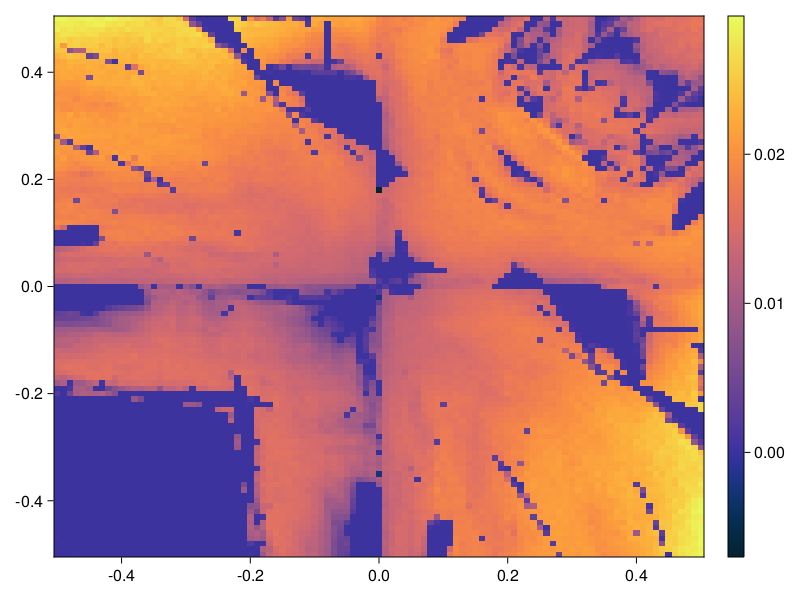

In [41]:
fig, ax, hm = heatmap(k1_array, k1_array, spectrum_matrix[:, :, 1], colormap = :thermal)
Colorbar(fig[:, end+1], hm)

fig

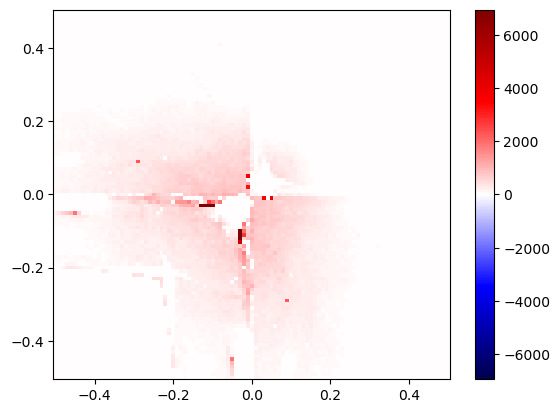

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000497D32B0>

In [30]:
lyapmin,lyapmax =  -maximum( broadcast(abs, EV_map) ), maximum( broadcast(abs, EV_map) )

pcolormesh(k1_array, k2_array, EV_map, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

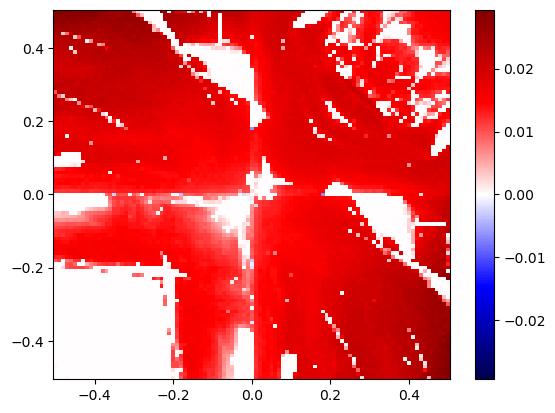

PyObject <matplotlib.colorbar.Colorbar object at 0x000000004988D190>

In [31]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, lyap_matrix) ), maximum( broadcast(abs, lyap_matrix) ) )

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [32]:
using NPZ
NPZ.npzwrite("Map_Lyap_HR_small_article.npy",lyap_matrix)
NPZ.npzwrite("Map_EV_HR_article.npy",EV_map)

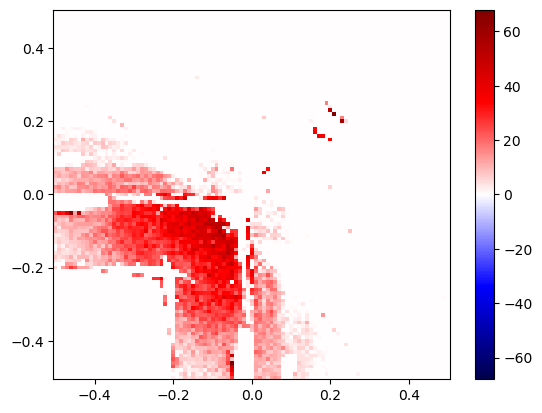

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000009378790>

In [7]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, EV_map) ), maximum( broadcast(abs, EV_map) ) )

pcolormesh(k1_array, k2_array, EV_map, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [10]:
lyap_matrix

101×101 Matrix{Float64}:
  8.19857e-6    6.47474e-5   5.14542e-5   …  0.0276682  0.0272808  0.0291445
  4.06075e-5    3.75252e-5   0.000253653     0.0272182  0.0277339  0.0292966
  3.13037e-5    0.000918656  5.90286e-5      0.0270186  0.0277955  0.029067
  0.000237857   3.48348e-5   2.37488e-5      0.027876   0.027632   0.0287336
  3.654e-5      2.7089e-5    1.00419e-5      0.028559   0.0286812  0.0300362
  9.94368e-6    2.23644e-6   8.28923e-6   …  0.0269209  0.0276201  0.0280668
  2.39406e-5    1.81937e-5   3.74486e-5      0.026856   0.0298292  0.0283967
 -1.85917e-6   -2.39113e-5   1.43275e-5      0.0272673  0.0279262  0.0277269
  1.61646e-5    3.30036e-5   1.4663e-6       0.0264745  0.0275779  0.0280929
 -1.3285e-6     2.29626e-5   6.41577e-6      0.0275636  0.0275413  0.0291799
 -9.06613e-6    9.54144e-6   2.41304e-6   …  0.0270102  0.0268263  0.0291496
  8.70916e-6    1.57952e-5   5.02821e-6      0.025589   0.0269834  0.025414
  3.66871e-5    3.24289e-5   1.65681e-5      0.025743

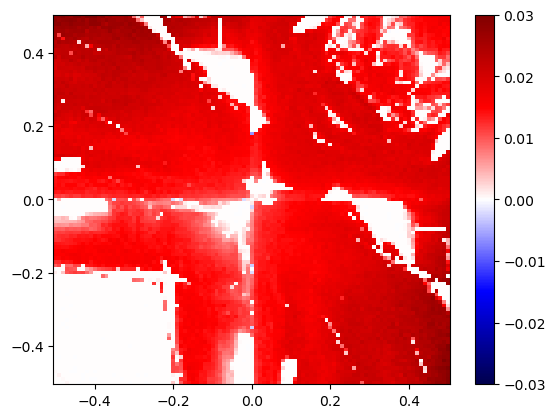

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000008D51DC0>

In [11]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, lyap_matrix) ), maximum( broadcast(abs, lyap_matrix) ) )

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

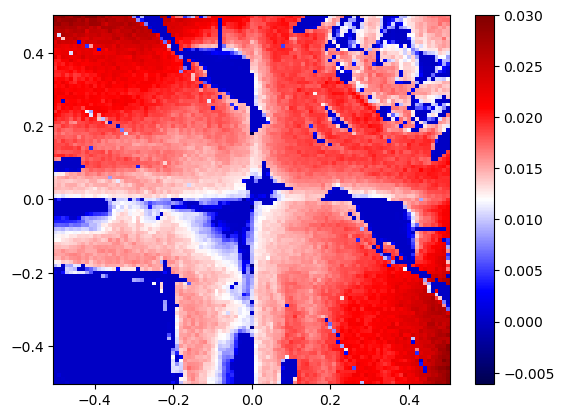

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000008E93340>

In [16]:
lyapmin,lyapmax = minimum(lyap_matrix), maximum( lyap_matrix)

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [12]:
using NPZ
NPZ.npzwrite("Map_Lyap_HR_small.npy",lyap_matrix)
NPZ.npzwrite("Map_EV_HR.npy",EV_map)